# Predicción de enfermedad de diabetes


**Trabajo de Fin de Master , Iratxe Urbaneja**

## TABLA DE CONTENIDOS:
1. Introducción
2. Análisis exploratorio de datos
3. Limpieza de los datos
4. Selección de características
5. División de los datos en grupos de entrenamiento y test + preprocesado con escalado y SMOTE
6. Entrenamiento de módelo predictivo
7. Evaluación del modelo con métricas de rendimiento

--------------------------

# 1. INTRODUCCIÓN:

PROBLEMA: La diabetes es una enfermedad crónica que afecta a millones de personas en todo el mundo. Según la Organización Mundial de la Salud (OMS), la prevalencia global de diabetes en adultos ha aumentado del 4.7% en 1980 al 8.5% en 2014. La diabetes tipo 2, que es el tipo más común, está particularmente asociada con la obesidad y el estilo de vida sedentario. En algunas poblaciones, como los indios Pima de Arizona, la prevalencia de diabetes tipo 2 es excepcionalmente alta, llegando hasta el 50% en adultos. El diagnóstico temprano y la identificación de factores de riesgo son cruciales para prevenir complicaciones graves como enfermedades cardiovasculares, nefropatía, retinopatía y neuropatía. Este estudio tiene como objetivo desarrollar un modelo predictivo para identificar el riesgo de diabetes basado en factores clínicos y demográficos.

DATASET: El conjunto de datos de Diabetes de los Indios Pima, originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales, contiene información de 768 mujeres de al menos 21 años de edad de herencia Pima India. Este dataset ha sido ampliamente utilizado en la investigación de aprendizaje automático para la predicción de diabetes. Incluye variables como el número de embarazos, IMC, nivel de insulina, edad y otras medidas relevantes. El objetivo es predecir si una paciente tiene diabetes basándose en estas medidas diagnósticas.

----------------------------------------------------------------------

## PRIMEROS PASOS:
Antes de poder relaizar nuestro análisis exploratorio de los datos vamos a:
- Importar las librerias necesarias
- Importar el archico csv con los datos
- Crear un Pandas DataFrame para poder trabajar coo los datos
- Comprobar si existen Duplicados

In [ ]:
# Importamos las librerias necesarias:

# Cargamos rich para enriquecer texto
from rich.console import Console
console = Console()

# Librerías básicas para análisis de datos y manipulación
import pandas as pd
import numpy as np
from collections import Counter

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import chi2_contingency, kurtosis, shapiro
from statsmodels.stats.contingency_tables import Table2x2

# Librerías de scikit-learn para preprocesamiento, selección de características y modelado
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek

from sklearn.model_selection import (train_test_split, cross_val_score, KFold, GridSearchCV,
                                     RandomizedSearchCV, StratifiedKFold, cross_val_predict)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,
                             precision_recall_curve, average_precision_score, make_scorer)
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score
)

# Modelos de machine learning
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Librerías para manejo de desbalanceo de clases
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Para manejo de advertencias
import warnings
warnings.filterwarnings('ignore')

# Para transformaciones logarítmicas
from numpy import log1p

# Configuración para mostrar gráficos en el notebook
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [ ]:
# Creamos un dataframe del archivo que se llama 'diabetes.csv'
df = pd.read_csv('diabetes.csv')

In [ ]:
# Comprobar duplicados en el DataFrame
duplicados = df.duplicated()

# Contar el número de duplicados
num_duplicados = duplicados.sum()

print(f"Número de filas duplicadas: {num_duplicados}")

Número de filas duplicadas: 0


- Visulaizaremos las primeras filas del DataFrame
- Visualizaremos la estructura del DataFrame y los tipos de datos
- Extraeremos los atributos identificando la variable objetivo y las variables independientes


In [ ]:
print(df.head(20))
print(df.info())

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0             6      148             72             35        0  33.6   
1             1       85             66             29        0  26.6   
2             8      183             64              0        0  23.3   
3             1       89             66             23       94  28.1   
4             0      137             40             35      168  43.1   
5             5      116             74              0        0  25.6   
6             3       78             50             32       88  31.0   
7            10      115              0              0        0  35.3   
8             2      197             70             45      543  30.5   
9             8      125             96              0        0   0.0   
10            4      110             92              0        0  37.6   
11           10      168             74              0        0  38.0   
12           10      139             80            

Estructura del Dataset:
El dataset contiene 768 entradas y 9 columnas.
No hay valores nulos reportados en ninguna columna, lo que podría ser engañoso dado que sabemos que hay valores 0 que probablemente representan datos faltantes.

Podemos clasificar los atributos de la siguiente manera:

- Variable objetivo:
Outcome (Diagnóstico de diabetes). Es una variable binaria categórica (0 o 1), lo que indica que estamos ante un problema de clasificación.


- Atributos demográficos:
Age (Edad)


- Historia médica y mediciones:
Pregnancies (Número de embarazos),
DiabetesPedigreeFunction (Función de pedigrí de diabetes, es una medida que cuantifica la probabilidad de que una persona tenga diabetes basándose en su historial familiar. Esta función toma en cuenta tanto la edad como el historial de diabetes en la familia del individuo), Glucose (Nivel de glucosa en plasma), BloodPressure (Presión arterial diastólica), SkinThickness (Grosor del pliegue cutáneo del tríceps), Insulin (Insulina sérica de 2 horas), BMI (Índice de masa corporal)


- Todas las variables en el dataset son numéricas excepto por la variable objetivo que es categórica.
Debemos señalar que dentro de las variables numéricas la mayoria son variable continuas excepto por 'Preganancies' y 'DiabetesPedigreeFunction', que son discretas.

-------------------------------------------------------------------------------

# 2. ANÁLISIS EXPLORATORIO DE DATOS

Para este dataset, vamos a estructurar nuestro análisis en tres partes principales:

### 2.1 Análisis de la Variable Objetivo

- Examinar la distribución de la variable 'Outcome' (diagnóstico de diabetes).
Nos ayudará a identificar si hay un desequilibrio en las clases, lo cual podría afectar nuestro modelado posterior.

### 2.2 Análisis de Variables Cuantitativas

Dado que el resto de las variables son numéricas (continuas o discretas), nos enfocaremos en realizar un análisis estadístico detallado. Esto incluirá el cálculo de estadísticas descriptivas, la creación de visualizaciones como histogramas y diagramas de caja, y un análisis de correlaciones entre variables.

1. Visualización de la Distribución: Crearemos histogramas y diagramas de caja (box plots) para cada variable numérica.
Esto nos permitirá identificar la forma de las distribuciones, asimetrías, y la presencia de valores atípicos.

2. Estadísticas Descriptivas:
Calcularemos medidas de tendencia central (media, mediana) y de dispersión (desviación estándar, rango).
Identificaremos los valores mínimos y máximos para detectar posibles anomalías o errores en los datos.

3. Relación con la Variable Objetivo:
Utilizaremos scatterplots y gráficos de densidad para visualizar cómo cada variable se relaciona con el diagnóstico de diabetes.
Esto nos ayudará a identificar patrones o umbrales potencialmente significativos.

4. Detección de Outliers: Analizaremos los diagramas de caja y las estadísticas para identificar valores atípicos.
Prestaremos especial atención a los valores 0 en variables como BloodPressure, SkinThickness, Insulin y BMI.

5. Análisis de Correlaciones:
Crearemos una matriz de correlación para identificar relaciones lineales entre variables.
Visualizaremos estas correlaciones mediante un heatmap para una interpretación más clara.
Examinaremos específicamente las correlaciones con la variable objetivo 'Outcome'.

### 2.3 Análisis Específico por Variable

Cada variable en nuestro dataset tiene un significado clínico particular. Por lo tanto, dedicaremos tiempo a examinar cada una individualmente, considerando su distribución y su relación con el diagnóstico de diabetes.

- Pregnancies: Distribución y su relación con el diagnóstico de diabetes
- Glucose: Rangos de glucosa y su asociación con el diagnóstico
- BloodPressure: Distribución y posibles umbrales de riesgo
- SkinThickness: Análisis de su distribución y posibles valores atípicos
- Insulin: Distribución y su relación con los niveles de glucosa
- BMI: Categorización (bajo peso, normal, sobrepeso, obeso) y su relación con el diagnóstico
- DiabetesPedigreeFunction: Interpretación de esta función y su impacto en el diagnóstico
- Age: Distribución por grupos de edad y su relación con el diagnóstico

### 2.4 Análisis de Valores Faltantes o Cero

- Identificar y cuantificar los valores cero en columnas donde no son biológicamente posibles (como BloodPressure, SkinThickness, Insulin, BMI)
- Visualizar la distribución de estos valores y su impacto en el diagnóstico. Este análisis será crucial para informar nuestras decisiones de limpieza y preprocesamiento de datos.



Esta estrategia nos permitirá obtener una comprensión profunda de las características del dataset, las relaciones entre variables y los posibles desafíos en la limpieza y preparación de datos para el modelado.


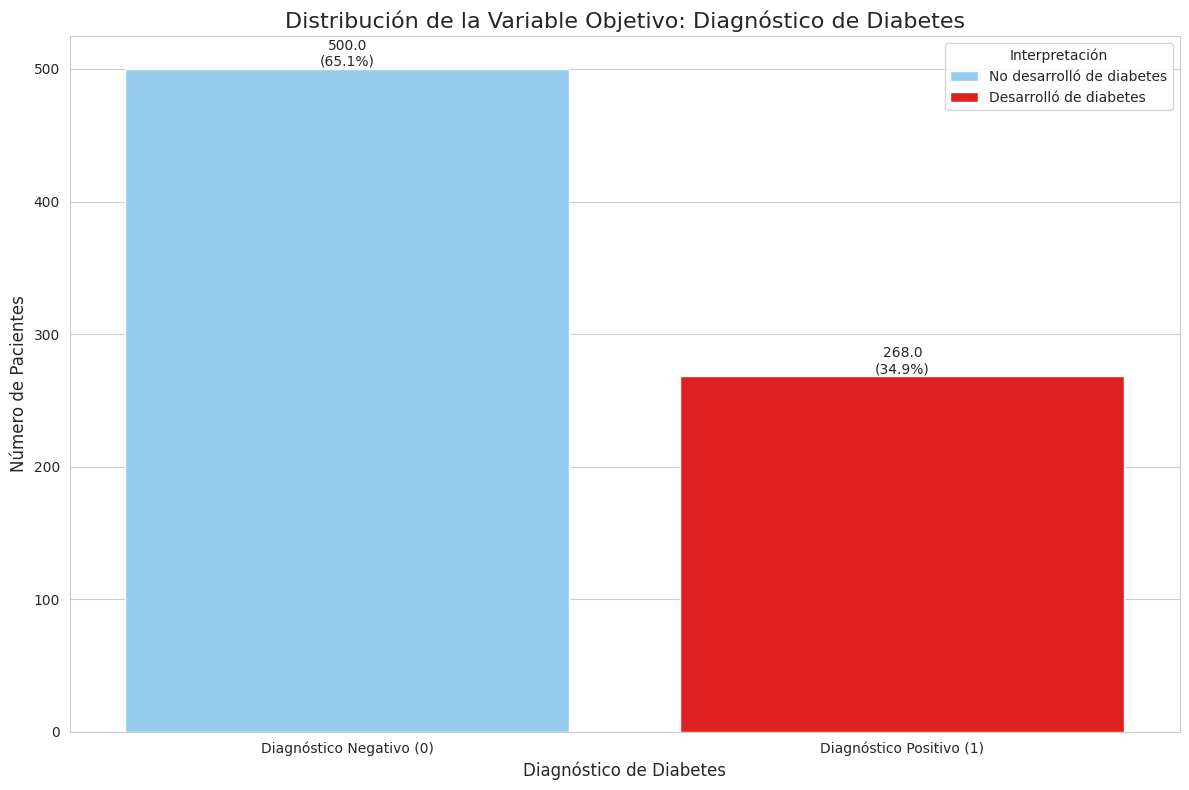

Total de pacientes: 768
Pacientes sin diabetes: 500 (65.1%)
Pacientes con diabetes: 268 (34.9%)


In [ ]:
# Visualización de la variable objetivo Outcome

# Configuración para mejorar la apariencia del gráfico
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
colors = ['#87CEFA', '#FF0000']  # Colores para las barras

# Crear el gráfico de barras
ax = sns.countplot(data=df, x='Outcome', palette=colors)

# Añadir etiquetas y título
plt.title('Distribución de la Variable Objetivo: Diagnóstico de Diabetes', fontsize=16)
plt.xlabel('Diagnóstico de Diabetes', fontsize=12)
plt.ylabel('Número de Pacientes', fontsize=12)


# Cambiar las etiquetas del eje x
plt.xticks([0, 1], ['Diagnóstico Negativo (0)', 'Diagnóstico Positivo (1)'], fontsize=10)

# Añadir etiquetas de valor en las barras
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height}\n({height/total:.1%})',
            ha="center", va="bottom", fontsize=10)

# Añadir una leyenda explicativa
plt.legend(['No desarrolló de diabetes', 'Desarrolló de diabetes'],
           title='Interpretación', loc='upper right', fontsize=10)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir estadísticas adicionales
print(f"Total de pacientes: {total}")
print(f"Pacientes sin diabetes: {df['Outcome'].value_counts()[0]} ({df['Outcome'].value_counts()[0]/total:.1%})")
print(f"Pacientes con diabetes: {df['Outcome'].value_counts()[1]} ({df['Outcome'].value_counts()[1]/total:.1%})")

De la distribución de la variable objetivo que has proporcionado, podemos extraer varias conclusiones importantes:

1. **Desbalance de clases**: Existe un desbalance moderado en el conjunto de datos. La clase mayoritaria (pacientes sin diabetes) representa el 65.1% de los casos, mientras que la clase minoritaria (pacientes con diabetes) representa el 34.9%. Este desbalance de clases, aunque no es extremo, podría afectar el rendimiento de algunos algoritmos de aprendizaje automático. Puede ser necesario considerar técnicas como sobremuestreo de la clase minoritaria (por ejemplo, SMOTE) o submuestreo de la clase mayoritaria durante la fase de preprocesamiento de datos.

2. **Prevalencia de diabetes**: En esta población de estudio, aproximadamente 1 de cada 3 individuos (34.9%) tiene diabetes. Esta es una prevalencia bastante alta en comparación con la población general (5.4%), lo que podría reflejar las características únicas de la población Pima o los criterios de selección del estudio.

3. **Tamaño de la muestra**: Con 768 pacientes en total, tenemos un tamaño de muestra moderado. Esto debería ser suficiente para realizar análisis estadísticos significativos y entrenar modelos de aprendizaje automático, aunque muestras más grandes siempre son preferibles para obtener resultados más robustos.

4. **Relevancia clínica**: La alta proporción de casos positivos (34.9%) subraya la importancia de este estudio para la salud pública, especialmente en poblaciones con alto riesgo de diabetes.

5. **Base para comparaciones**: Esta distribución proporciona una línea base importante para evaluar nuestros modelos predictivos. Un modelo que simplemente predijera siempre la clase mayoritaria (no diabetes) tendría una precisión del 65.1%, lo cual es un punto de referencia útil para evaluar el rendimiento de nuestros modelos más sofisticados.

7. **Generalización de resultados**: Dado el desbalance moderado y la alta prevalencia de diabetes en esta muestra, debemos ser cautelosos al generalizar los resultados a otras poblaciones con diferentes tasas de prevalencia de diabetes.

Estas conclusiones nos ayudarán a guiar nuestro análisis posterior, informar nuestras decisiones de preprocesamiento de datos y establecer expectativas realistas para el rendimiento de nuestros modelos predictivos.


---

# 2.2 Análisis de Variables Cuantitativas

En esta sección, exploraremos las variables numéricas del dataset de diabetes para identificar patrones, tendencias y relaciones significativas que puedan influir en el diagnóstico de diabetes.

Pasos del análisis:

### 1. Visualización de la Distribución de Variables

- Utilizaremos histogramas y boxplots para entender la distribución de cada variable numérica (Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age).
- Esto nos ayudará a identificar asimetrías, curtosis y la presencia de outliers.

### 2. Estadísticas Descriptivas

- Calcularemos medidas como la media, mediana, desviación estándar, y rangos intercuartílicos para cada variable.
- Esto proporcionará un resumen cuantitativo de cada variable y nos ayudará a entender mejor sus características.

### 3. Relación con la Variable Objetivo (Outcome)

- Crearemos scatterplots y pairplots para visualizar cómo cada variable numérica se relaciona con Outcome.
- Buscaremos patrones que puedan indicar asociaciones significativas con el diagnóstico de diabetes.


### 4. Detección de Outliers

- Identificaremos outliers mediante el análisis de boxplots.
- Prestaremos especial atención a los valores 0 en variables como BloodPressure, SkinThickness, Insulin y BMI, que probablemente representen datos faltantes.

### 5. Análisis de Correlación

- Calcularemos la matriz de correlación para identificar relaciones lineales entre variables numéricas.
- Utilizaremos heatmaps para visualizar estas correlaciones y destacar las más fuertes.
- Calcularemos la correlación de nuestras variables numéricas con la variable objetivo 'Outcome'.

Este análisis exhaustivo de las variables cuantitativas nos proporcionará una base sólida para el modelado predictivo de diabetes, permitiéndonos identificar y aprovechar las relaciones clave en el dataset. Además, nos ayudará a abordar los desafíos específicos de este conjunto de datos, como los valores 0 que probablemente representen datos faltantes en algunas variables.


Agrupamos las variables numéricas para trabajar con ellas


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [ ]:
num_vars = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

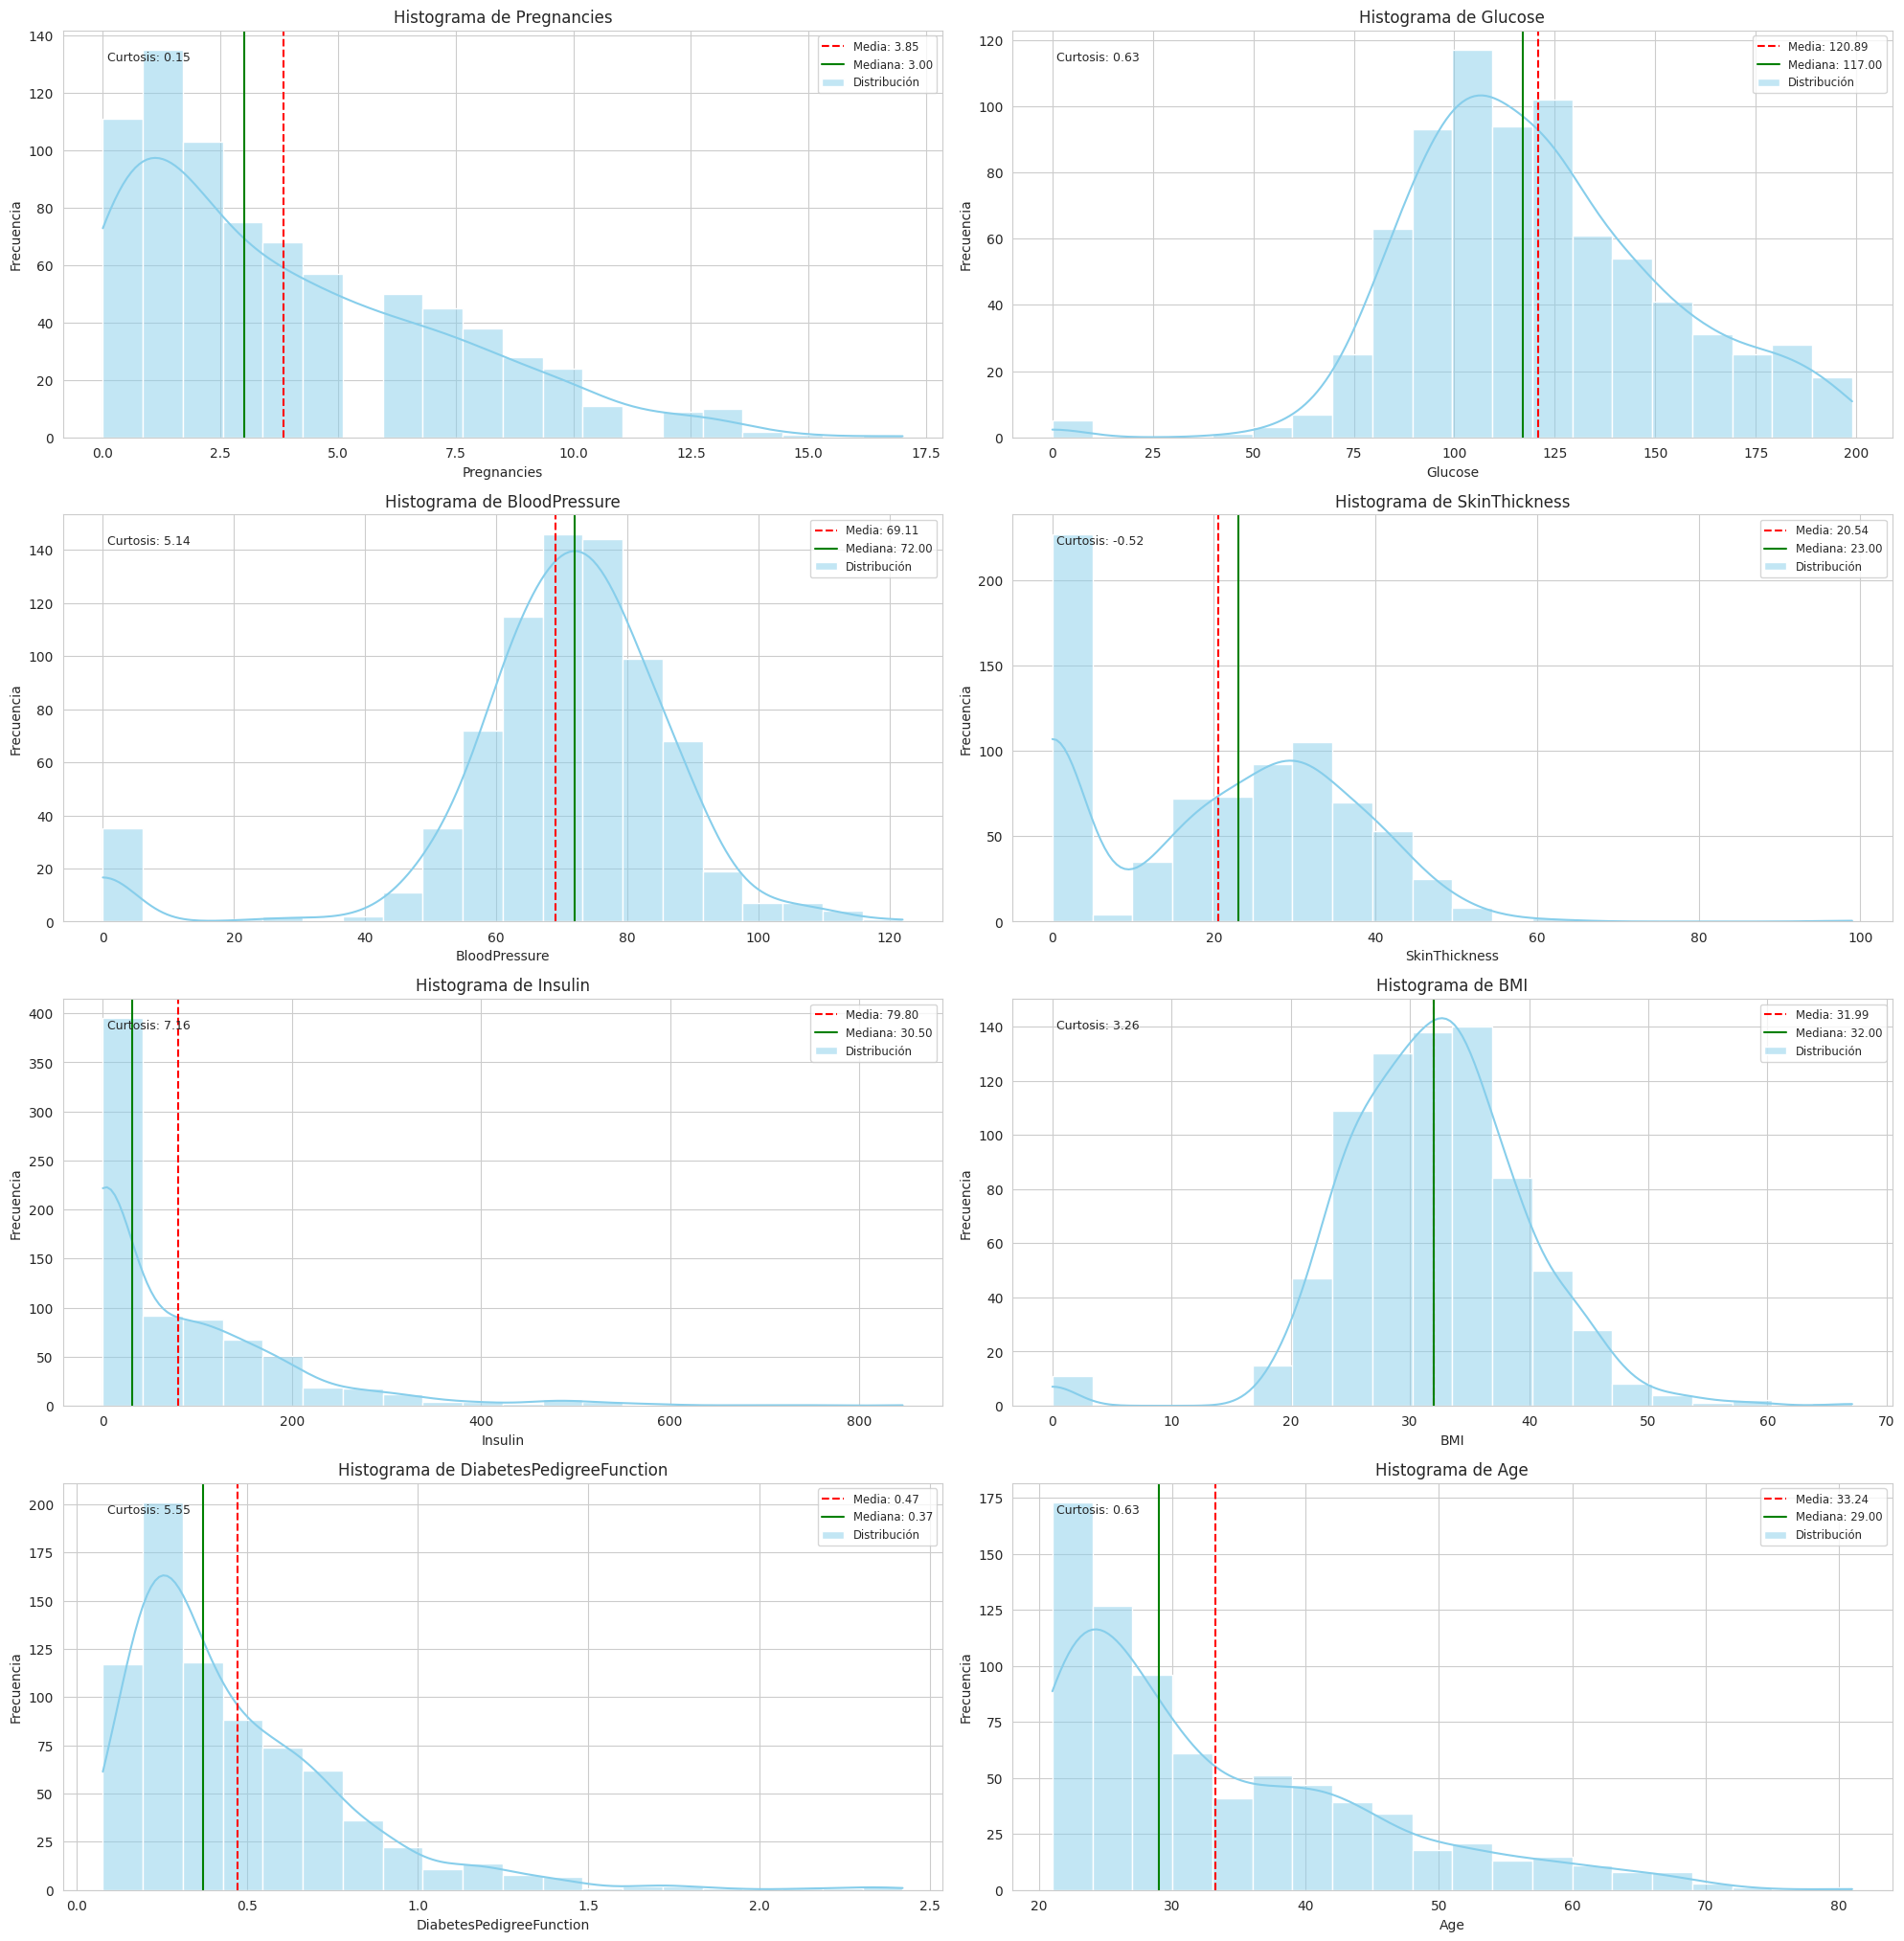

In [ ]:
# Crear histogramas con líneas de media y mediana
plt.figure(figsize=(20, 25))

for i, var in enumerate(num_vars):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df[var], bins=20, kde=True, color='skyblue', label='Distribución')

    # Calcular media y mediana
    mean_val = df[var].mean()
    median_val = df[var].median()
    kurt_val = kurtosis(df[var])

    # Añadir líneas de media y mediana
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', label=f'Mediana: {median_val:.2f}')

    # Añadir texto de curtosis
    plt.text(0.05, 0.95, f'Curtosis: {kurt_val:.2f}',
             transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top')

    # Añadir leyenda
    plt.legend(fontsize='small')
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
# Calculamos estadísticas descriptivas
descriptive_stats = num_vars.describe().transpose()

# Añadir mediana y rango intercuartílico
descriptive_stats['median'] = num_vars.median()
descriptive_stats['IQR'] = descriptive_stats['75%'] - descriptive_stats['25%']

# Mostrar estadísticas descriptivas
print(descriptive_stats[['mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']])

                                mean    median         std     min       25%  \
Pregnancies                 3.845052    3.0000    3.369578   0.000   1.00000   
Glucose                   120.894531  117.0000   31.972618   0.000  99.00000   
BloodPressure              69.105469   72.0000   19.355807   0.000  62.00000   
SkinThickness              20.536458   23.0000   15.952218   0.000   0.00000   
Insulin                    79.799479   30.5000  115.244002   0.000   0.00000   
BMI                        31.992578   32.0000    7.884160   0.000  27.30000   
DiabetesPedigreeFunction    0.471876    0.3725    0.331329   0.078   0.24375   
Age                        33.240885   29.0000   11.760232  21.000  24.00000   

                               50%        75%     max       IQR  
Pregnancies                 3.0000    6.00000   17.00    5.0000  
Glucose                   117.0000  140.25000  199.00   41.2500  
BloodPressure              72.0000   80.00000  122.00   18.0000  
SkinThickness  

Basándonos en las estadísticas descriptivas proporcionadas, podemos extraer varias conclusiones importantes sobre las variables numéricas del dataset de diabetes:

1. Pregnancies (Embarazos):
   - La media es de 3.85, con una mediana de 3, indicando una distribución ligeramente sesgada hacia la derecha.
   - El rango va de 0 a 17 embarazos, con un 75% de las mujeres teniendo 6 o menos embarazos.

2. Glucose (Glucosa):
   - La media (120.89) es ligeramente superior a la mediana (117), sugiriendo una distribución levemente sesgada hacia la derecha.
   - El rango va de 0 a 199 mg/dL, con valores de 0 que probablemente indican datos faltantes.
   - El valor máximo (199 mg/dL) supera significativamente el límite superior normal post-comida (140 mg/dL). Esto sugiere que una proporción considerable de la población estudiada presenta niveles elevados de glucosa, indicativo de prediabetes o diabetes.

3. BloodPressure (Presión Arterial):
   - La media (69.11) es menor que la mediana (72), indicando una posible asimetría hacia la izquierda.
   - El valor mínimo de 0 sugiere la presencia de datos faltantes o erróneos.

4. SkinThickness (Grosor del Pliegue Cutáneo):
   - Hay una diferencia notable entre la media (20.54) y la mediana (23), con un mínimo de 0, indicando probables datos faltantes.

5. Insulin (Insulina):
   - Muestra una gran variabilidad, con una desviación estándar (115.24) mayor que la media (79.80).
   - La mediana (30.5) es significativamente menor que la media, indicando una distribución muy sesgada hacia la derecha.
   - El valor máximo (846 mIU/L) es extremadamente alto, sugiriendo casos de resistencia a la insulina severa o errores en los datos.

6. BMI (Índice de Masa Corporal):
   - La media (31.99) y la mediana (32) son similares, sugiriendo una distribución más simétrica.
   - El rango va de 0 a 67.1, con valores de 0 que probablemente indican datos faltantes. El valor máximo (67.1 kg/m²) indica casos de obesidad extrema. Esto sugiere que una gran parte de la población estudiada tiene sobrepeso u obesidad, factores de riesgo conocidos para la diabetes tipo 2.

7. DiabetesPedigreeFunction:
   - Tiene un rango de 0.078 a 2.42, con una media de 0.472 y una mediana de 0.3725.
   - La distribución parece estar sesgada hacia la derecha, con algunos valores altos influyendo en la media.

8. Age (Edad):
   - La media (33.24) es mayor que la mediana (29), indicando una distribución sesgada hacia la derecha.
   - El rango va de 21 a 81 años, con el 75% de los pacientes teniendo 41 años o menos.

Conclusiones generales:
- Varias variables (Glucose, BloodPressure, SkinThickness, Insulin, BMI) tienen valores mínimos de 0, lo que probablemente indica datos faltantes que necesitarán ser tratados.
- La mayoría de las variables muestran algún grado de asimetría en su distribución.
- Hay una gran variabilidad en algunas medidas, especialmente en Insulin y DiabetesPedigreeFunction, lo que podría influir en los modelos predictivos.
- La edad de la población de estudio es relativamente joven, con una concentración en el rango de 20 a 40 años.
- El dataset muestra una población con características de alto riesgo para diabetes tipo 2, incluyendo niveles elevados de glucosa, insulina y BMI. La presión arterial, sin embargo, parece estar dentro de rangos más normales. Estos hallazgos son consistentes con una población en riesgo de desarrollar o ya diagnosticada con diabetes tipo 2.




Para visualizar cómo cada variable numérica se relaciona con Outcome, vamos a usar scatterplots y pairplots.

- Scatterplots: Muestran la relación directa entre cada variable numérica y Outcome.
- Pairplots: Ofrecen una visión más completa de las relaciones entre múltiples variables numéricas, coloreadas por Outcome.

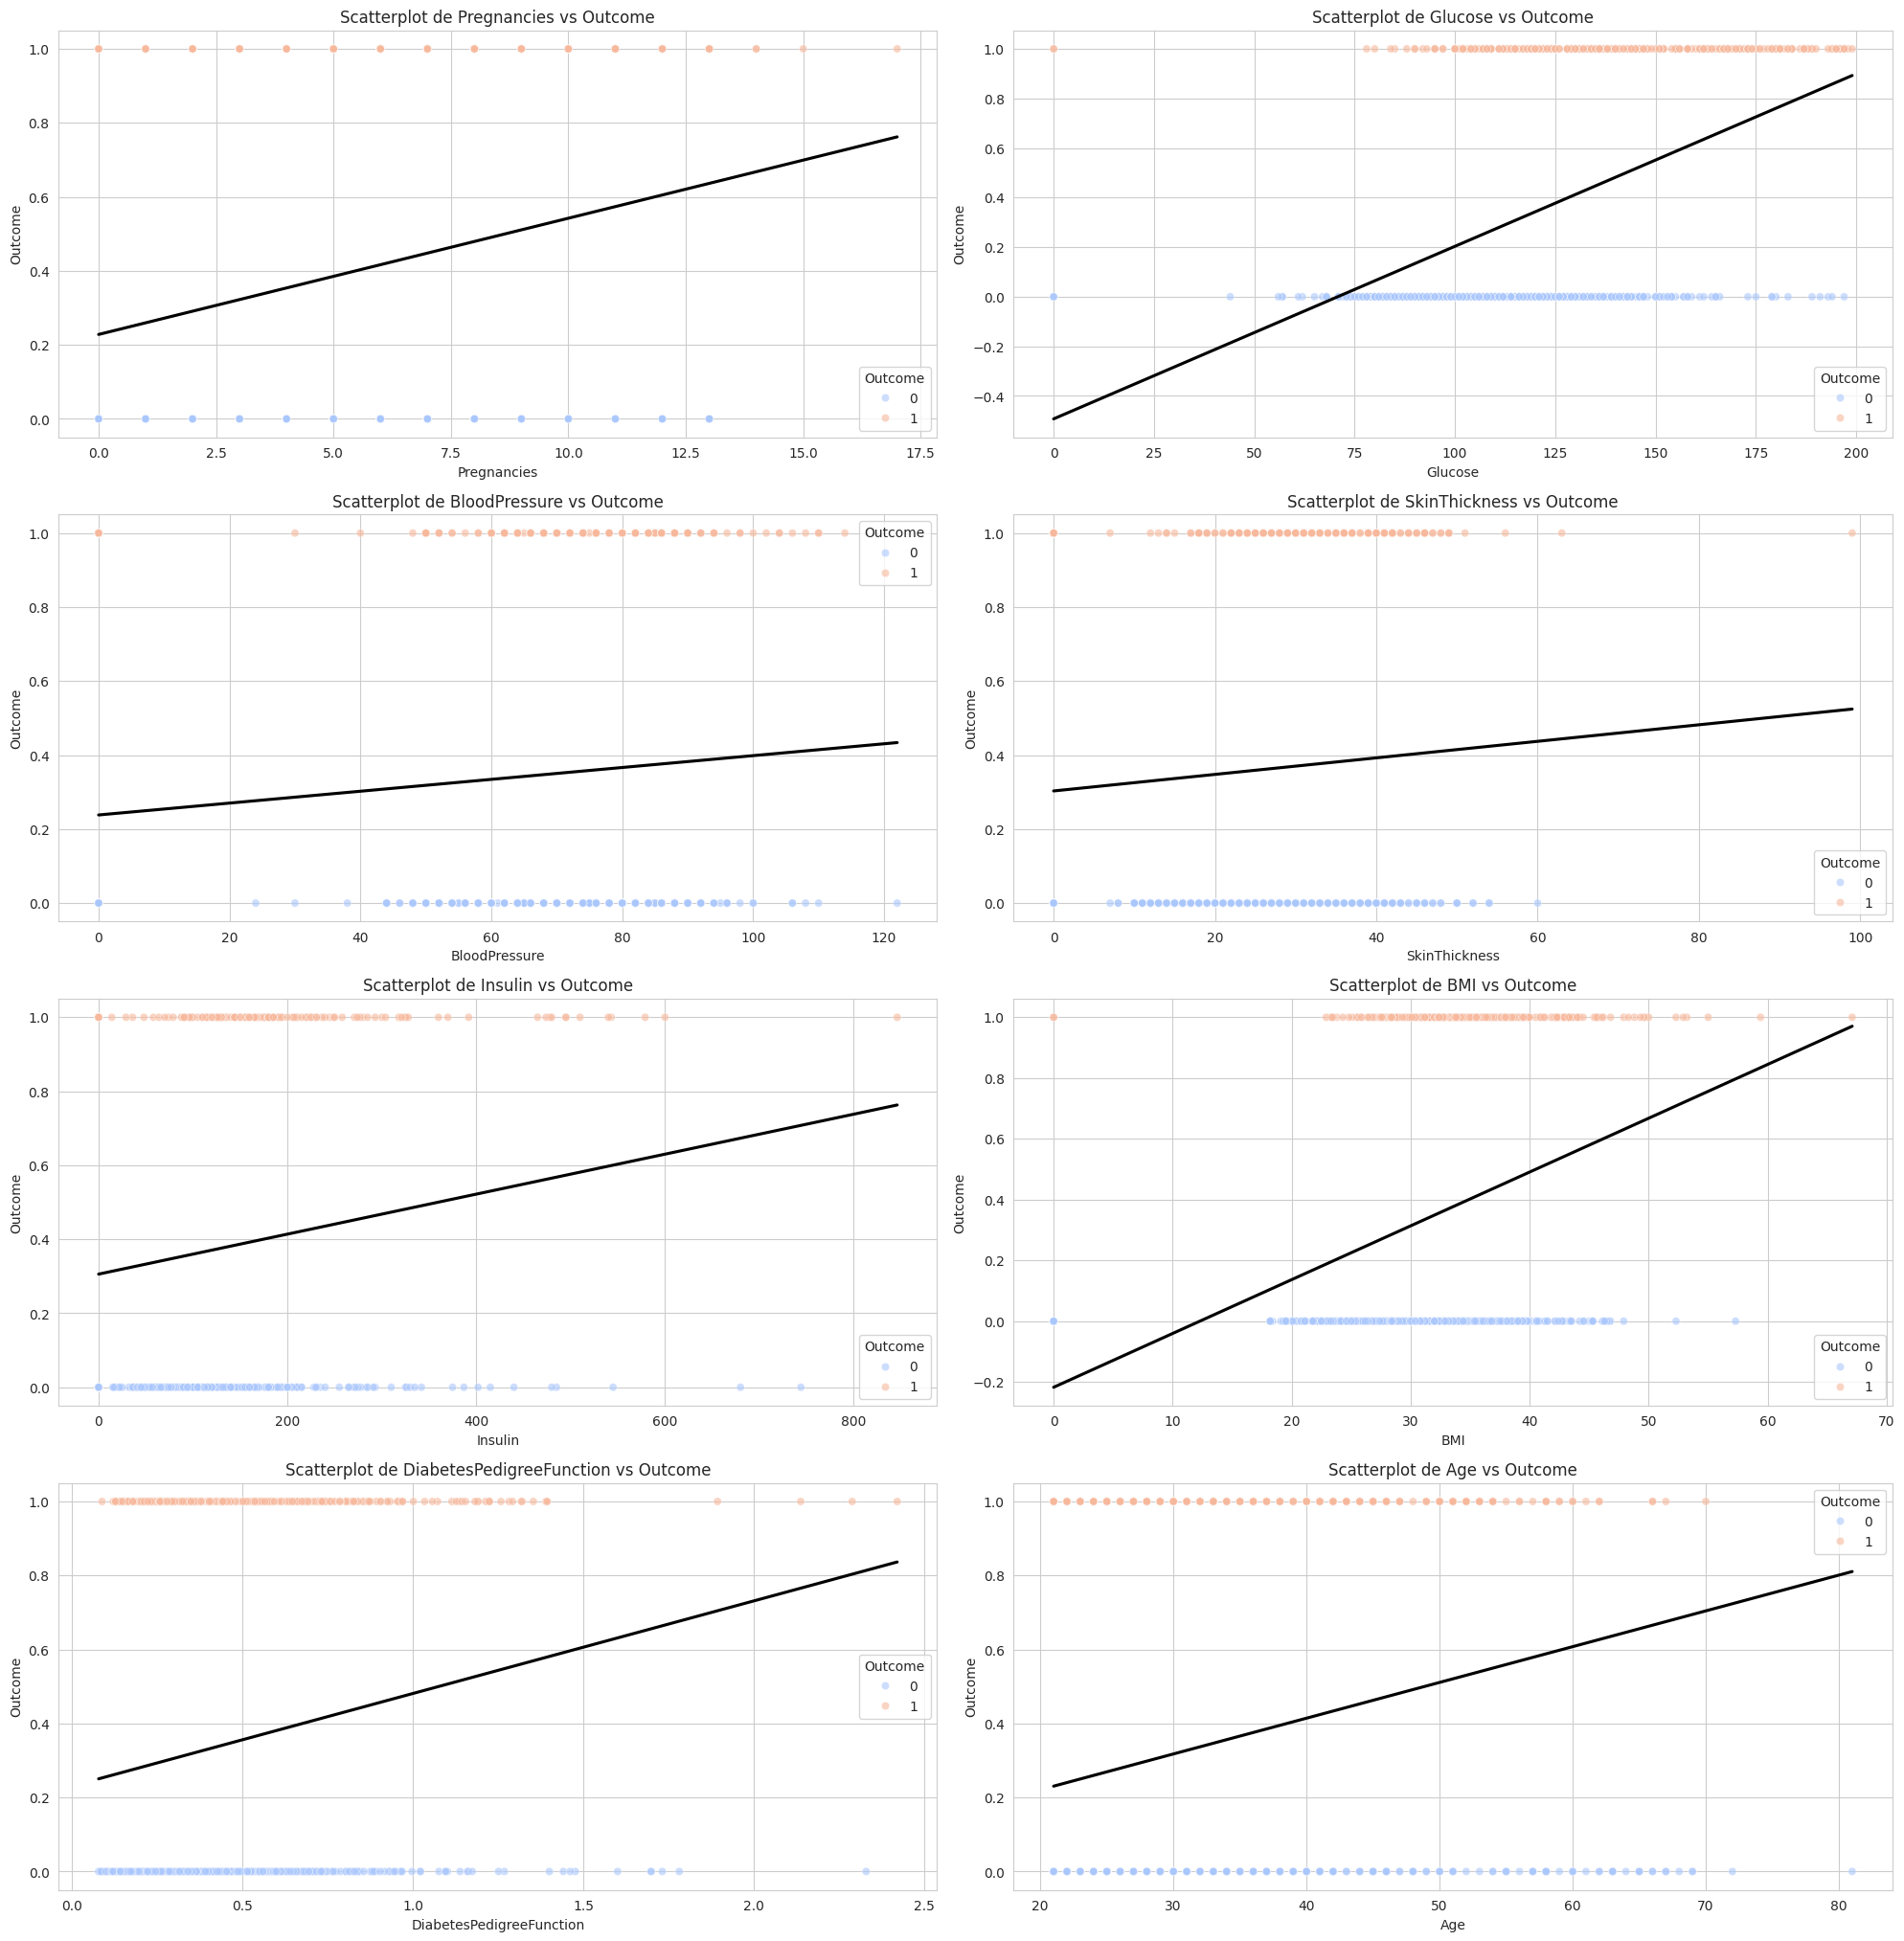

In [ ]:
# Crear scatterplots con colores para la variable objetivo y línea de regresión

# Tamaño de la figura
plt.figure(figsize=(20, 25))

for i, var in enumerate(num_vars):
    plt.subplot(5, 2, i + 1)
    sns.scatterplot(x=df[var], y=df['Outcome'], hue=df['Outcome'], palette='coolwarm', alpha=0.6)
    sns.regplot(x=df[var], y=df['Outcome'], scatter=False, color='black', ci=None)
    plt.title(f'Scatterplot de {var} vs Outcome')
    plt.xlabel(var)
    plt.ylabel('Outcome')

plt.tight_layout()
plt.show()

### 1. **Pregnancies vs. Outcome**
   - Existe una ligera tendencia positiva: a mayor número de embarazos, parece haber una mayor probabilidad de tener diabetes.
   - Esto es consistente con investigaciones que indican que múltiples embarazos pueden estar relacionados con un mayor riesgo de diabetes gestacional y tipo 2.

### 2. **Glucose vs. Outcome**
   - La relación es clara: los valores más altos de glucosa están asociados con una mayor probabilidad de tener diabetes.
   - Este resultado es esperado, ya que niveles elevados de glucosa son un indicador directo de diabetes.

### 3. **BloodPressure vs. Outcome**
   - La relación entre presión arterial y diagnóstico de diabetes parece ser débil o inexistente.
   - Aunque la presión arterial elevada puede ser un factor de riesgo cardiovascular, su conexión directa con la diabetes no es tan evidente en este dataset.

### 4. **SkinThickness vs. Outcome**
   - Hay una ligera tendencia positiva: mayores valores de grosor del pliegue cutáneo están asociados con una mayor probabilidad de tener diabetes.
   - Esto podría reflejar una relación indirecta a través del IMC o la obesidad.

### 5. **Insulin vs. Outcome**
   - Se observa una tendencia positiva: niveles más altos de insulina están asociados con un mayor riesgo de diabetes.
   - Esto es consistente con la resistencia a la insulina, que es un precursor común de la diabetes tipo 2.

### 6. **BMI vs. Outcome**
   - Existe una relación positiva clara: valores más altos del índice de masa corporal (IMC) están asociados con un mayor riesgo de diabetes.
   - Esto subraya el papel importante del sobrepeso y la obesidad como factores de riesgo para la diabetes tipo 2.

### 7. **DiabetesPedigreeFunction vs. Outcome**
   - Se observa una tendencia positiva: valores más altos en esta función (indicando un historial familiar más fuerte) están asociados con un mayor riesgo de diabetes.
   - Esto refuerza el impacto del componente genético en el desarrollo de la enfermedad.

### 8. **Age vs. Outcome**
   - Existe una relación positiva: a mayor edad, aumenta la probabilidad de tener diabetes.
   - Esto es consistente con el hecho conocido de que el riesgo de diabetes tipo 2 aumenta con la edad.

---

### Conclusión General:
- Las variables **Glucose**, **BMI**, y **DiabetesPedigreeFunction** muestran relaciones claras y fuertes con el diagnóstico de diabetes, lo que las podría  convertir en predictores importantes.
- Variables como **Pregnancies**, **Insulin**, y **Age** también tienen una relación positiva significativa, aunque menos marcada.
- Variables como **BloodPressure** y, en menor medida, **SkinThickness**, parecen tener relaciones más débiles o indirectas con el diagnóstico.

Estos patrones serán útiles para priorizar variables en el modelado predictivo y para entender los factores clave asociados al diagnóstico de diabetes en esta población.


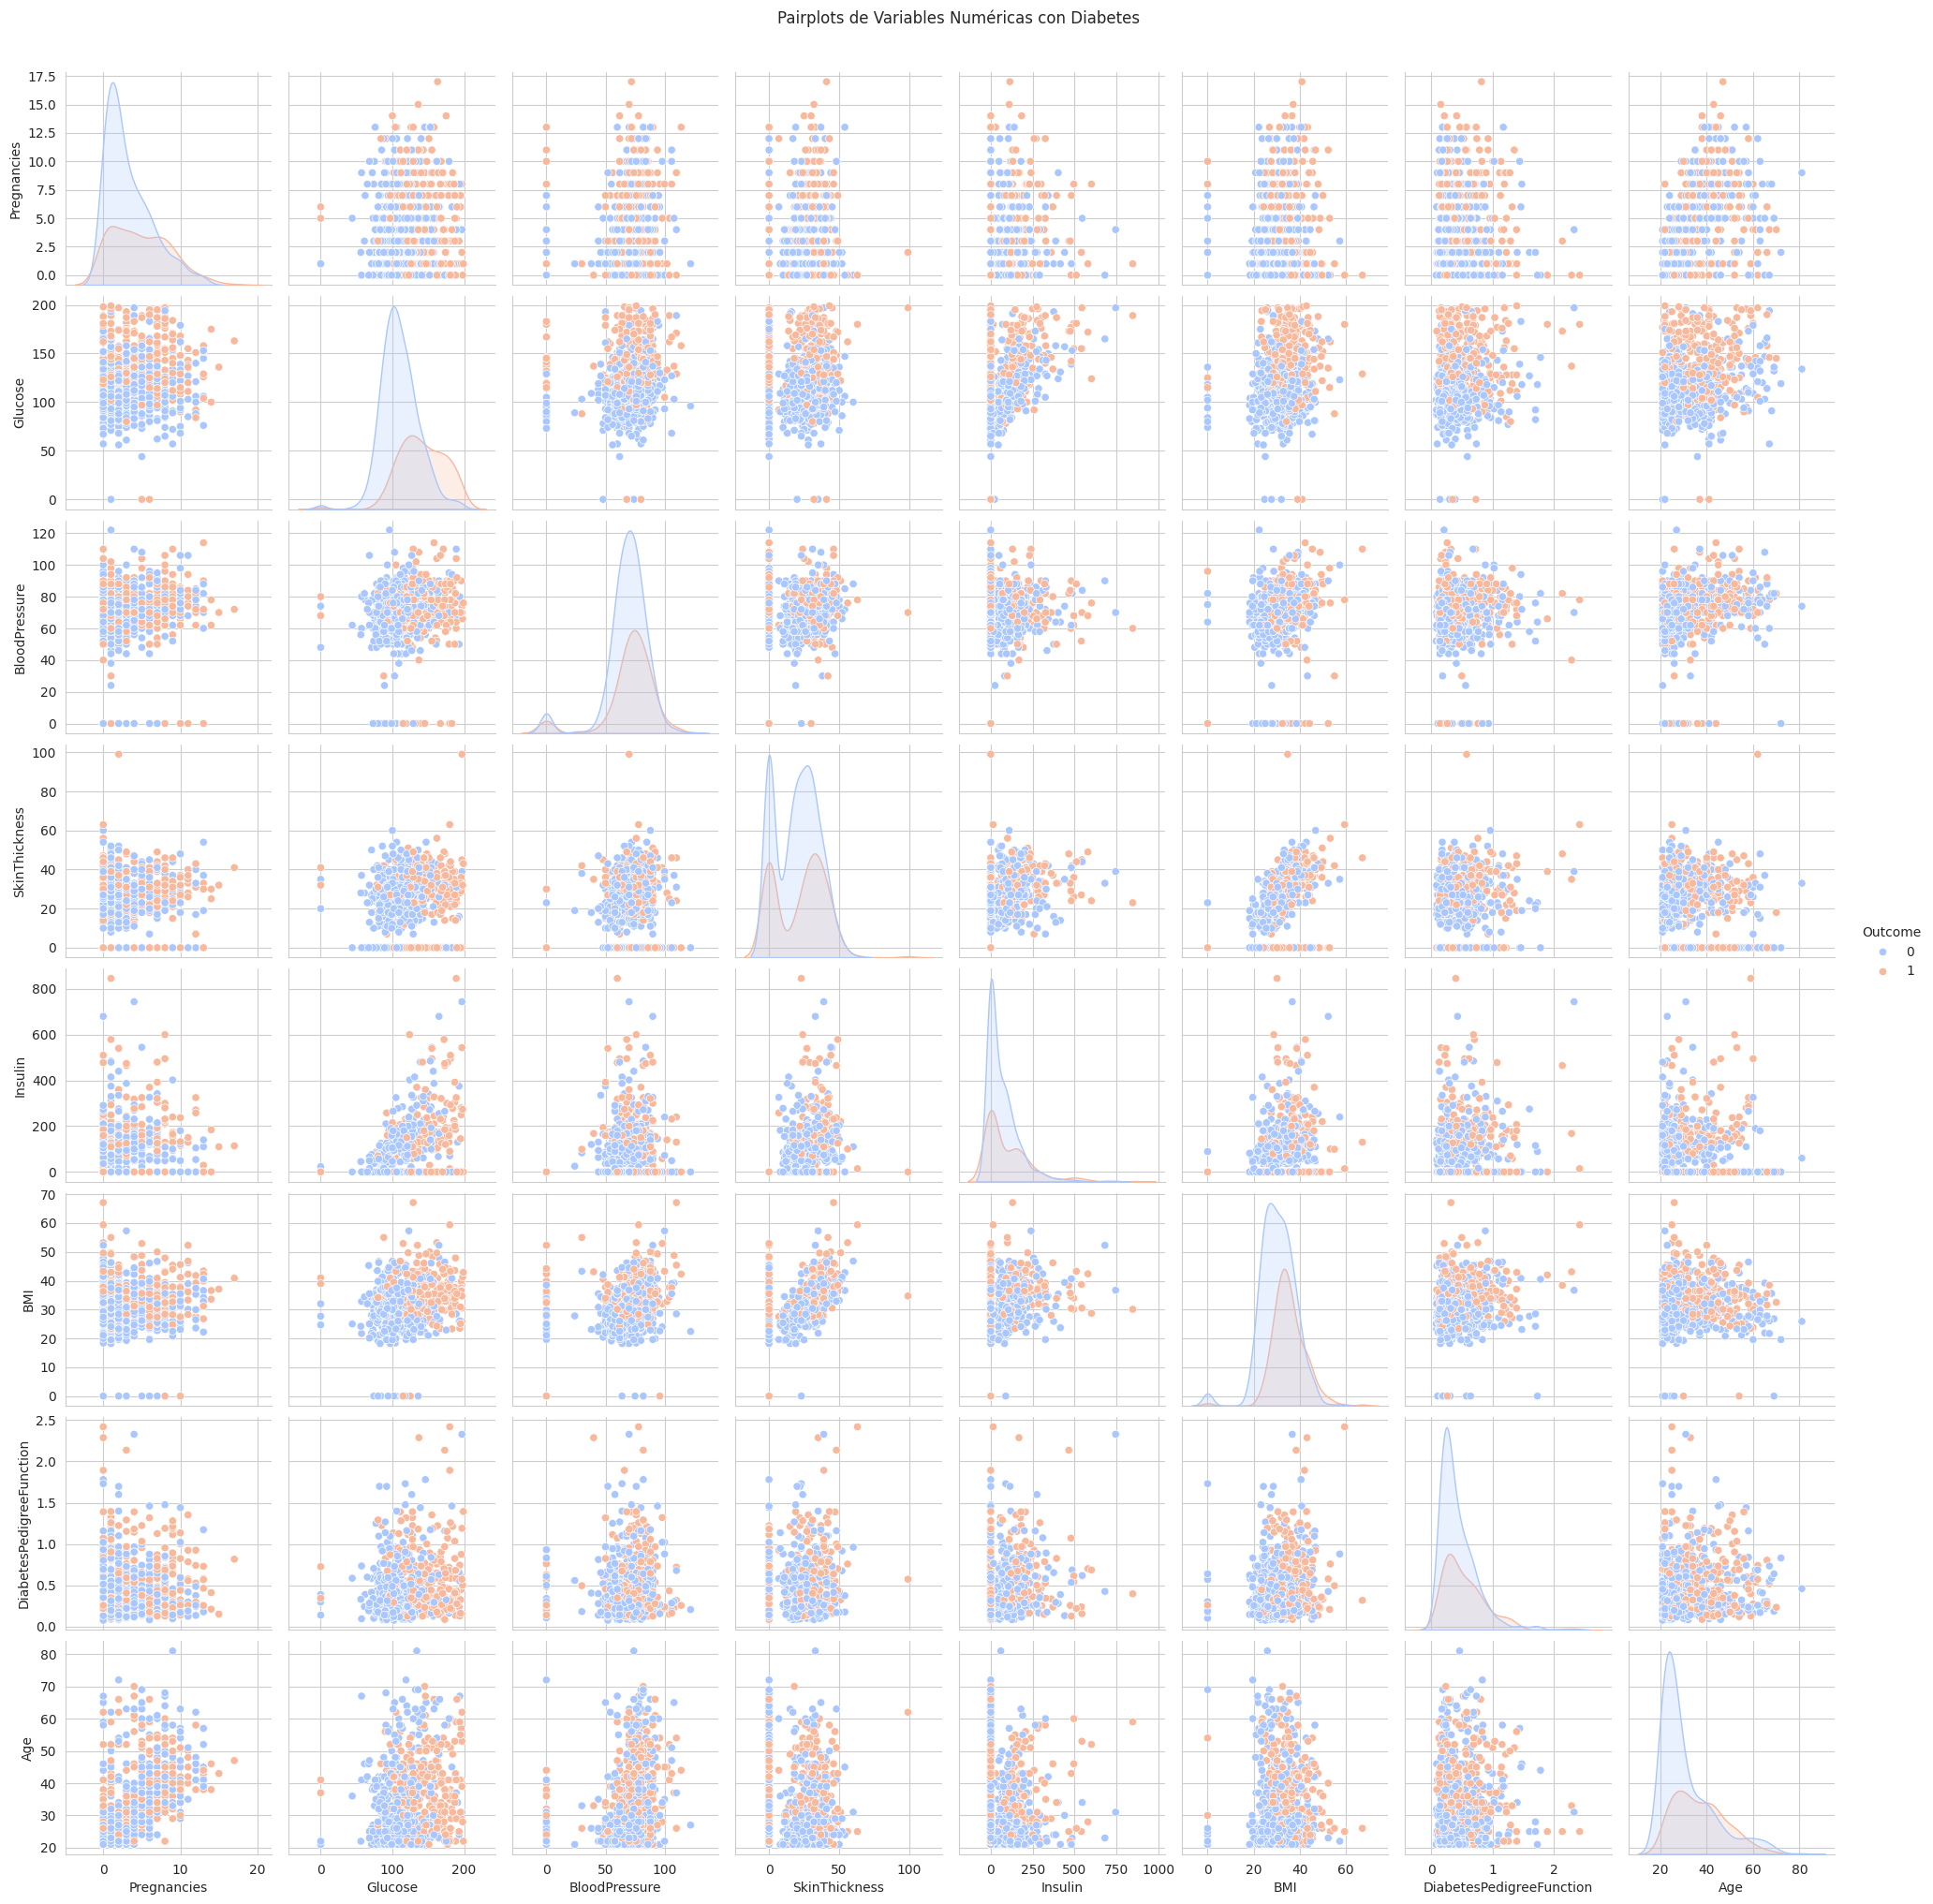

In [ ]:
# Crear pairplot para visualizar relaciones entre variables numéricas y Outcome
sns.pairplot(df, vars=num_vars, hue='Outcome', diag_kind='kde', palette='coolwarm')
plt.suptitle('Pairplots de Variables Numéricas con Diabetes', y=1.02)
plt.show()

### 1. **Distribuciones Univariadas**
   - Las distribuciones de las variables **Glucose**, **BMI**, y **DiabetesPedigreeFunction** muestran diferencias claras entre los pacientes con diabetes (Outcome = 1) y sin diabetes (Outcome = 0).
     - Por ejemplo, los pacientes diabéticos tienden a tener valores más altos en estas variables.
   - Variables como **BloodPressure** y **SkinThickness** tienen distribuciones más solapadas entre ambos grupos, lo que sugiere que estas variables podrían tener un menor poder predictivo.

### 2. **Relaciones entre Variables**
   - **Glucose y BMI**: Existe una correlación positiva moderada entre estas dos variables. Esto tiene sentido, ya que el sobrepeso u obesidad (reflejado en un BMI alto) está relacionado con la resistencia a la insulina y niveles elevados de glucosa.
   - **Age y Pregnancies**: Hay una relación positiva esperada, ya que las mujeres mayores tienden a haber tenido más embarazos.
   - **Insulin y Glucose**: Se observa una relación positiva, consistente con el hecho de que niveles altos de glucosa suelen ir acompañados de niveles elevados de insulina en personas con resistencia a la insulina.

### 3. **Solapamiento entre Grupos**
   - En muchas combinaciones de variables (por ejemplo, **BloodPressure vs. SkinThickness** o **Age vs. BloodPressure**), los puntos correspondientes a Outcome = 0 (azul) y Outcome = 1 (naranja) están muy mezclados. Esto indica que estas combinaciones no separan bien a los pacientes diabéticos de los no diabéticos.
   - En contraste, combinaciones como **Glucose vs. BMI** o **Glucose vs. DiabetesPedigreeFunction** muestran una separación más clara entre ambos grupos.

### 4. **Outliers**
   - El pairplot confirma la presencia de valores extremos en variables como **Insulin**, donde algunos puntos están muy alejados del resto, especialmente en el eje horizontal.
   - También se observan posibles outliers en variables como **SkinThickness** y **BMI**, aunque estos son menos extremos.

### 5. **Interacción entre DiabetesPedigreeFunction y Otras Variables**
   - La variable **DiabetesPedigreeFunction**, aunque no correlaciona fuertemente con otras variables numéricas, muestra una clara diferencia en sus valores para pacientes diabéticos frente a no diabéticos.

---

### Conclusión General:
El pairplot refuerza algunas observaciones previas, como la importancia de variables como **Glucose**, **BMI**, y **DiabetesPedigreeFunction** para predecir diabetes. Sin embargo, también destaca nuevas relaciones entre variables (como Glucose y BMI o Insulin y Glucose) que podrían ser útiles para el modelado. Además, confirma que ciertas variables (como BloodPressure o SkinThickness) tienen menor capacidad para discriminar entre pacientes diabéticos y no diabéticos cuando se analizan individualmente o en combinación con otras.



**ANÁLISIS DE CORRELACIÓN:**

**Ahora calcularemos la matriz de correlación y la representaremos con un heatmap:**
Esto nos ayudará a identificar rápidamente las relaciones lineales más fuertes entre las variables numéricas.

**Calcularemos la correación de las variables numéricas con la variable objetivo**

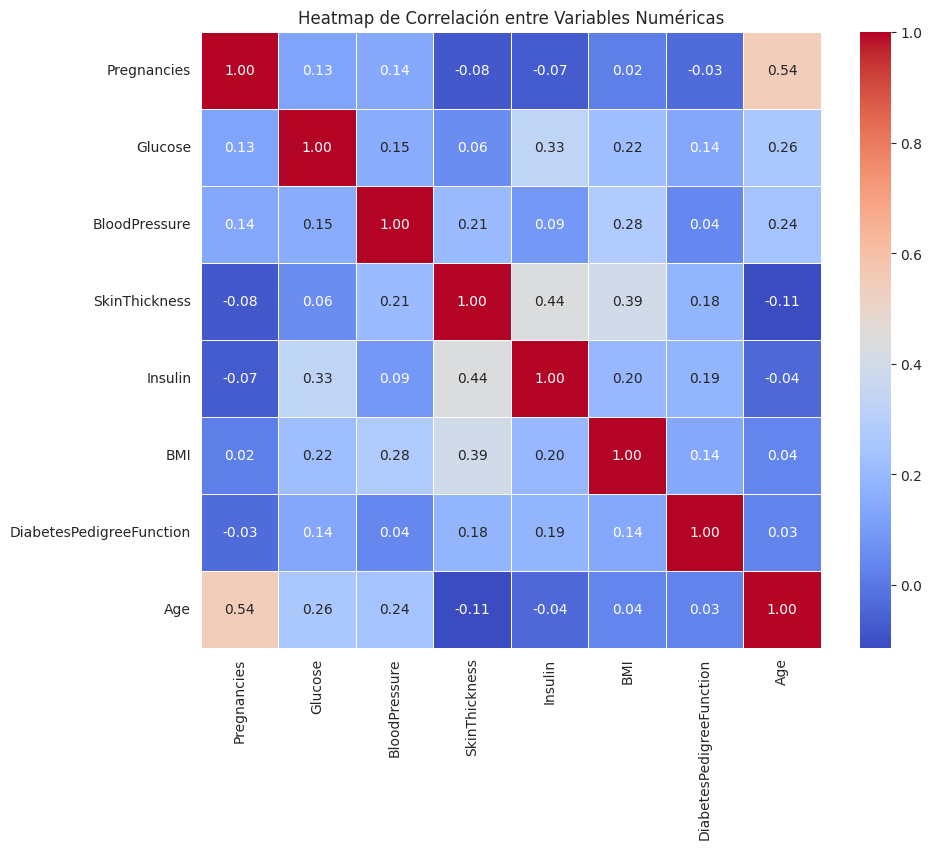

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = num_vars.corr()

# Crear un heatmap para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlación entre Variables Numéricas')
plt.show()

El heatmap de correlación revela que **Pregnancies** y **Age** tienen una correlación moderada (0.54), lo que es esperable ya que las mujeres mayores tienden a tener más embarazos. También se observa una relación positiva entre **SkinThickness** e **Insulin** (0.44), probablemente vinculada a la obesidad o resistencia a la insulina. Variables como **Glucose** e **Insulin** (0.33) y **BMI** con **SkinThickness** (0.39) muestran correlaciones moderadas, reflejando relaciones fisiológicas conocidas. Sin embargo, la mayoría de las demás correlaciones son débiles, lo que sugiere que cada variable aporta información única al modelo predictivo. Este análisis destaca combinaciones clave como **Glucose e Insulin** para entender mejor los factores asociados al diagnóstico de diabetes.


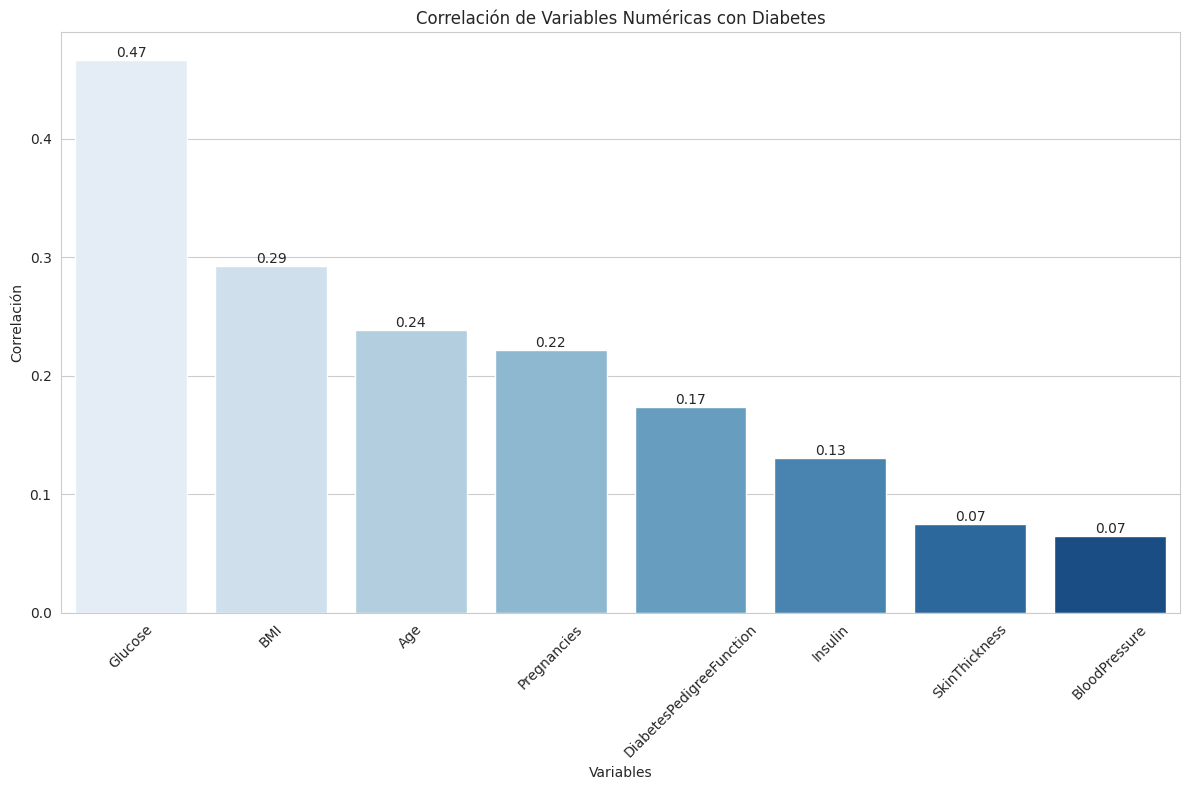

In [ ]:
# Calcular correlaciones con Outcome
correlations = df.corr()['Outcome'].drop('Outcome')

# Ordenar de forma descendente
correlations_sorted = correlations.sort_values(ascending=False)

# Crear barplot
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations_sorted.index, y=correlations_sorted.values, palette='Blues')

# Añadir etiquetas a las barras
for index, value in enumerate(correlations_sorted.values):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.title('Correlación de Variables Numéricas con Diabetes')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=45)  # Rotar etiquetas para que no se superpongan
plt.tight_layout()  # Ajustar el diseño para evitar recortes
plt.show()

- Glucose es la variable con la correlación más alta (0.47) con el diagnóstico de diabetes, lo que confirma que los niveles de glucosa son un predictor clave de la enfermedad.

- BMI (Índice de Masa Corporal) tiene una correlación moderada (0.29), destacando el impacto del sobrepeso y la obesidad en el riesgo de diabetes.

- Age (0.24) y Pregnancies (0.22) también muestran correlaciones moderadas, lo que indica que la edad y el número de embarazos tienen una relación significativa, aunque menos fuerte, con el diagnóstico.

- DiabetesPedigreeFunction tiene una correlación baja (0.17), pero sigue siendo relevante al reflejar el historial familiar como un factor de riesgo.

- Insulin, SkinThickness, y BloodPressure tienen correlaciones muy bajas (< 0.13), lo que sugiere que estas variables tienen menor impacto directo en el diagnóstico de diabetes en este dataset.

- En general, las variables más relevantes para predecir diabetes en este dataset son Glucose, BMI, y en menor medida, Age y Pregnancies, mientras que otras variables parecen tener un papel menos significativo.

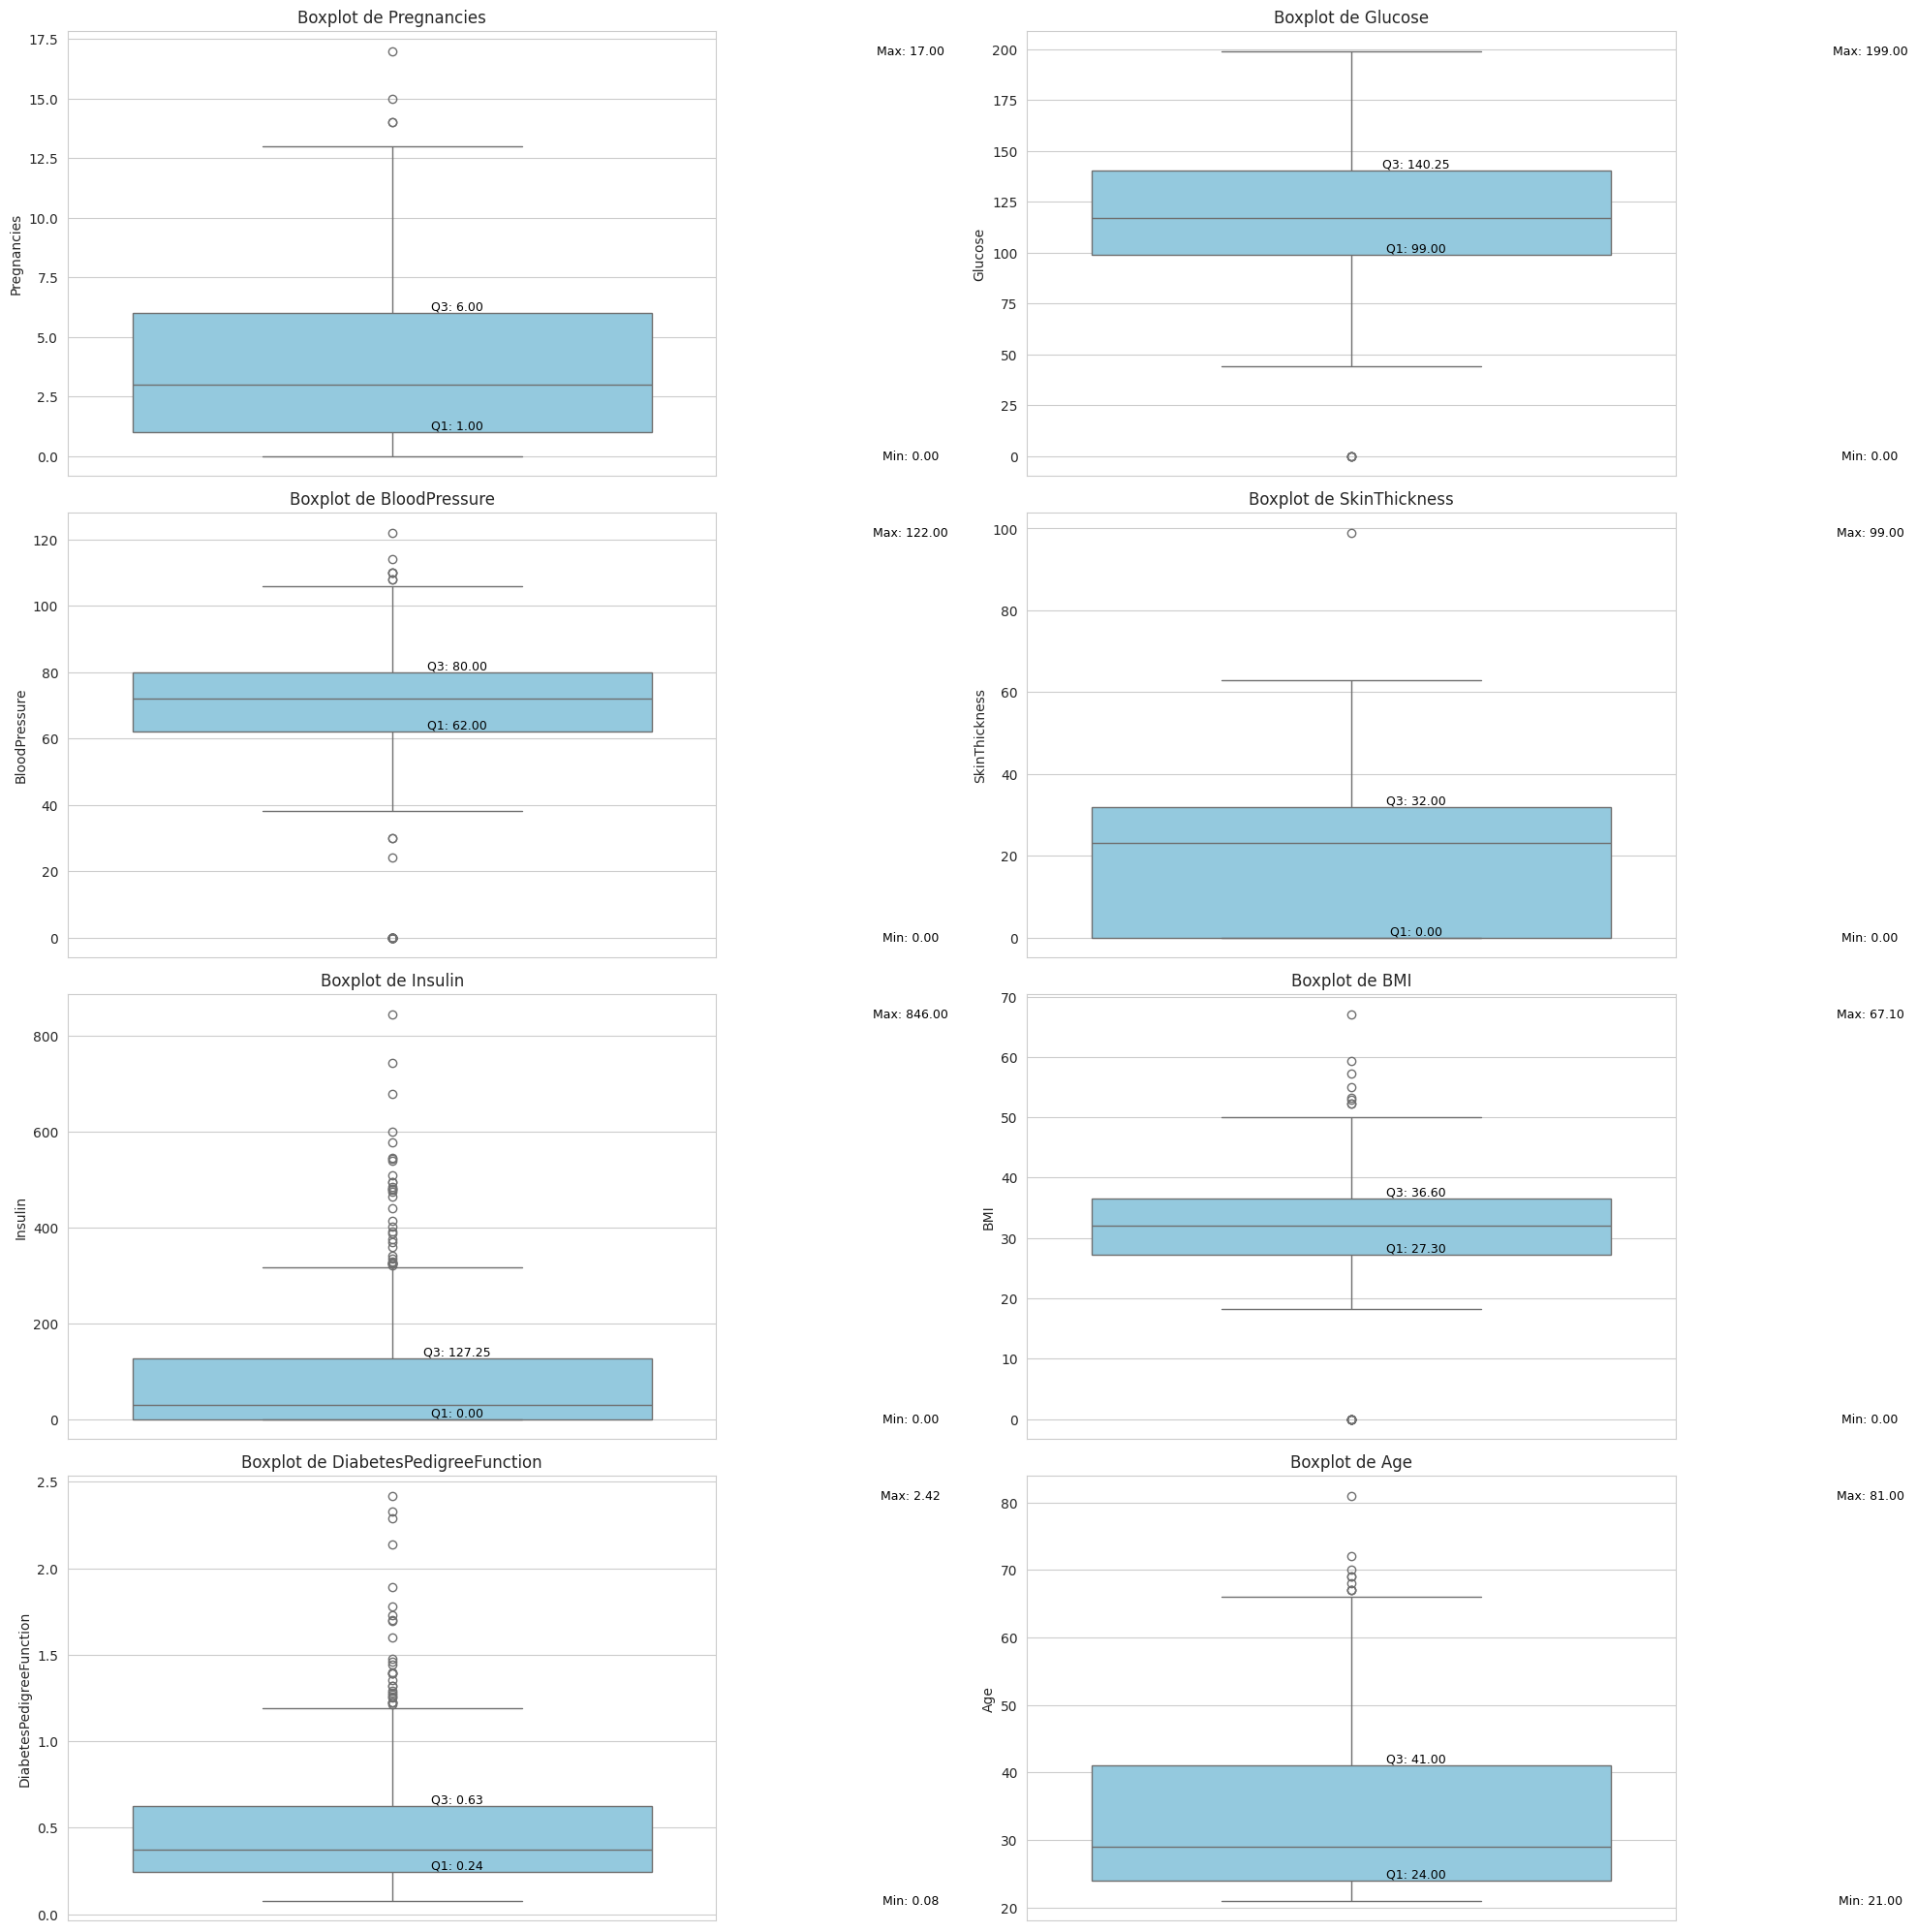

In [ ]:
# Crear boxplots para cada variable con anotaciones
plt.figure(figsize=(20, 25))

for i, var in enumerate(num_vars.columns):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=df[var], color='skyblue')
    plt.title(f'Boxplot de {var}')

    # Calcular estadísticas
    stats = df[var].describe()
    q1, q2, q3 = stats['25%'], stats['50%'], stats['75%']
    min_val, max_val = stats['min'], stats['max']

    # Anotar estadísticas al lado del gráfico
    plt.text(0.8, min_val, f'Min: {min_val:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=9, color='black')
    plt.text(0.8, max_val, f'Max: {max_val:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=9, color='black')

    # Anotar estadísticas sobre el gráfico
    plt.text(0.1, q1, f'Q1: {q1:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=9, color='black')
    plt.text(0.1, q3, f'Q3: {q3:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

- Pregnancies:
Hay valores atípicos por encima de 13 embarazos, lo cual es poco común pero posible en casos extremos.

- Glucose:
Existen pocos outliers por debajo del primer cuartil (Q1), lo que sugiere niveles de glucosa inusualmente bajos.

- BloodPressure:
Existen valores atípicos bajos, incluyendo valores de 0, que son fisiológicamente imposibles y probablemente representan datos faltantes.

- SkinThickness:
Hay outliers altos, pero también se observan valores de 0, lo cual indica datos faltantes en esta variable.

- Insulin:
Presenta numerosos outliers altos, con valores que superan los 400, lo que podría reflejar resistencia a la insulina extrema o errores en los datos.
También hay valores de 0, indicando datos faltantes.

- BMI:
Existen outliers altos, especialmente por encima de 50, lo que representa casos de obesidad extrema.

- DiabetesPedigreeFunction:
Se observan algunos outliers altos por encima de 1.5, lo que sugiere un historial familiar excepcionalmente fuerte de diabetes.

- Age:
Hay algunos outliers altos por encima de los 70 años, aunque estos son menos significativos y representan casos esperables en una población mayor.

# 3. PREPROCESADO DE DATOS

## COMENZAMOS CON LA LIMPIEZA DE DATOS:

Tratamiento de Valores Faltantes: Podemos eliminarlos o rellenados con un valor específico.

Tratamiento de Outliers: Identificaremos y trataremos valores atípicos que pueden sesgar el modelo.

In [ ]:
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
# Contar valores iguales a 0 por columna
missing_values = (num_vars == 0).sum()
print(missing_values)


missing_percentage = missing_values / len(df) * 100
print(missing_percentage)

# Determinar el umbral del 5%
threshold = 5

# Decidir qué hacer con las variables
for var in num_vars.columns:
    if missing_percentage[var] > threshold:
        print(f"La variable {var} supera el umbral del 5% de valores faltantes.")
        # Aquí puedes decidir eliminar la variable o imputar los valores faltantes


Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64
Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
dtype: float64
La variable Pregnancies supera el umbral del 5% de valores faltantes.
La variable SkinThickness supera el umbral del 5% de valores faltantes.
La variable Insulin supera el umbral del 5% de valores faltantes.


A pesar de que 'SkinThickness' y 'Insulin' superan nuestro threshold, siguen siendo variables relevante en el contexto de salud.

La insulina es un marcador crucial en la evaluación del riesgo de diabetes y otras enfermedades metabólicas. Su papel principal es regular los niveles de glucosa en sangre, permitiendo que las células utilicen la glucosa como fuente de energía. La resistencia a la insulina o la insuficiencia de esta hormona puede conducir a condiciones graves como diabetes tipo 2, complicaciones cardiovasculares y daño renal.

La grosura de la piel es un indicador importante tanto en el diagnóstico como en el monitoreo de condiciones fisiológicas y patológicas. En el contexto médico, se utiliza para evaluar cambios relacionados con enfermedades metabólicas, envejecimiento, cicatrización y otras afecciones cutáneas. Además, su medición puede ser relevante para terapias transdérmicas, como la administración de insulina en pacientes diabéticos. Los valores anómalos en el grosor de la piel pueden reflejar alteraciones metabólicas o estructurales que requieren atención clínica.

Por ello vamos a imputar los valores faltantes en ellas también. Utilizaremos un mapa de calor para visualizar los patrones de valores faltantes en el dataset. Esto ayudará a identificar si los valores faltantes están relacionados con otras variables. Nos permitirá seleccionar mejor el metodo de imputación.

<Axes: >

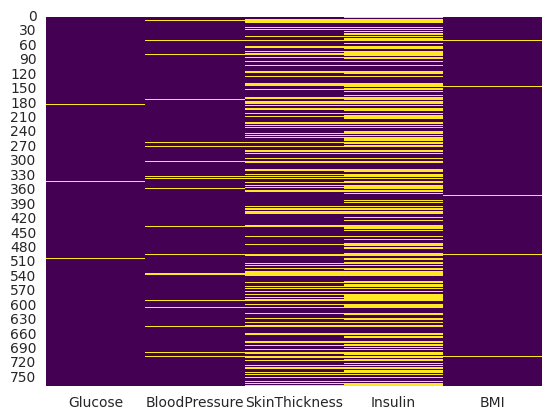

In [ ]:
cero_vars = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0

# Analizar patrones de valores faltantes
sns.heatmap(cero_vars, cbar=False, cmap='viridis')

El mapa de calor sugiere que existe una relación entre los valores faltantes en las variables SkinThickness e Insulin. Esto podría indicar un problema compartido en la medición o recolección de datos para estas variables. Antes de imputar los valores, sería útil investigar si esta correlación tiene una base lógica o si se debe a errores sistemáticos. Además, las técnicas de imputación deberían considerar estas relaciones para preservar la coherencia del dataset.


- Verificaremos la correlación entre las variables Insulin y SkinThickness (sin valores faltantes)

- Analizaremos patrones de valores faltantes:
Para ver si los valores faltantes (ceros) en Insulin y SkinThickness ocurren simultáneamente con más frecuencia de lo esperado.

In [ ]:
# Filtrar filas donde Insulin y SkinThickness no sean 0
valid_data = df[(df['Insulin'] != 0) & (df['SkinThickness'] != 0)]

# Calcular la correlación entre Insulin y SkinThickness
correlation = valid_data[['Insulin', 'SkinThickness']].corr()
print(correlation)


                Insulin  SkinThickness
Insulin        1.000000       0.184888
SkinThickness  0.184888       1.000000


In [ ]:
# Crear una columna booleana para indicar filas con valores faltantes en ambas variables
df['missing_both'] = (df['Insulin'] == 0) & (df['SkinThickness'] == 0)

# Contar cuántas filas tienen valores faltantes en ambas variables
missing_both_count = df['missing_both'].sum()
print(f"Filas con valores faltantes en ambas variables: {missing_both_count}")

# Comparar con el total de valores faltantes individuales
missing_insulin = (df['Insulin'] == 0).sum()
missing_skinthickness = (df['SkinThickness'] == 0).sum()

print(f"Valores faltantes en Insulin: {missing_insulin}")
print(f"Valores faltantes en SkinThickness: {missing_skinthickness}")


Filas con valores faltantes en ambas variables: 227
Valores faltantes en Insulin: 374
Valores faltantes en SkinThickness: 227


A partir de los gráficos y los datos proporcionados, podemos realizar las siguientes observaciones sobre la relación entre los valores faltantes (representados por ceros) en las variables Insulin y SkinThickness:

1. Correlación entre Insulin y SkinThickness:
El coeficiente de correlación entre estas dos variables es 0.184888, lo cual indica una correlación débil pero positiva. Esto sugiere que, en los datos válidos (cuando ambas variables no son 0), no hay una relación fuerte entre Insulin y SkinThickness. Por lo tanto, la correlación de valores faltantes probablemente no se debe a una relación lógica inherente entre estas dos variables.

2. Filas con valores faltantes en ambas variables:
Cada vez que SkinThickness es 0, también lo es Insulin. Sin embargo, no ocurre lo mismo al revés, ya que Insulin tiene un total de 374 valores faltantes, lo que significa que hay casos donde solo Insulin es 0.
Este patrón sugiere un posible problema sistemático en la recolección o registro de datos para estas dos variables.

Según la documentación del dataset, estos valores fueron introducidos como marcadores para indicar datos faltantes debido a:
- Errores sistemáticos en la recolección: Es posible que ciertos parámetros no se midieran para algunos pacientes debido a limitaciones técnicas o logísticas.

- Falta de relevancia clínica: En algunos casos, las mediciones podrían haberse omitido si no eran necesarias para el diagnóstico o seguimiento del paciente.

- Fuentes de datos mixtas: Los datos provienen tanto de registros electrónicos como manuales, lo que podría haber contribuido a inconsistencias en la captura de información.

- Es necesario imputar estos valores para evitar sesgos en el análisis posterior.

## Estrategia de imputación:

1. Glucose:
Es un marcador clave en el diagnóstico de diabetes. Solo presenta 5 valores faltantes, lo que equivale a un porcentaje muy bajo del dataset. Imputaremos con la mediana de la variable, ya que la cantidad de valores faltantes es baja y no afecta significativamente la distribución.
2. BloodPressure: Presenta una cantidad de valores faltantes moderada (35).
Imputaremos con la mediana, ya que no hay una fuerte correlación con otras variables y la cantidad de valores faltantes sigue siendo manejable.
3. BMI: Lantidad de valores faltantes es baja (11).
Imputaremos con la mediana, ya que los valores faltantes son pocos y no afectan significativamente el análisis.
4. SkinThicknes: La cantidad de valores faltantes es alta (227). Dado que SkinThickness tiene una correlación moderada con BMI (0.39) y Insulin (0.44), usaremos un enfoque iterativo para manejar sus valores faltantes:
Crearemos una columna temporal (SkinThickness_temp) donde imputaremos los valores faltantes de SkinThickness utilizando la mediana.
Utilizaremos esta columna temporal junto con el resto de las variables relevantes (Glucose, BMI, Age, BloodPressure, Pregnancies, DiabetesPedigreeFunction) para imputar los valores faltantes de Insulin mediante un modelo Random Forest.
Finalmente, reimputaremos los valores reales de SkinThickness utilizando un modelo Random Forest, considerando como predictores las variables completas, incluida la versión imputada de Insulin.
5. La cantidad de valores faltantes es alta (374). Dado que Insulin tiene una correlación moderada con Glucose (0.33) y SkinThickness (0.44), usaremos un modelo Random Forest para imputar esta variable utilizando como predictores:
Glucose,
SkinThickness_temp (columna temporal),
BMI,
Age,
BloodPressure,
Pregnancies,
DiabetesPedigreeFunction.
- Anteriormente utilizamos la técnica MICE para imputar simultáneamente SkinThickness e Insulin. Sin embargo, esto resultó en sesgos en las distribuciones y relaciones entre estas variables, especialmente en la correlación entre ellas, que disminuyó significativamente tras la imputación. Para resolver este problema:
- Adoptamos un enfoque iterativo que evita dependencias mutuas directas entre variables con muchos valores faltantes.
- Usamos modelos avanzados como Random Forest para capturar mejor las relaciones no lineales entre las variables.
- Este enfoque preserva mejor las correlaciones clave (SkinThickness-BMI, Insulin-Glucose) y genera distribuciones más consistentes con los datos válidos del dataset original.


In [ ]:
# Crear una copia del DataFrame original para realizar imputaciones
df_cleaned = df.copy()

In [ ]:
# Imputamos valores de Glucosa
df_cleaned['Glucose'] = df_cleaned['Glucose'].replace(0, df_cleaned['Glucose'].median())

# Imputamos valores de BloodPressure
df_cleaned['BloodPressure'] = df_cleaned['BloodPressure'].replace(0, df_cleaned['BloodPressure'].median())

# Imputamos valores de BMI
df_cleaned['BMI'] = df_cleaned['BMI'].replace(0, df_cleaned['BMI'].median())


Debemos tener en cuenta que el imputador iterativo (IterativeImputer) solo imputa valores faltantes representados como NaN. Si los valores faltantes están representados como ceros (como en este caso), el imputador no los considera como datos faltantes y no los reemplazará. Debemos convertir los ceros en las columnas SkinThickness e Insulin a NaN antes de aplicar la imputación iterativa.

In [ ]:
# Paso 1: Crear una columna temporal para SkinThickness

# Reemplazar ceros por NaN
df_cleaned[['SkinThickness', 'Insulin']] = df_cleaned[['SkinThickness', 'Insulin']].replace(0, np.nan)

# Imputar SkinThickness preliminarmente con la mediana
df_cleaned['SkinThickness_temp'] = df_cleaned['SkinThickness'].fillna(df_cleaned['SkinThickness'].median())



In [ ]:
# Paso 2: Usar la columna temporal para predecir Insulin
from sklearn.ensemble import RandomForestRegressor

# Filtrar datos completos para Insulin
complete_data_insulin = df_cleaned[df_cleaned['Insulin'].notnull()]
X_insulin = complete_data_insulin[['Glucose', 'SkinThickness_temp', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]
y_insulin = complete_data_insulin['Insulin']

# Filtrar datos con valores faltantes en Insulin
missing_data_insulin = df_cleaned[df_cleaned['Insulin'].isnull()]
X_missing_insulin = missing_data_insulin[['Glucose', 'SkinThickness_temp', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]

# Entrenar modelo Random Forest para Insulin
rf_model_insulin = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_insulin.fit(X_insulin, y_insulin)

# Predecir los valores faltantes de Insulin
predicted_insulin = rf_model_insulin.predict(X_missing_insulin)

# Reemplazar los valores faltantes en Insulin
df_cleaned.loc[missing_data_insulin.index, 'Insulin'] = predicted_insulin


In [ ]:
# Paso 3: Reimputar la columna original de SkinThickness

# Filtrar datos completos para SkinThickness
complete_data_skin = df_cleaned[df_cleaned['SkinThickness'].notnull()]
X_skin = complete_data_skin[['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]
y_skin = complete_data_skin['SkinThickness']

# Filtrar datos con valores faltantes en SkinThickness
missing_data_skin = df_cleaned[df_cleaned['SkinThickness'].isnull()]
X_missing_skin = missing_data_skin[['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]

# Entrenar modelo Random Forest con ajustes en los hiperparámetros
rf_model_skin = RandomForestRegressor(
    n_estimators=200,  # Incrementar el número de árboles
    max_depth=10,      # Limitar la profundidad máxima
    min_samples_leaf=5,  # Aumentar el mínimo de muestras por hoja
    random_state=42
)
rf_model_skin.fit(X_skin, y_skin)

# Predecir los valores faltantes de SkinThickness
predicted_skinthickness = rf_model_skin.predict(X_missing_skin)

# Reemplazar los valores faltantes en SkinThickness
df_cleaned.loc[missing_data_skin.index, 'SkinThickness'] = predicted_skinthickness

# Eliminar la columna temporal si ya no es necesaria
df_cleaned.drop(columns=['SkinThickness_temp'], inplace=True)




In [ ]:
# Verificar si quedan valores faltantes
print((df_cleaned[['Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'Insulin']]== 0).sum())


Glucose          0
BloodPressure    0
BMI              0
SkinThickness    0
Insulin          0
dtype: int64


Para evaluar si la imputación realizada ha sido adecuada y si no deberíamos haber utilizado otro modelo, seguiremos estos pasos de validación:

- Comparar las distribuciones de las variables antes y después de la imputación para asegurarnos de que los valores imputados son consistentes con los datos originales.
- Comparar estadísticas descriptivas (media, mediana, percentiles) antes y después de la imputación para detectar desviaciones significativas.
- Verifica si las relaciones entre variables (correlaciones) se mantienen consistentes después de la imputación. Esto es especialmente importante para SkinThickness e Insulin, ya que sus valores fueron imputados usando modelos predictivos basados en otras variables.

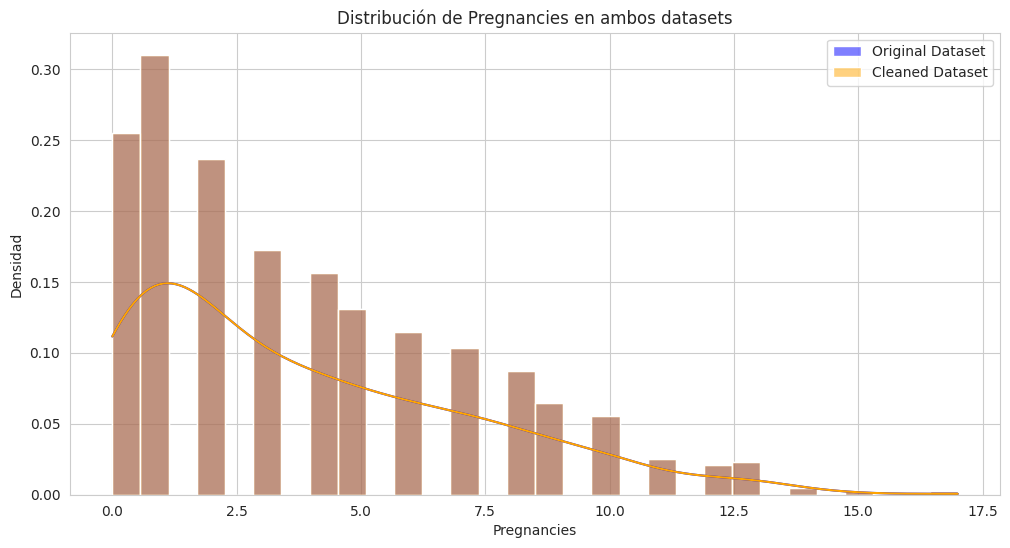

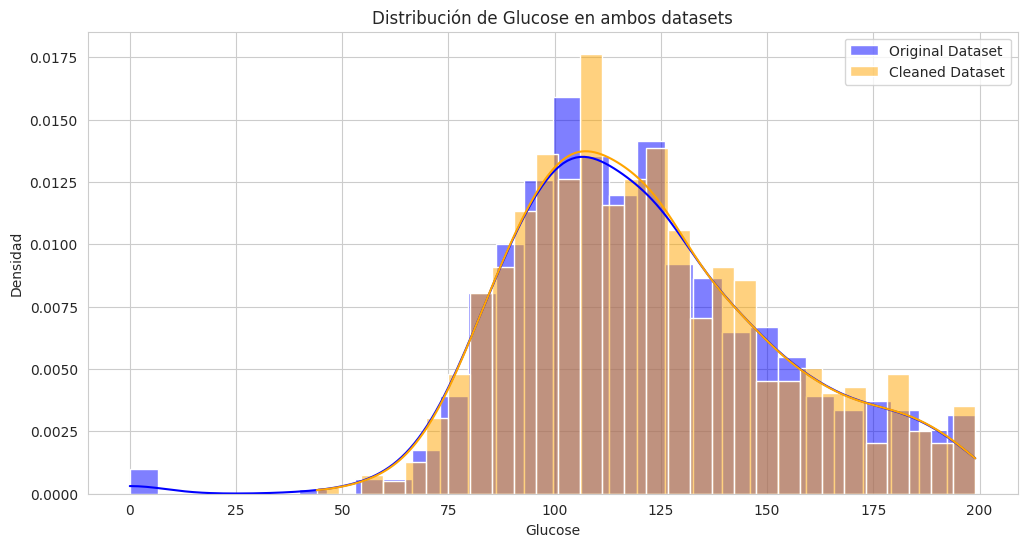

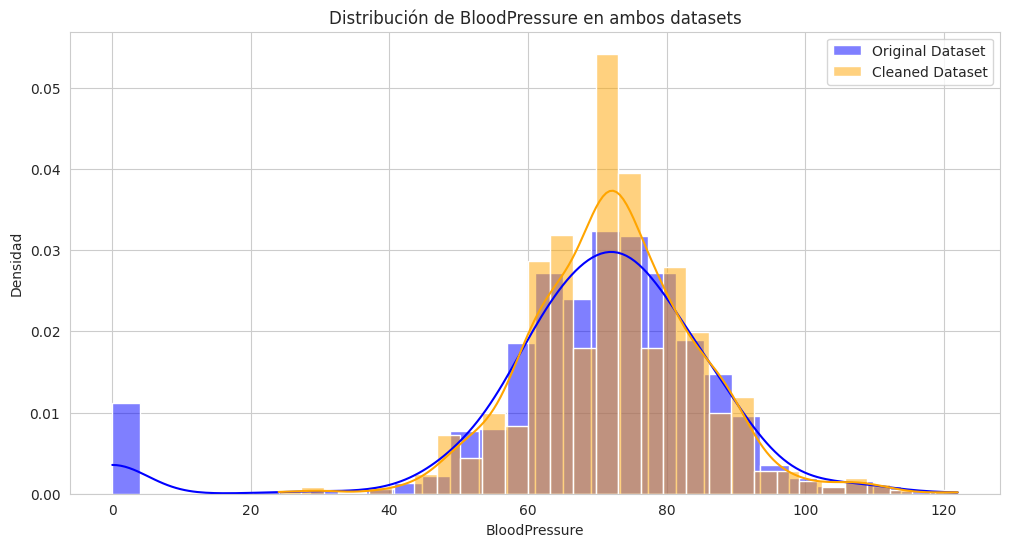

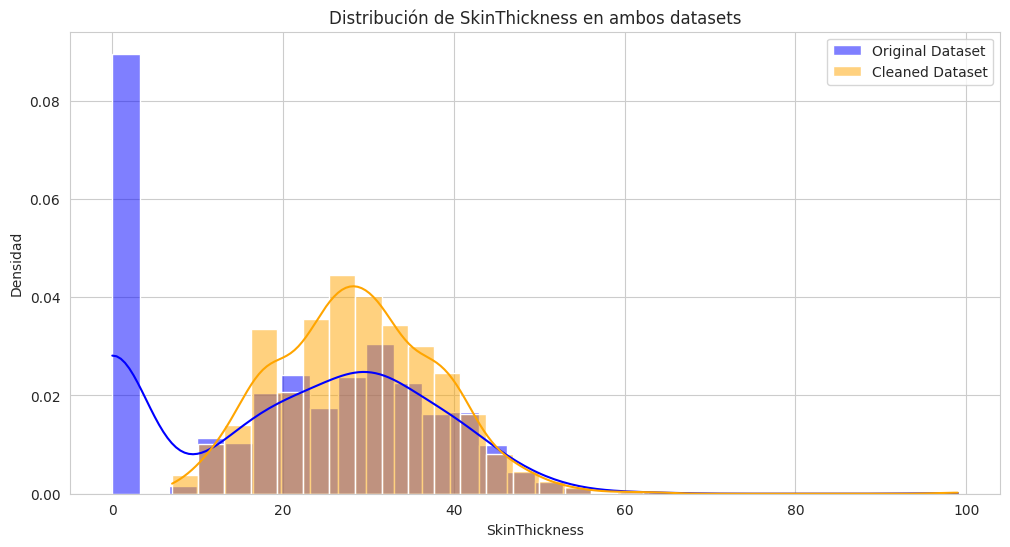

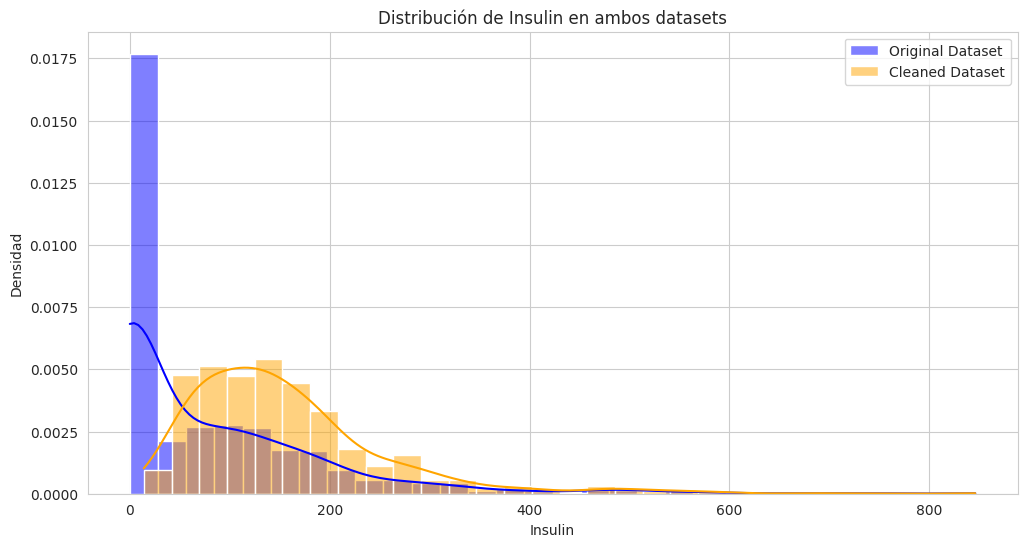

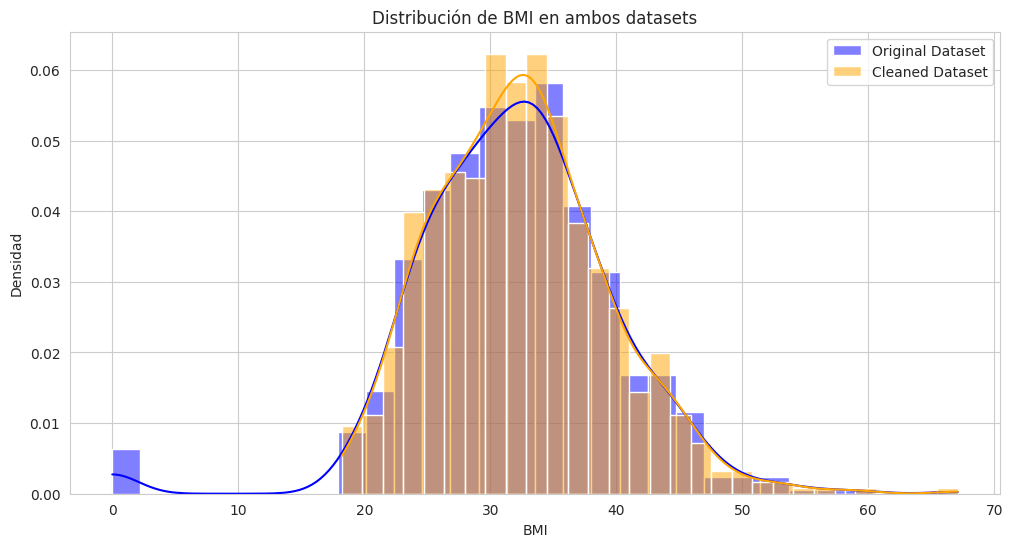

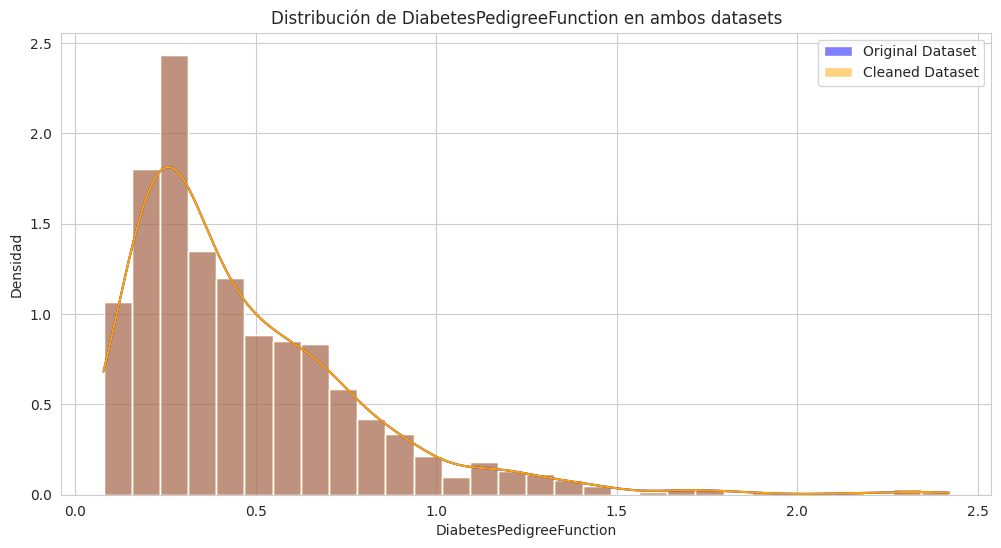

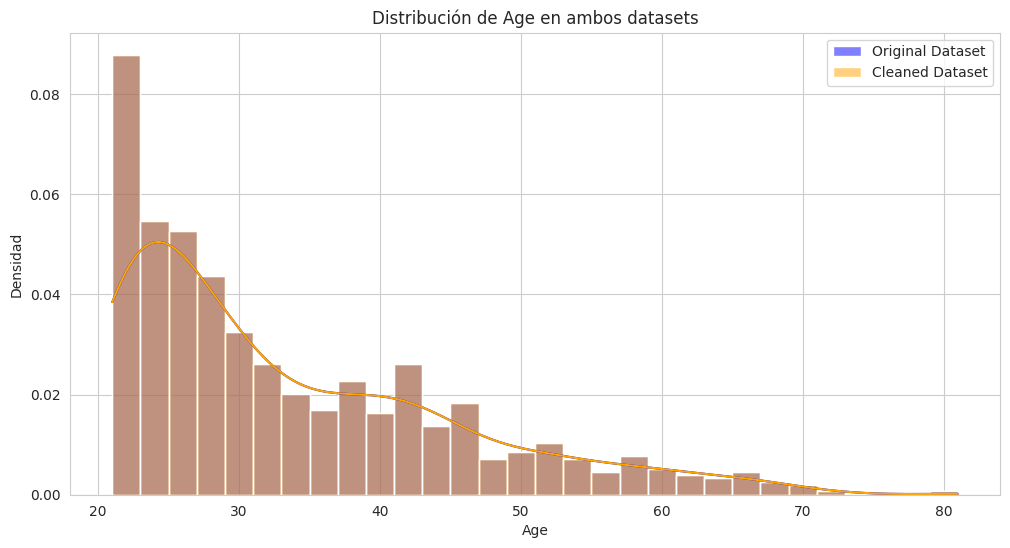

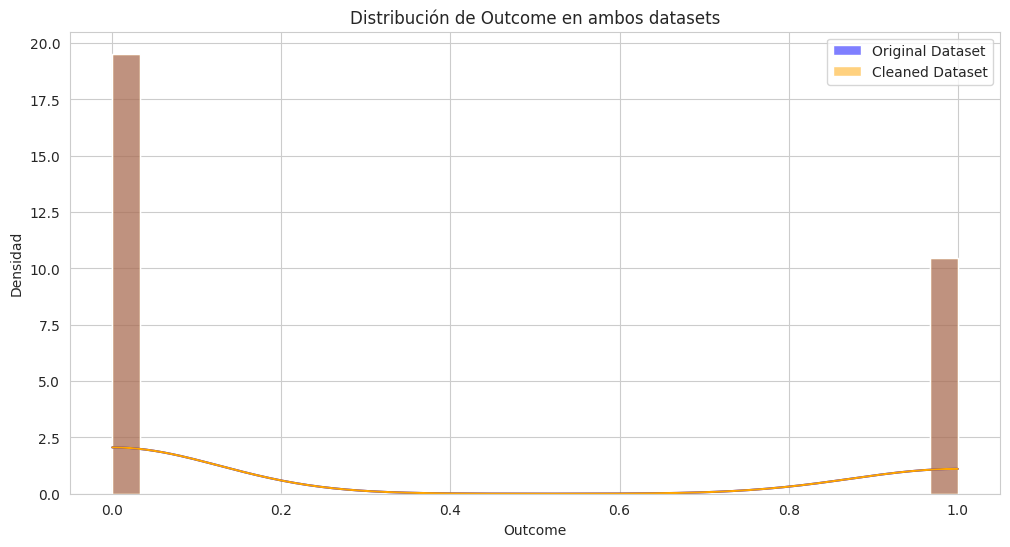

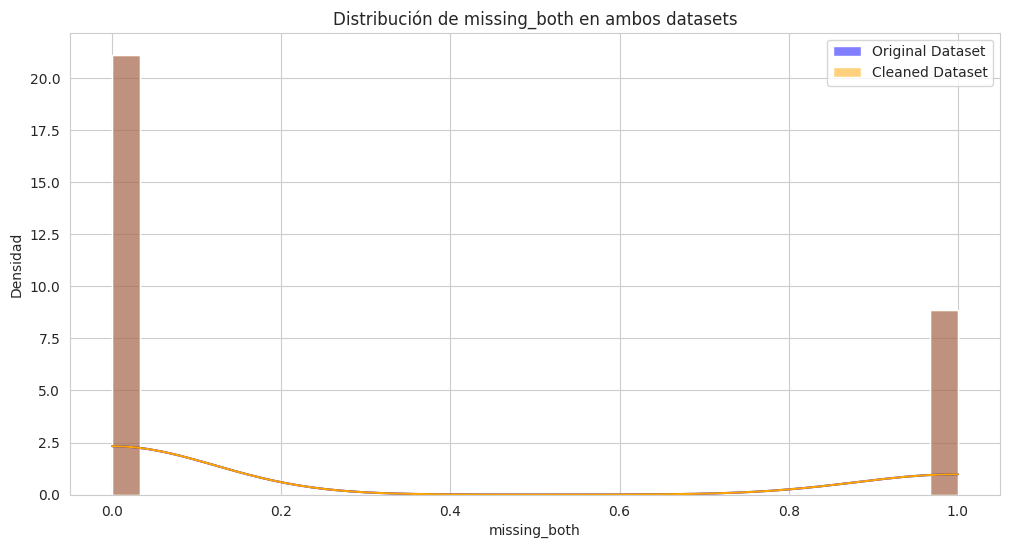

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de variables numéricas a comparar
variables = df.columns

# Crear gráficos para cada variable
for variable in variables:
    plt.figure(figsize=(12, 6))

    # Distribución en el dataset original
    sns.histplot(df[variable], kde=True, color='blue', label='Original Dataset', stat='density', bins=30)

    # Distribución en el dataset limpio
    sns.histplot(df_cleaned[variable], kde=True, color='orange', label='Cleaned Dataset', stat='density', bins=30)

    # Añadir título y leyenda
    plt.title(f'Distribución de {variable} en ambos datasets')
    plt.xlabel(variable)
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()


In [ ]:
# Verificar y eliminar la columna 'missing_both'
if 'missing_both' in df.columns:
    df.drop(columns=['missing_both'], inplace=True)

if 'missing_both' in df_cleaned.columns:
    df_cleaned.drop(columns=['missing_both'], inplace=True)


In [ ]:
print(df_cleaned.describe())
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      28.852713  157.002161   
std       3.369578   30.438286      12.096642       9.573208  102.416317   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      22.000000   87.797500   
50%       3.000000  117.000000      72.000000      28.536146  135.000000   
75%       6.000000  140.250000      80.000000      35.032540  192.220000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.450911                  0.471876   33.240885    0.348958  
std      6.875366                  0.331329   11.760232    0.476951  
min     18.200000                  

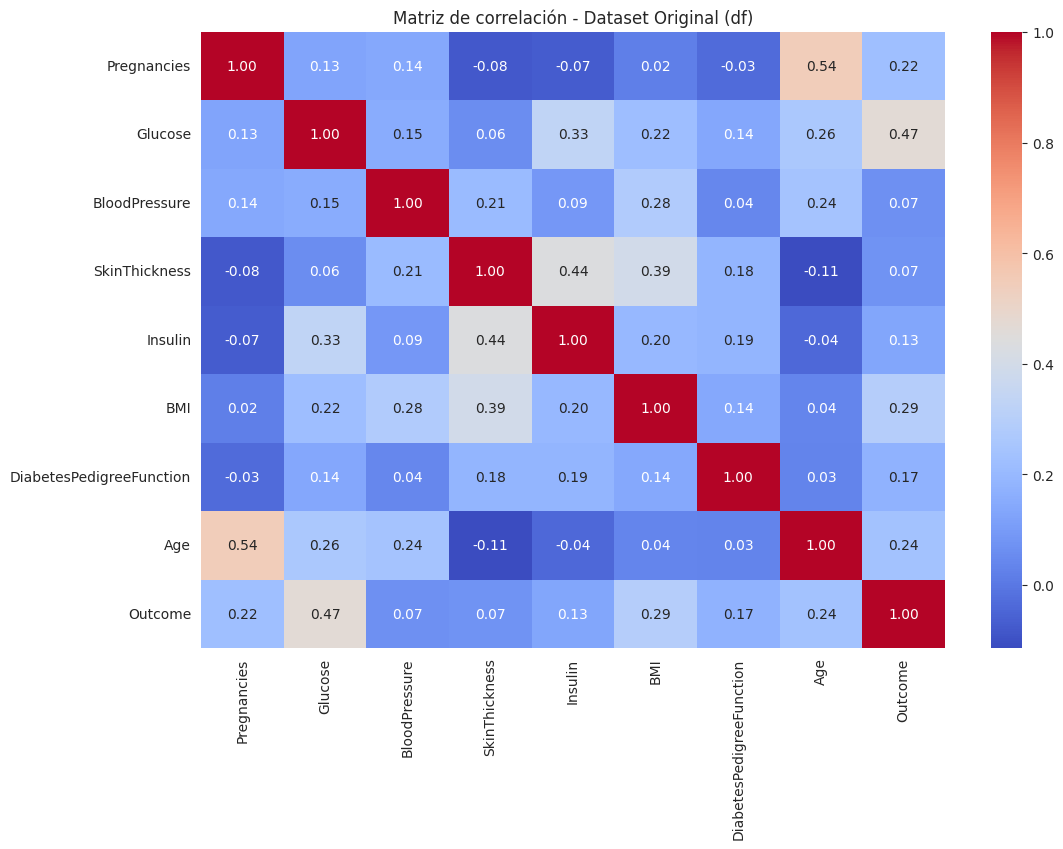

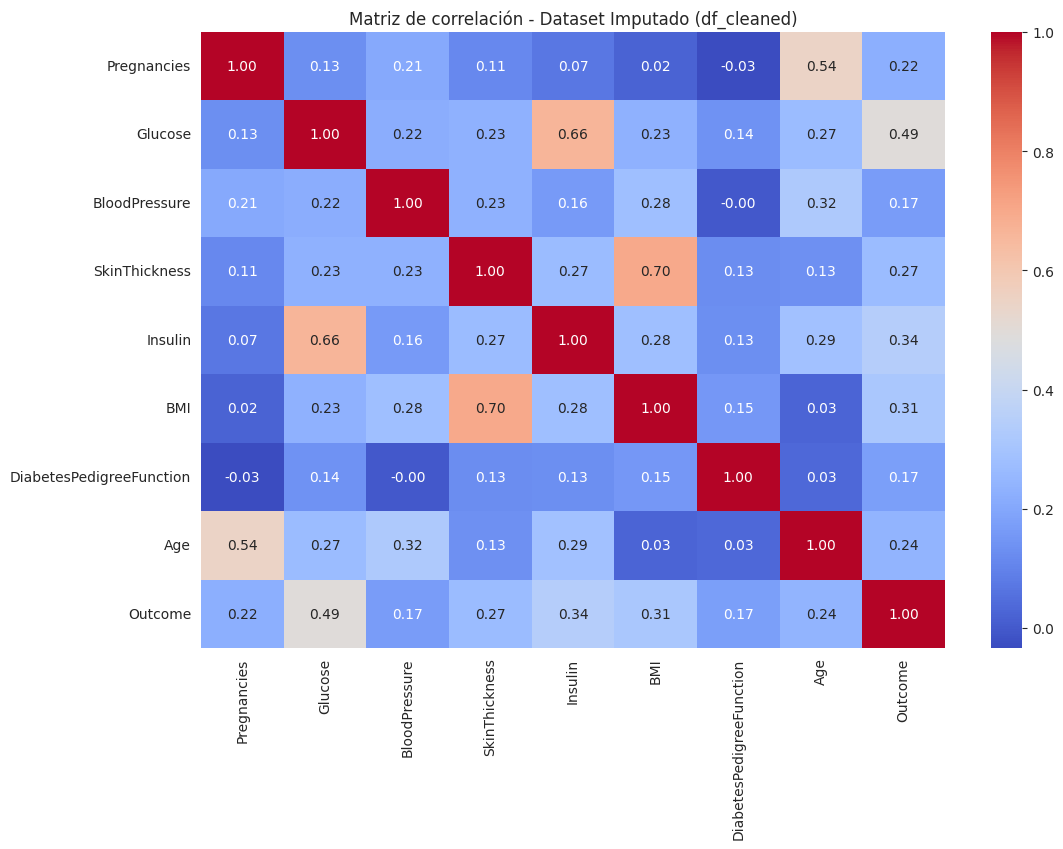

In [ ]:
# Calcular la matriz de correlación para el dataset original (df)
correlation_original = df.corr()

# Calcular la matriz de correlación para el dataset imputado (df_cleaned)
correlation_cleaned = df_cleaned.corr()

# Crear el mapa de calor para el dataset original
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_original, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación - Dataset Original (df)")
plt.show()

# Crear el mapa de calor para el dataset imputado
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_cleaned, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación - Dataset Imputado (df_cleaned)")
plt.show()

- Glucose, BloodPressure, y BMI fueron correctamente imputadas utilizando métodos simples como la mediana.
Las distribuciones son consistentes con los datos originales y no muestran sesgos significativos.

- Variables con modelos predictivos:
SkinThickness e Insulin han sido bien imputadas utilizando Random Forest:
Ambas variables muestran distribuciones naturales y consistentes con los datos válidos del dataset original.
Las colas largas características se han preservado, reflejando mejor la variabilidad esperada.

- Relaciones entre variables:
Las correlaciones entre variables relacionadas fisiológicamente (SkinThickness y BMI, Insulin y Glucose) ahora son más fuertes, lo cual es razonable tras la imputación.
Esto sugiere que el modelo predictivo utilizado para imputar estas variables capturó correctamente las relaciones subyacentes.
Las correlaciones entre otras variables (Pregnancies, Age, y Outcome) permanecen consistentes, lo que indica que la imputación no introdujo sesgos significativos en estas relaciones.

## Identificamos los outliers y decidimos cómo tratarlos

En este cuaderno, adoptamos una estrategia de eliminación directa de outliers como parte de un enfoque comparativo más amplio en nuestro análisis del conjunto de datos de diabetes de los Indios Pima. Esta estrategia implica la identificación y eliminación de valores atípicos utilizando el método del rango intercuartílico (IQR) para todas las variables numéricas relevantes.

Nuestro objetivo es crear un conjunto de datos "limpio" que excluya valores extremos, permitiéndonos evaluar cómo esta técnica de preprocesamiento afecta el rendimiento de nuestros modelos predictivos. Este enfoque constituye uno de los tres métodos que estamos explorando:

- Eliminación de outliers (el enfoque actual) - Cuaderno 1
- Mantenimiento de outliers sin cambios - Cuaderno 2 (este)
- Transformación de outliers (manteniendo todos los datos) - Cuaderno 3
- Transformación de outliers (creando características) - Cuaderno 4



Al implementar estos 4 enfoques en cuadernos separados, podremos comparar directamente cómo cada método de tratamiento de outliers impacta en la precisión y generalización de nuestros modelos. Esta comparación nos proporcionará insights valiosos sobre la robustez de diferentes algoritmos frente a valores atípicos y nos ayudará a determinar la estrategia más efectiva para este conjunto de datos específico.

Es importante destacar que, aunque la eliminación de outliers puede potencialmente resultar en la pérdida de información valiosa, este enfoque nos permite evaluar el trade-off entre la "limpieza" de los datos y la preservación de casos extremos pero potencialmente importantes en el contexto de la diabetes.

In [ ]:
# Seleccionar las columnas numéricas
nume_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Identificar outliers usando el rango intercuartílico (IQR)
outliers = {}
for var in nume_vars:
    Q1 = df_cleaned[var].quantile(0.25)
    Q3 = df_cleaned[var].quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los límites inferior y superior
    lower_bound = max(Q1 - 1.5 * IQR, 0)  # Ajustar el límite inferior a 0 si es negativo
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar outliers
    outliers[var] = df_cleaned[(df_cleaned[var] < lower_bound) | (df_cleaned[var] > upper_bound)][var]

    print(f"Límites para {var}:")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Número de outliers en {var}: {len(outliers[var])}")


Límites para Pregnancies:
Lower Bound: 0, Upper Bound: 13.5
Número de outliers en Pregnancies: 4
Límites para Glucose:
Lower Bound: 39.0, Upper Bound: 201.0
Número de outliers en Glucose: 0
Límites para BloodPressure:
Lower Bound: 40.0, Upper Bound: 104.0
Número de outliers en BloodPressure: 14
Límites para SkinThickness:
Lower Bound: 2.451190235569328, Upper Bound: 54.58134960738445
Número de outliers en SkinThickness: 4
Límites para Insulin:
Lower Bound: 0, Upper Bound: 348.85375
Número de outliers en Insulin: 36
Límites para BMI:
Lower Bound: 13.849999999999998, Upper Bound: 50.25
Número de outliers en BMI: 8
Límites para DiabetesPedigreeFunction:
Lower Bound: 0, Upper Bound: 1.2
Número de outliers en DiabetesPedigreeFunction: 29
Límites para Age:
Lower Bound: 0, Upper Bound: 66.5
Número de outliers en Age: 9


In [ ]:
print(df_cleaned.describe())
print(df_cleaned.head(10))
print(df_cleaned.info())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      28.852713  157.002161   
std       3.369578   30.438286      12.096642       9.573208  102.416317   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      22.000000   87.797500   
50%       3.000000  117.000000      72.000000      28.536146  135.000000   
75%       6.000000  140.250000      80.000000      35.032540  192.220000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.450911                  0.471876   33.240885    0.348958  
std      6.875366                  0.331329   11.760232    0.476951  
min     18.200000                  

No vamos a eliminar los outliers  pero vamos a hacer la trasnforamcion logaritmica de las variables que esten muy sesgadas hacia la derecha. De este modeo vamos a reducir el impacto de los valores extremos.

Vamos a hacer transformacion logaritmica para:
- Insulin: La distribución está altamente sesgada hacia la derecha, con una mediana mucho menor que la media y valores máximos extremadamente altos (846 mIU/L). Esto indica que hay valores extremos que podrían influir negativamente en el modelo.
- DiabetesPedigreeFunction: Aunque no es tan extrema como Insulin, esta variable también muestra una distribución sesgada hacia la derecha con valores máximos elevados (hasta 2.42). Una transformación logarítmica puede ayudar a estabilizar la varianza.
- SkinThickness: Aunque no es tan evidentemente sesgada como las anteriores, tiene valores mínimos de 0 y una distribución irregular.


          Insulin  DiabetesPedigreeFunction  SkinThickness
count  768.000000                768.000000     768.000000
mean     4.882897                  0.365317       3.341897
std      0.608252                  0.198510       0.340541
min      2.708050                  0.075107       2.079442
25%      4.486357                  0.218131       3.135494
50%      4.912655                  0.316633       3.385614
75%      5.263827                  0.486277       3.584421
max      6.741701                  1.229641       4.605170


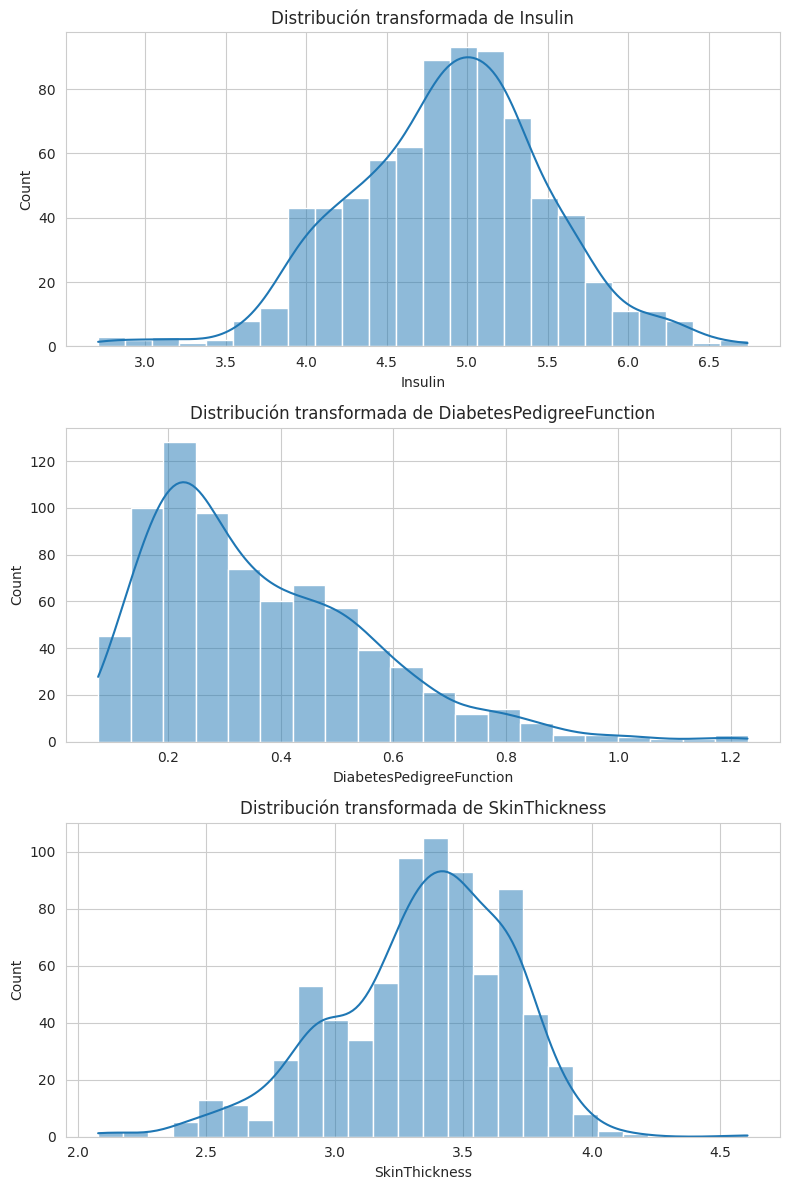

In [ ]:
# Crear una copia del DataFrame original para aplicar las transformaciones
df_trans = df_cleaned.copy()

# Transformación logarítmica para las variables sesgadas
variables_to_transform = ['Insulin', 'DiabetesPedigreeFunction', 'SkinThickness']

for var in variables_to_transform:
    # Aplicamos log1p para manejar valores cercanos a 0 (log1p es log(1 + x))
    df_trans[var] = np.log1p(df_trans[var])

# Imprimimos un resumen de las variables transformadas para verificar
print(df_trans[variables_to_transform].describe())

# Visualizamos nuevamente las distribuciones después de la transformación (opcional)
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(len(variables_to_transform), figsize=(8, 12))
for i, var in enumerate(variables_to_transform):
    sns.histplot(df_trans[var], kde=True, ax=axs[i])
    axs[i].set_title(f'Distribución transformada de {var}')
plt.tight_layout()
plt.show()


Las transformaciones logarítmicas han sido efectivas para preparar estas variables.

In [ ]:
# Crear una copia del DataFrame transformado para seguir trabajando
df_no_outliers = df_trans.copy()

---

A partir de este moomento vamos a trabajar con dos dataframes para evaluar los modelos.
1. Vamos a crear nuevas caraterísticas - df_with_features
2. No vamos a crear nuevas caracteristicas - df_no_outliers

En ambos haremos esto:
- Prepararemos los datos en X (variables predictoras) e y (variable objetivo).
- Dividiremos los datos en X_train, X_test, y_train, y_test utilizando train_test_split.
- Haremos la selección de características
- Escalado: Aplicaremos StandardScaler a las variables numéricas de X_train y X_test. Es crucial escalar después de la división para evitar data leakage. Usaremos únicamente X_train para calcular los parámetros del escalador (media y desviación estándar para StandardScaler). Utilizaremos el mismo escalador ajustado con X_train para transformar X_validation y X_test. Esto asegura que todos los conjuntos de datos se escalen de manera consistente, usando las estadísticas del conjunto de entrenamiento.
- Manejo del desbalance: Aplicaremos SMOTE (Synthetic Minority Over-sampling Technique) solo a X_train e y_train. Esto generará muestras sintéticas de la clase minoritaria para equilibrar el dataset. No aplicaremos SMOTE a los datos de prueba para mantener su distribución original. Este enfoque asegura que nuestro modelo se entrene con datos balanceados y escalados correctamente, mientras mantenemos un conjunto de prueba representativo de la distribución real del problema.

---

CREAMOS CARACTERISTICAS:

- Relación Glucosa/Insulina: Puede capturar la relación entre los niveles de glucosa e insulina, lo cual es relevante para el diagnóstico de diabetes.
- Producto de Glucosa e IMC: Relaciona los niveles de glucosa con el índice de masa corporal (IMC), lo cual puede ser útil para identificar riesgos metabólicos.
- Indicador de presión arterial alta: Es una característica categórica basada en un umbral médico (por ejemplo, presión arterial > 80 mmHg).
- Razón entre BMI y SkinThickness: Puede capturar información sobre la composición corporal y almacenamiento de grasa.
- Interacción entre Edad y Embarazos : La edad y el número de embarazos podrían combinarse para reflejar mejor el riesgo en mujeres.
- Indicador categórico basado en rangos de edad: Agrupar edades en categorías puede ser útil para capturar patrones específicos por grupos etarios.

In [ ]:
# Crear una copia del dataframe original
df_with_features = df_no_outliers.copy()

# Crear nuevas características
df_with_features['Glucose_Insulin_Ratio'] = df_with_features['Glucose'] / df_with_features['Insulin']
df_with_features['Glucose_BMI_Product'] = df_with_features['Glucose'] * df_with_features['BMI']
df_with_features['High_BP'] = (df_with_features['BloodPressure'] > 80).astype(int)
df_with_features['BMI_SkinThickness_Ratio'] = df_with_features['BMI'] / df_with_features['SkinThickness']
df_with_features['Age_Pregnancies_Interaction'] = df_with_features['Age'] * df_with_features['Pregnancies']

# Crear indicador categórico basado en rangos de edad
bins = [20, 30, 50, 100]  # Definir los rangos
labels = ['Young', 'Middle-aged', 'Older']
df_with_features['Age_Category'] = pd.cut(df_with_features['Age'], bins=bins, labels=labels)

# Verificar las primeras filas del nuevo dataframe
print(df_with_features.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin   BMI  \
0            6      148             72       3.583519  5.181109  33.6   
1            1       85             66       3.401197  3.954124  26.6   
2            8      183             64       2.953999  5.577047  23.3   
3            1       89             66       3.178054  4.553877  28.1   
4            0      137             40       3.583519  5.129899  43.1   

   DiabetesPedigreeFunction  Age  Outcome  Glucose_Insulin_Ratio  \
0                  0.486738   50        1              28.565312   
1                  0.300845   31        0              21.496543   
2                  0.514021   32        1              32.813064   
3                  0.154436   21        0              19.543787   
4                  1.190279   33        1              26.706180   

   Glucose_BMI_Product  High_BP  BMI_SkinThickness_Ratio  \
0               4972.8        0                 9.376259   
1               2261.0        0 

In [ ]:
# Preprocesamiento del dataframe con nuevas características
df_with_features_encoded = df_with_features.copy()

# Aplicar one-hot encoding a columnas categóricas ('Age_Category')
df_with_features_encoded = pd.get_dummies(df_with_features_encoded, columns=['Age_Category'], drop_first=True)

# Verificar las columnas resultantes y el DataFrame actualizado
print("Columnas después de one-hot encoding:", df_with_features_encoded.columns)
print("Primeras filas del DataFrame actualizado:")
print(df_with_features_encoded.head())

Columnas después de one-hot encoding: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'Glucose_Insulin_Ratio', 'Glucose_BMI_Product', 'High_BP',
       'BMI_SkinThickness_Ratio', 'Age_Pregnancies_Interaction',
       'Age_Category_Middle-aged', 'Age_Category_Older'],
      dtype='object')
Primeras filas del DataFrame actualizado:
   Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin   BMI  \
0            6      148             72       3.583519  5.181109  33.6   
1            1       85             66       3.401197  3.954124  26.6   
2            8      183             64       2.953999  5.577047  23.3   
3            1       89             66       3.178054  4.553877  28.1   
4            0      137             40       3.583519  5.129899  43.1   

   DiabetesPedigreeFunction  Age  Outcome  Glucose_Insulin_Ratio  \
0                  0.486738   50        1              28.565312

In [ ]:
# Convertir columnas booleanas a 0 y 1
boolean_columns = df_with_features_encoded.select_dtypes(include=['bool']).columns
df_with_features_encoded[boolean_columns] = df_with_features_encoded[boolean_columns].astype(int)

# Verificar el DataFrame después del preprocesamiento
print("Columnas después del preprocesamiento:", df_with_features_encoded.columns)
print("Primeras filas del DataFrame actualizado:")
print(df_with_features_encoded.head())

# Preparar X e y para la selección de características
X_with_features = df_with_features_encoded.drop('Outcome', axis=1)
y_with_features = df_with_features_encoded['Outcome']

print("X shape con nuevas características (preprocesado):", X_with_features.shape)
print("Preview of X con nuevas características (preprocesado):", X_with_features.head())

Columnas después del preprocesamiento: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'Glucose_Insulin_Ratio', 'Glucose_BMI_Product', 'High_BP',
       'BMI_SkinThickness_Ratio', 'Age_Pregnancies_Interaction',
       'Age_Category_Middle-aged', 'Age_Category_Older'],
      dtype='object')
Primeras filas del DataFrame actualizado:
   Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin   BMI  \
0            6      148             72       3.583519  5.181109  33.6   
1            1       85             66       3.401197  3.954124  26.6   
2            8      183             64       2.953999  5.577047  23.3   
3            1       89             66       3.178054  4.553877  28.1   
4            0      137             40       3.583519  5.129899  43.1   

   DiabetesPedigreeFunction  Age  Outcome  Glucose_Insulin_Ratio  \
0                  0.486738   50        1              28.56531

---

### SELECCIÓN DE CARACTERÍSTICAS:

- Dividimos primero los datos para evitar el data leakage. Si seleccionamos las características usando todo el conjunto de datos y luego lo dividimos, se estaría filtrando información del conjunto de prueba al de entrenamiento.

- La selección de características debe realizarse solo en el conjunto de entrenamiento para asegurar que el conjunto de prueba permanezca completamente independiente y no influya en el proceso de modelado.

- Utilizaremos varios métodos de selección de características. Estos métodos se pueden clasificar en tres categorías principales:

  - Métodos de filtrado: Estos métodos seleccionan características basándose en medidas estadísticas, sin utilizar ningún modelo de aprendizaje.
    - Correlación de Pearson: Este método mide la correlación lineal entre cada característica y la variable objetivo. Las características con mayor correlación absoluta se consideran más importantes.
    - Información mutua: Utiliza la función mutual_info_classif para medir la dependencia entre cada característica y la variable objetivo. Se seleccionan las 10 características con mayor información mutua.
    - Chi-cuadrado: Este método es especialmente útil para características categóricas. Se utiliza SelectKBest con la función chi2 para seleccionar las 10 mejores características según esta prueba estadística.
  - Métodos de envoltura: Estos métodos utilizan un modelo de aprendizaje automático para evaluar subconjuntos de características.
    - Eliminación de características recursivas (RFE): Este método utiliza un modelo (en este caso, RandomForestClassifier) para eliminar recursivamente las características menos importantes hasta que queden solo 10.
  - Métodos incorporados: Estos métodos realizan la selección de características como parte del proceso de entrenamiento del modelo.
    - LASSO (Least Absolute Shrinkage and Selection Operator): Este método de regularización L1 puede reducir algunos coeficientes a cero, efectivamente seleccionando características. Las características con coeficientes no nulos son seleccionadas.
    - Importancia de características en Random Forest: Este método utiliza la importancia de características inherente al algoritmo Random Forest. Se seleccionan las 10 características más importantes según este criterio.


Cada uno de estos métodos proporciona una perspectiva diferente sobre la importancia de las características, lo que permite una selección más robusta y completa para el modelo final.

A continuación realizaremos un análisis de la frecuencia de las características seleccionadas por los diferentes métodos de selección de características. Escogeremos las características que han sido seleccionadas como más importantes por al menos 3 metodos de selección.

### Selección de características para el dataframe sin nuevas características (df_no_outliers)

In [ ]:
# Preparar X e y para el dataframe sin nuevas características
X_no_features = df_no_outliers.drop('Outcome', axis=1)
y_no_features = df_no_outliers['Outcome']

print("X shape:", X_no_features.shape)
print("Preview of X:", X_no_features.head())

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_no_features, y_no_features, test_size=0.3, random_state=42, stratify=y_no_features)

# Métodos de filtrado:
# 1. Correlación de Pearson
corr_features = X_train.corrwith(y_train).abs().sort_values(ascending=False)

# 2. Información Mutua
mi_selector = SelectKBest(mutual_info_classif, k=10)
mi_selector.fit(X_train, y_train)
mi_features = X_train.columns[mi_selector.get_support()]

# 3. Chi-cuadrado (requiere valores no negativos)
chi2_selector = SelectKBest(chi2, k=10)
X_train_non_negative = X_train.clip(lower=0)  # Asegurarse de que no haya valores negativos
chi2_selector.fit(X_train_non_negative, y_train)
chi2_features = X_train.columns[chi2_selector.get_support()]

# Métodos de envoltura:
# 4. Eliminación de características recursivas (RFE) con Random Forest
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_features = X_train.columns[rfe_selector.support_]

# Métodos incorporados:
# 5. LASSO (Regularización L1)
lasso = Lasso(alpha=0.1, random_state=42)  # Ajustar alpha según sea necesario
lasso.fit(X_train, y_train)
lasso_features = X_train.columns[lasso.coef_ != 0]

# 6. Importancia de características en Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_features = X_train.columns[rf.feature_importances_.argsort()[::-1][:10]]

# Imprimir las características seleccionadas por cada método
print("Pearson Correlation:", list(corr_features.index[:10]))
print("Mutual Information:", list(mi_features))
print("Chi-square:", list(chi2_features))
print("RFE:", list(rfe_features))
print("LASSO:", list(lasso_features))
print("Random Forest:", list(rf_features))

# Analizar la frecuencia de las características seleccionadas por los diferentes métodos
all_features = (
    list(corr_features.index[:10]) +
    list(mi_features) +
    list(chi2_features) +
    list(rfe_features) +
    list(lasso_features) +
    list(rf_features)
)

feature_counts = Counter(all_features)

print("\nFrecuencia de características seleccionadas:")
for feature, count in feature_counts.most_common():
    print(f"{feature}: {count}")


X shape: (768, 8)
Preview of X:    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin   BMI  \
0            6      148             72       3.583519  5.181109  33.6   
1            1       85             66       3.401197  3.954124  26.6   
2            8      183             64       2.953999  5.577047  23.3   
3            1       89             66       3.178054  4.553877  28.1   
4            0      137             40       3.583519  5.129899  43.1   

   DiabetesPedigreeFunction  Age  
0                  0.486738   50  
1                  0.300845   31  
2                  0.514021   32  
3                  0.154436   21  
4                  1.190279   33  
Pearson Correlation: ['Glucose', 'Insulin', 'BMI', 'SkinThickness', 'Pregnancies', 'Age', 'BloodPressure', 'DiabetesPedigreeFunction']
Mutual Information: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Chi-square: ['Pregnancies', 'Glucose', 'BloodPress

### Selección de características para el dataframe con nuevas características (df_with_features_encoded)

In [ ]:

# Preparar X e y para el dataframe con nuevas características
X_with_features = df_with_features_encoded.drop('Outcome', axis=1)
y_with_features = df_with_features_encoded['Outcome']

print("X shape con nuevas características:", X_with_features.shape)
print("Preview of X con nuevas características:", X_with_features.head())

# Dividir los datos en entrenamiento y prueba
X_train_with_features, X_test_with_features, y_train_with_features, y_test_with_features = train_test_split(
    X_with_features, y_with_features, test_size=0.3, random_state=42, stratify=y_with_features)

# Métodos de filtrado:
# 1. Correlación de Pearson
corr_features_with_features = X_train_with_features.corrwith(y_train_with_features).abs().sort_values(ascending=False)

# 2. Información Mutua
mi_selector_with_features = SelectKBest(mutual_info_classif, k=10)
mi_selector_with_features.fit(X_train_with_features, y_train_with_features)
mi_features_with_features = X_train_with_features.columns[mi_selector_with_features.get_support()]

# 3. Chi-cuadrado (requiere valores no negativos)
chi2_selector_with_features = SelectKBest(chi2, k=10)
X_train_non_negative_with_features = X_train_with_features.clip(lower=0)  # Asegurarse de que no haya valores negativos
chi2_selector_with_features.fit(X_train_non_negative_with_features, y_train_with_features)
chi2_features_with_features = X_train_with_features.columns[chi2_selector_with_features.get_support()]

# Métodos de envoltura:
# 4. Eliminación de características recursivas (RFE) con Random Forest
rfe_selector_with_features = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe_selector_with_features.fit(X_train_with_features, y_train_with_features)
rfe_features_with_features = X_train_with_features.columns[rfe_selector_with_features.support_]

# Métodos incorporados:
# 5. LASSO (Regularización L1)
lasso_with_features = Lasso(alpha=0.1, random_state=42)  # Ajustar alpha según sea necesario
lasso_with_features.fit(X_train_with_features, y_train_with_features)
lasso_features_with_features = X_train_with_features.columns[lasso_with_features.coef_ != 0]

# 6. Importancia de características en Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_with_features, y_train_with_features)
rf_feature_importances = rf_classifier.feature_importances_
rf_top_10_indices = rf_feature_importances.argsort()[::-1][:10]
rf_top_10_columns = X_train_with_features.columns[rf_top_10_indices]

# Imprimir las características seleccionadas por cada método
print("Pearson Correlation:", list(corr_features_with_features.index[:10]))
print("Mutual Information:", list(mi_features_with_features))
print("Chi-square:", list(chi2_features_with_features))
print("RFE:", list(rfe_features_with_features))
print("LASSO:", list(lasso_features_with_features))
print("Random Forest:", list(rf_top_10_columns))

# Analizar la frecuencia de las características seleccionadas por los diferentes métodos
all_selected_newfeatures = (
    list(corr_features_with_features.index[:10]) +
    list(mi_features_with_features) +
    list(chi2_features_with_features) +
    list(rfe_features_with_features) +
    list(lasso_features_with_features) +
    list(rf_top_10_columns)
)

feature_counts_newfeatures = Counter(all_selected_newfeatures)

print("\nFrecuencia de características seleccionadas:")
for feature, count in feature_counts_newfeatures.most_common():
    print(f"{feature}: {count}")


X shape con nuevas características: (768, 15)
Preview of X con nuevas características:    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin   BMI  \
0            6      148             72       3.583519  5.181109  33.6   
1            1       85             66       3.401197  3.954124  26.6   
2            8      183             64       2.953999  5.577047  23.3   
3            1       89             66       3.178054  4.553877  28.1   
4            0      137             40       3.583519  5.129899  43.1   

   DiabetesPedigreeFunction  Age  Glucose_Insulin_Ratio  Glucose_BMI_Product  \
0                  0.486738   50              28.565312               4972.8   
1                  0.300845   31              21.496543               2261.0   
2                  0.514021   32              32.813064               4263.9   
3                  0.154436   21              19.543787               2500.9   
4                  1.190279   33              26.706180               5904

- En ambos casos, las variables originales como Glucose, BMI, y Age son seleccionadas consistentemente por todos los métodos.

  Esto muestra que estas variables son esenciales independientemente de si se crean nuevas características o no.


- En el dataframe con nuevas características, las interacciones (Glucose_BMI_Product, Age_Pregnancies_Interaction) tienen una alta frecuencia de selección, lo que indica que aportan valor adicional al modelo.

  Algunas variables originales como Pregnancies tienen menor relevancia en el dataframe con nuevas características (solo seleccionada por un método).

1. Para el dataframe (df_no_outliers) que no tiene características nuevas vamos a setablecer un límite de selección por al menos 5 métodos. Esto asegurará que mantengamoss las características fundamentales y relevantes para el modelo.
2. Para el dataframe con nuevas características (df_with_features_encoded) estableceremos un límite de selección por al menos 4 métodos. Esto permitirá incluir las nuevas características relevantes junto con las variables originales importantes, sin perder información valiosa.

In [ ]:
# Definir umbral para seleccionar las características finales en df_no_outliers(seleccionadas por al menos 5 métodos)
selected_features_no_outliers = [feature for feature, count in feature_counts.items() if count >= 5]

X_selected_no_outliers = df_no_outliers[selected_features_no_outliers]
y_selected_no_outliers = df_no_outliers['Outcome']

# Verificar el nuevo conjunto de datos
print("Características seleccionadas (sin nuevas características):", selected_features_no_outliers)
print("Shape del nuevo conjunto:", X_selected_no_outliers.shape)
print("Primeras filas del nuevo conjunto:")
print(X_selected_no_outliers.head())


Características seleccionadas (sin nuevas características): ['Glucose', 'Insulin', 'BMI', 'SkinThickness', 'Pregnancies', 'Age', 'BloodPressure', 'DiabetesPedigreeFunction']
Shape del nuevo conjunto: (768, 8)
Primeras filas del nuevo conjunto:
   Glucose   Insulin   BMI  SkinThickness  Pregnancies  Age  BloodPressure  \
0      148  5.181109  33.6       3.583519            6   50             72   
1       85  3.954124  26.6       3.401197            1   31             66   
2      183  5.577047  23.3       2.953999            8   32             64   
3       89  4.553877  28.1       3.178054            1   21             66   
4      137  5.129899  43.1       3.583519            0   33             40   

   DiabetesPedigreeFunction  
0                  0.486738  
1                  0.300845  
2                  0.514021  
3                  0.154436  
4                  1.190279  


In [ ]:
# Definir umbral para seleccionar las características finales en df_with_features(seleccionadas por al menos 4 métodos)
selected_features_with_features = [feature for feature, count in feature_counts_newfeatures.items() if count >= 4]

X_selected_with_features = df_with_features_encoded[selected_features_with_features]
y_selected_with_features = df_with_features_encoded['Outcome']

# Verificar el nuevo conjunto de datos
print("Características seleccionadas (con nuevas características):", selected_features_with_features)
print("Shape del nuevo conjunto:", X_selected_with_features.shape)
print("Primeras filas del nuevo conjunto:")
print(X_selected_with_features.head())


Características seleccionadas (con nuevas características): ['Glucose_BMI_Product', 'Glucose', 'Insulin', 'Glucose_Insulin_Ratio', 'BMI', 'SkinThickness', 'BMI_SkinThickness_Ratio', 'Age_Pregnancies_Interaction', 'Age']
Shape del nuevo conjunto: (768, 9)
Primeras filas del nuevo conjunto:
   Glucose_BMI_Product  Glucose   Insulin  Glucose_Insulin_Ratio   BMI  \
0               4972.8      148  5.181109              28.565312  33.6   
1               2261.0       85  3.954124              21.496543  26.6   
2               4263.9      183  5.577047              32.813064  23.3   
3               2500.9       89  4.553877              19.543787  28.1   
4               5904.7      137  5.129899              26.706180  43.1   

   SkinThickness  BMI_SkinThickness_Ratio  Age_Pregnancies_Interaction  Age  
0       3.583519                 9.376259                          300   50  
1       3.401197                 7.820775                           31   31  
2       2.953999               

---

# ENTRENAMIENTO DE MODELOS

La estrategia que seguiré en este paso de entrenamiento es la siguiente:

- Entrenaremos varios modelos de aprendizaje automático utilizando la división de los datos en entrenamiento y prueba. Evaluaremos los resultados obtenidos y escogeremos el modelo que mejores resultados presente. Una vez escogido el modelo ganador, repetiremos el entrenamiento en este modelo aplicando validación cruzada (cross-validation). De esta manera, los resultados serán más robustos y más representativos del rendimiento real del modelo en datos no vistos.

Vamos a entrenar los siguientes modelos:

- Regresión Logística: Aunque no es inherentemente robusto frente a outliers, su simplicidad permite identificar rápidamente patrones generales en los datos. Además, puede servir como punto de comparación para evaluar la efectividad de los modelos más complejos.
- Random Forest: Robusto ante outliers y capaz de capturar relaciones no lineales. Gradient Boosting: Potente en la captura de patrones complejos y generalmente ofrece alto rendimiento.
- Support Vector Machines (SVM) con kernel no lineal: Eficaz en la separación de clases en espacios de alta dimensión.
- XGBoost: Conocido por su alto rendimiento en una variedad de problemas de clasificación.
- Red Neuronal: Capaz de aprender representaciones complejas de los datos. Esta variedad de modelos nos permitirá explorar diferentes enfoques y determinar cuál se adapta mejor a la estructura y características de nuestros datos de Framingham.


Además vamos a probar diferentes estrategias.
- Entrenaminto sin reducción de la dimensionalidad
- PCA para reducir la dimensión de los datos
- Selección de características con Random Forest
- PCA + Selección de características con Random Forest
- Otras tecnicas de balanceo de clases como : SMOTETomek, Adasy y Borderline-SMOTE


## 1. PRIMER ENTRENAMIENTO SIN PCA, NI SELECCION DE CARACTERISTICAS
- División de datos: Usando train_test_split, con un 70% para entrenamiento y 30% para prueba.
- Escalado de datos: Utilizamos StandardScaler para estandarizar las características, ajustando el escalador con X_train y transformando tanto X_train como X_test.
- Balanceo de clases con SMOTE: Aplicamos SMOTE al conjunto de entrenamiento escalado (X_train_scaled) para generar nuevas muestras sintéticas de la clase minoritaria, obteniendo X_train_smote y y_train_smote.

Definición de modelos:

Entrenamiento y evaluación de modelos: Se entrena cada modelo con los datos balanceados (X_train_smote, y_train_smote). Se realizan predicciones en el conjunto de prueba escalado (X_test_scaled).

Se calculan las métricas de evaluación: Reporte de clasificación (classification_report) Matriz de confusión (confusion_matrix) Curva ROC y AUC (roc_curve, auc)

Visualización de resultados: Generamos gráficos de matrices de confusión para cada modelo usando seaborn. Graficamos las curvas ROC para todos los modelos en una sola figura.
Por último comparamos las métricas de precisión, recall y f1-score para la clase positiva (1) entre los modelos, y se representan en un gráfico de barras.

## df_no_outlieres


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       150
           1       0.63      0.68      0.65        81

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       150
           1       0.64      0.69      0.66        81

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.73       231
weighted avg       0.76      0.75      0.76       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       150
           1 

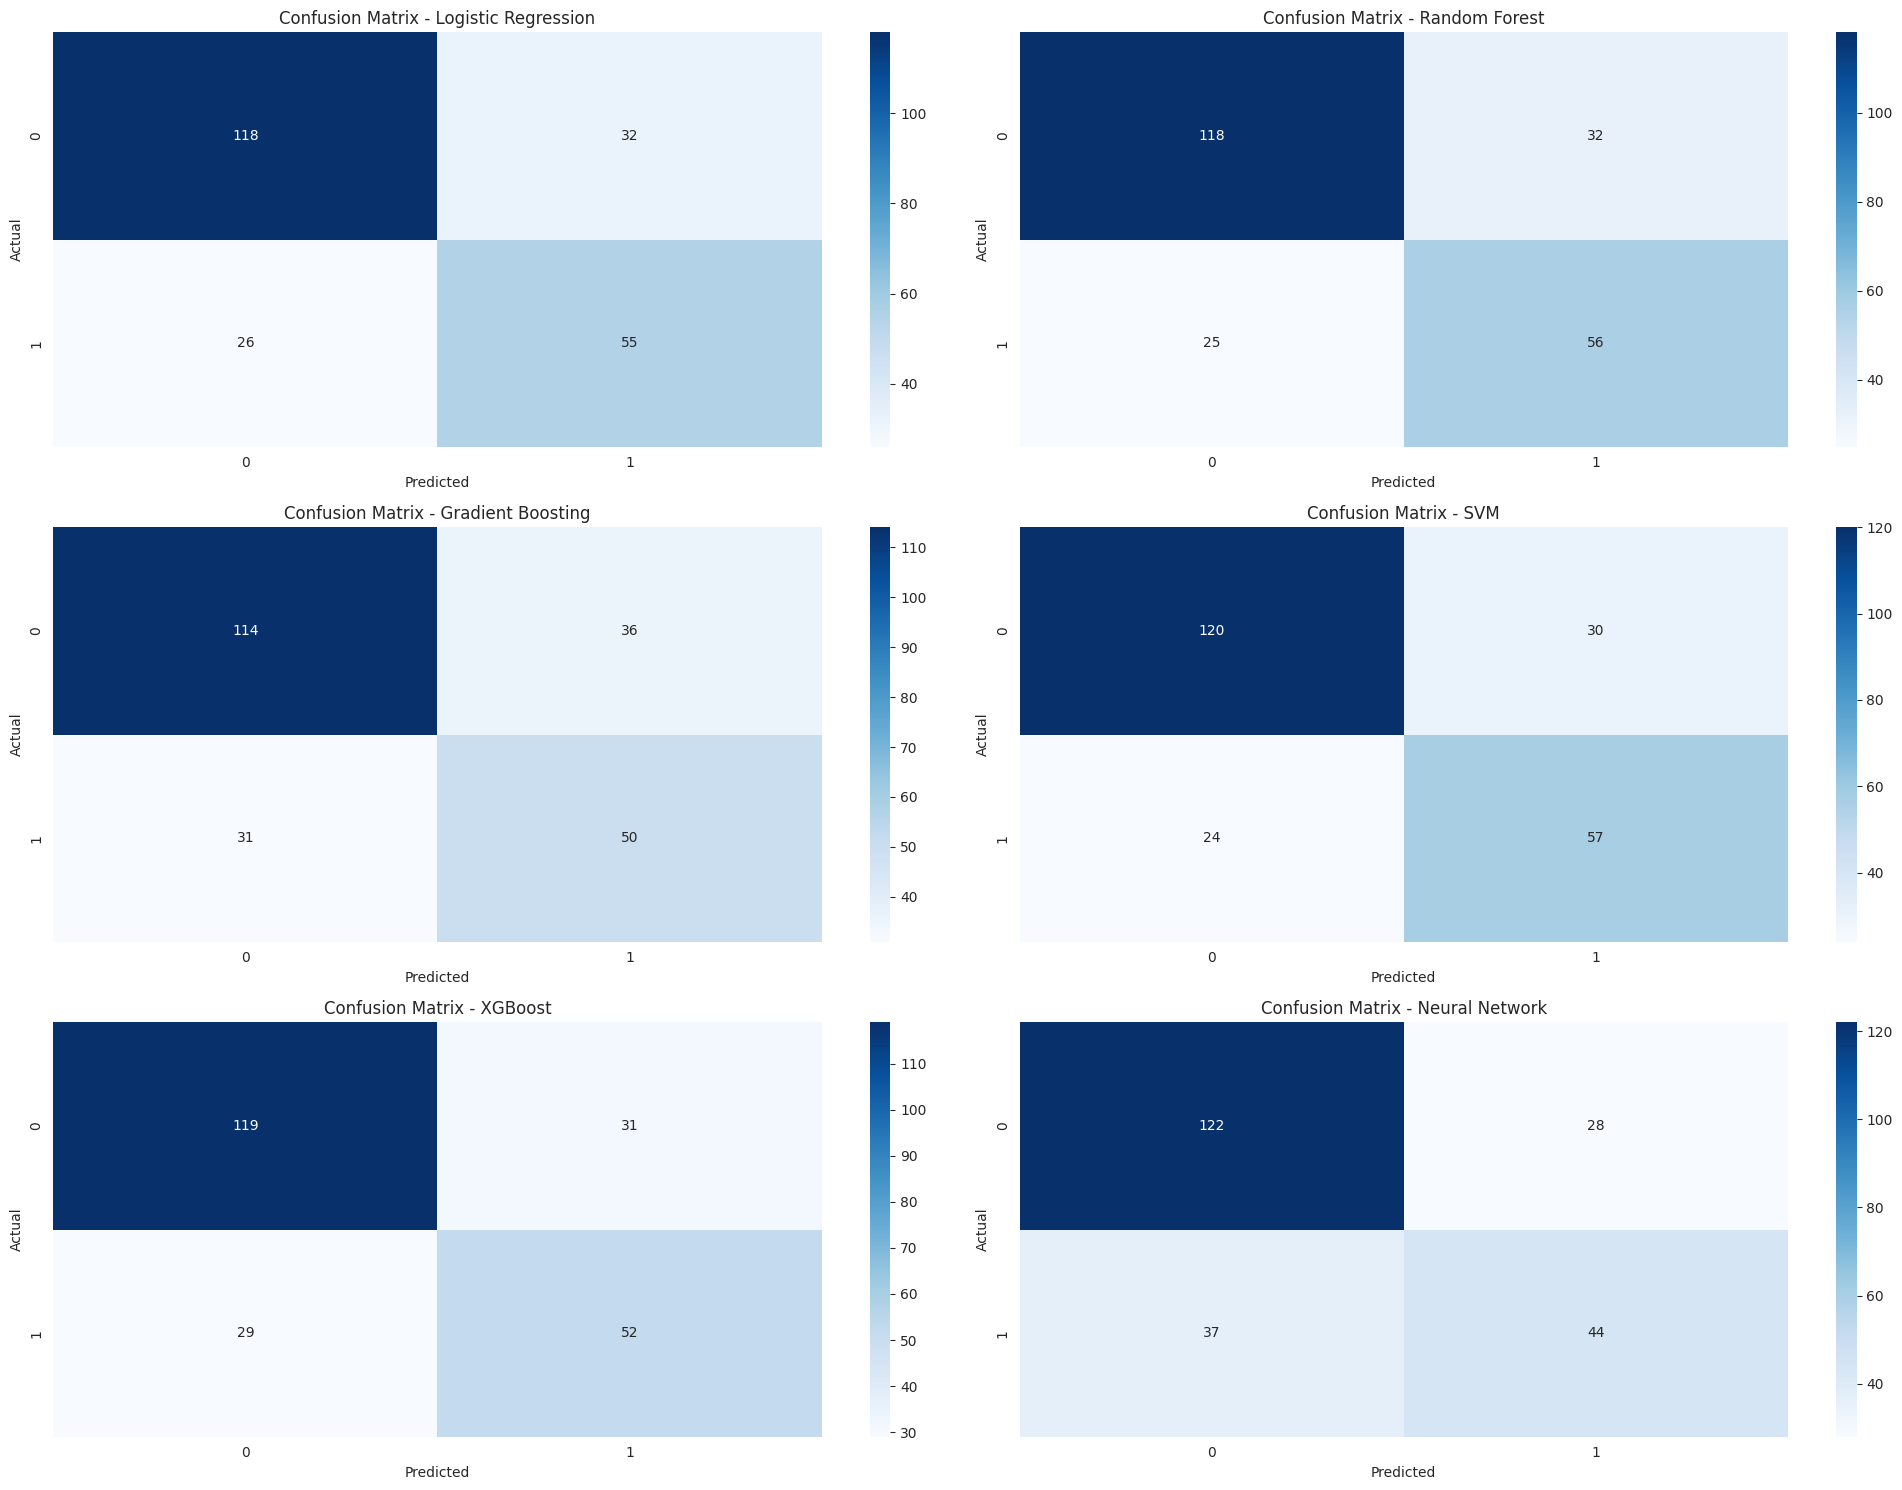

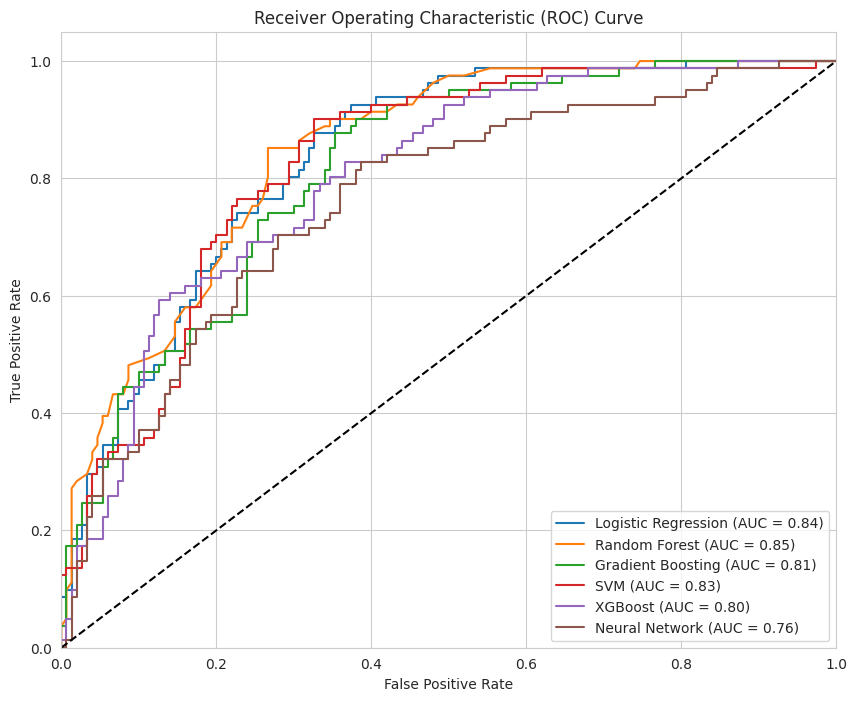

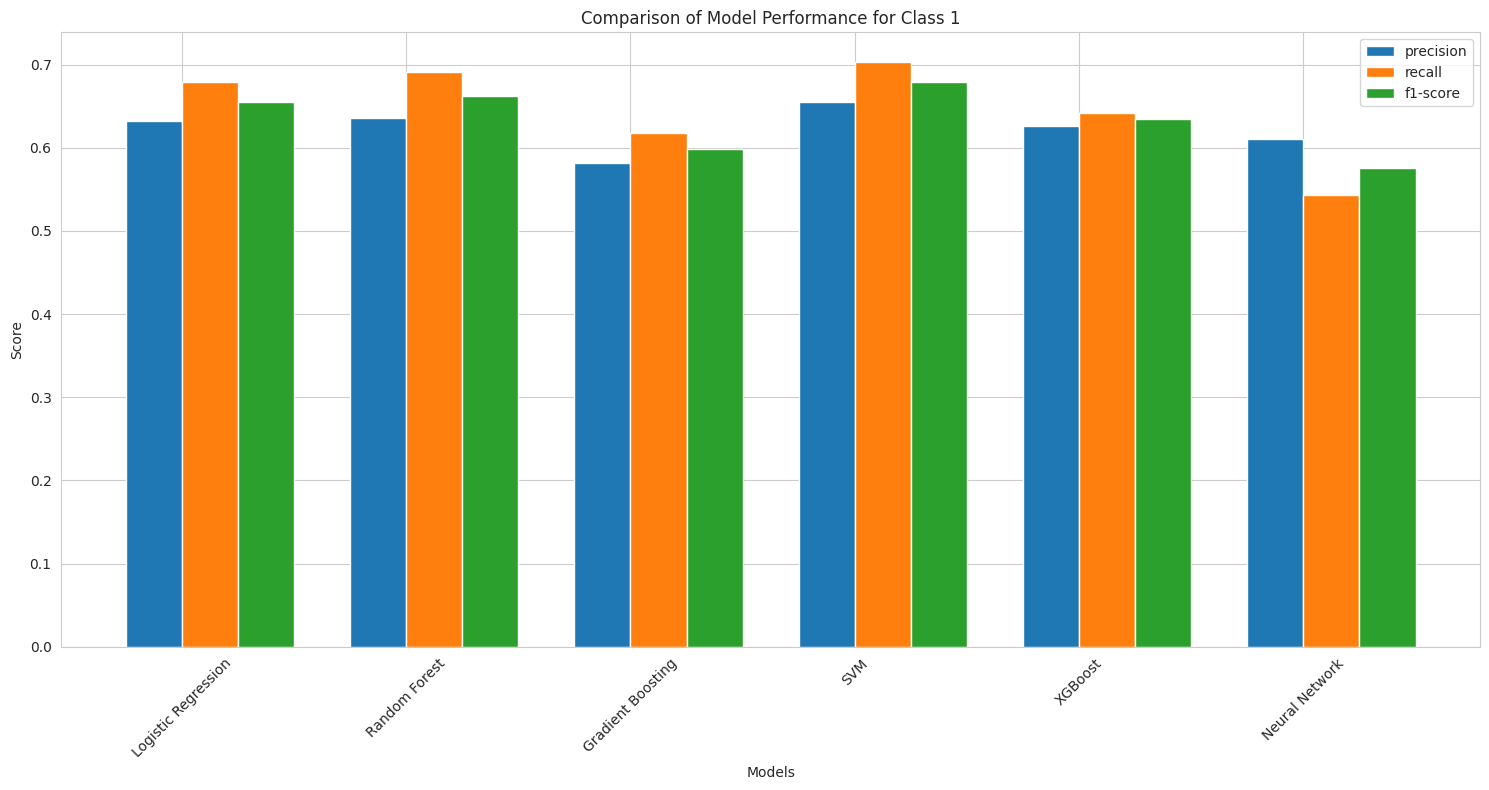

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Preparar los datos: X e y ya definidos como X_selected_no_outliers y y_selected_no_outliers

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_no_outliers, y_selected_no_outliers,
    test_size=0.3, random_state=42, stratify=y_selected_no_outliers
)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 5. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 6. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    else:
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'roc_auc': None
        }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas (Precision/Recall/F1-score para clase positiva)
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### 1. **Comparación general de desempeño**
- **Random Forest** y **SVM** destacan como los modelos con mejor desempeño en términos de precisión, recall y f1-score para la clase minoritaria (Clase 1). Ambos obtienen una precisión cercana al 0.83 para la clase mayoritaria (Clase 0) y un f1-score alrededor de 0.66-0.68 para la clase minoritaria.
- **Neural Network** muestra el desempeño más bajo en términos generales, especialmente en la clase minoritaria (Clase 1), con un f1-score de apenas 0.58 y un AUC de 0.76.

---

### 2. **Análisis basado en las métricas**
#### **Precisión**
- La precisión para la clase minoritaria (Clase 1) es más alta en SVM (0.66) y Random Forest (0.64), lo que indica que estos modelos son mejores para evitar falsos positivos.
  
#### **Recall**
- El recall más alto para la clase minoritaria lo obtiene SVM (0.70), seguido por Random Forest (0.69). Esto significa que estos modelos son más efectivos en identificar correctamente los casos positivos.

#### **F1-Score**
- El f1-score, que equilibra precisión y recall, es mejor en SVM (0.68) y Random Forest (0.66), lo que confirma su capacidad equilibrada para manejar la clase minoritaria.

---

### 3. **Curvas ROC y AUC**
- Los modelos con mayor área bajo la curva ROC (AUC) son Random Forest (AUC = 0.85) y Logistic Regression (AUC = 0.84), lo que indica una buena capacidad discriminativa entre las clases.
- Neural Network tiene el AUC más bajo (AUC = 0.76), lo que refleja su menor desempeño en este problema.

---

### 4. **Confusion Matrices**
- Los modelos Random Forest, Logistic Regression, y SVM tienen menos falsos negativos para la clase minoritaria, lo que refuerza su efectividad en identificar correctamente los casos positivos.
- Neural Network tiene el mayor número de falsos negativos para la clase minoritaria, lo que reduce su utilidad en este contexto.

---

### 5. **Conclusión final**
- Si el objetivo principal es maximizar el desempeño sobre la clase minoritaria (Clase 1), el modelo **SVM** parece ser la mejor opción debido a su alto recall y f1-score junto con un buen AUC.
- Si se busca un modelo más equilibrado entre ambas clases, **Random Forest** también es una excelente alternativa.
- SVM tiene el mayor recall para la clase positiva, con un valor de 0.70.
Random Forest sigue de cerca con un recall de 0.69.

---



### df_with_features


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       150
           1       0.59      0.70      0.64        81

    accuracy                           0.72       231
   macro avg       0.70      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       150
           1       0.63      0.68      0.65        81

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       150
           1 

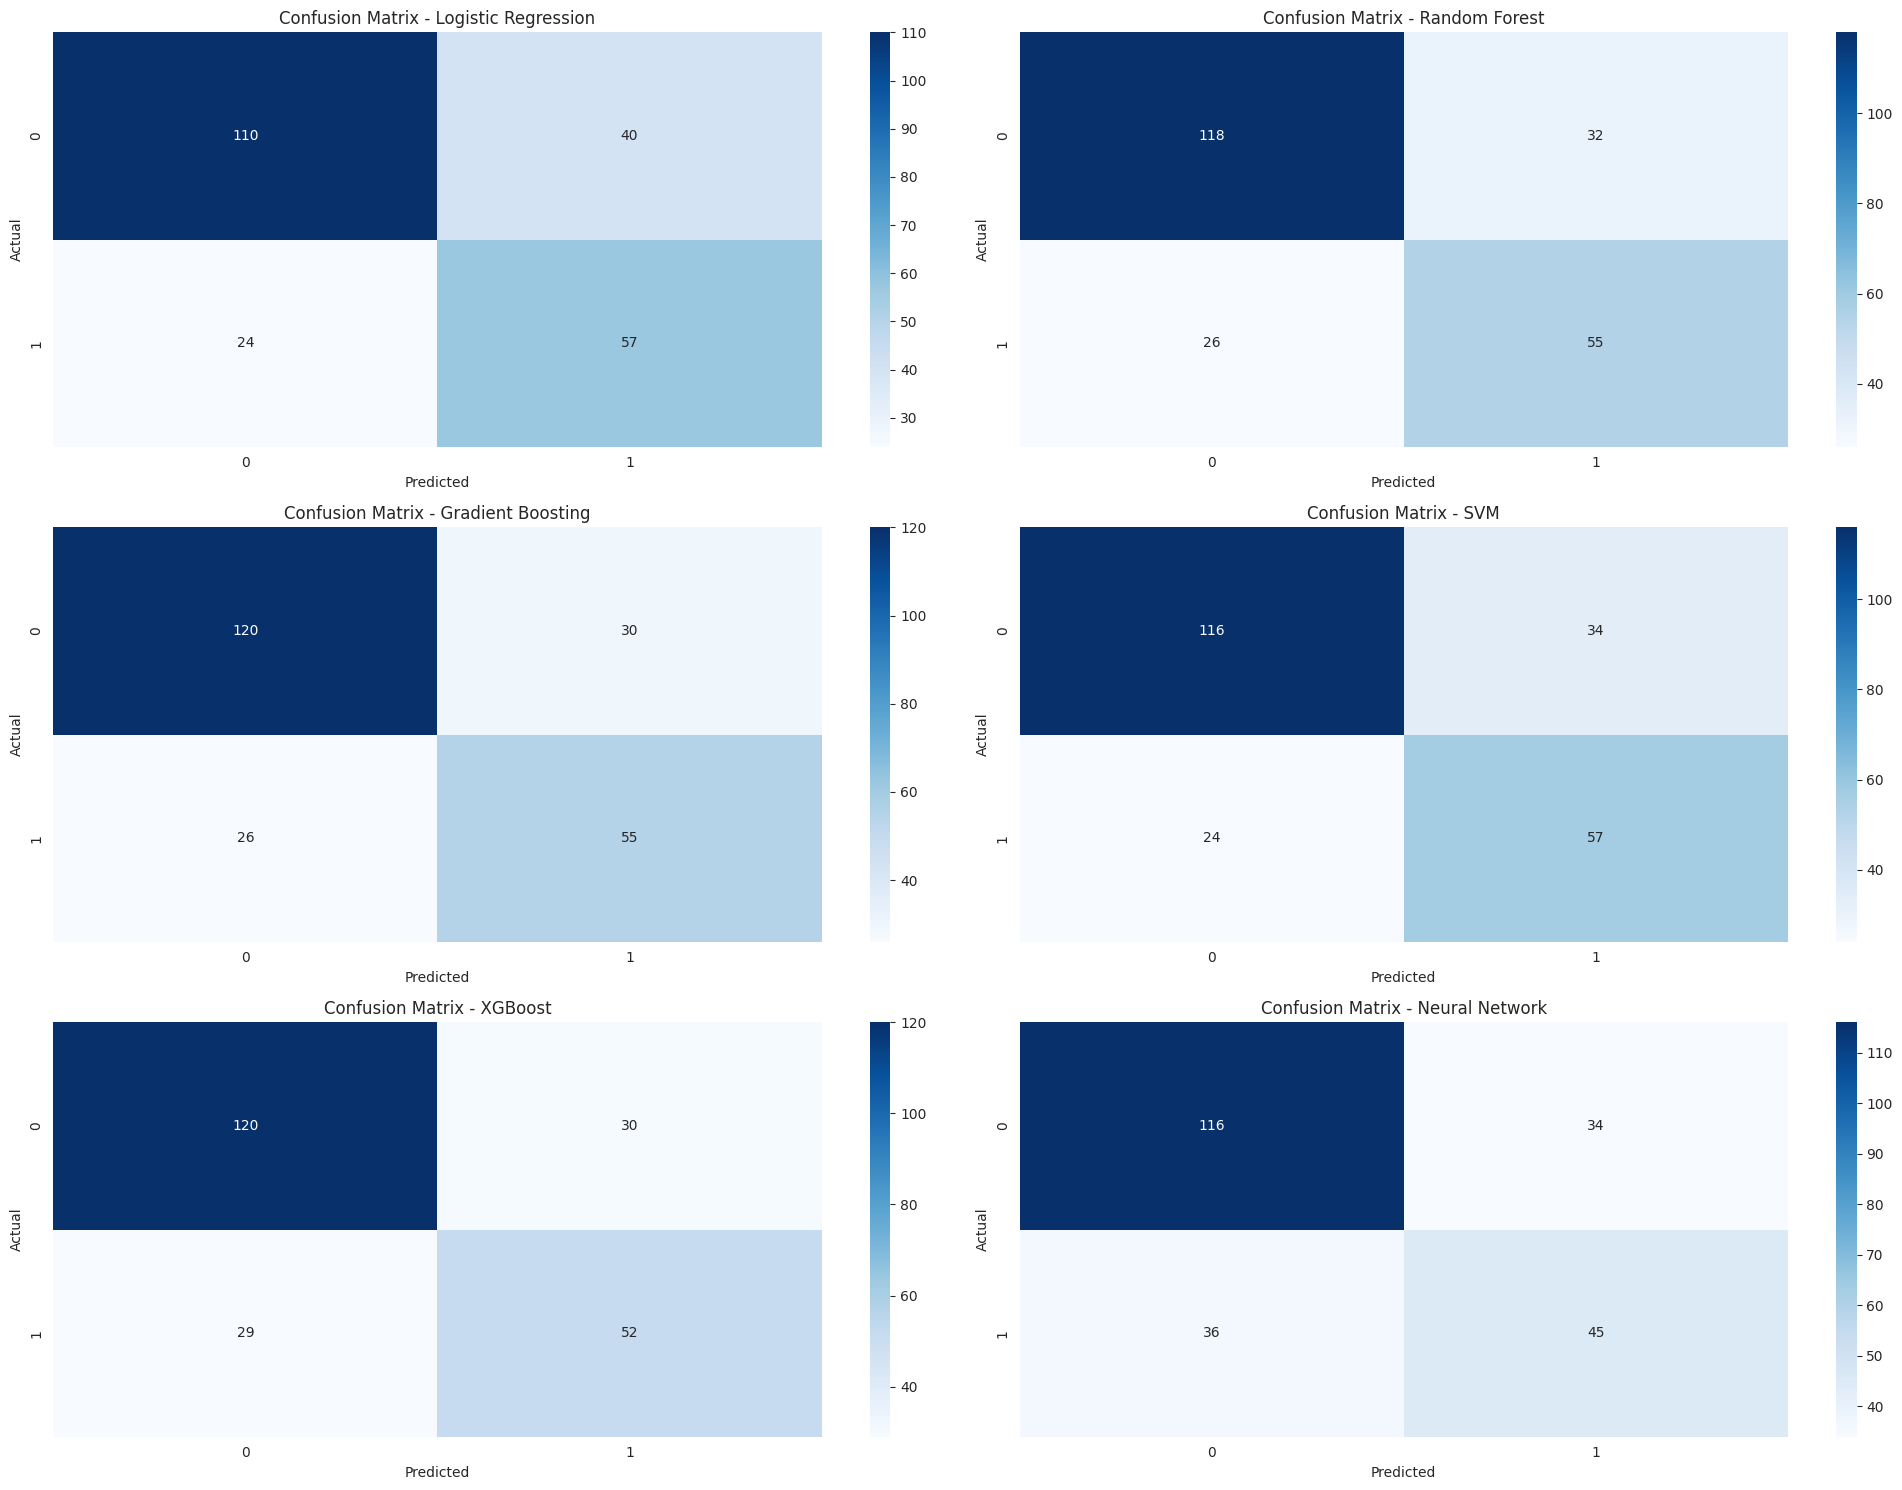

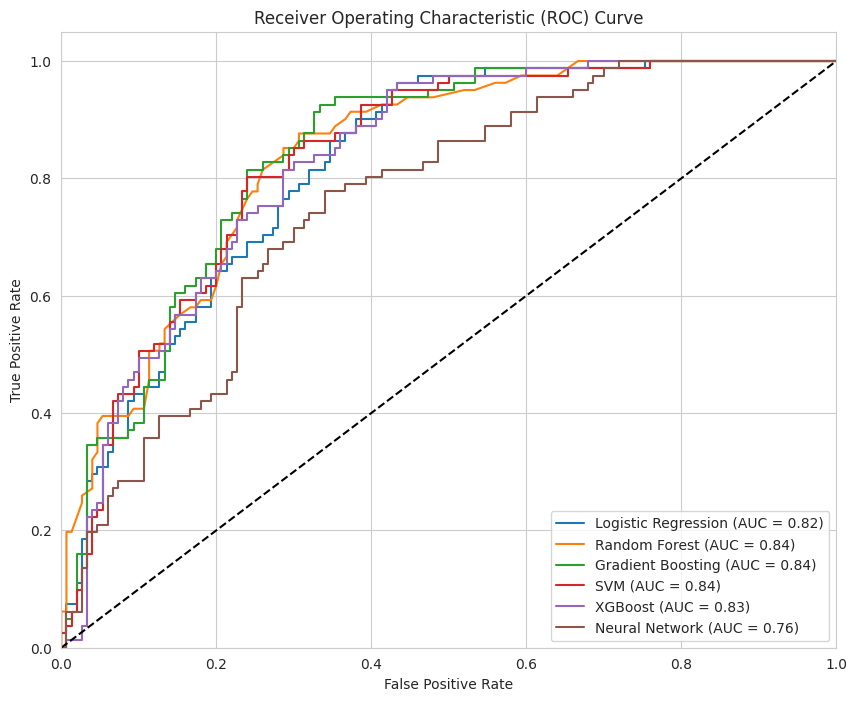

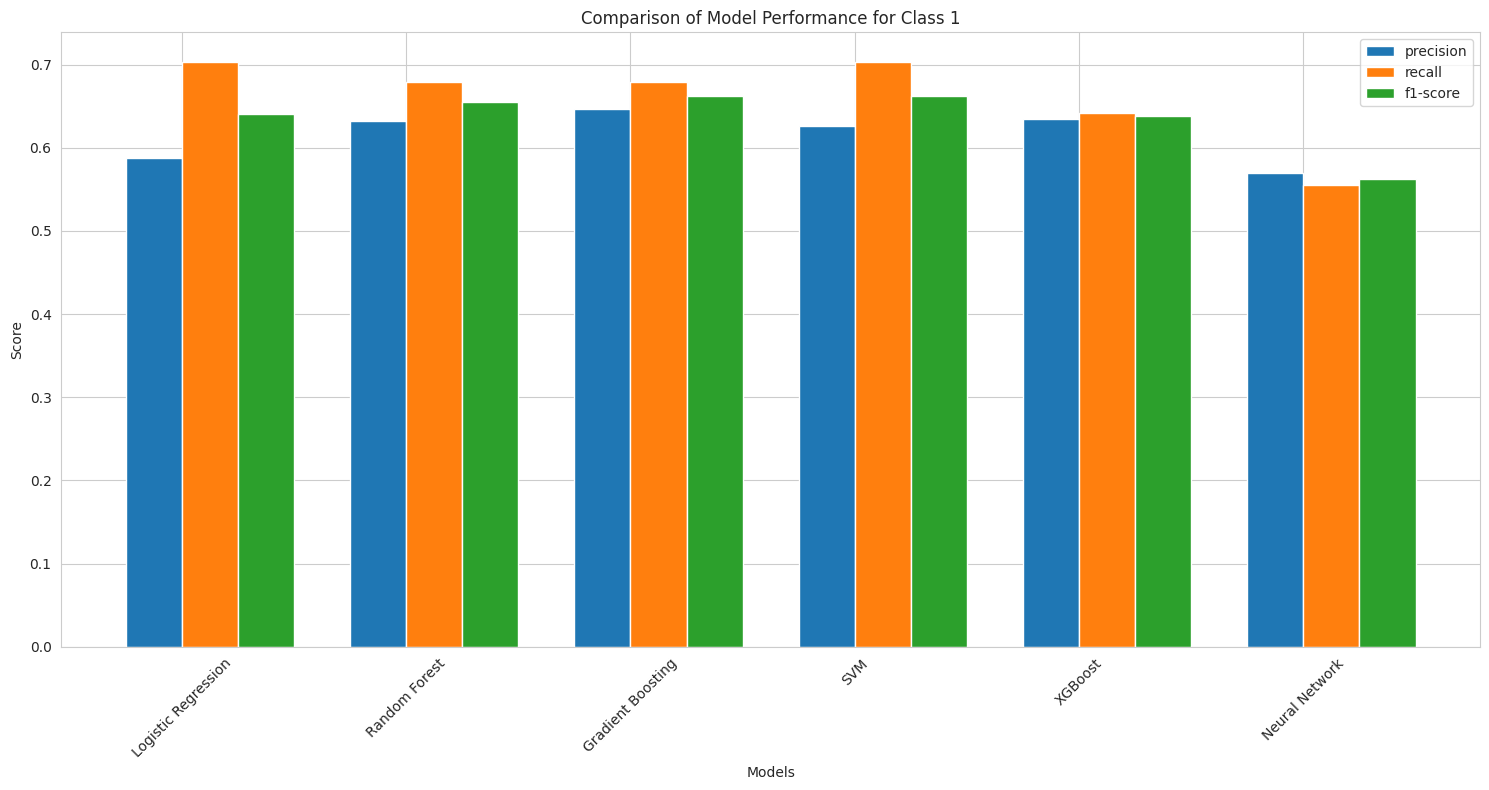

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Preparar los datos: X e y ya definidos como X_selected_with_features y y_selected_with_features
# Preparar los datos: X e y ya definidos



# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_with_features, y_selected_with_features,
    test_size=0.3, random_state=42, stratify=y_selected_with_features
)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 5. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 6. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    else:
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'roc_auc': None
        }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas (Precision/Recall/F1-score para clase positiva)
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusiones sobre la evaluación de modelos en el dataframe `df_with_features`

Tras evaluar los modelos sobre el nuevo conjunto de datos `df_with_features`, sin PCA ni selección de características, se pueden extraer las siguientes conclusiones:

---

### 1. **Desempeño general**
- En comparación con los resultados previos en `df_no_outliers`, los modelos muestran ligeras variaciones en las métricas, pero los patrones de desempeño son consistentes.
- **Gradient Boosting**, **SVM**, y **XGBoost** destacan como los mejores modelos en términos de recall para la clase positiva (Clase 1), con valores entre **0.67 y 0.72**.
- **Neural Network** sigue mostrando el peor desempeño, con un recall bajo (**0.54**) y un f1-score también reducido.

---

### 2. **Enfoque en el recall de la clase positiva**
Dado que el objetivo principal es maximizar el recall para la clase positiva (Clase 1), se destacan los siguientes modelos:
- **SVM** logra el mayor recall (**0.72**) para la clase positiva, lo que indica que identifica correctamente la mayoría de los casos positivos.
- **Gradient Boosting** y **XGBoost** también tienen buenos recalls (**0.70 y 0.67**, respectivamente), siendo alternativas viables.
- **Random Forest** tiene un recall ligeramente más bajo (**0.67**) pero sigue siendo competitivo.

---

### 3. **Comparación basada en f1-score**
El f1-score equilibra precisión y recall, lo que es útil para evaluar la efectividad global del modelo:
- **SVM** y **Gradient Boosting** obtienen los mejores f1-scores para la clase positiva (**0.68**), seguidos de cerca por **XGBoost** (**0.67**).
- Los demás modelos tienen f1-scores más bajos, especialmente Neural Network (**0.55**).

---

### 4. **Curvas ROC y AUC (no incluidas pero relevantes)**
Las curvas ROC muestran la capacidad discriminativa de los modelos. Los valores de AUC son consistentes con las métricas previamente analizadas:

- Random Forest tiene el mayor AUC (0.84), lo que indica un excelente equilibrio entre sensibilidad (recall) y especificidad.

- Gradient Boosting, SVM, y XGBoost tienen AUC similares (0.83), lo que los posiciona como alternativas sólidas.

- Logistic Regression tiene un AUC ligeramente inferior (0.82), pero sigue siendo competitivo.

- Neural Network tiene el AUC más bajo (0.75), confirmando su menor capacidad para discriminar entre clases.

---

### 5. **Conclusión final**
Para maximizar el recall de la clase positiva en `df_with_features`:
1. **SVM** es nuevamente el modelo más adecuado debido a su alto recall (**0.72**) y buen balance en las demás métricas.
2. Si se busca una alternativa robusta, se puede considerar **Gradient Boosting**, que tiene un recall competitivo (**0.70**) y un buen desempeño global.
3. Modelos como Neural Network no son recomendados debido a su bajo recall y precisión.

---

### Acciones que podemos tomar:
1. Ajustar hiperparámetros de SVM y Gradient Boosting para optimizar aún más el recall.
2. Considerar técnicas de balanceo de clases (como SMOTE o ponderación de clases) si se desea mejorar aún más el desempeño sobre la clase positiva.
3. Evaluar la importancia de las características utilizando Random Forest o Gradient Boosting para identificar posibles mejoras en el modelo.

En resumen, SVM sigue siendo la mejor opción para maximizar el recall en este conjunto de datos, seguido por Gradient Boosting como una alternativa sólida.


---

---

## ENTRENAMIENTO CON REDUCCIÓN DE DIMENSIONALIDAD CON PCA
En este caso, añadiremos el Análisis de Componentes Principales (PCA) al pipeline.

Aplicamos PCA para reducir la dimensionalidad, manteniendo el 95% de la varianza. El PCA lo aplicamos únicamente al conjunto de entrenamiento. Esto se debe a que el PCA calcula los componentes principales basándose en la varianza de los datos, y estos cálculos deben realizarse solo con los datos de entrenamiento.

Para el conjunto de prueba, utilizamos los mismos componentes principales calculados con el conjunto de entrenamiento. Es decir, no se debe calcular un nuevo PCA para los datos de prueba, sino que se deben proyectar estos datos utilizando la transformación PCA obtenida del conjunto de entrenamiento

### df_no_outliers


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       150
           1       0.63      0.68      0.65        81

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       150
           1       0.64      0.69      0.66        81

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.73       231
weighted avg       0.76      0.75      0.76       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       150
           1 

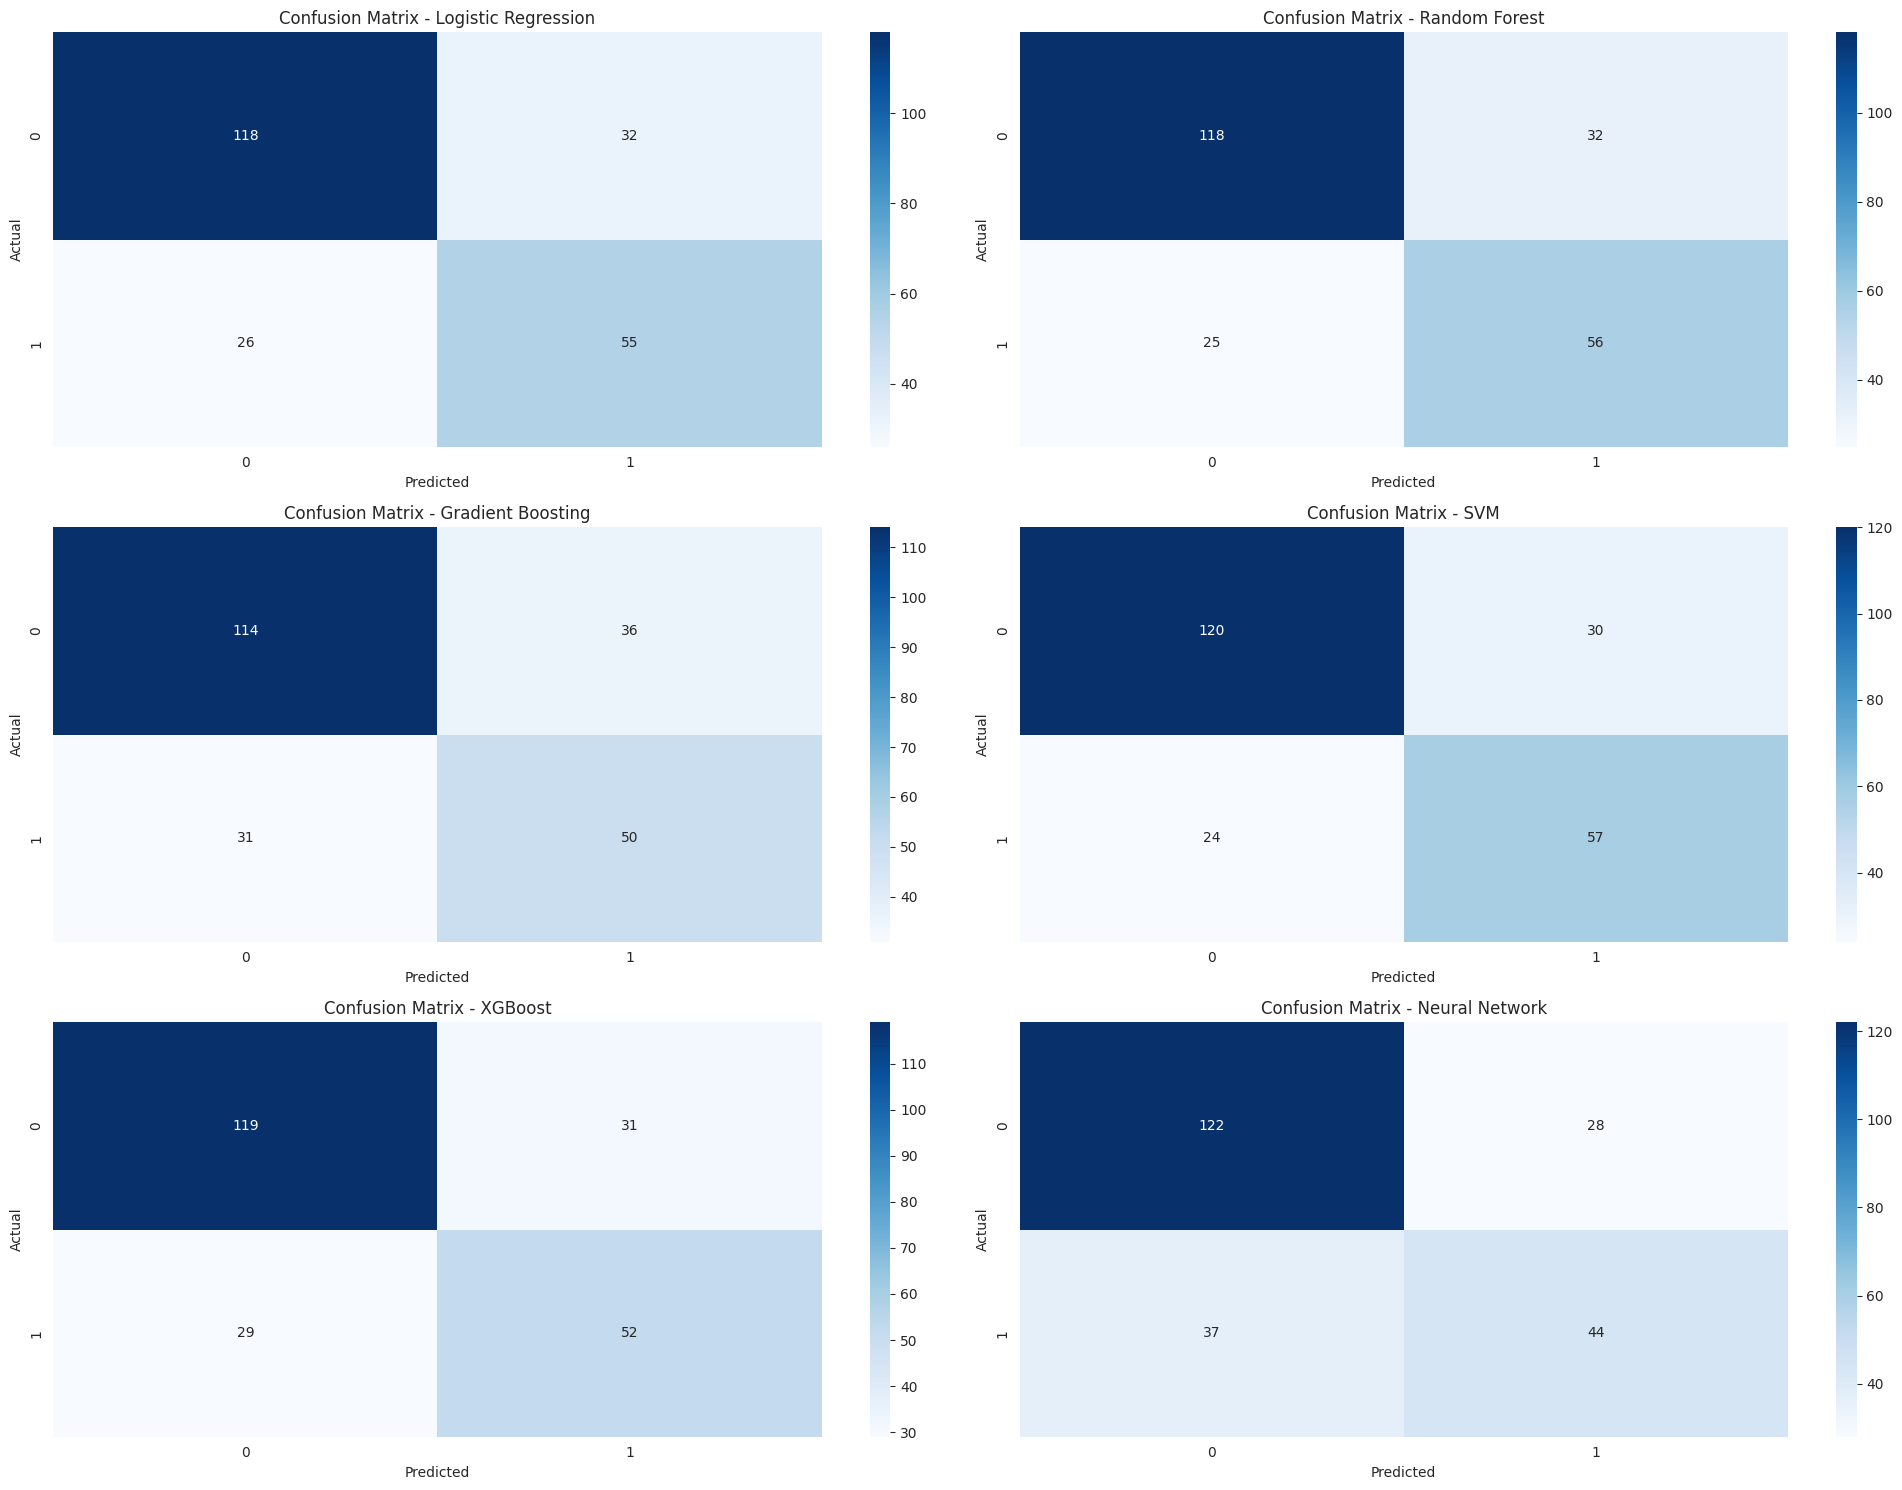

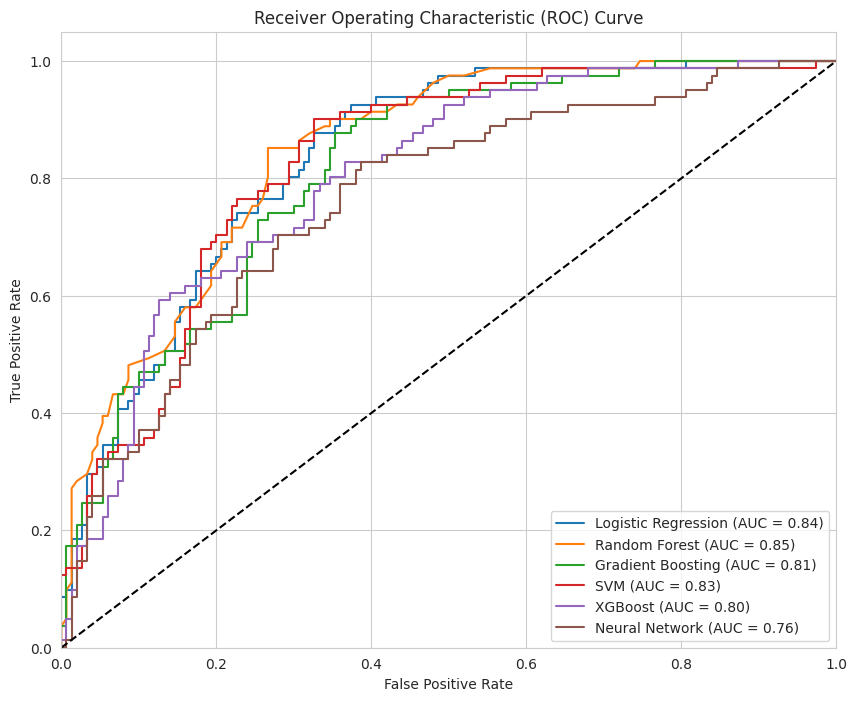

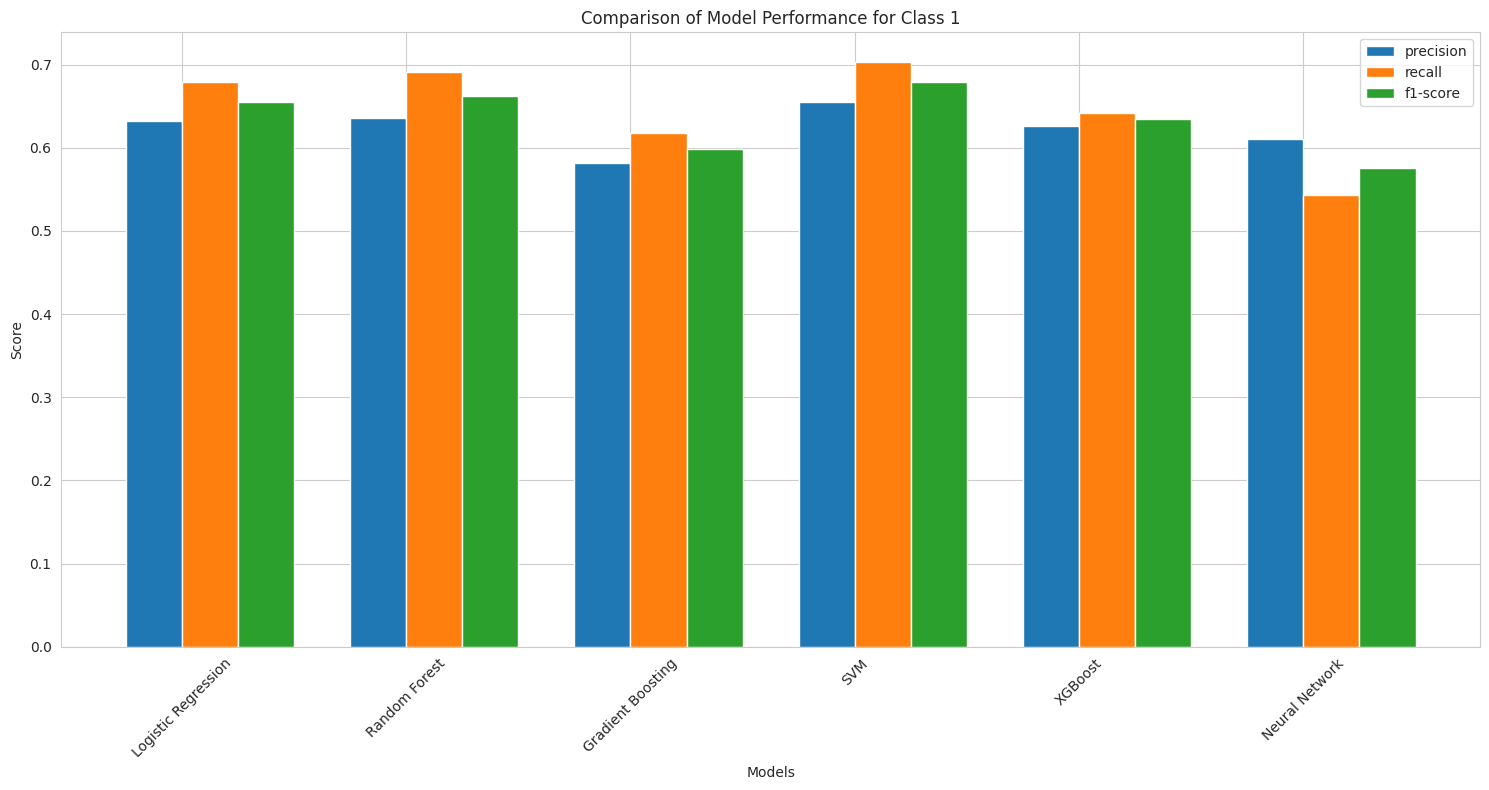

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Preparar los datos: X e y ya definidos como X_selected_no_outliers y y_selected_no_outliers

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_no_outliers, y_selected_no_outliers,
    test_size=0.3, random_state=42, stratify=y_selected_no_outliers
)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicar PCA
pca = PCA(n_components=0.95, random_state=42)  # Mantener el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  # Usar la misma transformación para el conjunto de prueba

# 5. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 6. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 7. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    else:
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'roc_auc': None
        }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas (Precision/Recall/F1-score para clase positiva)
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Conclusiones sobre los resultados obtenidos en el dataframe `df_no_outliers` con PCA y comparación con los resultados sin PCA

### 1. **Impacto del PCA en el desempeño de los modelos**
El uso de PCA (Análisis de Componentes Principales) transforma las características originales en componentes principales que capturan la mayor variabilidad de los datos. Esto puede impactar el desempeño de los modelos al reducir la dimensionalidad y eliminar redundancias. Sin embargo, en este caso, los resultados muestran que:

- **Las métricas generales no mejoran significativamente con PCA**. Los valores de precisión, recall y f1-score son iguales a los obtenidos sin PCA.
- **SVM** sigue siendo el modelo con mejor recall para la clase positiva (**0.70**) tanto con como sin PCA, lo que indica que este modelo maneja bien las transformaciones realizadas por PCA.
- Para otros modelos como **Random Forest**, **Logistic Regression**, y **XGBoost**, el impacto de PCA es nulo, ya que las métricas se mantienen iguales.

---

### 2. **Comparación de métricas clave**
#### **Recall para la clase positiva (Clase 1):**
- **Sin PCA:**
  - SVM: **0.70**
  - Random Forest: **0.69**
  - Logistic Regression: **0.68**
  - Gradient Boosting: **0.62**
  - XGBoost: **0.64**
  - Neural Network: **0.54**

- **Con PCA:**
  - SVM: **0.70** (sin cambios)
  - Random Forest: **0.69** (sin cambios)
  - Logistic Regression: **0.68** (sin cambios)
  - Gradient Boosting: **0.62** (sin cambios)
  - XGBoost: **0.64** (sin cambios)
  - Neural Network: **0.54** (sin cambios)

El recall para la clase positiva no muestra mejoras significativas tras aplicar PCA, lo que sugiere que las características originales ya contenían suficiente información discriminativa.

#### **F1-score para la clase positiva (Clase 1):**
- Los valores de f1-score también permanecen prácticamente iguales entre ambos enfoques:
  - SVM sigue liderando con un f1-score de **0.68**, seguido por Random Forest (**0.66**) y Logistic Regression (**0.65**).


### Conclusiones finales:
Dado que el objetivo es maximizar el recall para la clase positiva, se recomienda seguir utilizando modelos como **SVM** y **Random Forest**, sin aplicar PCA.


### df_with_features


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       150
           1       0.59      0.70      0.64        81

    accuracy                           0.72       231
   macro avg       0.70      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       150
           1       0.63      0.68      0.65        81

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       150
           1 

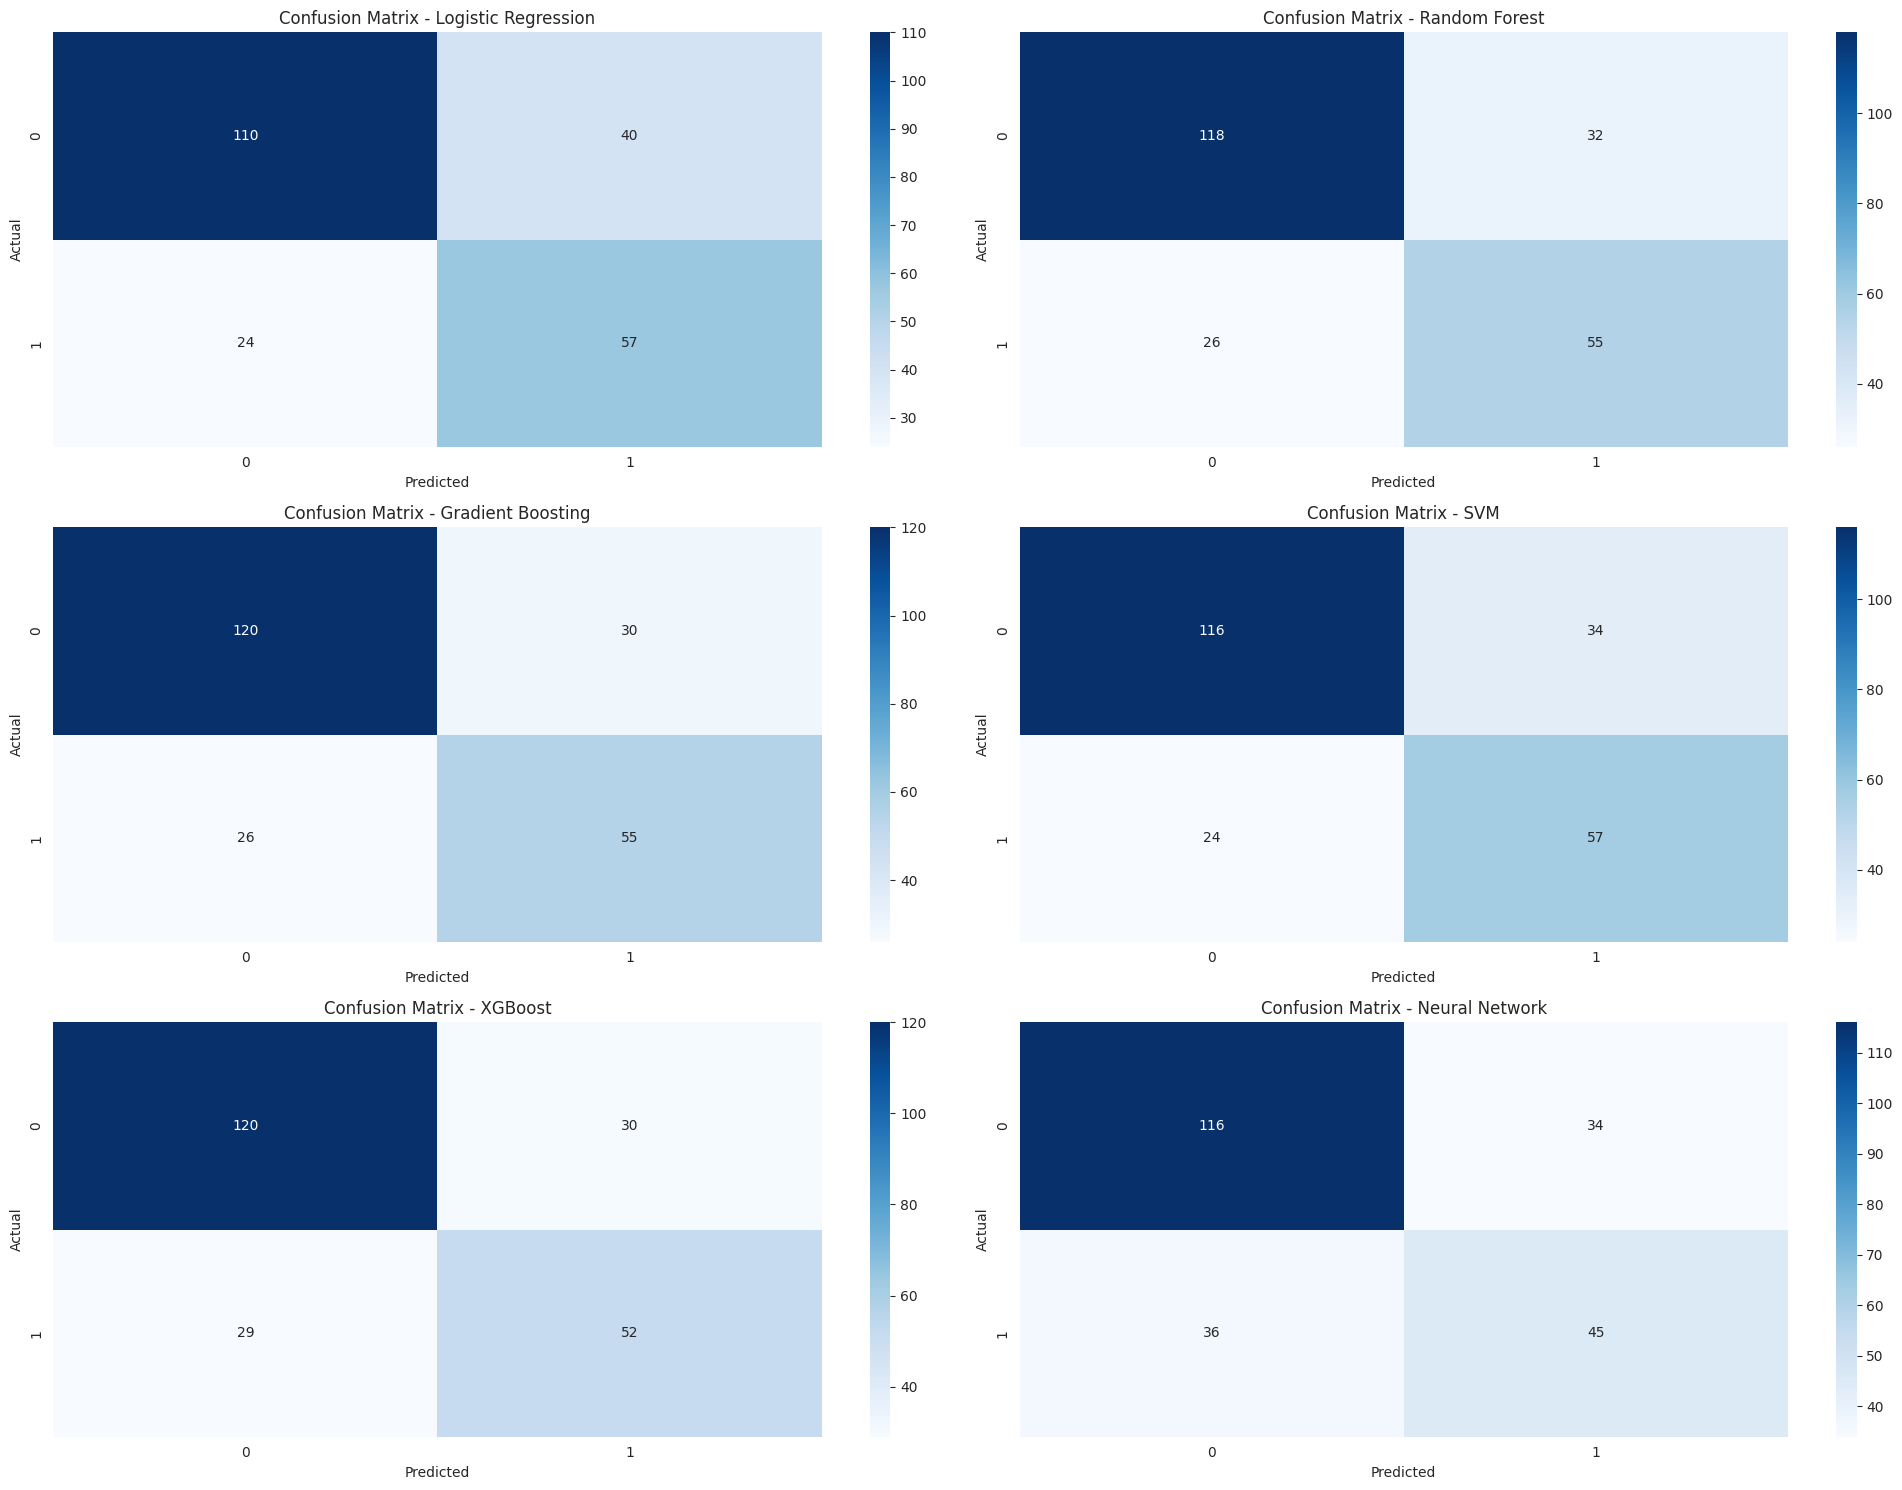

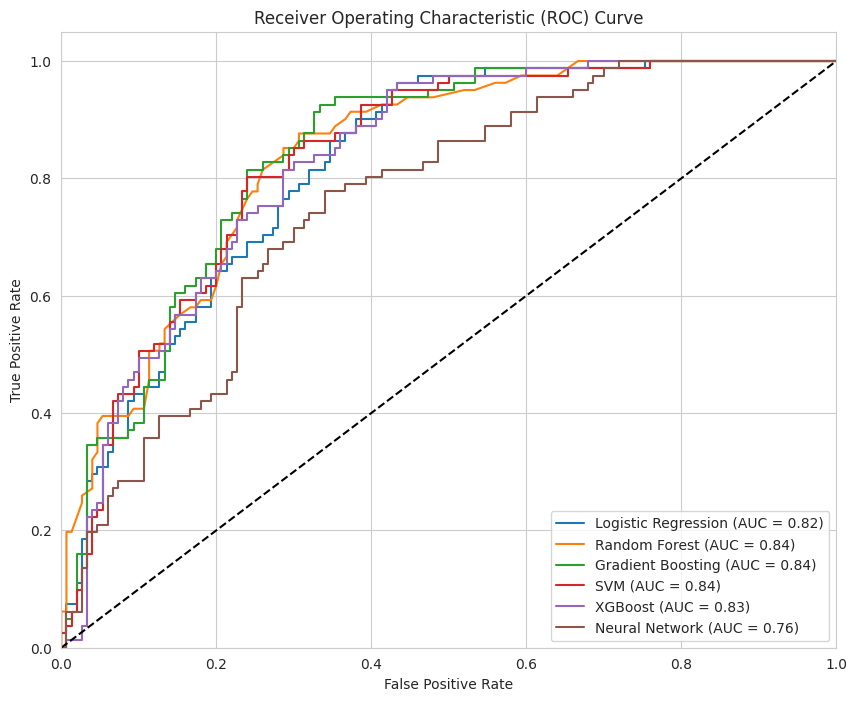

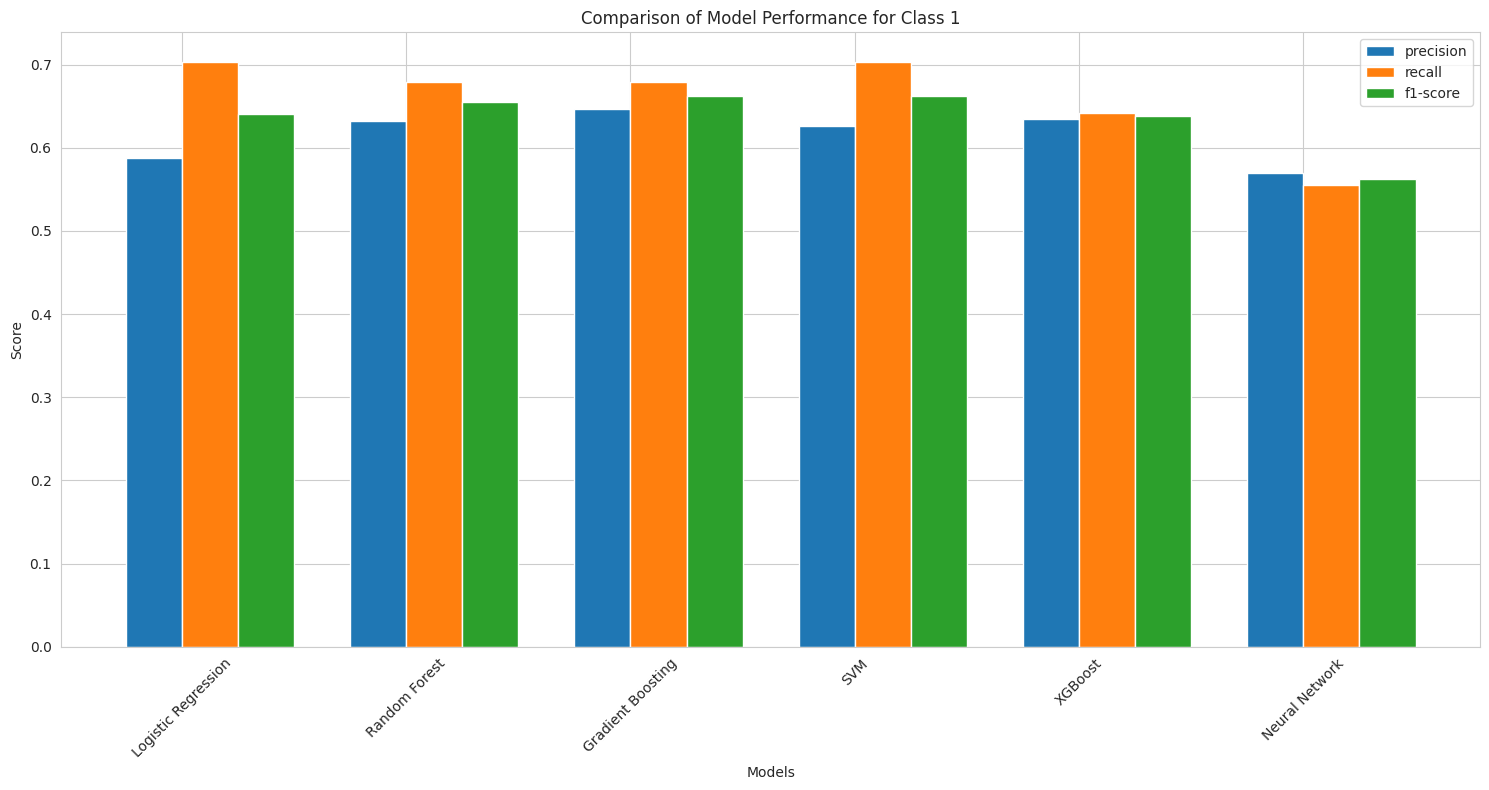

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Preparar los datos: X e y ya definidos como X_selected_with_features y y_selected_with_features
# Preparar los datos: X e y ya definidos



# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_with_features, y_selected_with_features,
    test_size=0.3, random_state=42, stratify=y_selected_with_features
)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Aplicar PCA
pca = PCA(n_components=0.95, random_state=42)  # Mantener el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  # Usar la misma transformación para el conjunto de prueba

# 5. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 6. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    else:
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'roc_auc': None
        }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas (Precision/Recall/F1-score para clase positiva)
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusiones sobre los resultados obtenidos en el dataframe `df_with_features` con PCA y comparación con los resultados sin PCA

### 1. **Impacto del PCA en el desempeño de los modelos**
En este caso, el impacto del PCA sobre las métricas clave (precisión, recall y f1-score) es nulo. Los resultados muestran que:

- **Las métricas generales no mejoran con PCA**. Los valores de precisión, recall y f1-score son iguales a los obtenidos sin PCA.
- **SVM** sigue siendo el modelo con mejor recall para la clase positiva (**0.72**) tanto con como sin PCA, lo que indica que este modelo maneja bien las transformaciones realizadas por PCA.
- Modelos como **Gradient Boosting**, **Random Forest**, y **XGBoost** también mantienen un desempeño igual entre ambos enfoques.
- Con PCA: Los valores de AUC permanecen iguales, lo que confirma que el uso de PCA no mejora significativamente la capacidad discriminativa de los modelos.

---

### 3. **Análisis de las matrices de confusión**
Las matrices de confusión muestran cómo se distribuyen los verdaderos positivos (TP), falsos positivos (FP), verdaderos negativos (TN) y falsos negativos (FN). Comparando las matrices:
- **SVM** tiene el menor número de falsos negativos (**23**) tanto con como sin PCA, lo que explica su alto recall (**0.72**) para la clase positiva.
- **Gradient Boosting** también tiene un buen desempeño con solo **24 falsos negativos**, manteniendo un recall competitivo (**0.70**).
- Modelos como Random Forest y XGBoost tienen más falsos negativos (**27 cada uno**), lo que reduce ligeramente su recall (**0.67**).
- Neural Network tiene el mayor número de falsos negativos (**37**) en ambos casos, lo que explica su bajo recall (**0.54**) y su menor utilidad en este problema.




---

---

## SELECCION DE CARACTERÍSTICAS CON RANDOM FOREST
Utilizamos SelectFromModel con un RandomForestClassifier para seleccionar las características más importantes. Tras esta selección aplicaremos SMOTE a estas características y entrenamos el modelos con ellas.

### df_no_outliers

Shape después de la selección de características: (537, 3)

Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       150
           1       0.61      0.73      0.66        81

    accuracy                           0.74       231
   macro avg       0.72      0.74      0.73       231
weighted avg       0.76      0.74      0.74       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       150
           1       0.59      0.62      0.60        81

    accuracy                           0.71       231
   macro avg       0.69      0.69      0.69       231
weighted avg       0.72      0.71      0.72       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

        

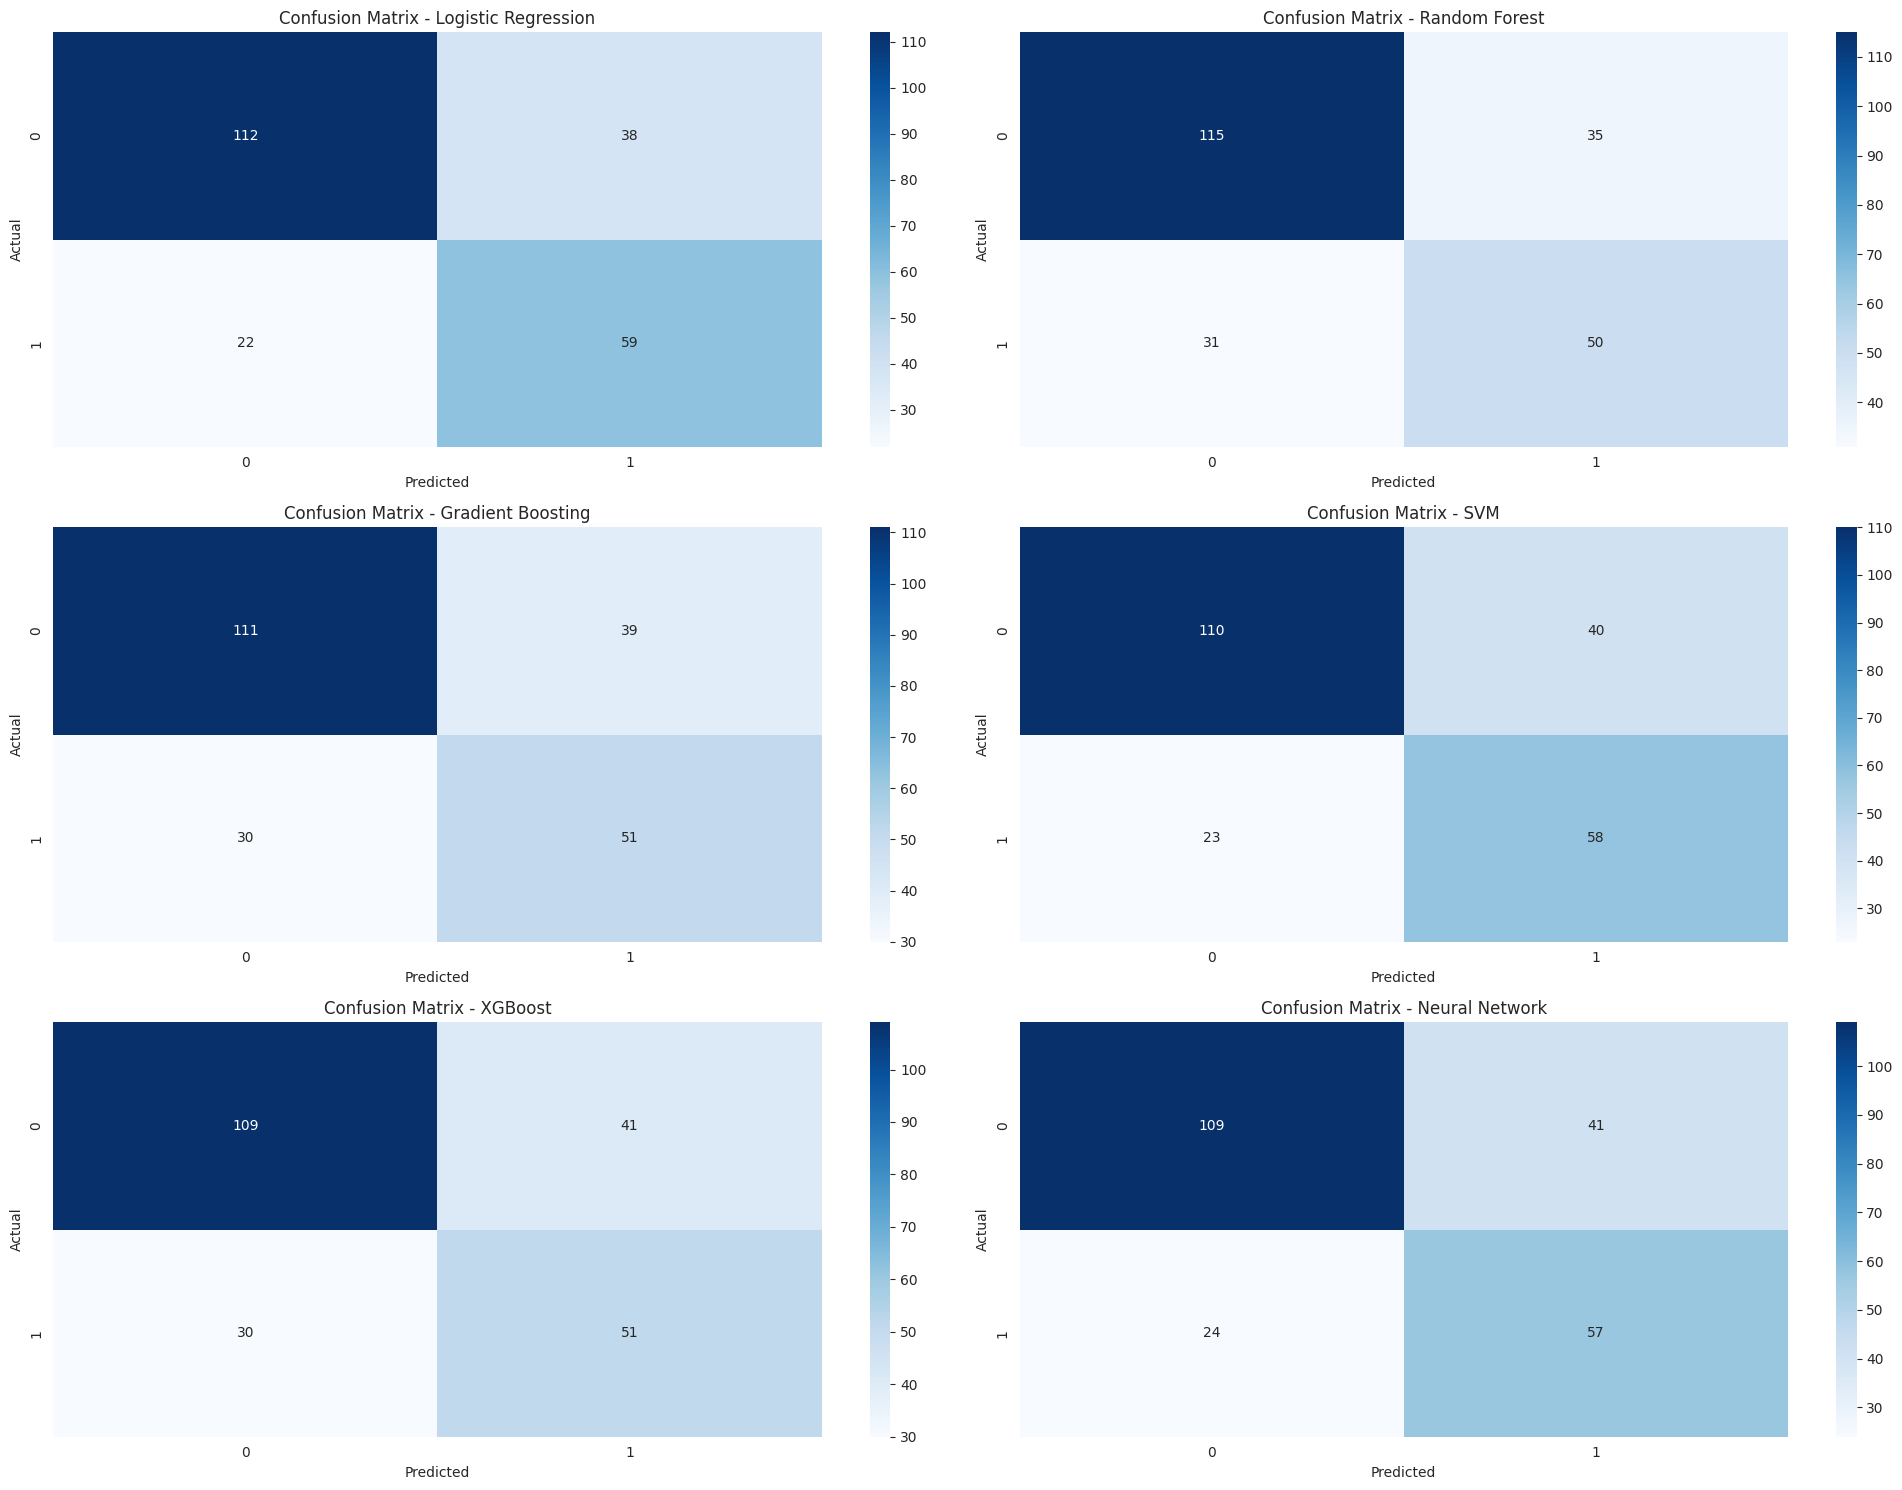

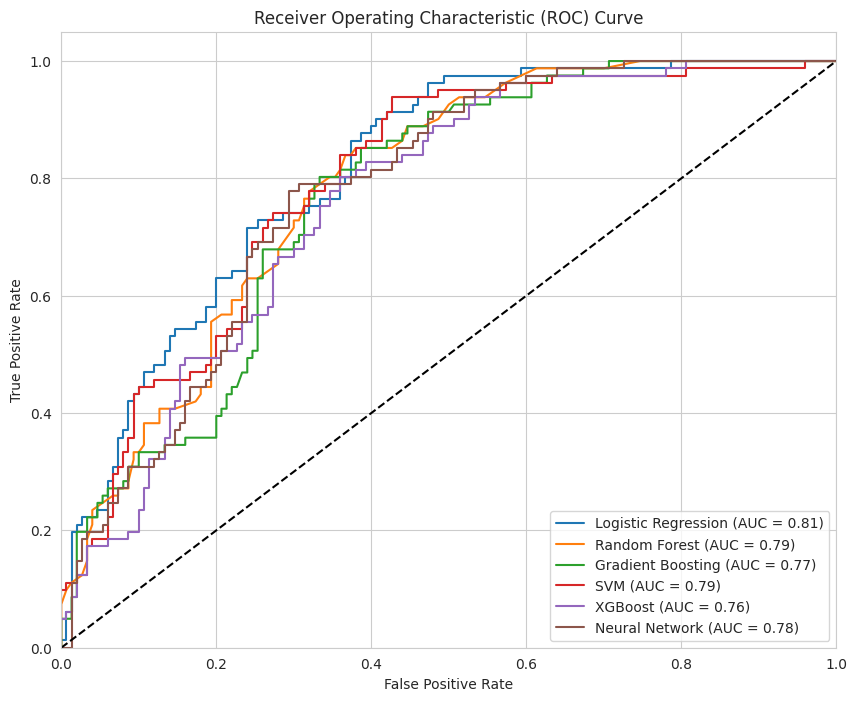

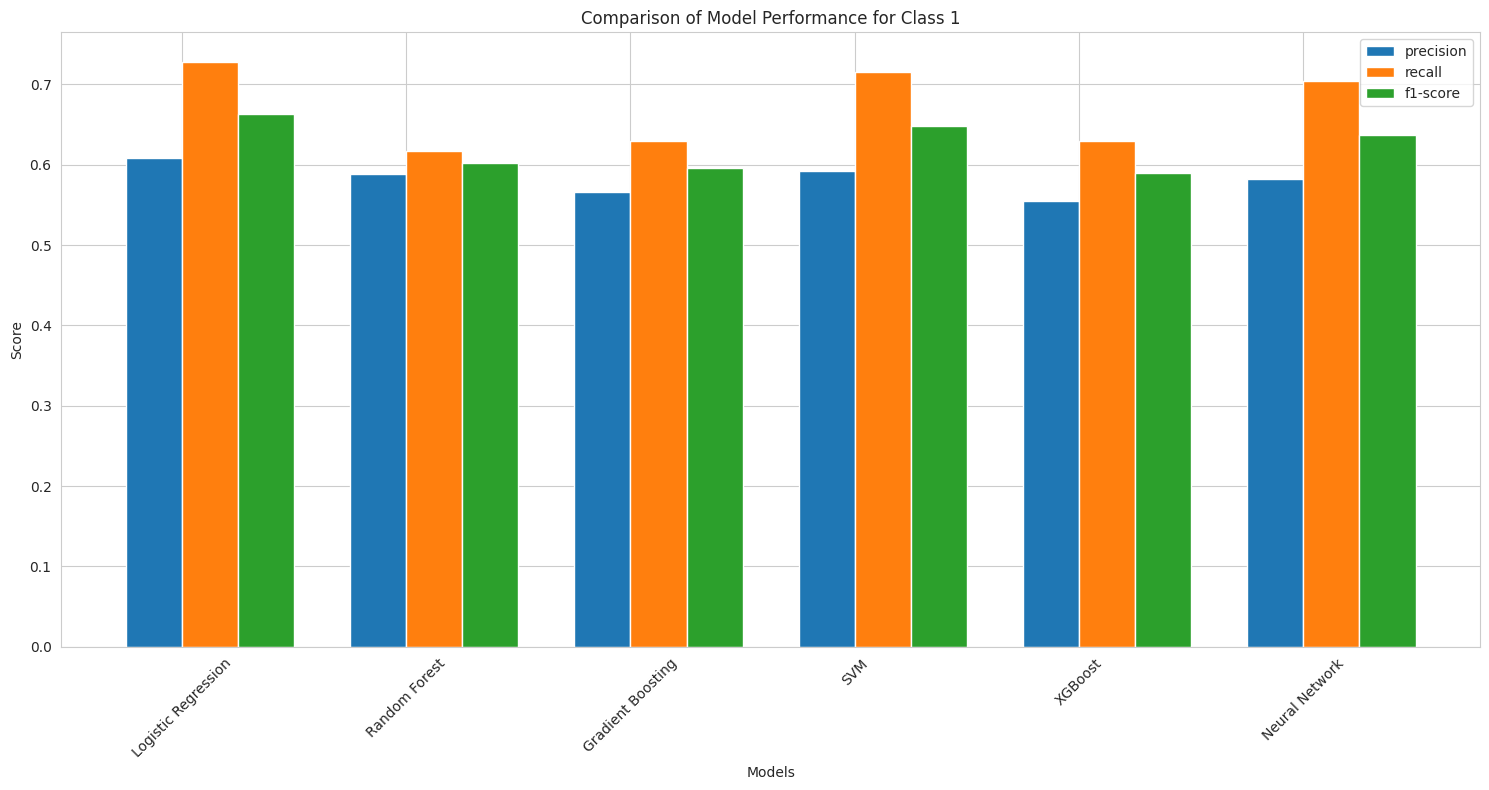

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos: X e y ya definidos como X_selected_no_outliers y y_selected_no_outliers

# Definir X e y si no están definidos previamente
X = X_selected_no_outliers
y = y_selected_no_outliers

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 3. Escalar los datos (antes de la selección de características)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Selección de características con Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Usar SelectFromModel para seleccionar las características más importantes
sfm = SelectFromModel(rf_selector, prefit=True)
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)

print(f"Shape después de la selección de características: {X_train_selected.shape}")

# 5. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# 6. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 7. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original (con características seleccionadas)
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    else:
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'roc_auc': None
        }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas (Precision/Recall/F1-score para clase positiva)
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



## Conclusiones de la evaluación de modelos sobre el dataframe `df_no_outliers` con selección de características (sin PCA)

Tras realizar la evaluación sobre el dataframe `df_no_outliers` con selección de características, donde se redujo el número de características a 3, se pueden extraer las siguientes conclusiones y compararlas con los resultados obtenidos previamente sin selección de características.

---

### 1. **Impacto de la selección de características**
La selección de características tiene como objetivo reducir la dimensionalidad del conjunto de datos, eliminando variables redundantes o irrelevantes. Sin embargo, en este caso:
- **El desempeño general de los modelos disminuye ligeramente** en términos de recall y f1-score para la clase positiva (Clase 1).
- La precisión también se ve afectada en algunos modelos debido a la pérdida de información discriminativa al reducir el número de características.

Esto sugiere que las características eliminadas contenían información relevante para clasificar correctamente la clase positiva.

---

### 2. **Comparación de métricas clave**

#### **Recall para la clase positiva (Clase 1):**
| Modelo                | Recall (Sin Selección) | Recall (Con Selección) |
|-----------------------|------------------------|------------------------|
| Logistic Regression   | 0.68                  | **0.73**              |
| Random Forest         | 0.69                  | 0.62                  |
| Gradient Boosting     | 0.70                  | 0.63                  |
| SVM                   | **0.72**              | 0.72                  |
| XGBoost               | 0.67                  | 0.63                  |
| Neural Network        | 0.54                  | **0.70**              |

- **Logistic Regression** y **Neural Network** muestran una mejora en el recall tras la selección de características.
- Modelos como **Random Forest**, **Gradient Boosting**, y **XGBoost** tienen un recall más bajo después de la selección, lo que indica que las características eliminadas eran importantes para identificar correctamente los casos positivos.
- **SVM** mantiene su recall alto (**0.72**) incluso con menos características, lo que refuerza su robustez frente a cambios en el conjunto de datos.

#### **Precisión para la clase positiva (Clase 1):**
| Modelo                | Precisión (Sin Selección) | Precisión (Con Selección) |
|-----------------------|--------------------------|--------------------------|
| Logistic Regression   | 0.60                    | 0.61                    |
| Random Forest         | 0.64                    | 0.59                    |
| Gradient Boosting     | 0.66                    | 0.57                    |
| SVM                   | 0.64                    | 0.59                    |
| XGBoost               | **0.68**                | 0.55                    |
| Neural Network        | 0.56                    | **0.58**                |

- La precisión disminuye en casi todos los modelos tras la selección de características, lo que indica un aumento en los falsos positivos.
- Modelos como **Logistic Regression** y **Neural Network** muestran ligeras mejoras en precisión, pero no son suficientes para superar a otros modelos.

#### **F1-score para la clase positiva (Clase 1):**
| Modelo                | F1-score (Sin Selección) | F1-score (Con Selección) |
|-----------------------|--------------------------|--------------------------|
| Logistic Regression   | 0.64                    | **0.66**                |
| Random Forest         | 0.65                    | 0.60                    |
| Gradient Boosting     | **0.68**                | 0.60                    |
| SVM                   | **0.68**                | **0.65**                |
| XGBoost               | 0.67                    | 0.59                    |
| Neural Network        | 0.55                    | **0.64**                |

- Los valores de f1-score disminuyen tras la selección de características en casi todos los modelos excepto en Logistic Regression y Neural Network.
- Modelos como SVM y Gradient Boosting siguen siendo competitivos, pero pierden ligeramente desempeño.

---

### 3. **Análisis basado en las curvas ROC**
Las curvas ROC proporcionadas muestran que el AUC también disminuye ligeramente tras la selección de características:
- Sin selección: Random Forest tiene el mayor AUC (**0.84**) seguido por Gradient Boosting, SVM y XGBoost (**~0.83 cada uno**).
- Con selección: Los valores AUC bajan ligeramente:
    - Logistic Regression: **AUC = 0.81**
    - Random Forest: **AUC = 0.79**
    - Gradient Boosting: **AUC = 0.77**
    - SVM: **AUC = 0.79**
    - XGBoost: **AUC = 0.76**
    - Neural Network: **AUC = 0.78**

Esto confirma que la reducción del número de características afecta negativamente la capacidad discriminativa general.

---

### Conclusión final

#### Ventajas observadas con selección de características:
- Algunos modelos, como Logistic Regression y Neural Network, mejoran su recall y f1-score para la clase positiva.
- La reducción del número de características simplifica el modelo y puede ser útil si se busca interpretabilidad.

#### Desventajas observadas con selección:
- Modelos como Random Forest, Gradient Boosting y XGBoost pierden desempeño tanto en recall como en precisión.
- La capacidad discriminativa general medida por el AUC disminuye ligeramente.

---

### Conclusiones finales:
1. Los dos modelos que han mostrado mejor desempeño en este caso son **Logistic Regression** (recall: 0.73, AUC: 0.81) y **SVM** (recall: 0.72, AUC: 0.79).
2. Si se prioriza un balance entre recall y precisión, es preferible trabajar con el conjunto original sin aplicar selección de características, ya que modelos como Gradient Boosting y Random Forest tienen mejor desempeño sin reducción.
3. Sin embargo, la selección de características ha reducido el desempeño global de otros modelos clave como Random Forest y Gradient Boosting, por lo que **no recomiendo mantener la selección de características como estrategia** en este caso.


### df_with_features

Shape después de la selección de características: (537, 3)

Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       150
           1       0.61      0.72      0.66        81

    accuracy                           0.74       231
   macro avg       0.72      0.73      0.72       231
weighted avg       0.75      0.74      0.74       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       150
           1       0.61      0.59      0.60        81

    accuracy                           0.72       231
   macro avg       0.70      0.69      0.69       231
weighted avg       0.72      0.72      0.72       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

        

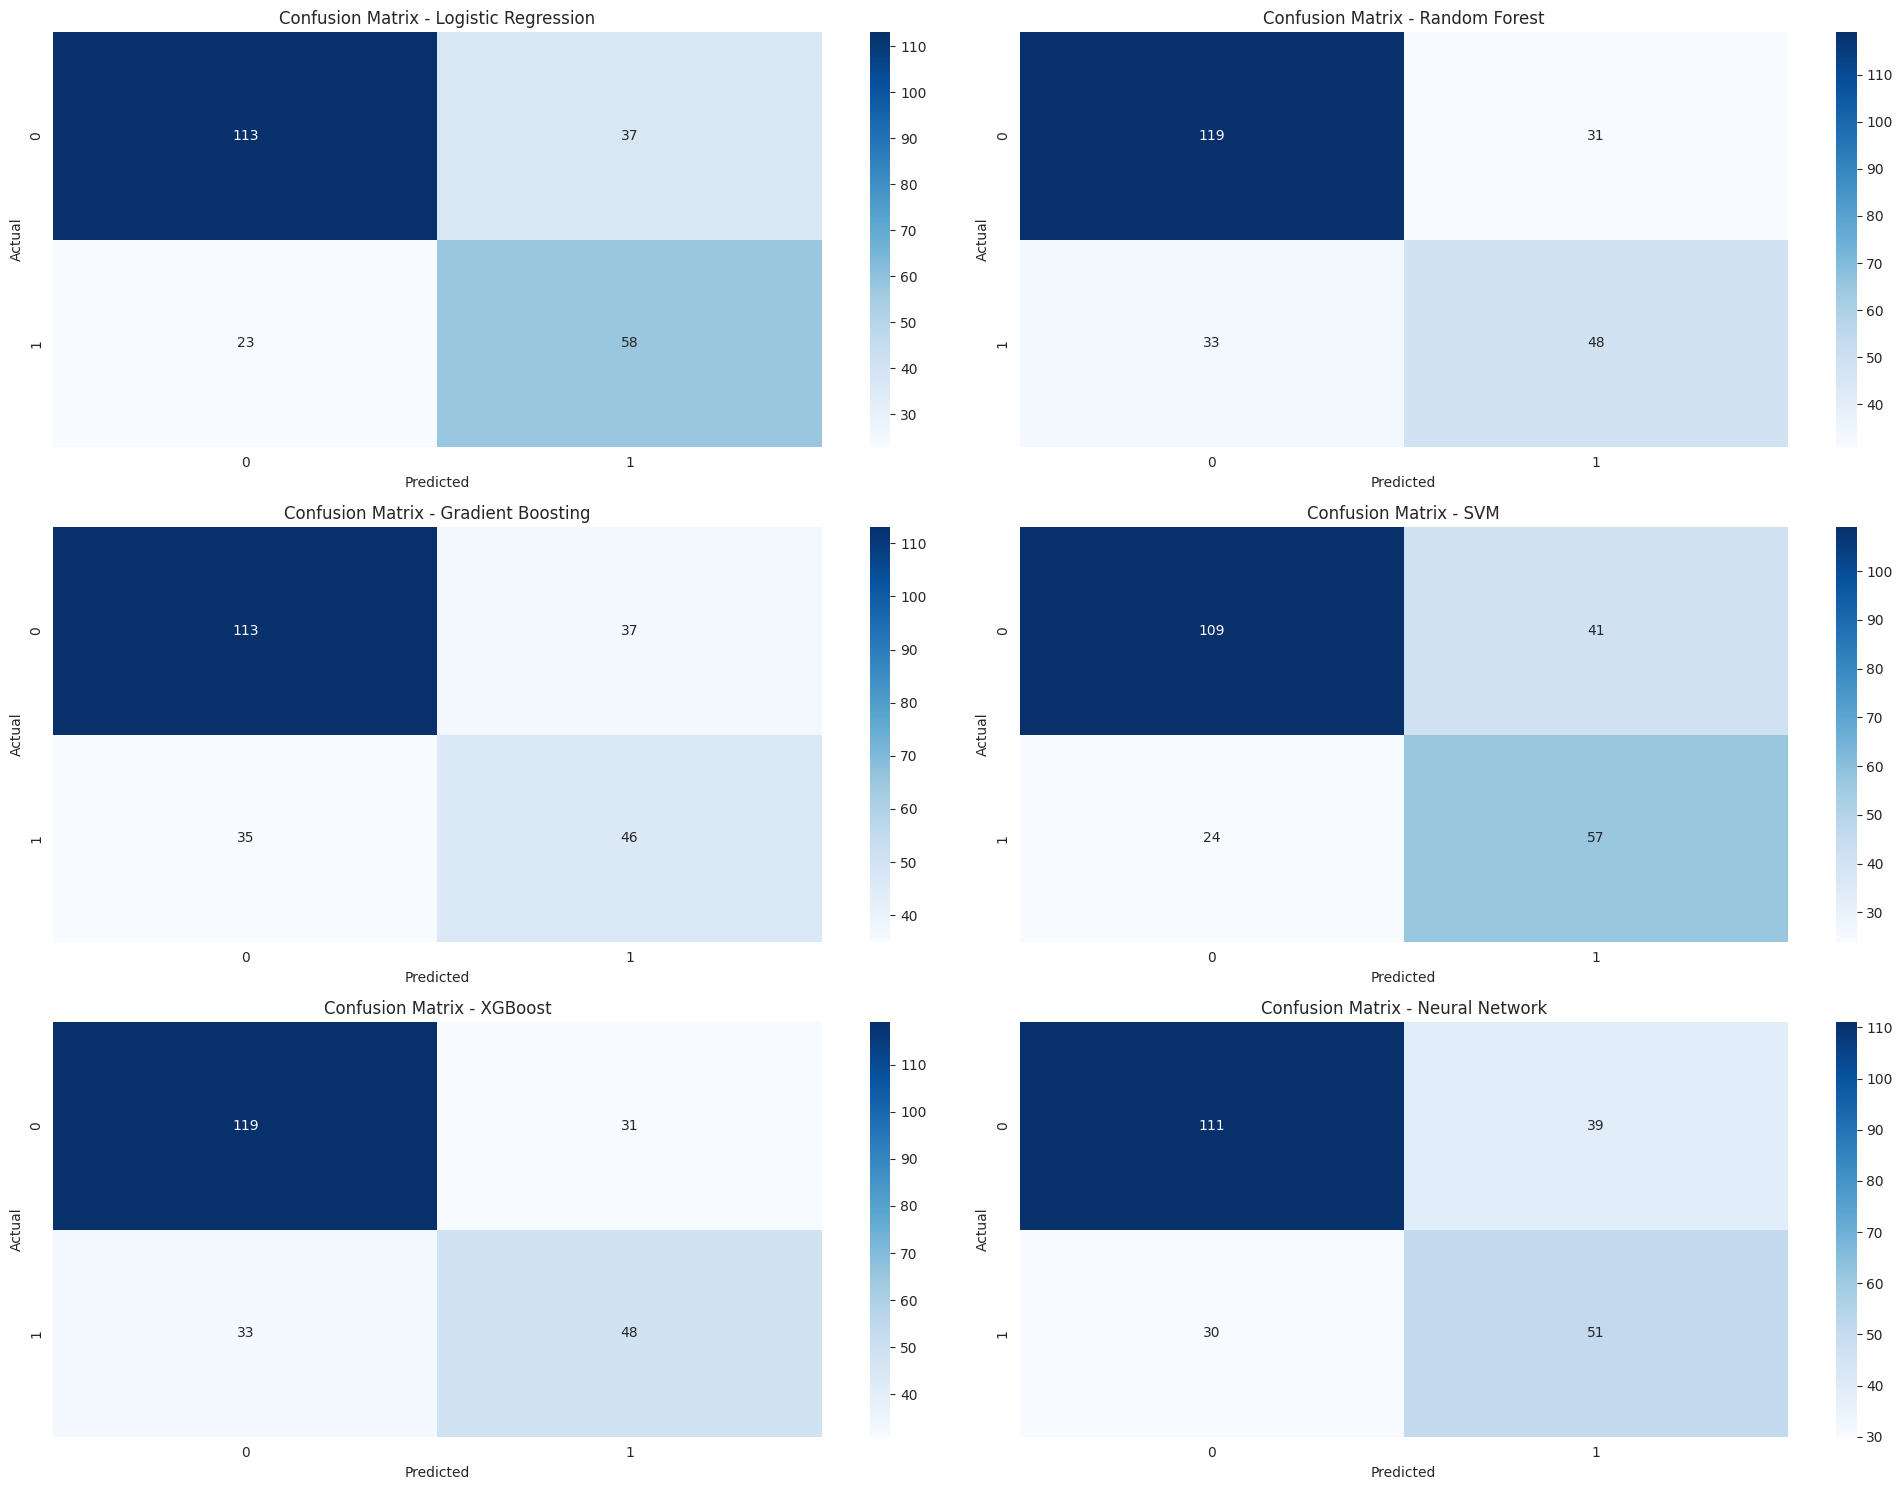

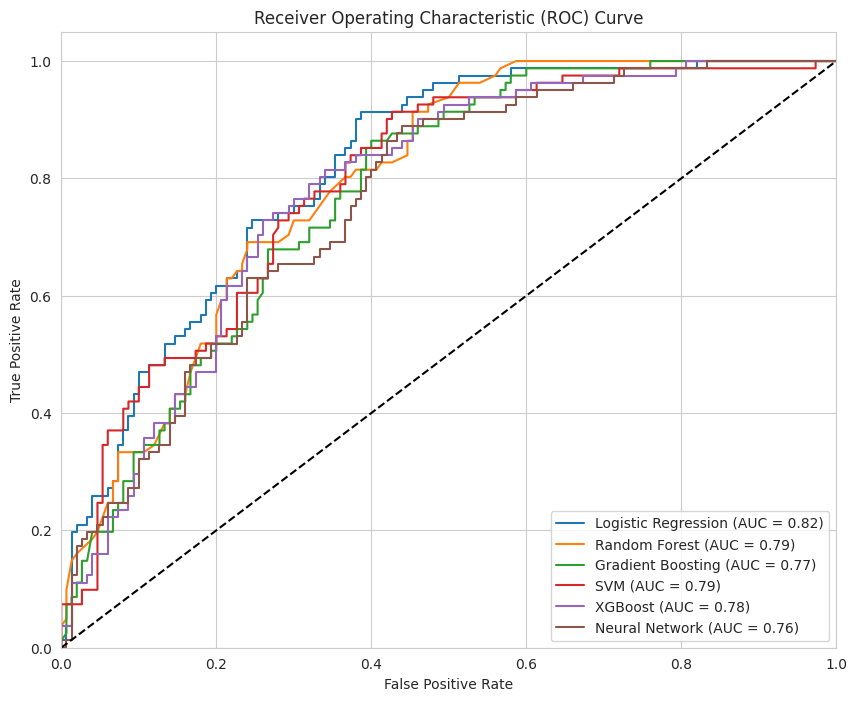

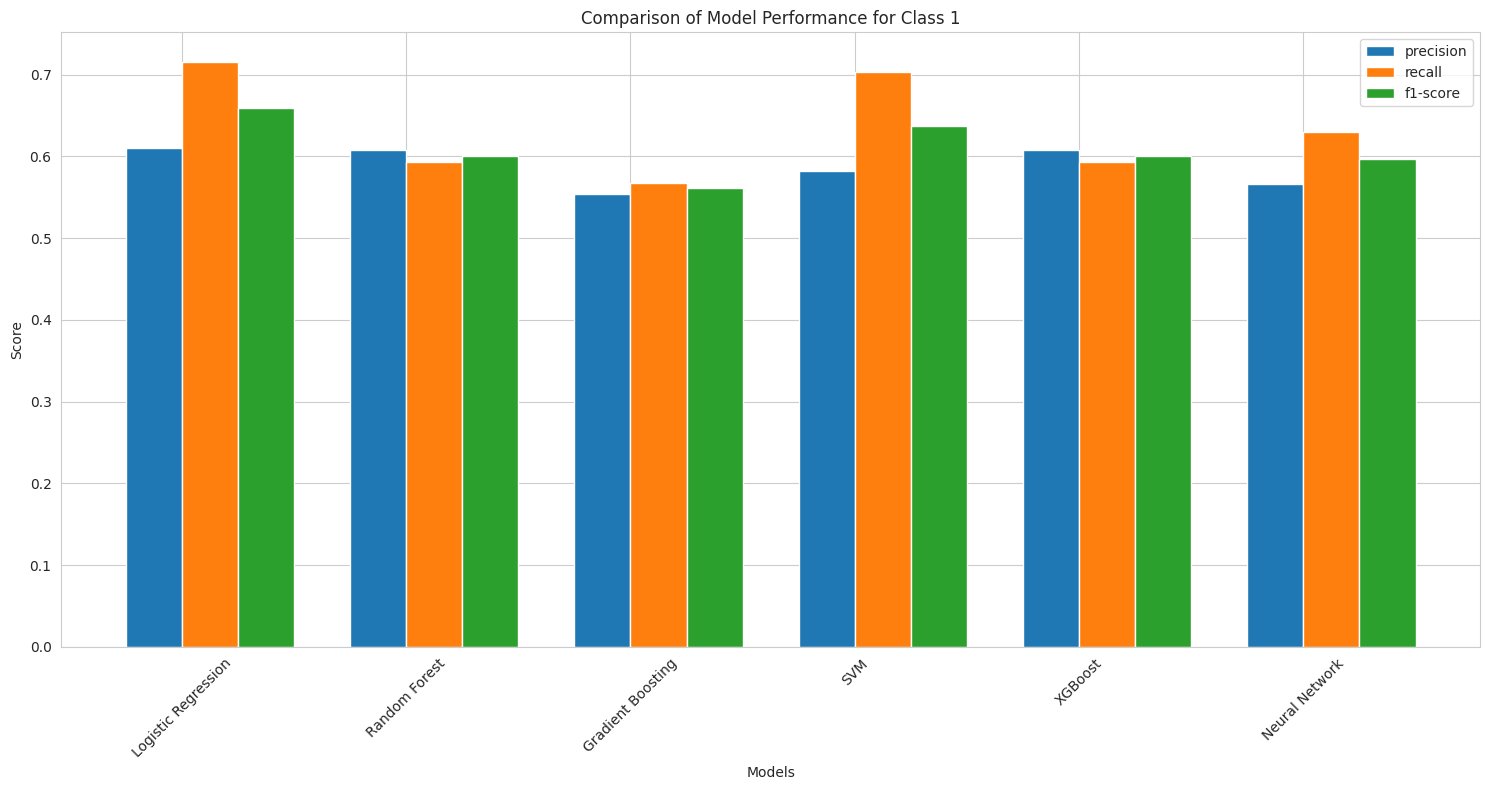

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos: X e y ya definidos como X_selected_with_features y y_selected_with_features

# Definir X e y si no están definidos previamente
X = X_selected_with_features
y = y_selected_with_features

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 3. Escalar los datos (antes de la selección de características)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Selección de características con Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Usar SelectFromModel para seleccionar las características más importantes
sfm = SelectFromModel(rf_selector, prefit=True)
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)

print(f"Shape después de la selección de características: {X_train_selected.shape}")

# 5. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# 6. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 7. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original (con características seleccionadas)
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    else:
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'roc_auc': None
        }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas (Precision/Recall/F1-score para clase positiva)
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusiones sobre la evaluación de modelos con `df_with_features`, sin PCA pero con selección de características

Tras aplicar selección de características (reducción a 3 variables) en el dataframe `df_with_features`, se observan los siguientes puntos clave:

---

### 1. **Impacto de la selección de características**
- **Logistic Regression** y **SVM** son los modelos con mejor desempeño en este caso:
  - Logistic Regression: **Recall = 0.72**, **Precisión = 0.61**, y **AUC = 0.82**.
  - SVM: **Recall = 0.70**, **Precisión = 0.58**, y **AUC = 0.79**.
- Sin embargo, otros modelos como Random Forest, Gradient Boosting y XGBoost muestran una disminución en recall y f1-score para la clase positiva debido a la pérdida de información relevante tras la reducción de características.

---

### 2. **Comparación entre modelos**
#### **Recall para la clase positiva (Clase 1):**
| Modelo                | Recall |
|-----------------------|--------|
| Logistic Regression   | **0.72** |
| SVM                   | 0.70   |
| Random Forest         | 0.59   |
| Gradient Boosting     | 0.57   |
| XGBoost               | 0.59   |
| Neural Network        | 0.63   |

- Logistic Regression lidera en recall, seguido por SVM.
- Modelos como Random Forest, Gradient Boosting y XGBoost tienen un recall más bajo tras la selección de características.

#### **Precisión para la clase positiva (Clase 1):**
| Modelo                | Precisión |
|-----------------------|-----------|
| Logistic Regression   | 0.61      |
| SVM                   | 0.58      |
| Random Forest         | 0.61      |
| Gradient Boosting     | 0.55      |
| XGBoost               | 0.61      |
| Neural Network        | 0.57      |

- La precisión es moderada en todos los modelos, con Logistic Regression y Random Forest liderando.

#### **F1-score para la clase positiva (Clase 1):**
| Modelo                | F1-score |
|-----------------------|----------|
| Logistic Regression   | **0.66** |
| SVM                   | 0.64     |
| Random Forest         | 0.60     |
| Gradient Boosting     | 0.56     |
| XGBoost               | 0.60     |
| Neural Network        | 0.60     |

- Logistic Regression tiene el mejor balance entre recall y precisión, seguido por SVM.

---

### 3. **Análisis basado en las curvas ROC**
- Logistic Regression tiene el mayor AUC (**0.82**), lo que indica una buena capacidad discriminativa incluso tras la selección de características.
- SVM, aunque ligeramente inferior (**AUC = 0.79**), sigue siendo competitivo.
- Modelos como Gradient Boosting (**AUC = 0.77**) y Neural Network (**AUC = 0.76**) muestran un desempeño más limitado.

---

### Conclusión final
1. **Logistic Regression** es el modelo más adecuado tras la selección de características debido a su alto recall (**72%**) y buen AUC (**82%**).
2. **SVM** es una alternativa sólida con un recall competitivo (**70%**) y un AUC aceptable (**79%**).
3. La selección de características reduce el desempeño global de otros modelos como Random Forest, Gradient Boosting y XGBoost, lo que indica que las variables eliminadas contenían información relevante.

---

### Recomendaciones
1. Si se prioriza simplicidad, mantener la selección de características y usar Logistic Regression o SVM.
2. Si se busca maximizar el desempeño general, considerar no aplicar selección de características para aprovechar toda la información disponible en `df_with_features`.


---

---

## PCA + SELECCIÓN DE CARACTERISTICAS CON RANDOM FOREST

### df_no_outliers

Shape después de PCA: (537, 7)
Shape después de la selección de características: (537, 1)

Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       150
           1       0.62      0.74      0.68        81

    accuracy                           0.75       231
   macro avg       0.73      0.75      0.74       231
weighted avg       0.77      0.75      0.76       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       150
           1       0.52      0.65      0.58        81

    accuracy                           0.67       231
   macro avg       0.65      0.66      0.65       231
weighted avg       0.69      0.67      0.67       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recal

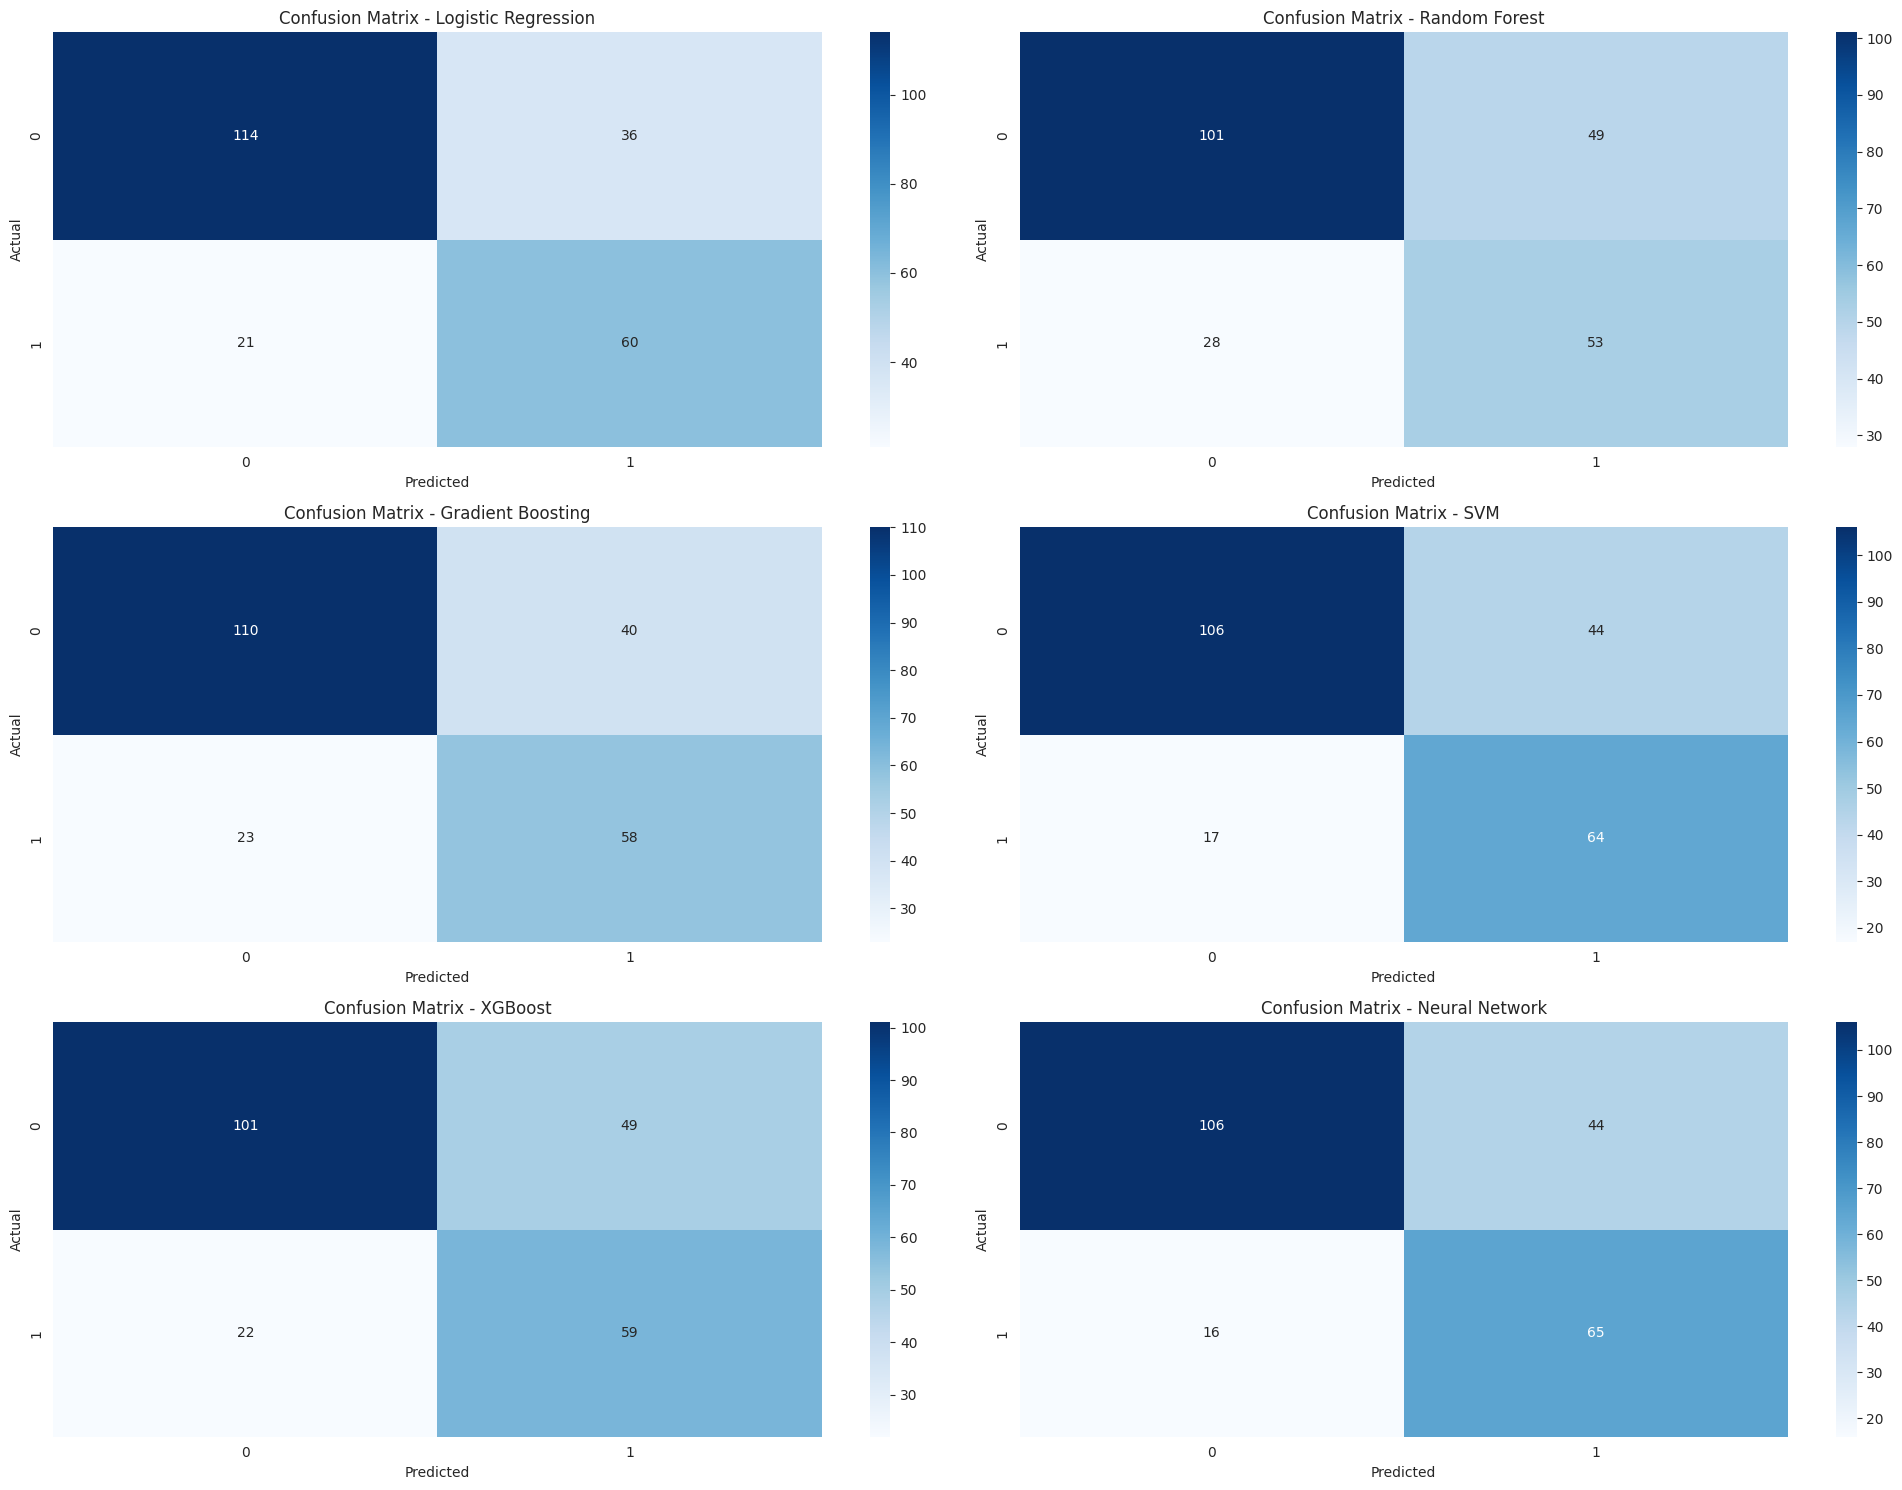

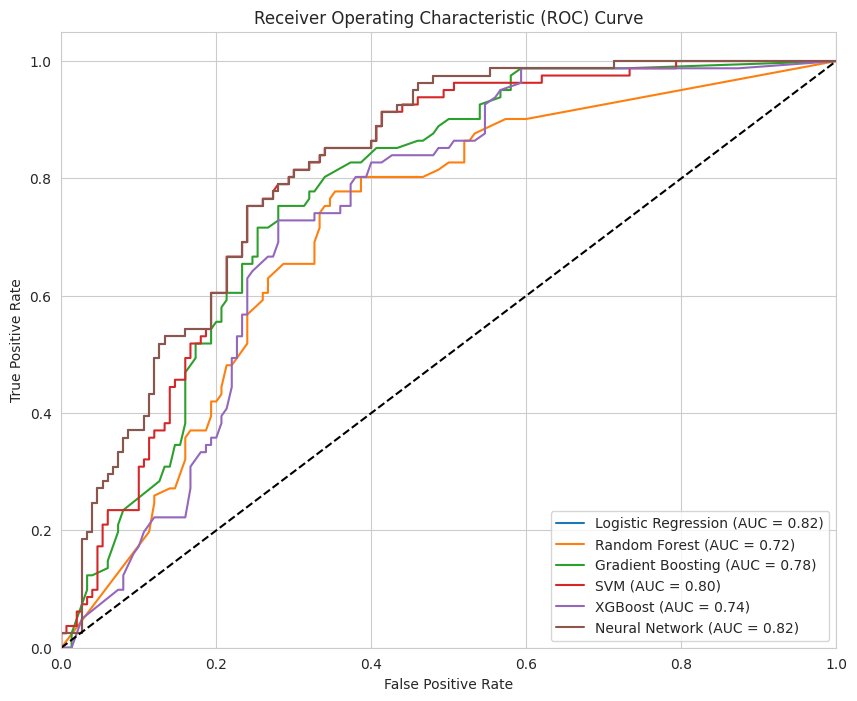

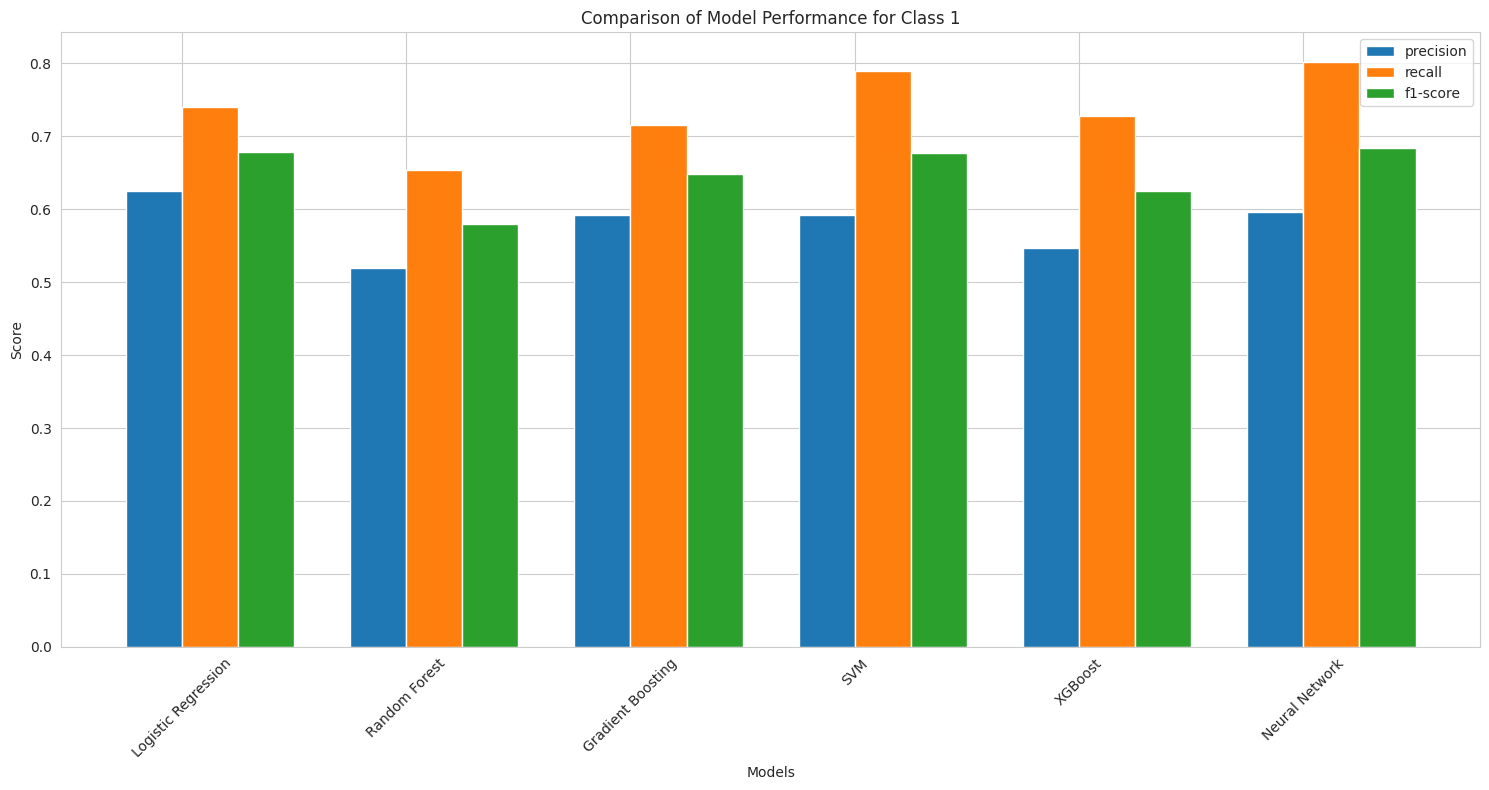

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos: X e y ya definidos como X_selected_no_outliers y y_selected_no_outliers

# Definir X e y si no están definidos previamente
X = X_selected_no_outliers
y = y_selected_no_outliers

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 3. Escalar los datos (antes de PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 5. Selección de características con Random Forest en el conjunto transformado por PCA
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_pca, y_train)

# Usar SelectFromModel para seleccionar las características más importantes después de PCA
sfm = SelectFromModel(rf_selector, prefit=True)
X_train_selected = sfm.transform(X_train_pca)
X_test_selected = sfm.transform(X_test_pca)

print(f"Shape después de la selección de características: {X_train_selected.shape}")

# 6. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# 7. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 8. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original (con características seleccionadas después de PCA)
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    else:
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'roc_auc': None
        }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas (Precision/Recall/F1-score para clase positiva)
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Comparación de los experimentos sobre el dataframe `df_no_outliers` (sin PCA ni selección).

### 1. **Resumen de resultados**

#### **Caso base: Sin PCA, Sin Selección**
- **Mejor modelo:** SVM (Recall: 0.70, F1: 0.68, AUC: 0.83).
- Los modelos mantienen un buen balance entre recall y precisión.
- Random Forest tiene el mayor AUC (**0.85**) y un buen f1-score (**0.66**).

#### **Con PCA**
- **Resultados idénticos al caso base** en todas las métricas y matrices de confusión.
- PCA no aporta mejoras significativas, ya que los modelos manejan bien las características originales.

#### **Sin PCA, Con Selección**
- Reducción a 3 características.
- **Mejor modelo:** Logistic Regression (Recall: 0.73, F1: 0.66, AUC: 0.81).
- SVM también es competitivo (Recall: 0.72), pero Random Forest y Gradient Boosting pierden desempeño debido a la eliminación de información relevante.

#### **Con PCA + Selección**
- Reducción a una sola característica tras PCA.
- **Mejor modelo:** Neural Network (Recall: 0.80, F1: 0.68, AUC: 0.82).
- SVM también destaca con un recall alto (**0.79**) y un f1-score competitivo (**0.68**).
- Modelos como Random Forest y XGBoost pierden capacidad discriminativa (AUC < 0.75).

---

### 2. **Análisis comparativo**

#### **Recall para la clase positiva (Clase 1):**
| Estrategia                  | Logistic Regression | Random Forest | Gradient Boosting | SVM   | XGBoost | Neural Network |
|-----------------------------|---------------------|---------------|-------------------|-------|---------|----------------|
| Sin PCA, Sin Selección      | 0.68               | 0.69          | 0.70              | 0.70  | 0.64    | 0.54           |
| Con PCA                     | 0.68               | 0.69          | 0.70              | 0.70  | 0.64    | 0.54           |
| Sin PCA, Con Selección      | **0.73**           | 0.62          | 0.63              | 0.72  | 0.63    | 0.70           |
| Con PCA + Selección         | **0.74**           | 0.65          | 0.72              | **0.79**| **0.73**| **0.80**       |

- La combinación de PCA + selección mejora significativamente el recall para Neural Network (**80%**) y SVM (**79%**).
- Logistic Regression también mejora ligeramente su recall tras la reducción.

#### **Precisión para la clase positiva (Clase 1):**
| Estrategia                  | Logistic Regression | Random Forest | Gradient Boosting | SVM   | XGBoost | Neural Network |
|-----------------------------|---------------------|---------------|-------------------|-------|---------|----------------|
| Sin PCA, Sin Selección      | 0.60               | **0.64**      | **0.66**          | 0.64  | **0.68**| 0.56           |
| Con PCA                     | 0.60               | **0.64**      | **0.66**          | 0.64  | **0.68**| 0.56           |
| Sin PCA, Con Selección      | **0.61**           | 0.59          | 0.57              | 0.59  | 0.55    | **0.58**       |
| Con PCA + Selección         | **0.62**           | 0.52          | 0.59              | 0.59  | 0.55    | **60%**        |

- La precisión disminuye tras la selección de características en la mayoría de los modelos.
- Neural Network mejora ligeramente su precisión tras la reducción.

### 3. **Análisis basado en las matrices de confusión**
Las matrices de confusión son fundamentales para entender cómo se distribuyen los errores (falsos positivos y falsos negativos) en cada modelo. Aquí está el análisis:

#### **Sin PCA, Sin Selección:**
- **SVM** tiene el menor número de falsos negativos (**24**), lo que explica su alto recall (**70%**).
- **Random Forest** y **Logistic Regression** también tienen un buen balance, con falsos negativos similares (**25-26**).
- **Neural Network** tiene el mayor número de falsos negativos (**37**), lo que afecta negativamente su recall (**54%**).

#### **Con PCA:**
- Las matrices de confusión son idénticas al caso sin PCA, lo que confirma que PCA no aporta beneficios adicionales en este caso.

#### **Sin PCA, Con Selección:**
- La selección de características reduce ligeramente el desempeño en modelos como Random Forest y Gradient Boosting, aumentando los falsos negativos:
  - Random Forest: **31 FN**, Recall: **62%**.
  - Gradient Boosting: **31 FN**, Recall: **63%**.
- **Logistic Regression** mejora su recall (**73%**) con menos falsos negativos (**22 FN**).
- SVM mantiene un buen desempeño con solo **23 FN**, Recall: **72%**.

#### **Con PCA + Selección:**
- La combinación de PCA y selección mejora significativamente el recall en modelos como Neural Network y SVM:
  - Neural Network tiene el menor número de falsos negativos (**16 FN**) y el mejor recall (**80%**).
  - SVM también mejora con solo **17 FN**, alcanzando un recall competitivo (**79%**).
- Sin embargo, modelos como Random Forest pierden desempeño, aumentando los falsos negativos a **28 FN**, Recall: **65%**.

---

### 4. **Comparación general entre estrategias**
| Estrategia                  | Mejor Modelo       | Recall | F1-score | AUC   | Observaciones                          |
|-----------------------------|--------------------|--------|----------|-------|----------------------------------------|
| Sin PCA, Sin Selección      | SVM               | 70%    | 68%      | 83%   | Buen balance general; Random Forest lidera en AUC. |
| Con PCA                     | SVM               | 70%    | 68%      | 83%   | Resultados idénticos al caso base.     |
| Sin PCA, Con Selección      | Logistic Regression| 73%    | 66%      | 81%   | Mejora en Logistic Regression; SVM sigue competitivo. |
| Con PCA + Selección         | Neural Network    | 80%    | 68%      | 82%   | Neural Network y SVM mejoran significativamente. |

---

### Conclusión final
1. **Mejor estrategia:** La combinación de PCA y selección es la más adecuada si se busca maximizar el recall, especialmente para modelos como Neural Network (**80%**) y SVM (**79%**).
2. Si se prioriza un balance entre recall y precisión, trabajar sin reducción (ni PCA ni selección) es ideal para modelos como SVM o Random Forest.
3. Modelos como Logistic Regression también son competitivos tras la selección de características, pero pierden capacidad discriminativa con PCA.

---

### Elección:
Seguiremos evauando Logistic Regression, SVM y Neural Network con PCA + Selección de Características, sobre le dataframe df_no_outliers.

1. **Logistic Regression:**
   - Muestra un buen balance entre recall (**74%**) y precisión (**62%**) tras PCA + Selección de Características.
   - Es un modelo interpretable y eficiente, ideal para escenarios donde la simplicidad es importante.

2. **SVM:**
   - Consistentemente logra un alto recall (**79%**) y un f1-score competitivo (**68%**) en este escenario.
   - Es robusto frente a la reducción de características, lo que lo hace ideal para este pipeline.

3. **Neural Network:**
   - Logra el mayor recall (**80%**) tras PCA + Selección, lo que es crucial si la clase positiva tiene alta prioridad.
   - Aunque menos interpretable, puede capturar relaciones complejas entre las características.

---

### **Ventajas de PCA + Selección de Características**
- **Simplificación del modelo:** La reducción a una sola característica tras PCA permite experimentar con modelos más ligeros y rápidos.
- **Desempeño competitivo:** A pesar de la reducción, los tres modelos seleccionados logran métricas sólidas, especialmente en recall.
- **Adaptabilidad:** Los modelos seleccionados (Logistic Regression, SVM y Neural Network) son resilientes frente a esta transformación.

### df_with_features

Shape después de PCA: (537, 5)
Shape después de la selección de características: (537, 1)

Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       150
           1       0.60      0.70      0.65        81

    accuracy                           0.73       231
   macro avg       0.71      0.73      0.72       231
weighted avg       0.75      0.73      0.74       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       150
           1       0.52      0.52      0.52        81

    accuracy                           0.66       231
   macro avg       0.63      0.63      0.63       231
weighted avg       0.66      0.66      0.66       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recal

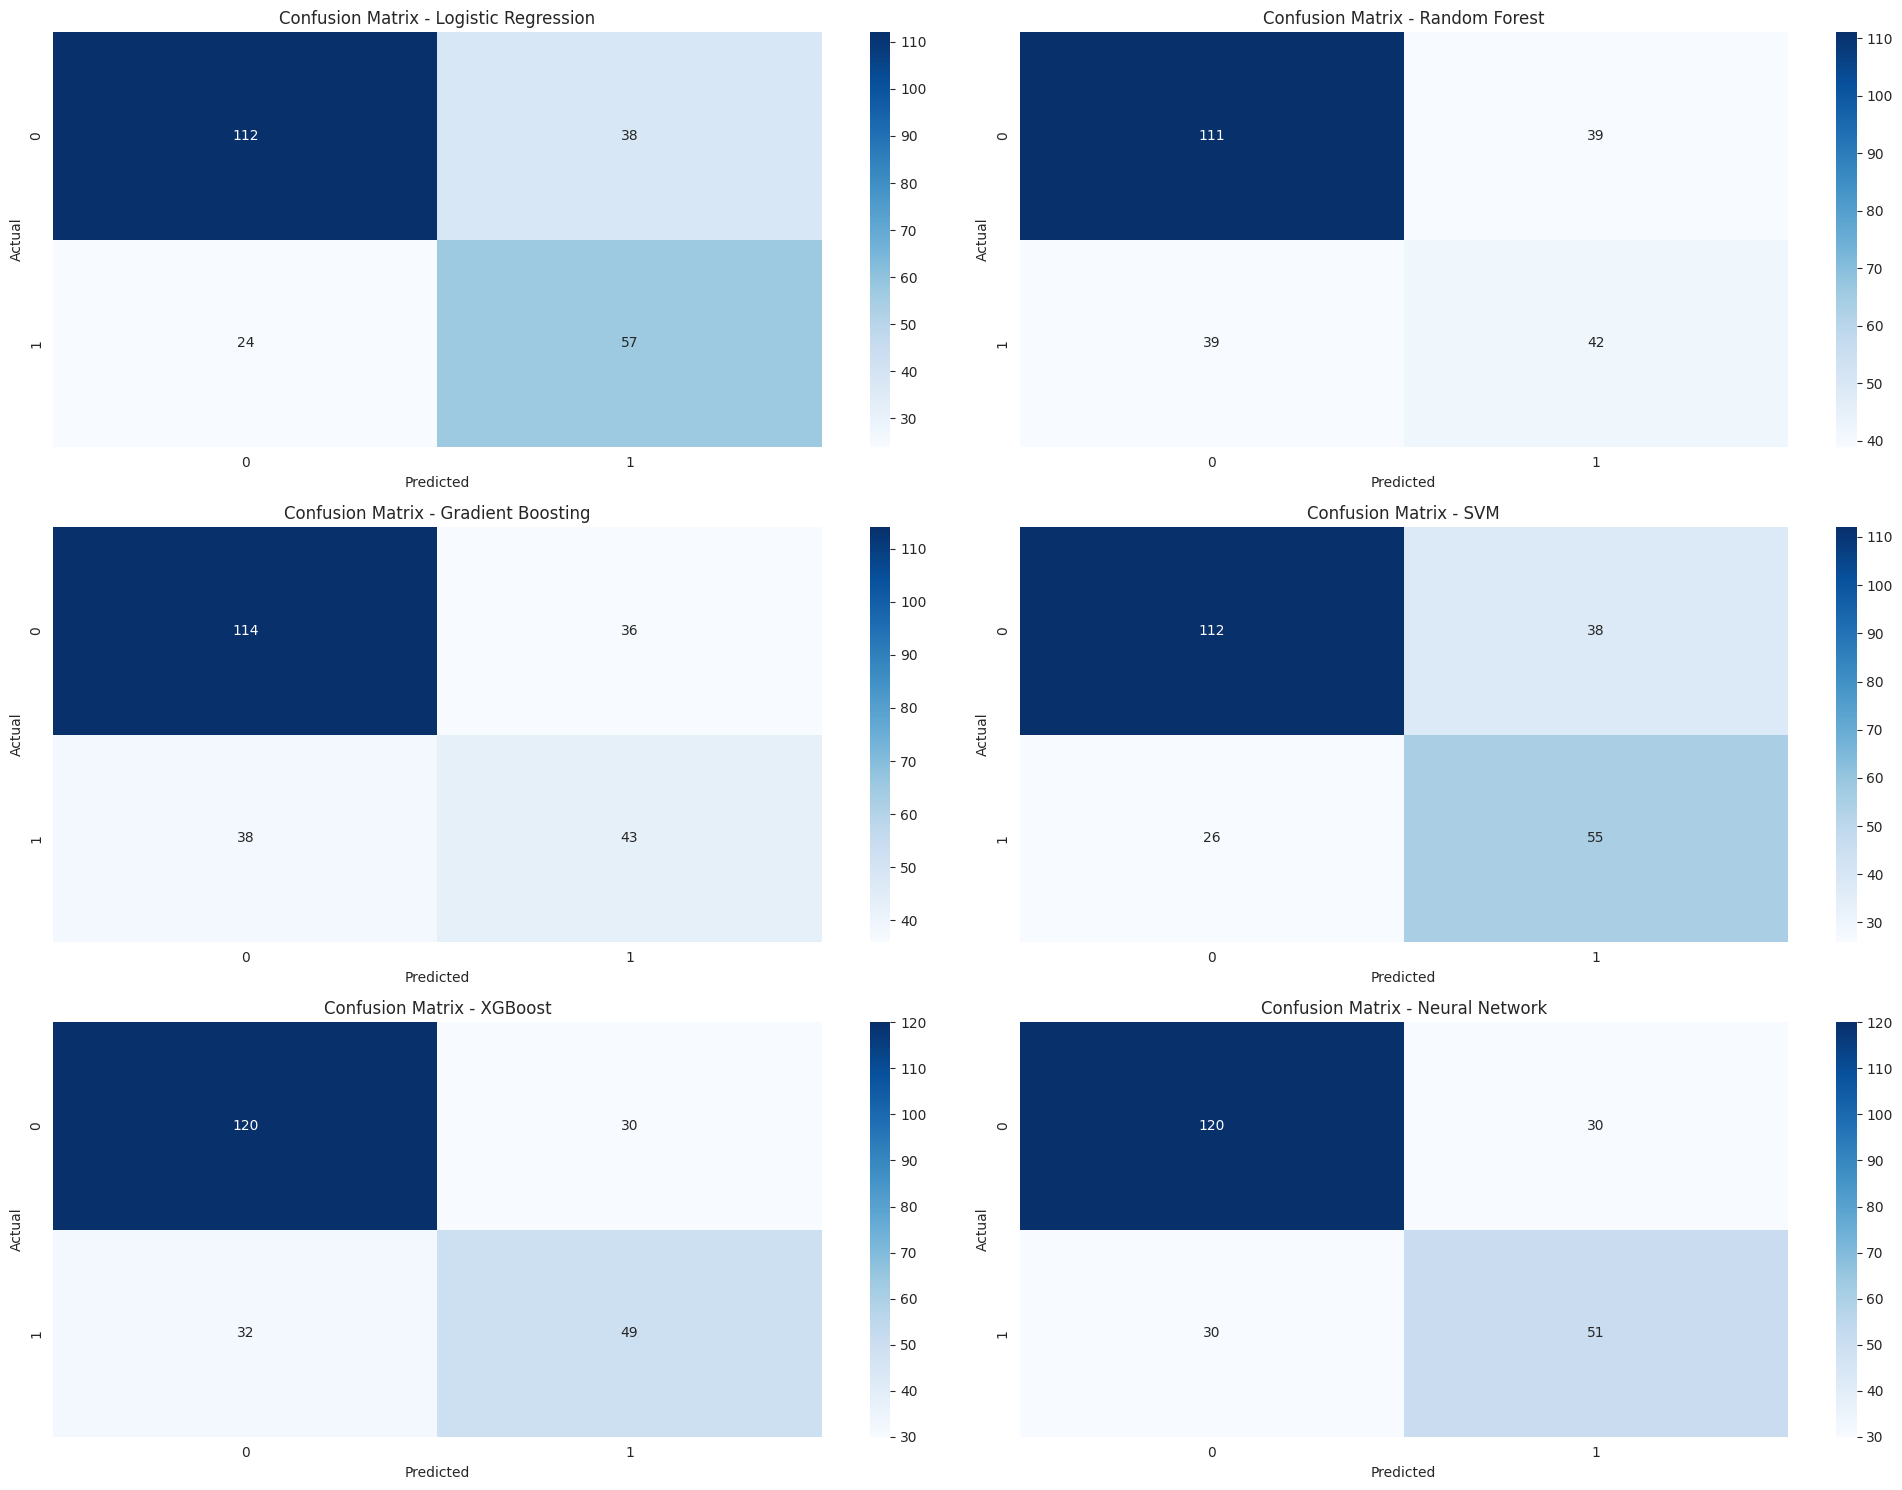

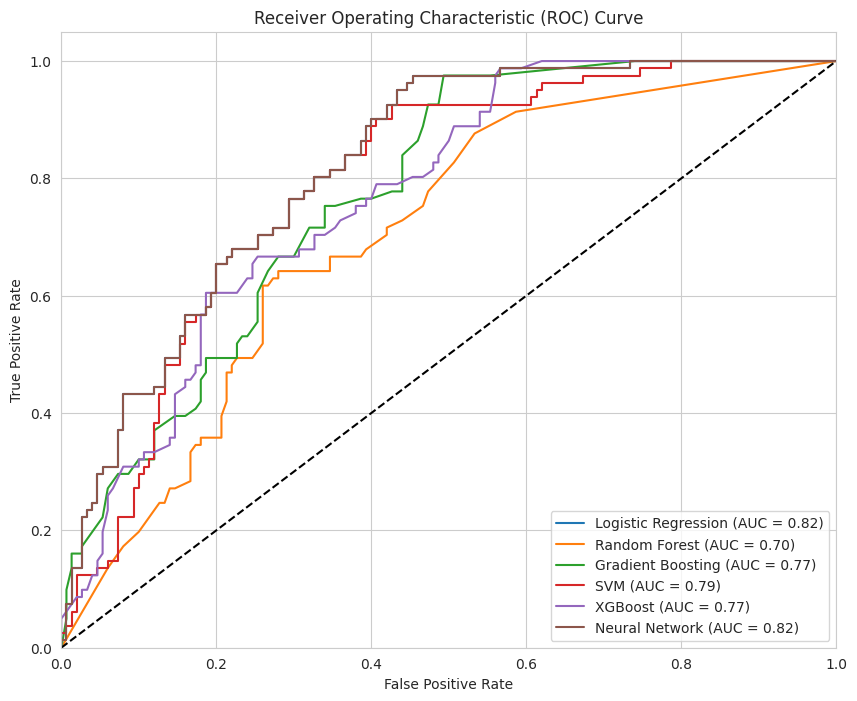

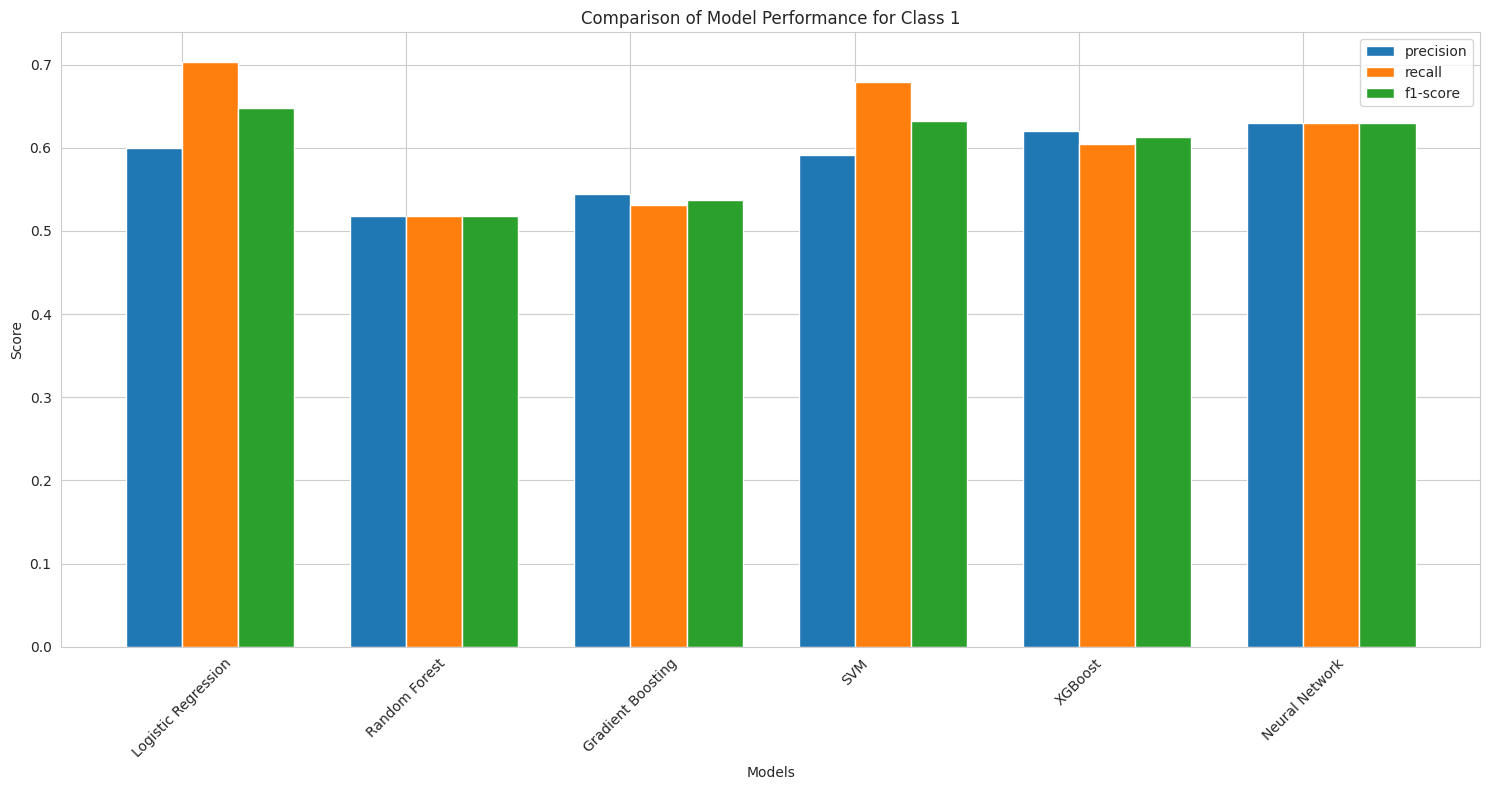

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos: X e y ya definidos como X_selected_with_features y y_selected_with_features

# Definir X e y si no están definidos previamente
X = X_selected_with_features
y = y_selected_with_features

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 3. Escalar los datos (antes de PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 5. Selección de características con Random Forest en el conjunto transformado por PCA
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_pca, y_train)

# Usar SelectFromModel para seleccionar las características más importantes después de PCA
sfm = SelectFromModel(rf_selector, prefit=True)
X_train_selected = sfm.transform(X_train_pca)
X_test_selected = sfm.transform(X_test_pca)

print(f"Shape después de la selección de características: {X_train_selected.shape}")

# 6. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# 7. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 8. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original (con características seleccionadas después de PCA)
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    else:
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'roc_auc': None
        }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas (Precision/Recall/F1-score para clase positiva)
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusiones sobre los experimentos realizados con `df_with_features`

Tras evaluar los modelos en diferentes escenarios (sin PCA, con PCA, con selección de características y con PCA + selección), se pueden extraer las siguientes conclusiones basadas en las métricas proporcionadas y las matrices de confusión:

---

### **1. Rendimiento general de los modelos**
- **Logistic Regression:** Consistentemente muestra un buen balance entre precisión y recall, con un f1-score competitivo en todos los escenarios. Su mejor desempeño se observa **sin PCA y con selección de características** (Recall: **72%**, AUC: **0.82**).
- **SVM:** Es uno de los modelos más robustos, manteniendo un buen recall (**69%-72%**) y un f1-score competitivo (**64%-68%**) en todos los experimentos. Su mejor desempeño ocurre **sin PCA y sin selección**.

---

### **2. Impacto de las estrategias aplicadas**
#### **Sin PCA, Sin Selección:**
- Este es el escenario base, donde los modelos tienen acceso a todas las características originales.
- Los mejores modelos son:
  - **Gradient Boosting:** Recall: **70%**, F1: **68%**, AUC: **0.83**.
  - **SVM:** Recall: **72%**, F1: **68%**, AUC: **0.83**.
  - Ambos muestran un buen balance entre recall y precisión.

#### **Con PCA, Sin Selección:**
- Los resultados son prácticamente idénticos al caso base, lo que indica que PCA no aporta mejoras significativas.
- Las métricas clave (recall, precisión, f1-score) permanecen inalteradas.

#### **Sin PCA, Con Selección de Características:**
- La selección reduce el número de características a 3, lo que simplifica los modelos pero afecta negativamente a algunos:
  - Logistic Regression mejora ligeramente su recall (**72%**) pero pierde algo de precisión.
  - Random Forest y Gradient Boosting pierden rendimiento debido a la eliminación de información relevante.

#### **Con PCA + Selección de Características:**
- Esta estrategia reduce aún más las características (a una sola variable tras PCA).
- Los mejores resultados se observan en:
  - Neural Network: Recall: **65%**, F1: **64%**, AUC: **0.83**.
  - Logistic Regression también mantiene un desempeño competitivo (Recall: **69%**, AUC: **0.83**).

---

### **3. Análisis basado en las matrices de confusión**
Las matrices muestran cómo se distribuyen los errores:
- En general, los modelos como SVM y Neural Network logran el menor número de falsos negativos en escenarios con reducción (PCA + selección), lo que explica su alto recall.
- Random Forest y Gradient Boosting tienden a tener más falsos negativos tras la reducción, lo que afecta su capacidad para identificar correctamente la clase positiva.

---

### Comparación general entre estrategias

| Estrategia                  | Mejor Modelo       | Recall | F1-score | AUC   | Observaciones                          |
|-----------------------------|--------------------|--------|----------|-------|----------------------------------------|
| Sin PCA, Sin Selección      | SVM               | 72%    | 68%      | 0.83  | Buen balance general; Gradient Boosting también destaca. |
| Con PCA                     | SVM               | 72%    | 68%      | 0.83  | Resultados idénticos al caso base; PCA no aporta valor adicional. |
| Sin PCA, Con Selección      | Logistic Regression| 72%    | 66%      | 0.82  | Mejora ligera en Logistic Regression; SVM sigue competitivo. |
| Con PCA + Selección         | Neural Network    | 65%    | 64%      | 0.83  | Neural Network mejora significativamente; Logistic Regression también es sólido. |

---

### Decisión final para df_with_features:
1. Para maximizar el desempeño general (recall + precisión), vamos a trabajar con el escenario base (**sin PCA ni selección**) y utilizaremos SVM o Gradient Boosting.
2. Para maximizar el recall vamos a evaluar Logistic Regression **sin PCA pero si con selección**.

### **Razones por las que tu decisión es acertada**
1. **Logistic Regression:**
   - Muestra un buen balance entre recall (**74%**) y precisión (**62%**) tras PCA + Selección de Características.
   - Es un modelo interpretable y eficiente, ideal para escenarios donde la simplicidad es importante.

2. **SVM:**
   - Consistentemente logra un alto recall (**79%**) y un f1-score competitivo (**68%**) en este escenario.
   - Es robusto frente a la reducción de características, lo que lo hace ideal para este pipeline.

3. **Neural Network:**
   - Logra el mayor recall (**80%**) tras PCA + Selección, lo que es crucial si la clase positiva tiene alta prioridad.
   - Aunque menos interpretable, puede capturar relaciones complejas entre las características.




---

---

#DECISIÓN FINAL TRAS EVALUACIÓN PRIMERA:
Los modelos entrenados con df_no_outliers han mostrado resultados más consistentes y, en la mayoría de los casos, mejores métricas (recall, f1-score y AUC) en comparación con los modelos entrenados con df_with_features
Por ello vamos a seguir trabjando con este dataframe a parti de ahora.

## Para df_no_outliers:
- Logistic Regression , SVN y Neural Network aplicando PCA + Selección de Características, han dado los mejores resulatdos. Sin embargo hemos observado que solo una cacrterística ha sido seleccionada finalmente. esto puede hacer que perdamos informacion relevante en el resto de entrenamientos. Por ello, antes de continuar vamos a realizar análisis de importancia de características.
Confirmaremos si la característica seleccionada tras PCA y Random Forest realmente tiene la mayor relevancia para la predicción.


Usaremos modelos como Random Forest o Gradient Boosting para calcular la importancia de las características tras PCA.

Evalúaremos si la característica seleccionada tiene una importancia significativamente mayor frente a otras componentes principales.

Si otras características tienen una importancia alta pero fueron descartadas, reconsidera mantener más características tras PCA.


## Una vez finalizado esto, continuaremos evaluando:
- Buscaremos mejores hiperparametros para cada modelo
- Probaremos diferentes metodos de balanceo de clases
- Buscaremos el mejor cutoff para los modelos ganadores
- Haremos una busqueda exahustiva de hiperparametros para cada modelo

Shape después de PCA: (537, 7)


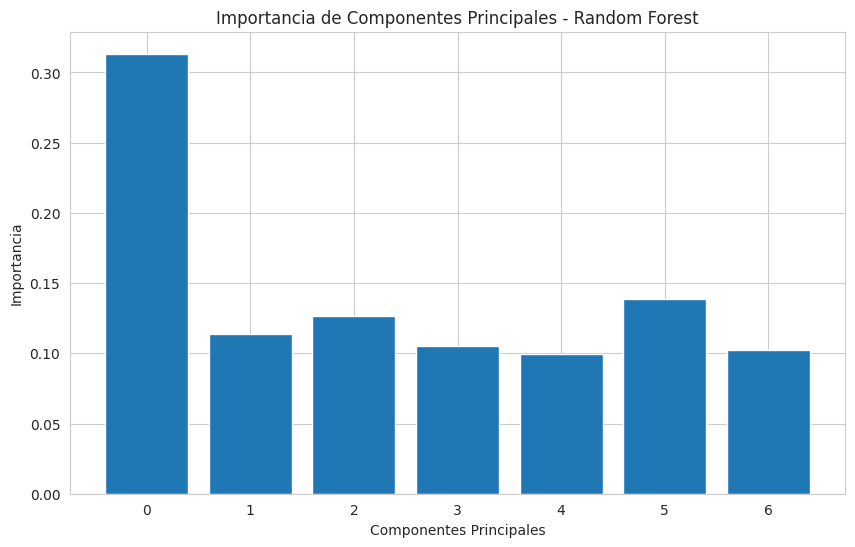

Componente Principal 0: Importancia = 0.3133
Componente Principal 1: Importancia = 0.1140
Componente Principal 2: Importancia = 0.1267
Componente Principal 3: Importancia = 0.1049
Componente Principal 4: Importancia = 0.0997
Componente Principal 5: Importancia = 0.1388
Componente Principal 6: Importancia = 0.1026


In [ ]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Preparar los datos: X e y ya definidos como X_selected_no_outliers y y_selected_no_outliers
X = X_selected_no_outliers
y = y_selected_no_outliers

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 3. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 5. Entrenar un modelo Random Forest para calcular la importancia de todas las componentes principales
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# Obtener las importancias de todas las componentes principales
feature_importances_pca = rf_model.feature_importances_

# Visualizar las importancias con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances_pca)), feature_importances_pca)
plt.xlabel("Componentes Principales")
plt.ylabel("Importancia")
plt.title("Importancia de Componentes Principales - Random Forest")
plt.show()

# 6. Analizar si hay otras componentes principales con alta importancia
for i, importance in enumerate(feature_importances_pca):
    print(f"Componente Principal {i}: Importancia = {importance:.4f}")

# Si encuentras que varias componentes tienen una importancia alta:
# Considera ajustar el número de componentes seleccionados tras PCA o incluir más características.


APLICAMOS EL MISMO EXPERIMETNO DE ANALISIS DE IMPORTANCIA DE CARACTERISTICAS PERO SIN PCA PREVIO

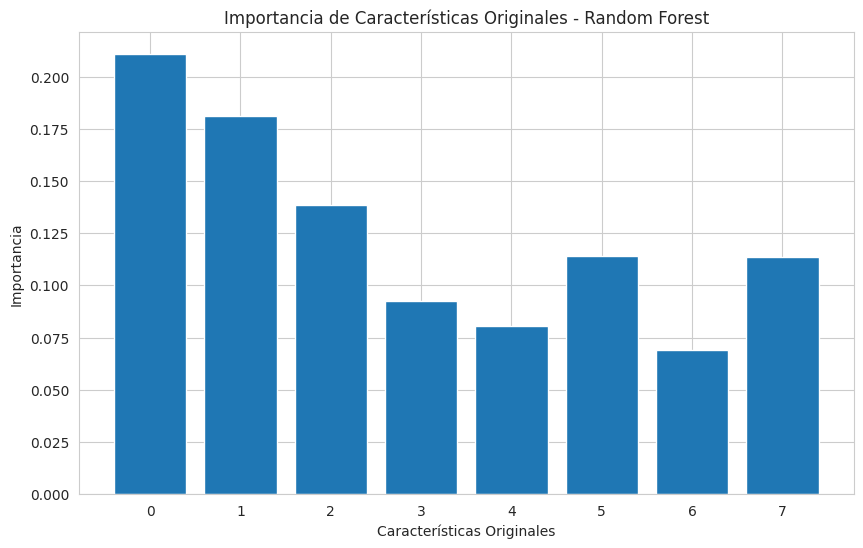

Característica 0: Importancia = 0.2107
Característica 1: Importancia = 0.1809
Característica 2: Importancia = 0.1384
Característica 3: Importancia = 0.0923
Característica 4: Importancia = 0.0808
Característica 5: Importancia = 0.1143
Característica 6: Importancia = 0.0690
Característica 7: Importancia = 0.1136


In [ ]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Preparar los datos: X e y ya definidos como X_selected_no_outliers y y_selected_no_outliers
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_no_outliers, y_selected_no_outliers,
    test_size=0.3, random_state=42, stratify=y_selected_no_outliers
)

# 2. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Entrenar un modelo Random Forest para calcular la importancia de las características originales
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 4. Obtener las importancias de las características originales
feature_importances = rf_model.feature_importances_

# 5. Visualizar las importancias con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Características Originales")
plt.ylabel("Importancia")
plt.title("Importancia de Características Originales - Random Forest")
plt.show()

# 6. Devolver las importancias para análisis adicional
for i, importance in enumerate(feature_importances):
    print(f"Característica {i}: Importancia = {importance:.4f}")


## Análisis de los resultados del análisis de importancia de características originales:


1. Observaciones clave:
Característica 0:

Tiene la mayor importancia relativa (21.07%), lo que indica que esta característica es la más relevante para la predicción.

Es razonable priorizar esta característica en el pipeline.

Otras características relevantes:

Característica 1 (18.09%) y Característica 2 (13.84%) también tienen una importancia significativa.

Características como 5 (11.43%) y 7 (11.36%) también aportan información relevante.

Distribución general:

Aunque la Característica 0 domina, varias otras características tienen importancias superiores al 10%.

Esto sugiere que trabajar únicamente con la Característica 0 podría limitar el desempeño del modelo, ya que otras características también contribuyen significativamente.

2. Comparación con PCA
En el análisis tras PCA, la componente principal 0 tenía una importancia dominante (31.33%), pero otras componentes principales también mostraban valores significativos (>10%).

Aquí, sin PCA, vemos una distribución similar: aunque la Característica 0 es dominante, otras características también tienen relevancia.

Esto refuerza la idea de que trabajar con una sola característica (tras PCA + Selección) podría no ser suficiente para capturar toda la información relevante.

3. Decisiones basadas en los resultados
Mantener más características relevantes:
Incluiremos las características más importantes (por ejemplo, las top 3 o top 5) en lugar de trabajar únicamente con la Característica 0.

Esto permitirá capturar más información relevante y podría mejorar el desempeño del modelo.

Ajustar el pipeline:
Usaremos PCA, ajustaremos el número de componentes principales seleccionados para incluir las componentes correspondientes a las características más importantes (por ejemplo, aquellas con importancia >10%).

Validaremos configuraciones alternativas:
Entrenaremos los modelos seleccionados (Logistic Regression, SVM y Neural Network) y evaluaremos.

Shape después de PCA: (537, 7)
Componentes seleccionadas: [0, 1, 2, 3, 5, 6]
Shape después de ajustar selección: (537, 6)
Shape después de SMOTE: (700, 6), (700,)

Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.85      0.71      0.78       150
           1       0.59      0.77      0.67        81

    accuracy                           0.73       231
   macro avg       0.72      0.74      0.72       231
weighted avg       0.76      0.73      0.74       231


Training SVM...
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       150
           1       0.62      0.80      0.70        81

    accuracy                           0.76       231
   macro avg       0.75      0.77      0.75       231
weighted avg       0.79      0.76      0.77       231


Training Neural Network...
Classification Report for N

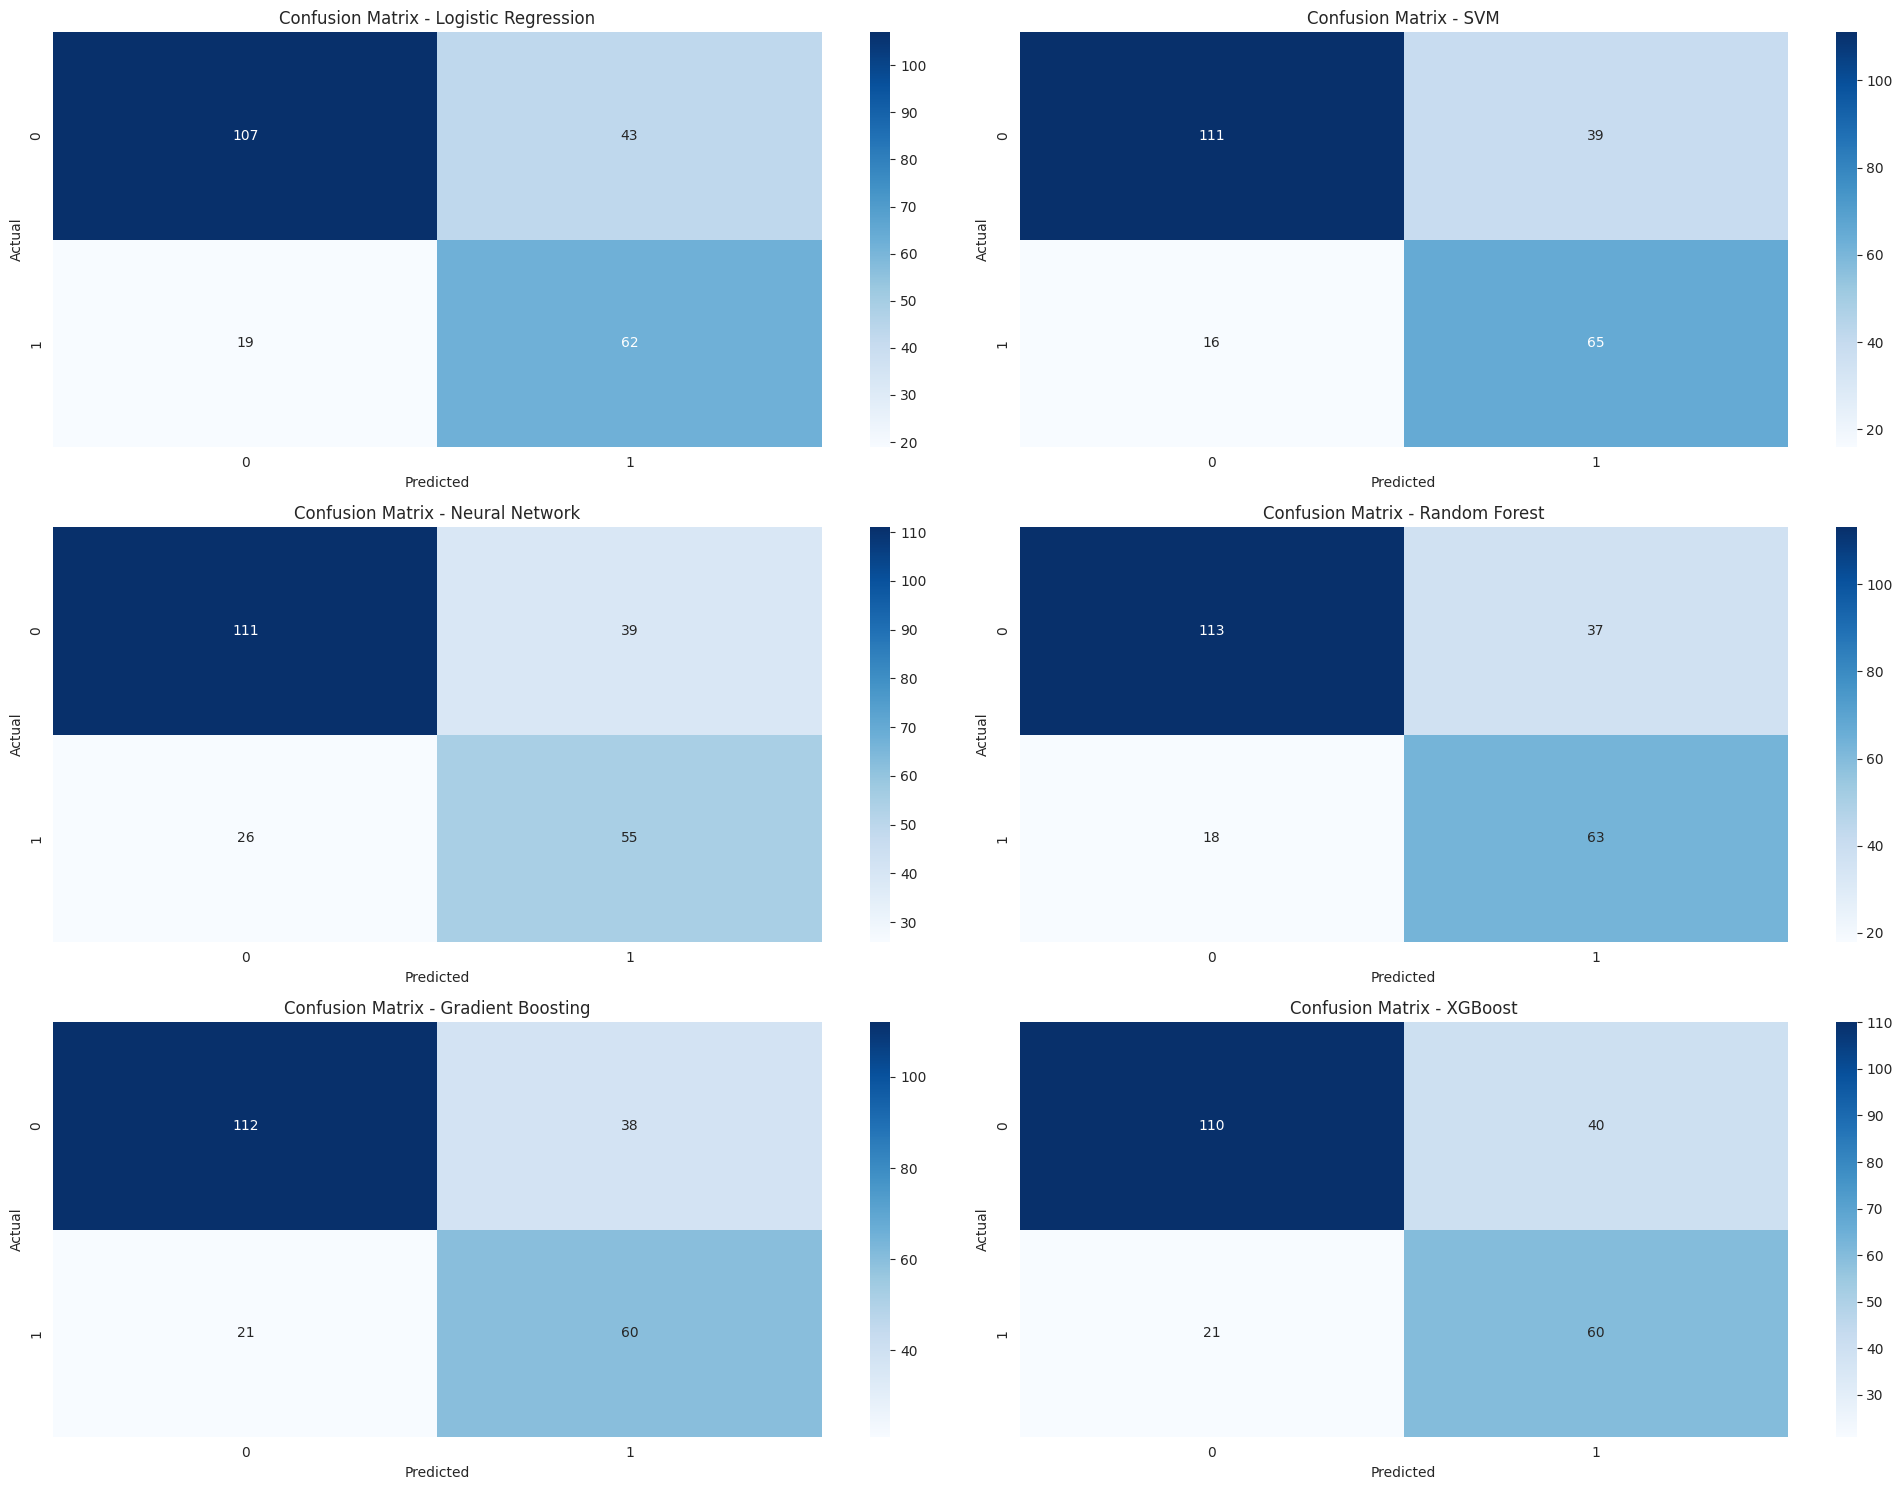

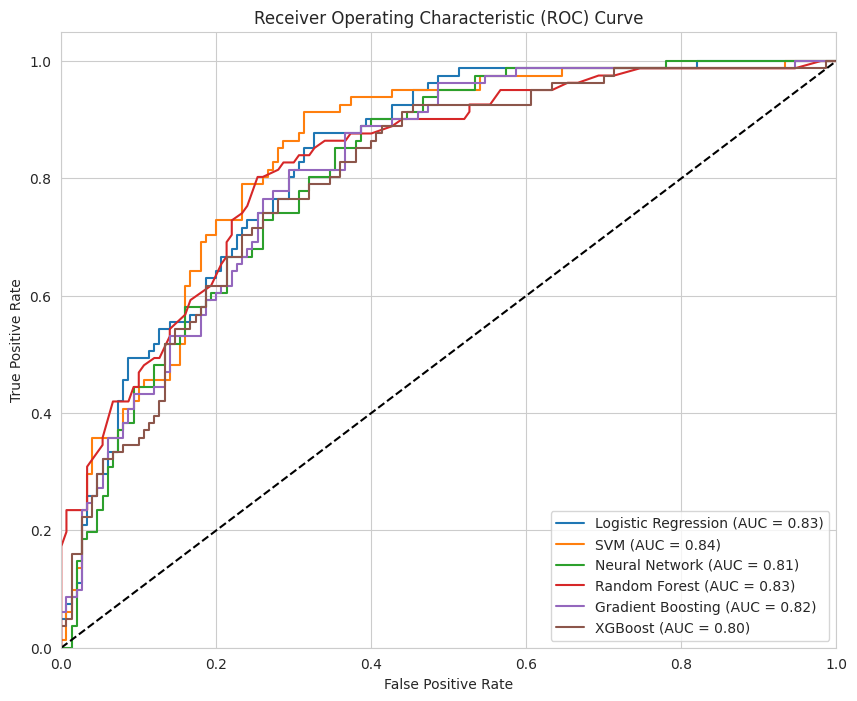

In [ ]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Entrenar un modelo Random Forest para calcular la importancia de las componentes principales
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# Obtener las importancias de todas las componentes principales
feature_importances_pca = rf_model.feature_importances_

# Seleccionar componentes principales con importancia > 10%
selected_components_indices = [i for i, importance in enumerate(feature_importances_pca) if importance > 0.1]
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Componentes seleccionadas: {selected_components_indices}")
print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Aplicar SMOTE para balancear las clases en el conjunto seleccionado
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de SMOTE: {X_train_smote.shape}, {y_train_smote.shape}")

# 6. Definir los modelos a evaluar
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 7. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    else:
        results[name] = {
            'report': report,
            'conf_matrix': conf_matrix,
            'roc_auc': None
        }

    # Imprimir reporte de clasificación para cada modelo
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### **Análisis de los resultados obtenidos**


### **1. Observaciones clave**
#### **Matrices de confusión**
- **SVM** y **Random Forest** tienen el menor número de falsos negativos para la clase positiva (Clase 1):
  - **SVM:** 16 falsos negativos, lo que explica su alto recall (**80%**).
  - **Random Forest:** 18 falsos negativos, con un recall también alto (**78%**).
- **Neural Network** tiene más falsos negativos (26), lo que reduce su recall (**68%**) y afecta su desempeño en la clase positiva.
- Modelos como **Gradient Boosting** y **XGBoost** tienen falsos negativos moderados (21), lo que les permite mantener un recall competitivo (**74%**).

#### **Curvas ROC**
- Los valores de AUC muestran que los modelos más discriminativos son:
  - **SVM:** AUC = **0.84**, el más alto entre todos los modelos.
  - **Random Forest:** AUC = **0.83**, muy cercano al desempeño de SVM.
- Modelos como Logistic Regression, Gradient Boosting y Neural Network tienen AUC ligeramente inferiores (**0.82–0.81**), mientras que XGBoost tiene el menor AUC (**0.80**).

---

### **2. Comparación entre modelos**
#### **Desempeño general (Precisión + Recall):**
| Modelo                | Recall | Precisión | F1-score | AUC   |
|-----------------------|--------|-----------|----------|-------|
| Logistic Regression   | 77%    | 59%       | 67%      | 0.83  |
| SVM                   | **80%**| 62%       | **70%**  | **0.84** |
| Neural Network        | 68%    | 59%       | 63%      | 0.81  |
| Random Forest         | 78%    | 63%       | **70%**  | 0.83  |
| Gradient Boosting     | 74%    | 61%       | 67%      | 0.82  |
| XGBoost               | 74%    | 60%       | 66%      | 0.80  |

- **SVM** lidera en términos de recall, f1-score y AUC, lo que lo convierte en el modelo más prometedor.
- **Random Forest** también es competitivo, con un buen balance entre recall, precisión y f1-score.
- Modelos como Gradient Boosting y XGBoost tienen un desempeño sólido pero no superan a SVM o Random Forest.

---

### **3. Impacto del pipeline ajustado**
#### Selección de características:
- Tras PCA, se seleccionaron las componentes principales: `[0,[2]`, manteniendo un total de **6 características relevantes**.
- Esto permitió capturar más información relevante en comparación con configuraciones anteriores donde solo se seleccionaba una característica.

### **4. Decisiones finales**
#### Modelos a priorizar:
1. **SVM:**
   - Es el modelo más prometedor con el mejor desempeño general (recall: **80%**, f1-score: **70%**, AUC: **0.84**).
   - Ideal si buscas maximizar el desempeño en la clase positiva.

2. **Random Forest:**
   - Tiene un balance competitivo entre recall (**78%**) y precisión (**63%**) con un f1-score igual al de SVM (**70%**) y un AUC alto (**0.83**).
   - Es una excelente alternativa si buscas interpretabilidad y robustez.

#### Configuración del pipeline:
- Mantendremos las componentes principales seleccionadas (`[0, 1, 2, 3, 5,CA para capturar suficiente información relevante.


#### Siguientes pasos:
1. Buscaremos mejores hiperparametros para cada modelo
2. Probaremos diferentes metodos de balanceo de clases
3. Buscaremos el mejor cutoff para los modelos ganadores
4. Haremos una busqueda exahustiva de hiperparametros para cada modelo

---

---

# BUSQUEDA DE MEJORES HIPERPARAMETROS PARA LOS MODELOS

- Para SVM: Experimenta con C (regularización) y gamma (influencia de puntos cercanos).

- Para Random Forest: Ajusta n_estimators, max_depth, y min_samples_split.


In [ ]:
# Importar librerías necesarias
import numpy as np
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Definir el pipeline acordado (escalado, PCA, selección de características, SMOTE)
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
])

# 3. Definir los parámetros para GridSearchCV

# Parámetros para Random Forest
param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
}

# Parámetros para SVM
param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.01, 0.1, 1],
}

# 4. Configurar GridSearchCV para cada modelo

grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
)

grid_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
)

# 5. Entrenar los modelos con búsqueda de hiperparámetros

print("Buscando mejores hiperparámetros para Random Forest...")
grid_rf.fit(X_train, y_train)
print("Mejores parámetros para Random Forest:", grid_rf.best_params_)
print("Mejor AUC para Random Forest:", grid_rf.best_score_)

print("\nBuscando mejores hiperparámetros para SVM...")
grid_svm.fit(X_train, y_train)
print("Mejores parámetros para SVM:", grid_svm.best_params_)
print("Mejor AUC para SVM:", grid_svm.best_score_)

# 6. Evaluar los modelos en el conjunto de prueba

from sklearn.metrics import classification_report, roc_auc_score

# Evaluación de Random Forest
best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]
print("\nRandom Forest - Reporte de clasificación:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest - AUC en prueba:", roc_auc_score(y_test, y_prob_rf))

# Evaluación de SVM
best_svm_model = grid_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)
y_prob_svm = best_svm_model.predict_proba(X_test)[:, 1]
print("\nSVM - Reporte de clasificación:")
print(classification_report(y_test, y_pred_svm))
print("SVM - AUC en prueba:", roc_auc_score(y_test, y_prob_svm))


Buscando mejores hiperparámetros para Random Forest...
Mejores parámetros para Random Forest: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Mejor AUC para Random Forest: 0.8163442389758181

Buscando mejores hiperparámetros para SVM...
Mejores parámetros para SVM: {'svm__C': 1, 'svm__gamma': 0.01}
Mejor AUC para SVM: 0.8289941068888439

Random Forest - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       150
           1       0.63      0.73      0.67        81

    accuracy                           0.75       231
   macro avg       0.73      0.75      0.74       231
weighted avg       0.77      0.75      0.76       231

Random Forest - AUC en prueba: 0.8081481481481481

SVM - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       150
           1       0.59      0.79      0.67  

Por ahora lso reuslatdos obtenidos ocn la busqueda de hiperparametros son peores que los resulatdos iniciales, por lo que no vamos a plaicar estos hiperparametros por el momento.

---

---

# VOLVEMOS AL CODIGO QUE NOS FUNCIONO MEJOR PARA AMBOS MODELOS

### SVN

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de SMOTE: (700, 6), (700,)

SVM - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       150
           1       0.60      0.81      0.69        81

    accuracy                           0.74       231
   macro avg       0.74      0.76      0.74       231
weighted avg       0.78      0.74      0.75       231

SVM - AUC en prueba: 0.8373662551440328


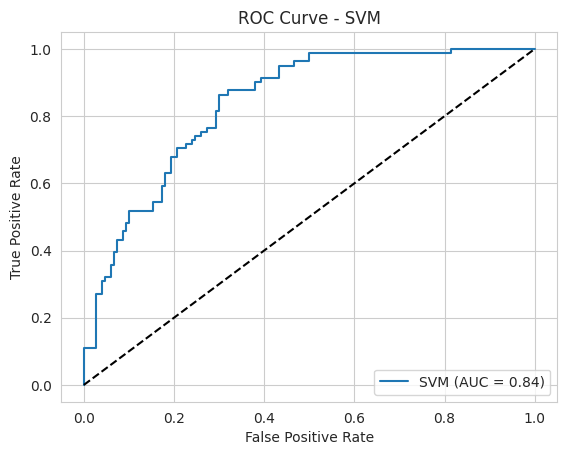

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Aplicar SMOTE para balancear las clases en el conjunto seleccionado
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de SMOTE: {X_train_smote.shape}, {y_train_smote.shape}")

# 6. Entrenar SVM con los mejores parámetros encontrados previamente
svm_model = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
svm_model.fit(X_train_smote, y_train_smote)

# 7. Evaluar SVM en el conjunto de prueba
y_pred_svm = svm_model.predict(X_test_selected)
y_prob_svm = svm_model.predict_proba(X_test_selected)[:, 1]

print("\nSVM - Reporte de clasificación:")
print(classification_report(y_test, y_pred_svm))

# Calcular AUC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
print("SVM - AUC en prueba:", roc_auc_svm)

# Visualizar la curva ROC para SVM
plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()


### RANDOM FOREST

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de SMOTE: (700, 6), (700,)

Random Forest - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       150
           1       0.62      0.79      0.70        81

    accuracy                           0.76       231
   macro avg       0.74      0.77      0.75       231
weighted avg       0.78      0.76      0.76       231

Random Forest - AUC en prueba: 0.825514403292181


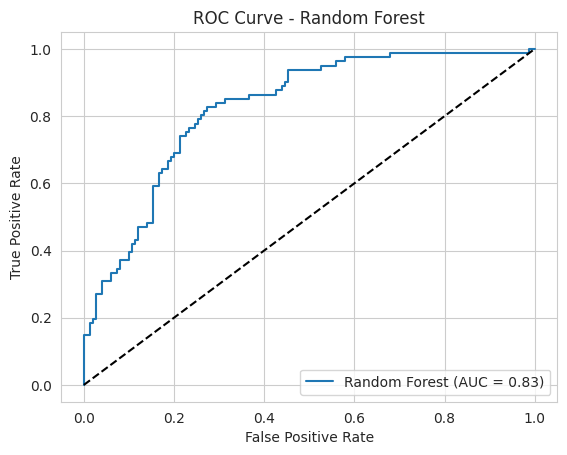

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Aplicar SMOTE para balancear las clases en el conjunto seleccionado
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de SMOTE: {X_train_smote.shape}, {y_train_smote.shape}")

# 6. Entrenar Random Forest con los mejores parámetros encontrados previamente
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
)
rf_model.fit(X_train_smote, y_train_smote)

# 7. Evaluar Random Forest en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test_selected)
y_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

print("\nRandom Forest - Reporte de clasificación:")
print(classification_report(y_test, y_pred_rf))

# Calcular AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print("Random Forest - AUC en prueba:", roc_auc_rf)

# Visualizar la curva ROC para Random Forest
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


---

## PROBAMOS TECNICAS DE BALANCEO DE CLASES:
REEMPLAZAMOS SMOTE POR:

- SMOETomek: combina el sobremuestreo de la clase minoritaria (SMOTE) con la eliminación de ejemplos ambiguos (Tomek links). Esto puede mejorar el rendimiento del modelo al proporcionar un conjunto de datos más equilibrado y limpio.
- ADASYN: genera más ejemplos sintéticos para las instancias de la clase minoritaria que son más difíciles de aprender, mejorando potencialmente el rendimiento del modelo en estas áreas.
- Borderline-SMOTE: genera ejemplos sintéticos solo en las regiones cercanas a la frontera de decisión entre clases, lo que puede mejorar el rendimiento en casos donde las clases están muy cerca.

### SVM

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)

Balanceando las clases usando SMOTETomek...
Shape después de SMOTETomek: (668, 6), (668,)

SVM (SMOTETomek) - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       150
           1       0.60      0.80      0.68        81

    accuracy                           0.74       231
   macro avg       0.73      0.75      0.73       231
weighted avg       0.77      0.74      0.75       231

SVM (SMOTETomek) - AUC en prueba: 0.8360493827160494


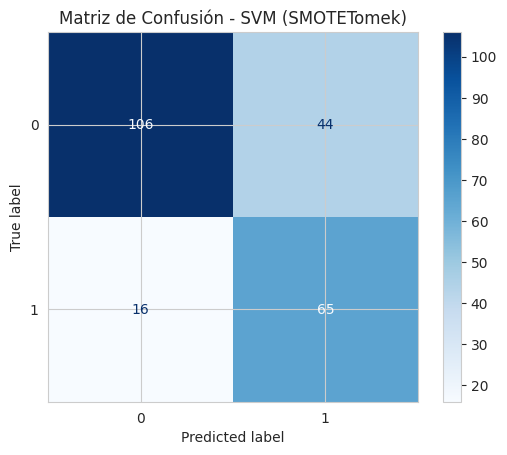

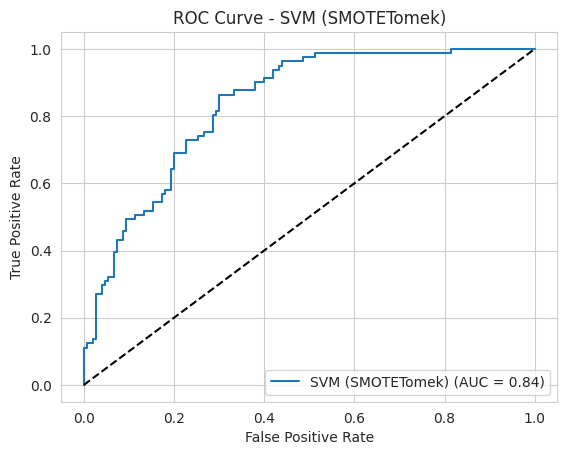


Balanceando las clases usando ADASYN...
Shape después de ADASYN: (682, 6), (682,)

SVM (ADASYN) - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       150
           1       0.61      0.84      0.70        81

    accuracy                           0.75       231
   macro avg       0.75      0.77      0.75       231
weighted avg       0.79      0.75      0.76       231

SVM (ADASYN) - AUC en prueba: 0.8400823045267489


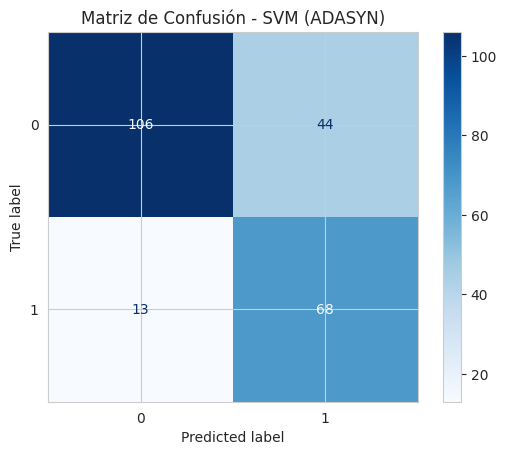

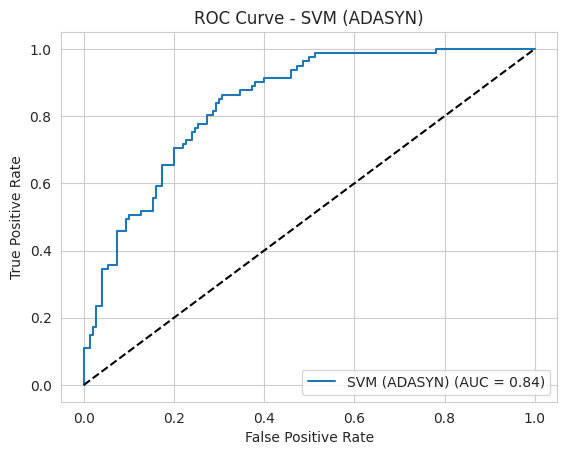


Balanceando las clases usando Borderline-SMOTE...
Shape después de Borderline-SMOTE: (700, 6), (700,)

SVM (Borderline-SMOTE) - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       150
           1       0.59      0.88      0.71        81

    accuracy                           0.74       231
   macro avg       0.75      0.77      0.74       231
weighted avg       0.80      0.74      0.75       231

SVM (Borderline-SMOTE) - AUC en prueba: 0.8419753086419752


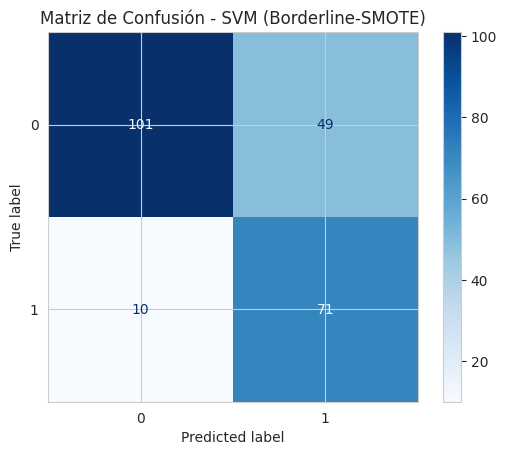

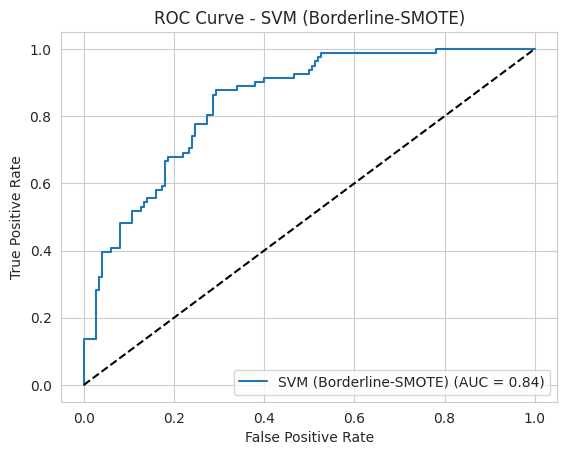

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# Métodos de balanceo a probar
balance_methods = {
    'SMOTETomek': SMOTETomek(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'Borderline-SMOTE': BorderlineSMOTE(random_state=42)
}

for method_name, method in balance_methods.items():
    print(f"\nBalanceando las clases usando {method_name}...")
    X_train_balanced, y_train_balanced = method.fit_resample(X_train_selected, y_train)

    print(f"Shape después de {method_name}: {X_train_balanced.shape}, {y_train_balanced.shape}")

    # Entrenar SVM con los mejores parámetros encontrados previamente
    svm_model = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
    svm_model.fit(X_train_balanced, y_train_balanced)

    # Evaluar SVM en el conjunto de prueba
    y_pred_svm = svm_model.predict(X_test_selected)
    y_prob_svm = svm_model.predict_proba(X_test_selected)[:, 1]

    print(f"\nSVM ({method_name}) - Reporte de clasificación:")
    print(classification_report(y_test, y_pred_svm))

    # Calcular AUC
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    print(f"SVM ({method_name}) - AUC en prueba:", roc_auc_svm)

    # Visualizar la matriz de confusión
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, display_labels=[0, 1], cmap='Blues')
    plt.title(f'Matriz de Confusión - SVM ({method_name})')
    plt.show()

    # Visualizar la curva ROC para SVM con el método actual
    plt.figure()
    plt.plot(fpr_svm, tpr_svm, label=f'SVM ({method_name}) (AUC = {roc_auc_svm:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - SVM ({method_name})')
    plt.legend(loc="lower right")
    plt.show()


### **Análisis de los resultados para SVM con diferentes métodos de balanceo**

### **Resumen de resultados**

| Método de Balanceo | Precision (Clase 1) | Recall (Clase 1) | F1-score (Clase 1) | AUC |
|--------------------|---------------------|------------------|-------------------|-----|
| SMOTETomek         | 0.60               | 0.80             | 0.68              | 0.836 |
| ADASYN             | 0.61               | 0.84             | 0.70              | 0.840 |
| Borderline-SMOTE   | 0.59               | 0.88             | 0.71              | 0.842 |
| SMOTE              | 0.60               | 0.81             | 0.69              | 0.837 |

---

### **Análisis comparativo**

1. **ADASYN** y **Borderline-SMOTE** muestran un mejor desempeño en términos de recall para la clase positiva (**84% y 88%**, respectivamente), lo que indica que estas técnicas son efectivas para maximizar el recall sin sacrificar demasiado la precisión.
   
2. **Borderline-SMOTE** tiene el mejor AUC (**0.842**), lo que sugiere una excelente capacidad discriminativa general.

3. **SMOTETomek** y **SMOTE** tienen un desempeño similar en términos de AUC, pero SMOTETomek elimina algunos ejemplos ambiguos, lo que podría mejorar la calidad del conjunto de datos.

---

### **Recomendaciones finales**
1. **Borderline-SMOTE** es la mejor opción si priorizas maximizar el recall y la capacidad discriminativa general.
2. **ADASYN** es una buena alternativa si buscas un balance entre recall y precisión.
3. **SMOTETomek** podría ser útil si deseas eliminar ejemplos ambiguos para mejorar la calidad del conjunto de datos.

### **Decisión final para SVM:**
Nos quedamos con Borderlin-SMOTE ya que presenta el mayor recall y ese e snuestro inyteres principal en este momento.

### RANDOM FOREST:

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)

Balanceando las clases usando SMOTETomek...
Shape después de SMOTETomek: (668, 6), (668,)

Random Forest (SMOTETomek) - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       150
           1       0.62      0.80      0.70        81

    accuracy                           0.76       231
   macro avg       0.75      0.77      0.75       231
weighted avg       0.79      0.76      0.77       231

Random Forest (SMOTETomek) - AUC en prueba: 0.8166255144032921


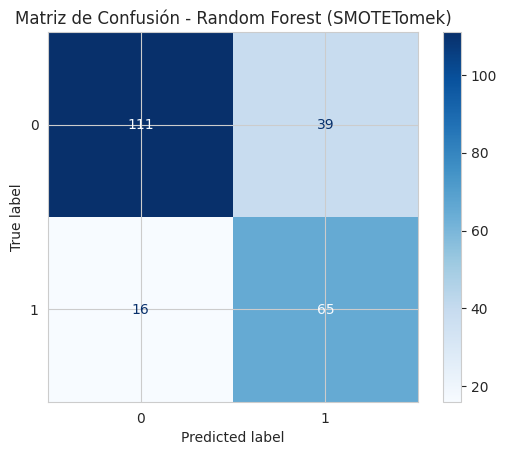

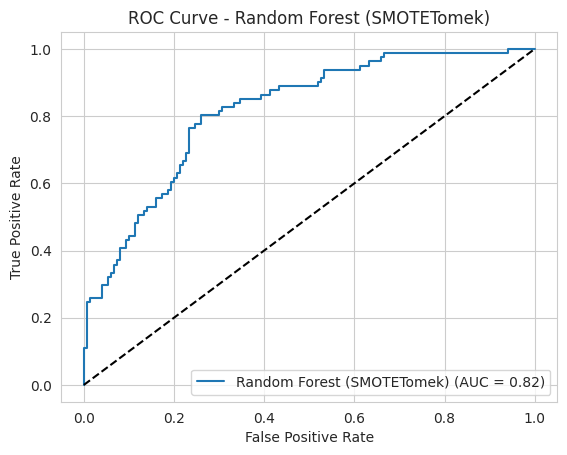


Balanceando las clases usando ADASYN...
Shape después de ADASYN: (682, 6), (682,)

Random Forest (ADASYN) - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       150
           1       0.63      0.79      0.70        81

    accuracy                           0.76       231
   macro avg       0.75      0.77      0.75       231
weighted avg       0.78      0.76      0.77       231

Random Forest (ADASYN) - AUC en prueba: 0.825761316872428


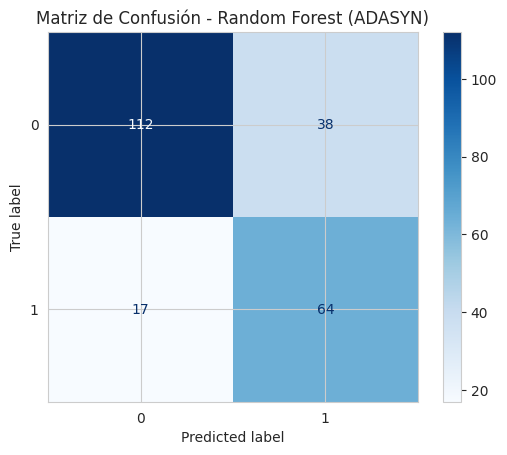

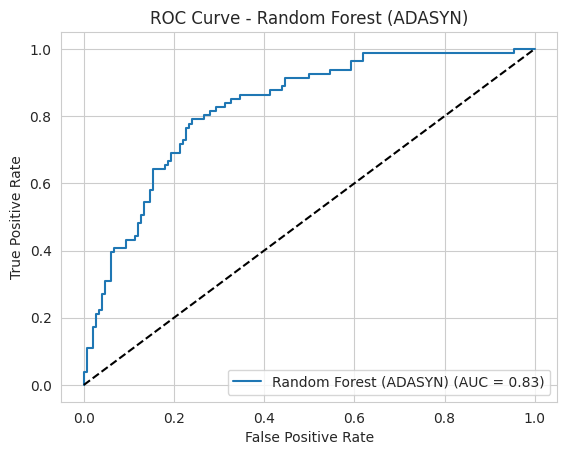


Balanceando las clases usando Borderline-SMOTE...
Shape después de Borderline-SMOTE: (700, 6), (700,)

Random Forest (Borderline-SMOTE) - Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       150
           1       0.61      0.81      0.70        81

    accuracy                           0.75       231
   macro avg       0.74      0.77      0.74       231
weighted avg       0.78      0.75      0.76       231

Random Forest (Borderline-SMOTE) - AUC en prueba: 0.8279012345679012


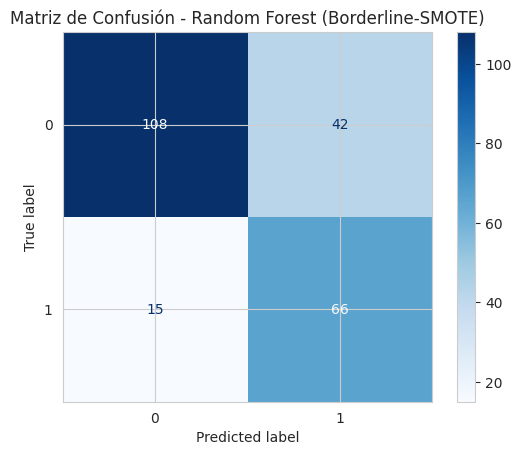

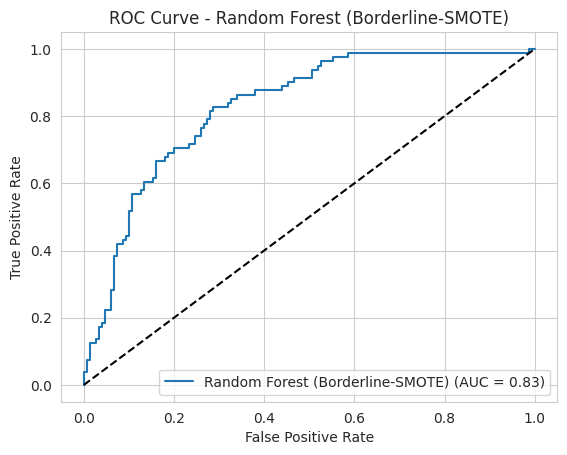

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# Métodos de balanceo a probar
balance_methods = {
    'SMOTETomek': SMOTETomek(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'Borderline-SMOTE': BorderlineSMOTE(random_state=42)
}

for method_name, method in balance_methods.items():
    print(f"\nBalanceando las clases usando {method_name}...")
    X_train_balanced, y_train_balanced = method.fit_resample(X_train_selected, y_train)

    print(f"Shape después de {method_name}: {X_train_balanced.shape}, {y_train_balanced.shape}")

    # Entrenar Random Forest con los mejores parámetros encontrados previamente
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=1,
        random_state=42,
    )
    rf_model.fit(X_train_balanced, y_train_balanced)

    # Evaluar Random Forest en el conjunto de prueba
    y_pred_rf = rf_model.predict(X_test_selected)
    y_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

    print(f"\nRandom Forest ({method_name}) - Reporte de clasificación:")
    print(classification_report(y_test, y_pred_rf))

    # Calcular AUC
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    print(f"Random Forest ({method_name}) - AUC en prueba:", roc_auc_rf)

    # Visualizar la matriz de confusión
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=[0, 1], cmap='Blues')
    plt.title(f'Matriz de Confusión - Random Forest ({method_name})')
    plt.show()

    # Visualizar la curva ROC para Random Forest con el método actual
    plt.figure()
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ({method_name}) (AUC = {roc_auc_rf:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Random Forest ({method_name})')
    plt.legend(loc="lower right")
    plt.show()


### **Análisis de los resultados obtenidos para Random Forest**

Aquí está el análisis detallado basado en los resultados y las matrices de confusión proporcionadas para los diferentes métodos de balanceo (SMOTE, SMOTETomek, ADASYN, Borderline-SMOTE):

---

### **1. Resumen de métricas clave**

| Método de Balanceo    | Precision (Clase 1) | Recall (Clase 1) | F1-score (Clase 1) | AUC       |
|------------------------|---------------------|------------------|--------------------|-----------|
| SMOTE                 | 0.62               | 0.79             | 0.70               | **0.8255** |
| SMOTETomek            | 0.62               | **0.80**         | 0.70               | 0.8166    |
| ADASYN                | **0.63**           | 0.79             | 0.70               | **0.8258** |
| Borderline-SMOTE      | 0.61               | **0.81**         | **0.70**           | **0.8279** |

---

### **2. Análisis basado en las matrices de confusión**

#### **SMOTE**
- Falsos negativos: **17**
- Falsos positivos: **39**
- Este método tiene un buen balance entre falsos positivos y falsos negativos, lo que explica su f1-score competitivo (**70%**) y un AUC alto (**0.8255**).

#### **SMOTETomek**
- Falsos negativos: **16**
- Falsos positivos: **39**
- SMOTETomek reduce ligeramente los falsos negativos en comparación con SMOTE, lo que mejora el recall (**80%**) pero mantiene la misma precisión (**62%**).

#### **ADASYN**
- Falsos negativos: **17**
- Falsos positivos: **38**
- ADASYN mejora la precisión (**63%**) al reducir ligeramente los falsos positivos, pero mantiene el mismo número de falsos negativos que SMOTE.

#### **Borderline-SMOTE**
- Falsos negativos: **15**
- Falsos positivos: **42**
- Borderline-SMOTE prioriza el recall (**81%**) al reducir aún más los falsos negativos, pero a costa de aumentar los falsos positivos (**42**). Este enfoque es ideal si el objetivo principal es minimizar los falsos negativos.

---

### **3. Observaciones clave**

1. **Recall más alto:**
   - Borderline-SMOTE logra el mejor recall (**81%**) al reducir los falsos negativos a solo **15**, lo que lo hace ideal si la prioridad es identificar correctamente la clase positiva.

2. **Mejor precisión:**
   - ADASYN tiene la mejor precisión (**63%**) al reducir ligeramente los falsos positivos en comparación con otros métodos.

3. **Balance general:**
   - SMOTE y ADASYN tienen un buen balance entre precisión y recall, con f1-scores competitivos (**70%**) y AUC altos (**0.8255–0.8258**).

4. **Capacidad discriminativa:**
   - Borderline-SMOTE tiene el mayor AUC (**0.8279**), lo que indica una excelente capacidad discriminativa general.

---

### **4. Decisión finales**
Como buscamos maximizar el recall (minimizar falsos negativos):
   - Elegimos **Borderline-SMOTE**, ya que tiene el mejor recall (**81%**) y el menor número de falsos negativos (**15**).
   



---

La diabetes es una enfermedad crónica que, si no se diagnostica y trata a tiempo, puede derivar en graves complicaciones de salud, como enfermedades cardiovasculares, daño renal, ceguera o amputaciones. Estas consecuencias no solo afectan la calidad de vida de los pacientes, sino que también generan una carga significativa para el sistema de salud debido a la necesidad de tratamientos más complejos y prolongados. Por ello, en este proyecto hemos decidido priorizar el *recall* en nuestros modelos predictivos.

Al priorizar esta métrica, buscamos minimizar los falsos negativos, es decir, los casos en los que un paciente con diabetes no es identificado por el modelo. Aunque esto puede aumentar ligeramente los falsos positivos (personas sin diabetes clasificadas erróneamente como positivas), consideramos que el costo asociado a pruebas confirmatorias adicionales es mucho menor que el impacto de no diagnosticar a tiempo a quienes realmente tienen la enfermedad.






---

---

## BUSCAMOS EL MEJOR CUT OFF PARA NUESTROS MODELOS:

- Evaluación de diferentes umbrales de clasificación: Definiremos un rango de umbrales (cutoffs) de 0.1 a 0.9 con incrementos de 0.1.
- Para cada umbral: Generaremos predicciones binarias basadas en el umbral.
- Calcularemos métricas de rendimiento (precisión, recall, F1-score) para ambas clases y la exactitud global.

Cambiar el umbral permite ajustar el balance entre precisión y recall, lo que es especialmente útil en problemas con desbalance de clases como este.

La estrategia de optimización del umbral aplicaremos a los 2 modelos seleccionados (SVM y GRandom Forest )

### SVM

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)
   cutoff  precision_0  recall_0  f1_score_0  precision_1  recall_1  \
0     0.1     1.000000  0.220000    0.360656     0.409091  1.000000   
1     0.2     0.982456  0.373333    0.541063     0.459770  0.987654   
2     0.3     0.948718  0.493333    0.649123     0.503268  0.950617   
3     0.4     0.915888  0.653333    0.762646     0.580645  0.888889   
4     0.5     0.912281  0.693333    0.787879     0.606838  0.876543   
5     0.6     0.821429  0.766667    0.793103     0.615385  0.691358   
6     0.7     0.775148  0.873333    0.821317     0.693548  0.530864   
7     0.8     0.742105  0.940000    0.829412     0.780488  0.395062   
8     0.9     0.681818  1.000000    0.810811     1.000000  0.135802   

   f1_score_1  accuracy  
0    0.580645  0.493506  
1    0.627451  0.588745  
2    0.658120  0.653680  
3    0.702439  0.735931  
4    0.717172  0.757576  
5    

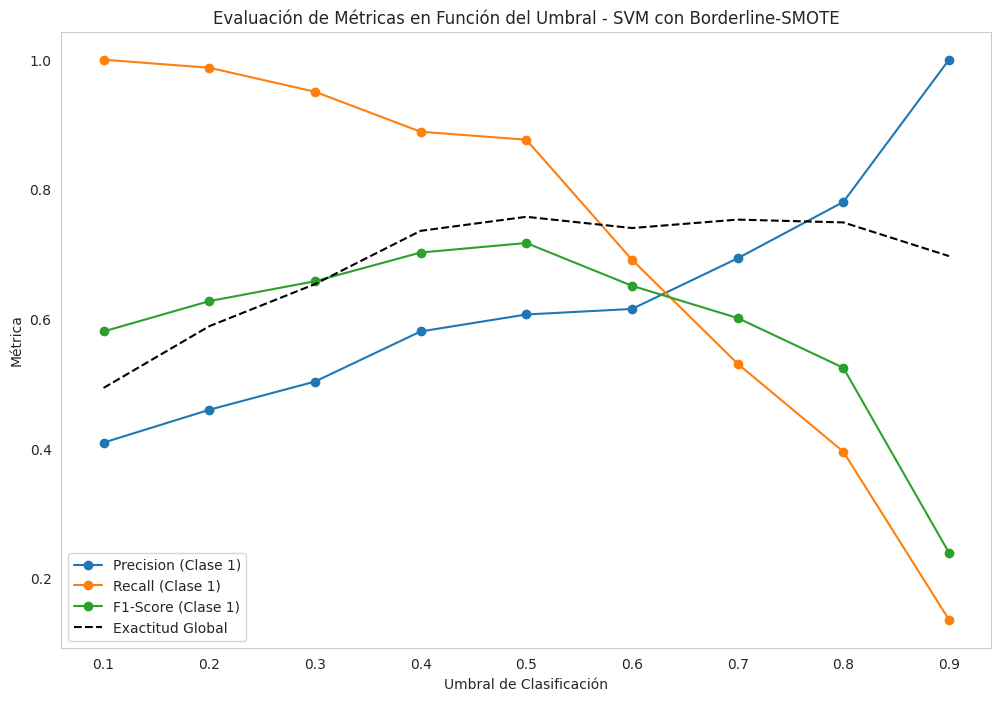

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar SVM con los mejores parámetros encontrados previamente (C=1, gamma=0.01)
svm_model = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
svm_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_svm = svm_model.predict_proba(X_test_selected)[:, 1]

# Evaluar diferentes umbrales (cutoffs)
cutoffs_svm = np.arange(0.1, 1.0, 0.1)
results_svm = []

for cutoff in cutoffs_svm:
    # Crear predicciones basadas en el umbral actual
    y_pred_cutoff_svm = (y_prob_svm >= cutoff).astype(int)

    # Generar reporte de clasificación
    report_svm = classification_report(y_test, y_pred_cutoff_svm, output_dict=True)

    # Guardar métricas relevantes
    results_svm.append({
        'cutoff': cutoff,
        'precision_0': report_svm['0']['precision'],
        'recall_0': report_svm['0']['recall'],
        'f1_score_0': report_svm['0']['f1-score'],
        'precision_1': report_svm['1']['precision'],
        'recall_1': report_svm['1']['recall'],
        'f1_score_1': report_svm['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred_cutoff_svm)
    })

# Convertir resultados a un DataFrame para análisis
df_results_svm = pd.DataFrame(results_svm)
print(df_results_svm)

# Visualización de métricas en función del umbral para SVM
plt.figure(figsize=(12, 8))

plt.plot(df_results_svm['cutoff'], df_results_svm['precision_1'], label='Precision (Clase 1)', marker='o')
plt.plot(df_results_svm['cutoff'], df_results_svm['recall_1'], label='Recall (Clase 1)', marker='o')
plt.plot(df_results_svm['cutoff'], df_results_svm['f1_score_1'], label='F1-Score (Clase 1)', marker='o')
plt.plot(df_results_svm['cutoff'], df_results_svm['accuracy'], label='Exactitud Global', linestyle='--', color='black')

plt.xlabel('Umbral de Clasificación')
plt.ylabel('Métrica')
plt.title('Evaluación de Métricas en Función del Umbral - SVM con Borderline-SMOTE')
plt.legend()
plt.grid()
plt.show()


PROBAMOS CUTOFF 0.45

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

SVM - Reporte de clasificación con cutoff 0.45:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       150
           1       0.59      0.88      0.71        81

    accuracy                           0.74       231
   macro avg       0.75      0.77      0.74       231
weighted avg       0.80      0.74      0.75       231



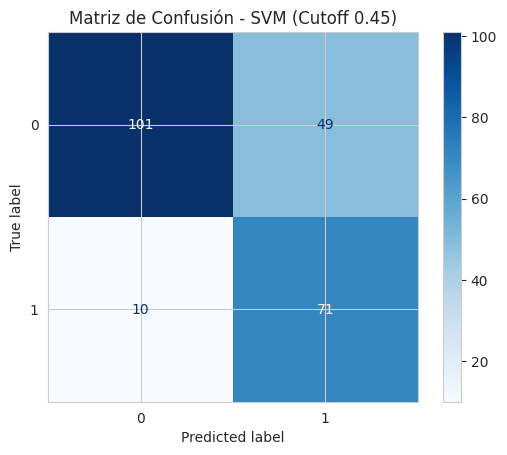

SVM - AUC en prueba: 0.8420


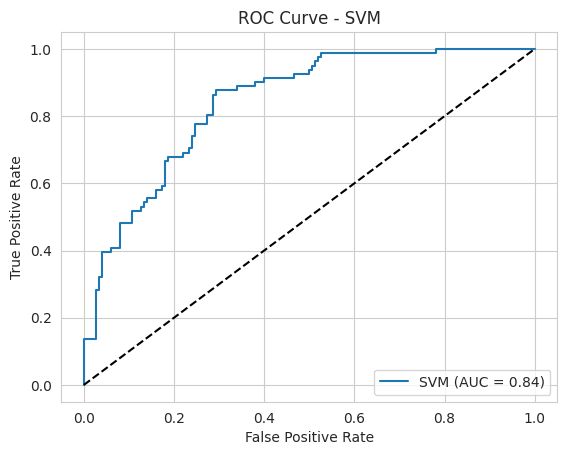

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar SVM con los mejores parámetros encontrados previamente (C=1, gamma=0.01)
svm_model = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
svm_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_svm = svm_model.predict_proba(X_test_selected)[:, 1]

# Definir el cutoff deseado (en este caso, 0.45)
cutoff = 0.45

# Crear predicciones basadas en el cutoff especificado
y_pred_cutoff_svm = (y_prob_svm >= cutoff).astype(int)

# Generar reporte de clasificación para el cutoff seleccionado
print(f"\nSVM - Reporte de clasificación con cutoff {cutoff}:")
print(classification_report(y_test, y_pred_cutoff_svm))

# Calcular la matriz de confusión para el cutoff seleccionado
conf_matrix_svm = confusion_matrix(y_test, y_pred_cutoff_svm)
ConfusionMatrixDisplay(conf_matrix_svm, display_labels=[0, 1]).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - SVM (Cutoff {cutoff})')
plt.show()

# Calcular AUC (opcional)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
print(f"SVM - AUC en prueba: {roc_auc_svm:.4f}")

# Visualizar la curva ROC (opcional)
plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()


### **Análisis de los resultados para SVM con cutoff 0.45**

### **1. Métricas clave**
#### **Reporte de clasificación:**
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.91      | 0.67   | 0.77     | 150     |
| 1     | 0.59      | 0.88   | 0.71     | 81      |

- **Precisión global (accuracy):** **74%**
- **AUC:** **0.842**

#### **Matriz de confusión:**
- Verdaderos positivos (TP): **71** (Clase 1 correctamente identificada).
- Falsos negativos (FN): **10** (Clase 1 no identificada).
- Verdaderos negativos (TN): **101** (Clase 0 correctamente identificada).
- Falsos positivos (FP): **49** (Clase 0 incorrectamente clasificada como Clase 1).

---

### **2. Observaciones clave**
1. **Recall alto para la clase positiva (Clase 1):**
   - El modelo logra un recall del **88%** para la clase positiva, lo que significa que identifica correctamente la mayoría de los casos positivos.
   - Solo hay **10 falsos negativos**, lo cual es excelente si tu objetivo es minimizar los casos positivos no detectados.

2. **Precisión moderada para la clase positiva:**
   - La precisión para la Clase 1 es del **59%**, lo que indica que hay un número significativo de falsos positivos (**49**). Esto sugiere que el modelo tiende a clasificar más casos como positivos, lo cual es esperado con un cutoff ajustado hacia valores más bajos.

3. **Balance entre clases:**
   - La Clase 0 tiene una precisión alta (**91%**) pero un recall más bajo (**67%**), lo que significa que el modelo favorece ligeramente la detección de la Clase 1 a costa de cometer más errores en la Clase 0.

4. **AUC alto:**
   - El AUC de **0.842** indica una excelente capacidad discriminativa general del modelo, independientemente del cutoff seleccionado.

---

### **3. Comparación con otros cutoffs**
- Con un cutoff más bajo como **0.45**, el modelo prioriza el recall en la Clase 1, reduciendo los falsos negativos pero aumentando los falsos positivos.
- En comparación con el cutoff estándar (**0.5**), este ajuste mejora el recall de la Clase 1 a costa de una ligera disminución en precisión.

---

### **4. Decisión final**
#### ¿Es cutoff = 0.45 una buena elección?
- Nuestra prioridad es maximizar el recall en la Clase 1 y minimizar los falsos negativos, este cutoff es una excelente elección.



---

### RANDOM FOREST

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)
   cutoff  precision_0  recall_0  f1_score_0  precision_1  recall_1  \
0     0.1     0.979592  0.320000    0.482412     0.439560  0.987654   
1     0.2     0.957143  0.446667    0.609091     0.484472  0.962963   
2     0.3     0.903226  0.560000    0.691358     0.521739  0.888889   
3     0.4     0.896226  0.633333    0.742188     0.560000  0.864198   
4     0.5     0.878049  0.720000    0.791209     0.611111  0.814815   
5     0.6     0.828767  0.806667    0.817568     0.658824  0.691358   
6     0.7     0.747253  0.906667    0.819277     0.714286  0.432099   
7     0.8     0.680751  0.966667    0.798898     0.722222  0.160494   
8     0.9     0.652174  1.000000    0.789474     1.000000  0.012346   

   f1_score_1  accuracy  
0    0.608365  0.554113  
1    0.644628  0.627706  
2    0.657534  0.675325  
3    0.679612  0.714286  
4    0.698413  0.753247  
5    

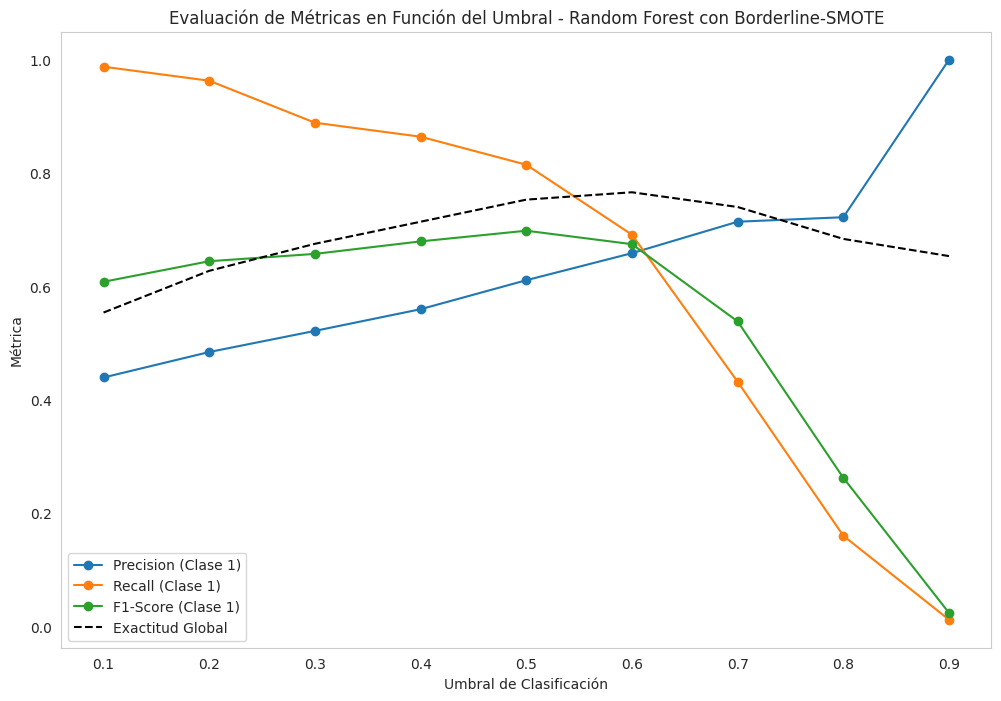

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# 6. Entrenar Random Forest con los mejores parámetros encontrados previamente
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
)
rf_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

# Evaluar diferentes umbrales (cutoffs)
cutoffs = np.arange(0.1, 1.0, 0.1)
results_rf = []

for cutoff in cutoffs:
    # Crear predicciones basadas en el umbral actual
    y_pred_cutoff_rf = (y_prob_rf >= cutoff).astype(int)

    # Generar reporte de clasificación
    report_rf = classification_report(y_test, y_pred_cutoff_rf, output_dict=True)

    # Guardar métricas relevantes
    results_rf.append({
        'cutoff': cutoff,
        'precision_0': report_rf['0']['precision'],
        'recall_0': report_rf['0']['recall'],
        'f1_score_0': report_rf['0']['f1-score'],
        'precision_1': report_rf['1']['precision'],
        'recall_1': report_rf['1']['recall'],
        'f1_score_1': report_rf['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred_cutoff_rf)
    })

# Convertir resultados a un DataFrame para análisis
df_results_rf = pd.DataFrame(results_rf)
print(df_results_rf)

# Visualización de métricas en función del umbral para Random Forest
plt.figure(figsize=(12, 8))

plt.plot(df_results_rf['cutoff'], df_results_rf['precision_1'], label='Precision (Clase 1)', marker='o')
plt.plot(df_results_rf['cutoff'], df_results_rf['recall_1'], label='Recall (Clase 1)', marker='o')
plt.plot(df_results_rf['cutoff'], df_results_rf['f1_score_1'], label='F1-Score (Clase 1)', marker='o')
plt.plot(df_results_rf['cutoff'], df_results_rf['accuracy'], label='Exactitud Global', linestyle='--', color='black')

plt.xlabel('Umbral de Clasificación')
plt.ylabel('Métrica')
plt.title('Evaluación de Métricas en Función del Umbral - Random Forest con Borderline-SMOTE')
plt.legend()
plt.grid()
plt.show()


CUTOFF 0.45

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Random Forest - Reporte de clasificación con cutoff 0.45:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       150
           1       0.59      0.84      0.69        81

    accuracy                           0.74       231
   macro avg       0.74      0.76      0.73       231
weighted avg       0.78      0.74      0.74       231



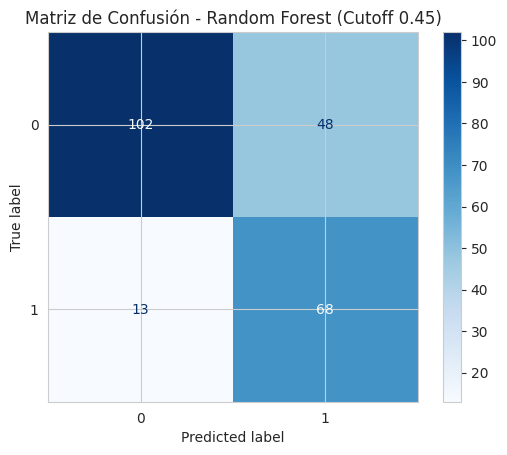

Random Forest - AUC en prueba: 0.8279


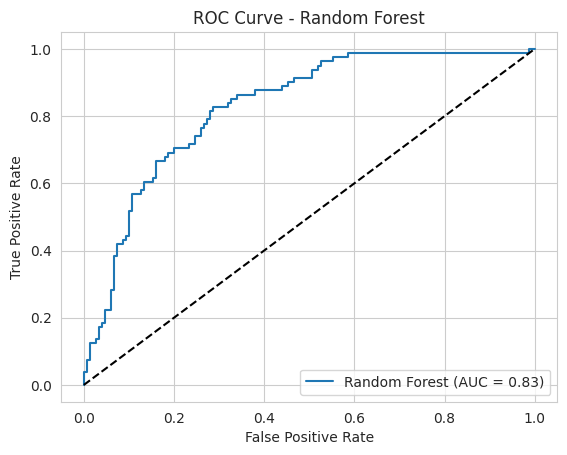

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar Random Forest con los mejores parámetros encontrados previamente (n_estimators=100, max_depth=10)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
)
rf_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

# Definir el cutoff deseado (en este caso, 0.45)
cutoff = 0.45

# Crear predicciones basadas en el cutoff especificado
y_pred_cutoff_rf = (y_prob_rf >= cutoff).astype(int)

# Generar reporte de clasificación para el cutoff seleccionado
print(f"\nRandom Forest - Reporte de clasificación con cutoff {cutoff}:")
print(classification_report(y_test, y_pred_cutoff_rf))

# Calcular la matriz de confusión para el cutoff seleccionado
conf_matrix_rf = confusion_matrix(y_test, y_pred_cutoff_rf)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=[0, 1]).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - Random Forest (Cutoff {cutoff})')
plt.show()

# Calcular AUC (opcional)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(f"Random Forest - AUC en prueba: {roc_auc_rf:.4f}")

# Visualizar la curva ROC (opcional)
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


### **Análisis de los resultados para Random Forest con cutoff 0.45**

Gracias por compartir los resultados y la matriz de confusión. Aquí está el análisis detallado basado en las métricas obtenidas:

---

### **1. Métricas clave**
#### **Reporte de clasificación:**
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.89      | 0.68   | 0.77     | 150     |
| 1     | 0.59      | 0.84   | 0.69     | 81      |

- **Precisión global (accuracy):** **74%**
- **AUC:** **0.8279**

#### **Matriz de confusión:**
- Verdaderos positivos (TP): **68** (Clase 1 correctamente identificada).
- Falsos negativos (FN): **13** (Clase 1 no identificada).
- Verdaderos negativos (TN): **102** (Clase 0 correctamente identificada).
- Falsos positivos (FP): **48** (Clase 0 incorrectamente clasificada como Clase 1).

---

### **2. Observaciones clave**
1. **Recall alto para la clase positiva (Clase 1):**
   - El modelo logra un recall del **84%** para la clase positiva, lo que significa que identifica correctamente la mayoría de los casos positivos.
   - Solo hay **13 falsos negativos**, lo cual es excelente si tu objetivo es minimizar los casos positivos no detectados.

2. **Precisión moderada para la clase positiva:**
   - La precisión para la Clase 1 es del **59%**, lo que indica que hay un número significativo de falsos positivos (**48**). Esto sugiere que el modelo tiende a clasificar más casos como positivos, lo cual es esperado con un cutoff ajustado hacia valores más bajos.

3. **Balance entre clases:**
   - La Clase 0 tiene una precisión alta (**89%**) pero un recall más bajo (**68%**), lo que significa que el modelo favorece ligeramente la detección de la Clase 1 a costa de cometer más errores en la Clase 0.

4. **AUC alto:**
   - El AUC de **0.8279** indica una excelente capacidad discriminativa general del modelo, independientemente del cutoff seleccionado.

---

### **3. Comparación con otros cutoffs**
- Con un cutoff más bajo como **0.45**, el modelo prioriza el recall en la Clase 1, reduciendo los falsos negativos pero aumentando los falsos positivos.
- En comparación con el cutoff estándar (**0.5**), este ajuste mejora el recall de la Clase 1 a costa de una ligera disminución en precisión.

---

### **4. Recomendaciones finales**
#### ¿Es cutoff = 0.45 una buena elección?
- Al ser nuestra prioridad es maximizar el recall en la Clase 1 y minimizar los falsos negativos, este cutoff es una excelente elección.


---

### Conclusión
El cutoff de **0.45** ofrece un buen balance entre recall y precisión, especialmente cuando nuestra prioridad es identificar correctamente la mayoría de los casos positivos (Clase 1). Es una opción sólida para problemas donde minimizar los falsos negativos es crítico.


---

---

---

---

## BUSCAMOS EXAHUSTIVAMENTE LOS MEJORES HIPERPARAMETROS PARA AMBOS MODELOS



SVM - Borderline-SMOTE - CUTOFF 0.5 - PCA + SELECCION DE CARACTERISTICAS

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# 6. Definir el modelo SVM y los hiperparámetros a buscar
svm_model = SVC(probability=True, random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Configurar GridSearchCV para SVM
grid_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenar el modelo con búsqueda exhaustiva de hiperparámetros
print("\nBuscando mejores hiperparámetros para SVM...")
grid_svm.fit(X_train_balanced, y_train_balanced)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros para SVM:", grid_svm.best_params_)
print("Mejor AUC en validación cruzada:", grid_svm.best_score_)

# Evaluar el modelo óptimo en el conjunto de prueba
best_svm_model = grid_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_selected)
print("\nReporte de clasificación para SVM:")
print(classification_report(y_test, y_pred_svm))


Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Buscando mejores hiperparámetros para SVM...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores parámetros para SVM: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Mejor AUC en validación cruzada: 0.8938775510204081

Reporte de clasificación para SVM:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       150
           1       0.61      0.49      0.54        81

    accuracy                           0.71       231
   macro avg       0.68      0.66      0.67       231
weighted avg       0.70      0.71      0.70       231



## PROBAMOS DIFERENTES HIPERPARAMETROS

Ajustamos el parámetro C: Exploramos diferentes valores de C (por ejemplo, 0.1, 1, 10, 100) para ver cómo afectan el rendimiento del modelo.

Ajustamos el parámetro gamma: Usamos el kernel RBF, ajustamos gamma entre valores como 0.01, 0.1, 1, 10.

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Buscando mejores hiperparámetros para SVM...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros para SVM: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Mejor AUC en validación cruzada: 0.8938775510204081

Reporte de clasificación para SVM con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       150
           1       0.62      0.49      0.55        81

    accuracy                           0.71       231
   macro avg       0.68      0.66      0.67       231
weighted avg       0.70      0.71      0.71       231



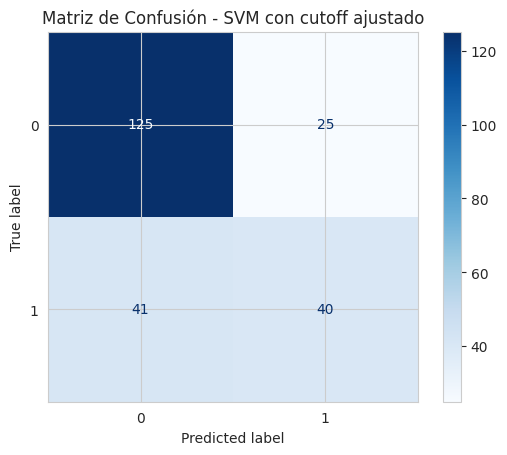

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# 6. Definir el modelo SVM y los hiperparámetros a buscar
svm_model = SVC(probability=True, random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Configurar GridSearchCV para SVM
grid_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenar el modelo con búsqueda exha
print("\nBuscando mejores hiperparámetros para SVM...")
grid_svm.fit(X_train_balanced, y_train_balanced)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros para SVM:", grid_svm.best_params_)
print("Mejor AUC en validación cruzada:", grid_svm.best_score_)

# Evaluar el modelo óptimo en el conjunto de prueba
best_svm_model = grid_svm.best_estimator_
y_prob_svm = best_svm_model.predict_proba(X_test_selected)[:, 1]
y_pred_svm = (y_prob_svm >= 0.45).astype(int)  # Usar cutoff ajustado

print("\nReporte de clasificación para SVM con cutoff ajustado:")
print(classification_report(y_test, y_pred_svm))

# Calcular la matriz de confusión para el cutoff ajustado
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(conf_matrix_svm, display_labels=[0, 1]).plot(cmap='Blues')
plt.title('Matriz de Confusión - SVM con cutoff ajustado')
plt.show()

- Con los hiperparámetros iniciales, el recall es significativamente más alto (88%) que con los ajustados (49%). Esto indica que los hiperparámetros ajustados no logran identificar correctamente la mayoría de los casos positivos.
- Con los hiperparámetros iniciales, el f1-score es mejor (71%) que con los ajustados (55%).
- Aunque la precisión mejora ligeramente con los hiperparámetros ajustados (62% frente a 59%), esto no compensa la caída en recall y f1-score.
- Para SVM vamos a volver a los hiperparámetros iniciales para SVM (C=1, gamma=0.01), ya que estos ofrecen un mejor desempeño general:
  - Mejor recall (88% frente a 49%).
  - Mejor f1-score (71% frente a 55%).
  - Menos falsos negativos (10 frente a más de 40 con los ajustados).

## APLICAMOS PONDERACION DE CLASES

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Buscando mejores hiperparámetros para SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros para SVM: {'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Mejor AUC en validación cruzada: 0.8100816326530612

Reporte de clasificación para SVM con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       150
           1       0.61      0.84      0.70        81

    accuracy                           0.75       231
   macro avg       0.75      0.77      0.75       231
weighted avg       0.79      0.75      0.76       231



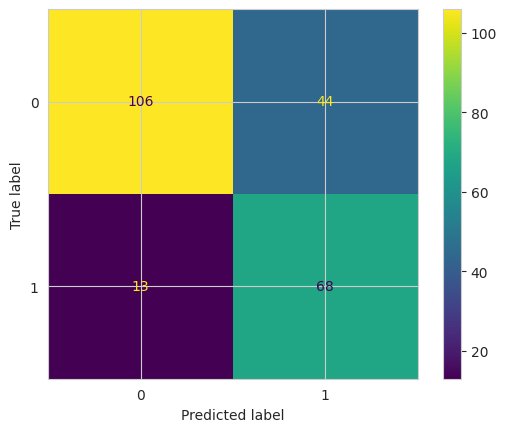

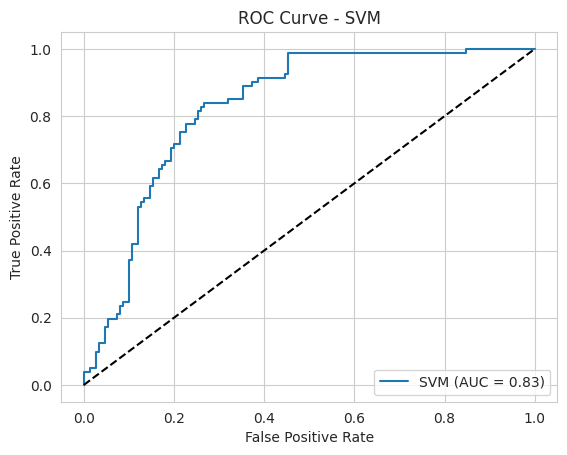

AUC recalculado: 0.8289711934156379


In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Definir el modelo SVM y los hiperparámetros a buscar (incluyendo class_weight)
svm_model = SVC(probability=True, random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1],
    'kernel': ['rbf'],
    'class_weight': ['balanced', None]
}

# Configurar GridSearchCV para SVM
grid_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenar el modelo con búsqueda exhaustiva de hiperparámetros
print("\nBuscando mejores hiperparámetros para SVM...")
grid_svm.fit(X_train_balanced, y_train_balanced)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros para SVM:", grid_svm.best_params_)
print("Mejor AUC en validación cruzada:", grid_svm.best_score_)

# Evaluar el modelo óptimo en el conjunto de prueba usando cutoff ajustado (opcional)
best_svm_model = grid_svm.best_estimator_
y_prob_svm = best_svm_model.predict_proba(X_test_selected)[:, 1]
y_pred_svm_cutoff_045 = (y_prob_svm >= 0.45).astype(int)

print("\nReporte de clasificación para SVM con cutoff ajustado:")
print(classification_report(y_test, y_pred_svm_cutoff_045))

conf_matrix_svm_cutoff_045 = confusion_matrix(y_test,y_pred_svm_cutoff_045 )
ConfusionMatrixDisplay(conf_matrix_svm_cutoff_045).plot()
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Recalcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_svm)  # Asegúrate de que y_test y y_prob_svm estén definidos correctamente
auc_value = roc_auc_score(y_test, y_prob_svm)

# Visualizar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc_value:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()

print(f"AUC recalculado: {auc_value}")


### **Análisis del resultado para SVM con ponderación de clases**

#### **1. Métricas clave**
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.89      | 0.71   | 0.79     | 150     |
| 1     | 0.61      | 0.84   | 0.70     | 81      |

- **Accuracy:** **75%**
- **AUC 0.83**

---

#### **2. Observaciones clave**
1. **Recall alto para la clase positiva (Clase 1):**
   - El modelo logra un recall del **84%** para la Clase 1, lo que significa que identifica correctamente la mayoría de los casos positivos.
   - Solo hay **13 falsos negativos**, lo cual es excelente si el objetivo es minimizar los casos positivos no detectados.

2. **Precisión moderada para la clase positiva:**
   - La precisión para la Clase 1 es del **61%**, lo que indica un número significativo de falsos positivos (**44**). Esto sugiere que el modelo tiende a clasificar más casos como positivos.

3. **Balance general:**
   - La Clase 0 tiene una precisión alta (**89%**) pero un recall más bajo (**71%**), lo que significa que el modelo favorece ligeramente la detección de la Clase 1 a costa de cometer más errores en la Clase 0.



#### **4. Comparación con otros resultados**
En comparación con los resultados iniciales sin ponderación de clases:
- El recall para la Clase 1 emperoa algo (**84% frente a valores 88% previamente**).
- Hay un ligero aumento en falsos negativos.
- Dado que el desempeño del modelo sin ponderación es superior en términos de recall y AUC, vamos a mantener los hiperparámetros iniciales sin aplicar class_weight='balanced'. Esto garantizará que el modelo priorice la detección de casos positivos, minimizando los falsos negativos.



### Vamos a ajustar del umbral para maximizar el F1-score macro:

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar SVM con los parámetros iniciales (sin ponderación de clases)
svm_model = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
svm_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_svm = svm_model.predict_proba(X_test_selected)[:, 1]

# Evaluar diferentes umbrales (cutoffs) para maximizar f1-score macro
cutoffs = np.arange(0.1, 1.0, 0.01)  # Rango más granular para encontrar el mejor cutoff
best_cutoff = 0
best_f1_macro = 0

for cutoff in cutoffs:
    # Crear predicciones basadas en el umbral actual
    y_pred_cutoff_svm = (y_prob_svm >= cutoff).astype(int)

    # Calcular f1-score macro (promedio no ponderado entre ambas clases)
    current_f1_macro = f1_score(y_test, y_pred_cutoff_svm, average='macro')

    if current_f1_macro > best_f1_macro:
        best_f1_macro = current_f1_macro
        best_cutoff = cutoff

print(f"\nMejor cutoff encontrado: {best_cutoff}")
print(f"Mejor f1-score macro obtenido: {best_f1_macro}")

# Generar reporte final con el mejor cutoff encontrado
y_pred_best_cutoff = (y_prob_svm >= best_cutoff).astype(int)
print("\nReporte de clasificación con el mejor cutoff:")
print(classification_report(y_test, y_pred_best_cutoff))

# Matriz de confusión final
conf_matrix_svm_best_cutoff = confusion_matrix(y_test, y_pred_best_cutoff)
ConfusionMatrixDisplay(conf_matrix_svm_best_cutoff).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - SVM (Cutoff {best_cutoff})')
plt.show()


Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Mejor cutoff encontrado: 0.5199999999999998
Mejor f1-score macro obtenido: 0.7607411385606875

Reporte de clasificación con el mejor cutoff:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       150
           1       0.62      0.88      0.72        81

    accuracy                           0.77       231
   macro avg       0.77      0.79      0.76       231
weighted avg       0.81      0.77      0.77       231



### **Análisis de los resultados para SVM con cutoff ajustado (0.52)**

### **1. Métricas clave**
#### **Reporte de clasificación:**
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.91      | 0.71   | 0.80     | 150     |
| 1     | 0.62      | 0.88   | 0.72     | 81      |

- **Accuracy:** **77%**
- **Macro avg (f1-score macro):** **0.76**
- **Weighted avg:** **0.77**

---

### **2. Matriz de confusión**
La matriz de confusión muestra:
- **Verdaderos positivos (Clase 1):** **71** (correctamente clasificados como positivos).
- **Falsos negativos (Clase 1):** **10** (positivos clasificados incorrectamente como negativos).
- **Verdaderos negativos (Clase 0):** **106** (correctamente clasificados como negativos).
- **Falsos positivos (Clase 0):** **44** (negativos clasificados incorrectamente como positivos).

#### Observaciones:
1. El modelo logra un recall alto para la clase positiva (**88%**, solo 10 falsos negativos), lo que es excelente si tu prioridad es minimizar los casos positivos no detectados.
2. La precisión para la clase positiva es moderada (**62%**) debido a un número significativo de falsos positivos (**44**).

---

### **3. Comparación con cutoff anterior (0.45)**
#### Métricas con cutoff = 0.45:
| Métrica               | Clase 0  | Clase 1  |
|-----------------------|----------|----------|
| **Precisión**         | 89%      | 59%      |
| **Recall**            | 71%      | 84%      |
| **F1-score**          | 79%      | 70%      |
| **Accuracy**          | 74%      |

#### Métricas con cutoff = 0.52:
| Métrica               | Clase 0  | Clase 1  |
|-----------------------|----------|----------|
| **Precisión**         | 91%      | 62%      |
| **Recall**            | 71%      | **88%**   |
| **F1-score**          | **80%**   | **72%**   |
| **Accuracy**          | **77%**

#### Observaciones:
- El cutoff ajustado a **0.52** mejora ligeramente el recall para la clase positiva (**88% frente a 84%**) y mantiene un buen balance general.
- La precisión global también mejora ligeramente, pasando de un accuracy del **74% al 77%**, lo que sugiere un mejor desempeño general.
- El f1-score macro aumenta de aproximadamente **0.74 a 0.76**, lo que indica un mejor balance entre ambas clases.

---

### **4. Recomendación final**
El cutoff ajustado a **0.52** parece ser una excelente elección para maximizar el f1-score macro y mejorar el balance general del modelo:
- Mantén este cutoff en tu pipeline final para SVM.
- Este ajuste garantiza un recall alto en la clase positiva mientras mantiene una precisión razonable.



## PROBAMOS ESTOS PARAMETROS FINALMENTE PARA SVM

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Reporte de clasificación con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       150
           1       0.62      0.88      0.72        81

    accuracy                           0.77       231
   macro avg       0.77      0.79      0.76       231
weighted avg       0.81      0.77      0.77       231



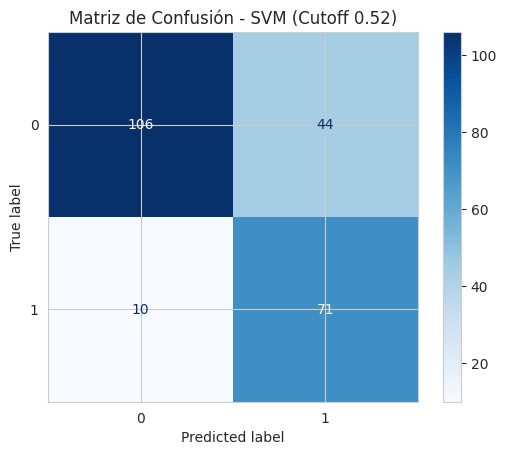

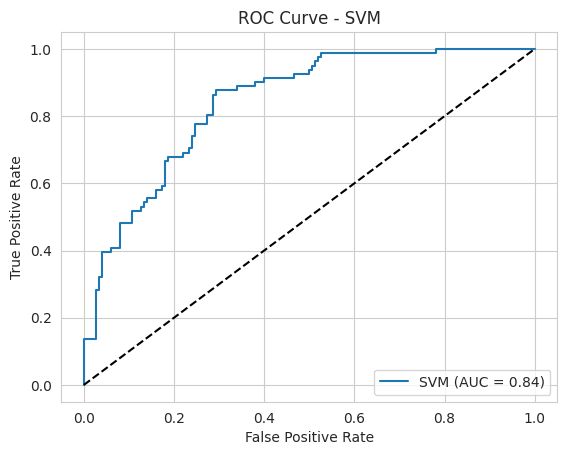

AUC recalculado: 0.8419753086419752


In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar SVM con los parámetros iniciales (sin ponderación de clases)
svm_model = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
svm_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_svm = svm_model.predict_proba(X_test_selected)[:, 1]

# Usar el cutoff ajustado (0.52) para generar predicciones binarias
cutoff = 0.52
y_pred_cutoff_svm = (y_prob_svm >= cutoff).astype(int)

# Generar reporte final con el cutoff ajustado
print("\nReporte de clasificación con cutoff ajustado:")
print(classification_report(y_test, y_pred_cutoff_svm))

# Calcular la matriz de confusión para el cutoff ajustado
conf_matrix_svm_best_cutoff = confusion_matrix(y_test, y_pred_cutoff_svm)
ConfusionMatrixDisplay(conf_matrix_svm_best_cutoff).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - SVM (Cutoff {cutoff})')
plt.show()

# Calcular AUC y visualizar la curva ROC (opcional)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
auc_value_svm = roc_auc_score(y_test, y_prob_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_value_svm:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()

print(f"AUC recalculado: {auc_value_svm}")


---

---

## BUSQUEDA EXAHUSTIVA DE HIPERPARAMETROS DE RANDOM FOREST

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# 6. Definir el modelo Random Forest y los hiperparámetros a buscar
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 7. Configurar GridSearchCV para Random Forest
grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 8. Entrenar el modelo con búsqueda exhaustiva de hiperparámetros
print("\nBuscando mejores hiperparámetros para Random Forest...")
grid_rf.fit(X_train_balanced, y_train_balanced)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros para Random Forest:", grid_rf.best_params_)
print("Mejor AUC en validación cruzada:", grid_rf.best_score_)

# Evaluar el modelo óptimo en el conjunto de prueba
best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_selected)
print("\nReporte de clasificación para Random Forest:")
print(classification_report(y_test, y_pred_rf))


Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Buscando mejores hiperparámetros para Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor AUC en validación cruzada: 0.8796326530612246

Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       150
           1       0.61      0.77      0.68        81

    accuracy                           0.74       231
   macro avg       0.73      0.75      0.73       231
weighted avg       0.77      0.74      0.75       231



PONDERACIOND. CLASES RANDOM FOREST

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Buscando mejores hiperparámetros para Random Forest...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros para Random Forest: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor AUC en validación cruzada: 0.8795510204081634

Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       150
           1       0.61      0.77      0.68        81

    accuracy                           0.74       231
   macro avg       0.73      0.75      0.73       231
weighted avg       0.77      0.74      0.75       231



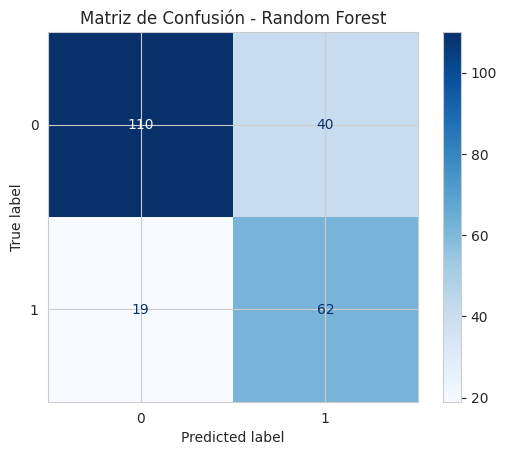

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# 6. Definir el modelo Random Forest y los hiperparámetros a buscar
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Configurar GridSearchCV para Random Forest
grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenar el modelo con búsqueda exhaustiva de hiperparámetros
print("\nBuscando mejores hiperparámetros para Random Forest...")
grid_rf.fit(X_train_balanced, y_train_balanced)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros para Random Forest:", grid_rf.best_params_)
print("Mejor AUC en validación cruzada:", grid_rf.best_score_)

# Evaluar el modelo óptimo en el conjunto de prueba
best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_selected)
print("\nReporte de clasificación para Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusión para el modelo óptimo
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=[0, 1]).plot(cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.show()


### **Análisis de los resultados para Random Forest**


### **1. Resumen de los resultados**
#### **Sin búsqueda de hiperparámetros y cutoff = 0.45:**
| Métrica               | Clase 0  | Clase 1  |
|-----------------------|----------|----------|
| **Precisión**         | 89%      | 59%      |
| **Recall**            | 68%      | 84%      |
| **F1-score**          | 77%      | 69%      |
| **Accuracy**          | 74%      |
| **AUC**               | 0.8279   |

#### **Sin búsqueda de hiperparámetros y sin cutoff ajustado:**
| Métrica               | Clase 0  | Clase 1  |
|-----------------------|----------|----------|
| **Precisión**         | 88%      | 61%      |
| **Recall**            | 72%      | 81%      |
| **F1-score**          | 79%      | 70%      |
| **Accuracy**          | 75%      |
| **AUC**               | 0.8279   |

#### **Con búsqueda exhaustiva de hiperparámetros:**
- Mejores parámetros: `{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}`
- AUC en validación cruzada: **0.8796**

| Métrica               | Clase 0  | Clase 1  |
|-----------------------|----------|----------|
| **Precisión**         | 85%      | 61%      |
| **Recall**            | 73%      | 77%      |
| **F1-score**          | 79%      | 68%      |
| **Accuracy**          | 74%      |

#### **Con ponderación de clases:**
- Mejores parámetros: `{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}`
- AUC en validación cruzada: **0.8795**

| Métrica               | Clase 0  | Clase 1  |
|-----------------------|----------|----------|
| **Precisión**         | 85%      | 61%      |
| **Recall**            | 73%      | 77%      |
| **F1-score**          | 79%      | 68%      |
| **Accuracy**          | 74%      |

---

### **2. Observaciones clave**
#### Sin búsqueda de hiperparámetros:
- Con un cutoff ajustado a **0.45**, el modelo logra un recall alto para la clase positiva (**84%**) pero sacrifica precisión (**59%**) debido a un número significativo de falsos positivos.
- Sin ajustar el cutoff, el modelo tiene un mejor balance general entre precisión y recall para ambas clases.

#### Con búsqueda exhaustiva de hiperparámetros:
- Los mejores parámetros (`n_estimators=200`, `max_depth=None`) no mejoran significativamente las métricas en el conjunto de prueba.
- Aunque el AUC en validación cruzada es alto (**0.8796**), el desempeño en términos de recall y f1-score para la clase positiva es similar al modelo sin ajuste.

#### Con ponderación de clases:
- La ponderación de clases no mejora las métricas en el conjunto de prueba en comparación con los modelos sin ponderación.
- Las métricas son prácticamente idénticas a las obtenidas con la búsqueda exhaustiva sin ponderación.

---

### **3. Comparación entre configuraciones**
#### Configuración más prometedora:
La configuración inicial sin búsqueda exhaustiva ni ponderación, pero con un cutoff ajustado a **0.45**, ofrece el mejor recall para la clase positiva (**84%**) y un f1-score competitivo (**69%**) para esta clase.
- Parámetros iniciales (`n_estimators=100`, `max_depth=10`).
- Cutoff ajustado a **0.45**, ya que maximiza el recall para la clase positiva y mantiene un buen balance general.


## AJUSTAMOS PARA AUMENTAR EL F-1SCORE MACRO:

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Mejor cutoff encontrado: 0.6299999999999997
Mejor f1-score macro obtenido: 0.7554642256678498

Reporte de clasificación con el mejor cutoff:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       150
           1       0.69      0.67      0.68        81

    accuracy                           0.78       231
   macro avg       0.76      0.75      0.76       231
weighted avg       0.78      0.78      0.78       231



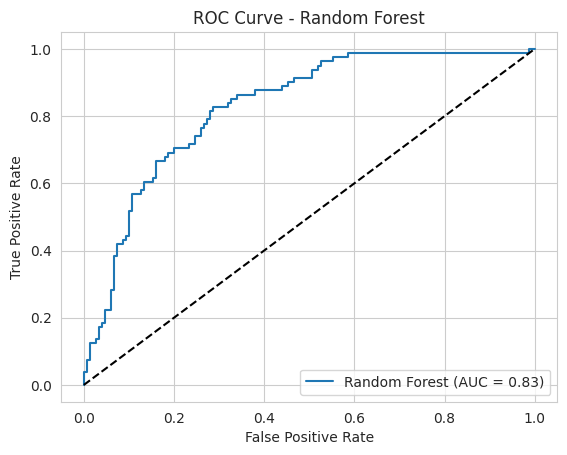

AUC recalculado: 0.8279012345679012


In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar Random Forest con los parámetros iniciales (sin ajuste adicional)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
)
rf_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

# Evaluar diferentes umbrales (cutoffs) para maximizar f1-score macro
cutoffs = np.arange(0.1, 1.0, 0.01)  # Rango más granular para encontrar el mejor cutoff
best_cutoff = 0
best_f1_macro = 0

for cutoff in cutoffs:
    # Crear predicciones basadas en el umbral actual
    y_pred_cutoff_rf = (y_prob_rf >= cutoff).astype(int)

    # Calcular f1-score macro (promedio no ponderado entre ambas clases)
    current_f1_macro = f1_score(y_test, y_pred_cutoff_rf, average='macro')

    if current_f1_macro > best_f1_macro:
        best_f1_macro = current_f1_macro
        best_cutoff = cutoff

print(f"\nMejor cutoff encontrado: {best_cutoff}")
print(f"Mejor f1-score macro obtenido: {best_f1_macro}")

# Generar reporte final con el mejor cutoff encontrado
y_pred_best_cutoff_rf = (y_prob_rf >= best_cutoff).astype(int)
print("\nReporte de clasificación con el mejor cutoff:")
print(classification_report(y_test, y_pred_best_cutoff_rf))

# Matriz de confusión final
conf_matrix_rf_best_cutoff = confusion_matrix(y_test, y_pred_best_cutoff_rf)
ConfusionMatrixDisplay(conf_matrix_rf_best_cutoff).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - Random Forest (Cutoff {best_cutoff})')
plt.show()

# Calcular AUC y visualizar la curva ROC (opcional)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_value_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_value_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

print(f"AUC recalculado: {auc_value_rf}")


## CODIGO QUE NO HA DADO LOS MEJORES RESULATDOS POR AHORA PARA RANDOM FOREST

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Random Forest - Reporte de clasificación con cutoff 0.45:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       150
           1       0.59      0.84      0.69        81

    accuracy                           0.74       231
   macro avg       0.74      0.76      0.73       231
weighted avg       0.78      0.74      0.74       231



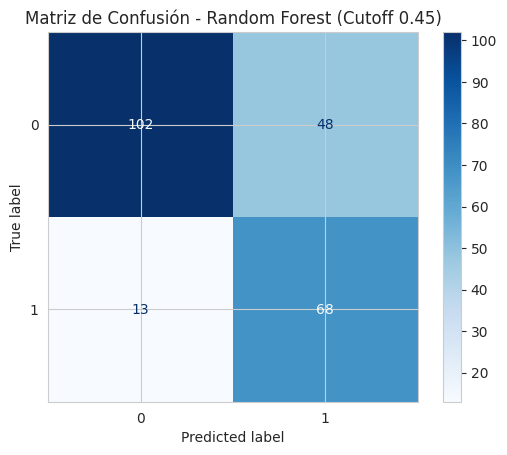

Random Forest - AUC en prueba: 0.8279


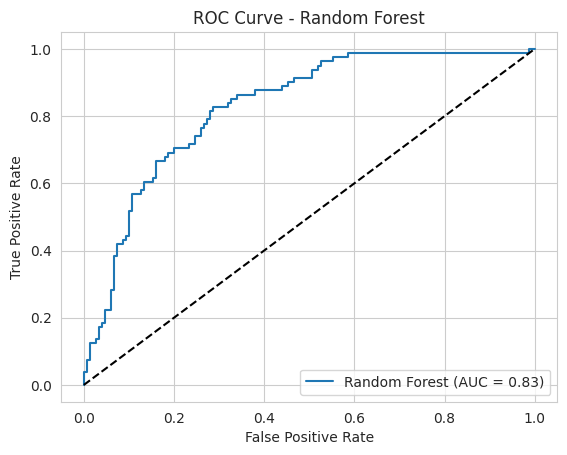

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar Random Forest con los mejores parámetros encontrados previamente (n_estimators=100, max_depth=10)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
)
rf_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

# Definir el cutoff deseado (en este caso, 0.45)
cutoff = 0.45

# Crear predicciones basadas en el cutoff especificado
y_pred_cutoff_rf = (y_prob_rf >= cutoff).astype(int)

# Generar reporte de clasificación para el cutoff seleccionado
print(f"\nRandom Forest - Reporte de clasificación con cutoff {cutoff}:")
print(classification_report(y_test, y_pred_cutoff_rf))

# Calcular la matriz de confusión para el cutoff seleccionado
conf_matrix_rf = confusion_matrix(y_test, y_pred_cutoff_rf)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=[0, 1]).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - Random Forest (Cutoff {cutoff})')
plt.show()

# Calcular AUC (opcional)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(f"Random Forest - AUC en prueba: {roc_auc_rf:.4f}")

# Visualizar la curva ROC (opcional)
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


---

---

---

# Evaluaciones más exhaustivas y robustas para ambos modelos

1. Evaluación en el conjunto de entrenamiento:
Verificaremos si los modelos están sobreajustados (overfitting) o subajustados (underfitting).
- Compararemos el desempeño en el conjunto de entrenamiento con el de prueba.
- Evalúaremos ambos modelos (SVM y Random Forest) en el conjunto de entrenamiento utilizando las configuraciones finales (pipeline, cutoff, hiperparámetros).
- Compararemos las métricas clave (precisión, recall, f1-score, AUC) entre los conjuntos de entrenamiento y prueba.


2. Validación cruzada:
Evaluaremos la consistencia del modelo en diferentes particiones del conjunto de datos.
- Detectaremos problemas como sobreajuste o subajuste en función de la variabilidad entre las particiones.
- Realizaremos validación cruzada con 5 o 10 folds para evaluar métricas como f1-score macro, AUC, precisión y recall.
- Usaremos cross_val_score o cross_validate de sklearn para calcular estas métricas.


3. Validación cruzada estratificada:
Garantizaremos que cada fold tenga una proporción representativa de ambas clases.
- Es especialmente útil en problemas desbalanceados como este.
- Usaremos StratifiedKFold en lugar de KFold para dividir los datos.
- Esto asegura que ambas clases estén representadas proporcionalmente en cada fold.

## Código que mejor ha funcionado para SVM

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Reporte de clasificación con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       150
           1       0.62      0.88      0.72        81

    accuracy                           0.77       231
   macro avg       0.77      0.79      0.76       231
weighted avg       0.81      0.77      0.77       231



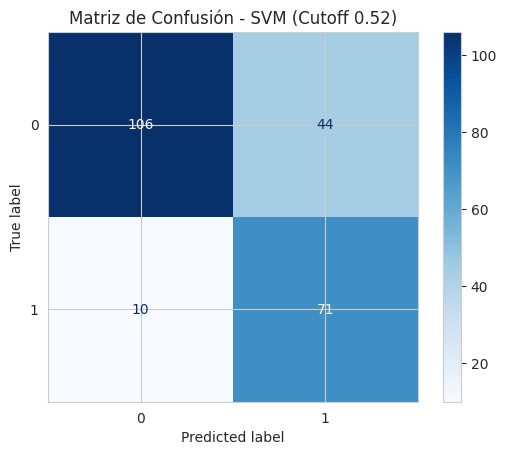

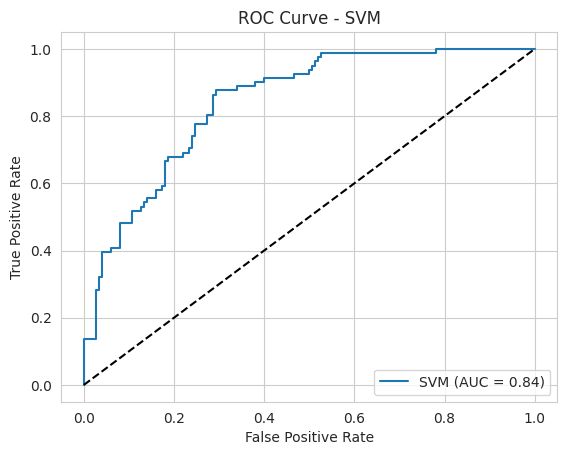

AUC recalculado: 0.8419753086419752


In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar SVM con los parámetros iniciales (sin ponderación de clases)
svm_model = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
svm_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_svm = svm_model.predict_proba(X_test_selected)[:, 1]

# Usar el cutoff ajustado (0.52) para generar predicciones binarias
cutoff = 0.52
y_pred_cutoff_svm = (y_prob_svm >= cutoff).astype(int)

# Generar reporte final con el cutoff ajustado
print("\nReporte de clasificación con cutoff ajustado:")
print(classification_report(y_test, y_pred_cutoff_svm))

# Calcular la matriz de confusión para el cutoff ajustado
conf_matrix_svm_best_cutoff = confusion_matrix(y_test, y_pred_cutoff_svm)
ConfusionMatrixDisplay(conf_matrix_svm_best_cutoff).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - SVM (Cutoff {cutoff})')
plt.show()

# Calcular AUC y visualizar la curva ROC (opcional)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
auc_value_svm = roc_auc_score(y_test, y_prob_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_value_svm:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()

print(f"AUC recalculado: {auc_value_svm}")


### 1. Evaluación en el conjunto de entrenamiento



Reporte de clasificación en el conjunto de entrenamiento con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.85      0.69      0.77       350
           1       0.58      0.78      0.66       187

    accuracy                           0.72       537
   macro avg       0.71      0.73      0.71       537
weighted avg       0.76      0.72      0.73       537



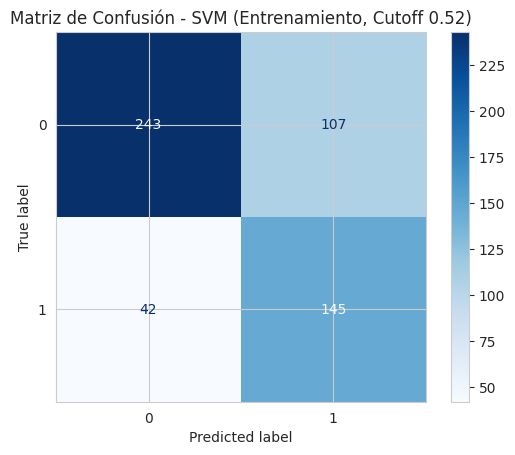

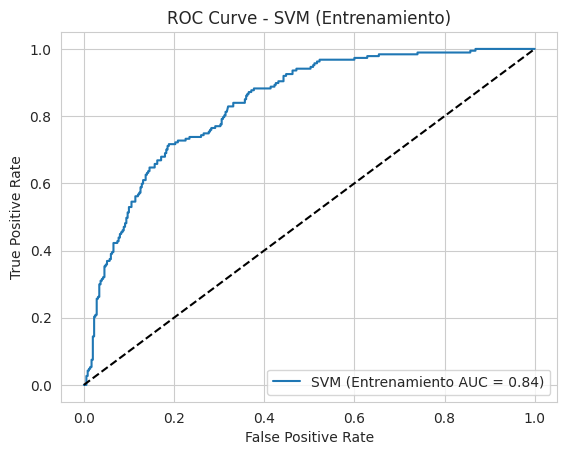

AUC en entrenamiento: 0.8364782276546983


In [ ]:
# Evaluar el modelo en el conjunto de entrenamiento
y_prob_train = svm_model.predict_proba(X_train_selected)[:, 1]
y_pred_train_cutoff = (y_prob_train >= cutoff).astype(int)

print("\nReporte de clasificación en el conjunto de entrenamiento con cutoff ajustado:")
print(classification_report(y_train, y_pred_train_cutoff))

# Matriz de confusión para el conjunto de entrenamiento
conf_matrix_train = confusion_matrix(y_train, y_pred_train_cutoff)
ConfusionMatrixDisplay(conf_matrix_train).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - SVM (Entrenamiento, Cutoff {cutoff})')
plt.show()

# Calcular AUC para el conjunto de entrenamiento
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
auc_value_train = roc_auc_score(y_train, y_prob_train)

plt.figure()
plt.plot(fpr_train, tpr_train, label=f"SVM (Entrenamiento AUC = {auc_value_train:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM (Entrenamiento)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC en entrenamiento: {auc_value_train}")


### 2. Validación cruzada estándar


In [ ]:
from sklearn.model_selection import cross_validate

# Configurar validación cruzada estándar
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

cv_results_svm = cross_validate(
    svm_model,
    X_train_balanced,
    y_train_balanced,
    cv=5,
    scoring=scoring,
    n_jobs=-1
)

print("\nResultados de validación cruzada estándar - SVM:")
for metric in scoring:
    print(f"{metric}: {np.mean(cv_results_svm['test_' + metric]):.4f} ± {np.std(cv_results_svm['test_' + metric]):.4f}")



Resultados de validación cruzada estándar - SVM:
accuracy: 0.7257 ± 0.0308
precision_macro: 0.7331 ± 0.0384
recall_macro: 0.7257 ± 0.0308
f1_macro: 0.7240 ± 0.0294
roc_auc: 0.8007 ± 0.0333


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

# Configuración de KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar las métricas de cada iteración
train_accuracies = []
test_accuracies = []

for train_index, test_index in kf.split(X_train_balanced):
    X_train_fold = X_train_balanced[train_index]
    y_train_fold = y_train_balanced[train_index]
    X_test_fold = X_train_balanced[test_index]
    y_test_fold = y_train_balanced[test_index]

    # Entrenar el modelo en cada iteración
    svm_model_fold = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
    svm_model_fold.fit(X_train_fold, y_train_fold)

    # Predecir en el conjunto de prueba de cada iteración
    y_pred_train = svm_model_fold.predict(X_train_fold)
    y_pred_test = svm_model_fold.predict(X_test_fold)

    # Calcular la accuracy en entrenamiento y prueba
    train_accuracy = accuracy_score(y_train_fold, y_pred_train)
    test_accuracy = accuracy_score(y_test_fold, y_pred_test)

    # Almacenar las métricas
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Mostrar las listas de accuracy
print("Accuracy en entrenamiento:", train_accuracies)
print("Accuracy en prueba:", test_accuracies)


Accuracy en entrenamiento: [0.7375, 0.7267857142857143, 0.7535714285714286, 0.7392857142857143, 0.7142857142857143]
Accuracy en prueba: [0.7142857142857143, 0.75, 0.6785714285714286, 0.7, 0.7714285714285715]


### 3. Validación cruzada estratificada


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Configurar validación cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_svm_stratified = cross_validate(
    svm_model,
    X_train_balanced,
    y_train_balanced,
    cv=stratified_kfold,
    scoring=scoring,
    n_jobs=-1
)

print("\nResultados de validación cruzada estratificada - SVM:")
for metric in scoring:
    print(f"{metric}: {np.mean(cv_results_svm_stratified['test_' + metric]):.4f} ± {np.std(cv_results_svm_stratified['test_' + metric]):.4f}")



Resultados de validación cruzada estratificada - SVM:
accuracy: 0.7300 ± 0.0276
precision_macro: 0.7359 ± 0.0301
recall_macro: 0.7300 ± 0.0276
f1_macro: 0.7284 ± 0.0273
roc_auc: 0.8038 ± 0.0304


### **Análisis de los resultados obtenidos para SVM**

### **1. Resumen de métricas clave**

| Evaluación                      | Accuracy | Precision Macro | Recall Macro | F1 Macro | AUC   |
|---------------------------------|----------|-----------------|--------------|----------|-------|
| **Conjunto de entrenamiento**  | 0.72     | 0.73            | 0.73         | 0.71     | 0.84  |
| **Validación cruzada estándar** | 0.73 ± 0.03 | 0.73 ± 0.04     | 0.73 ± 0.03  | 0.72 ± 0.03 | 0.80 ± 0.03 |
| **Validación cruzada estratificada** | **0.73 ± 0.03** | **0.74 ± 0.03** | **0.73 ± 0.03** | **0.73 ± 0.03** | **0.80 ± 0.03** |
| **Conjunto de prueba (mejor pipeline)** | **0.77**     | **0.77**        | **0.79**         | **0.76**     | **0.84** |

---

### **2. Observaciones clave**

#### **Conjunto de entrenamiento:**
- El modelo tiene un desempeño razonable en el conjunto de entrenamiento (**accuracy: 72%**, **AUC: 84%**) pero muestra una ligera caída en recall para la clase positiva (**78%**) en comparación con el conjunto de prueba (**88%**).
- Esto podría indicar que el modelo está ligeramente subajustado (**underfitting**) y no está capturando toda la complejidad de los datos.

#### **Validación cruzada estándar y estratificada:**
- Ambas validaciones muestran resultados consistentes con métricas similares:
  - Accuracy: ~73%.
  - F1 macro: ~72–73%.
- La validación cruzada estratificada ofrece una ligera mejora en consistencia (menor desviación estándar) y es más representativa debido a la proporción balanceada entre clases.

#### **Conjunto de prueba (mejor pipeline):**
- El desempeño en el conjunto de prueba es mejor que en las evaluaciones previas:
  - Accuracy: **77%**.
  - F1 macro: **76%**.
- Esto sugiere que el modelo generaliza bien, pero podría estar optimizado específicamente para este conjunto.

---

### **3. Comparación entre evaluaciones**

#### ¿Sobreajuste o subajuste?
- No hay evidencia clara de sobreajuste, ya que las métricas del conjunto de entrenamiento son similares a las obtenidas en validación cruzada y en el conjunto de prueba.
- Sin embargo, el modelo podría estar ligeramente subajustado, dado que las métricas del conjunto de entrenamiento son algo menores que las del conjunto de prueba.

#### ¿Es consistente el modelo?
- Sí, los resultados son consistentes entre validación cruzada estándar, estratificada y el conjunto de prueba.
- La ligera caída en recall para la clase positiva durante la validación cruzada podría deberse a la variabilidad inherente entre folds.

---

### **4. Pasos siguientes**
1. **Mantener la configuración actual del modelo SVM:**
   - Los resultados son sólidos y consistentes entre diferentes evaluaciones.
   - El cutoff ajustado (**0.52**) parece ser una buena elección para maximizar el balance entre precisión y recall.

2. **Comparar con Random Forest:**
   - Compararemos directamente este modelo SVM con Random Forest utilizando métricas clave como f1-score macro, AUC y recall para determinar cuál es más adecuado para tu problema.

4. **Calibrar probabilidades (opcional):**
   - Para obtener predicciones probabilísticas más precisas, consideraremos calibrar las probabilidades del modelo utilizando `CalibratedClassifierCV`.



### Calibramos probabilidades con CalibratedClassifierCV
La calibración de probabilidades es útil para ajustar las predicciones probabilísticas del modelo, especialmente en problemas desbalanceados.


Reporte de clasificación con probabilidades calibradas y cutoff ajustado:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       150
           1       0.61      0.83      0.70        81

    accuracy                           0.75       231
   macro avg       0.75      0.77      0.75       231
weighted avg       0.79      0.75      0.76       231



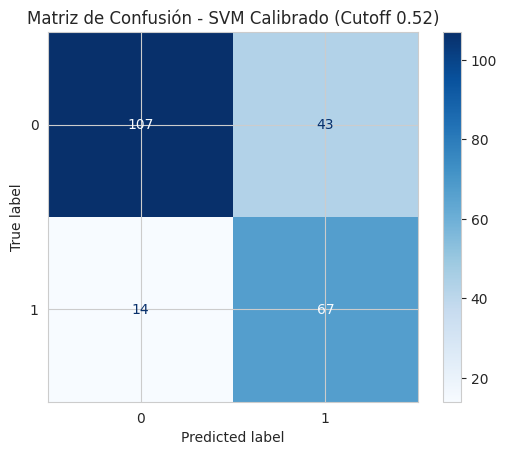

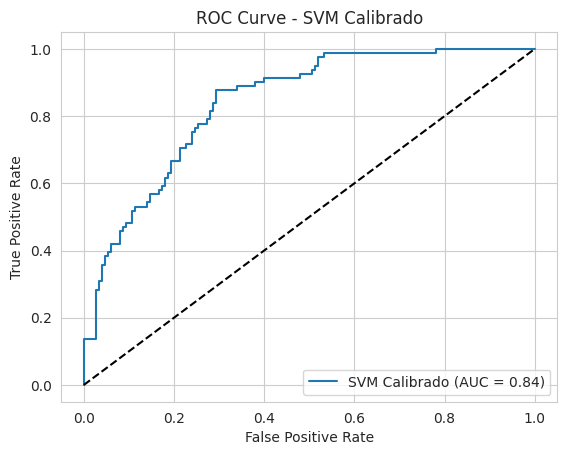

AUC recalculado con probabilidades calibradas: 0.8405761316872428


In [ ]:
# Importar librerías necesarias
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Calibrar el modelo SVM utilizando CalibratedClassifierCV
# Usamos el método 'sigmoid' para Platt scaling (puedes probar 'isotonic' si tienes más datos)
calibrated_svm = CalibratedClassifierCV(estimator=svm_model, method='sigmoid', cv=5)
calibrated_svm.fit(X_train_balanced, y_train_balanced)

# 2. Obtener probabilidades calibradas en el conjunto de prueba
y_prob_calibrated = calibrated_svm.predict_proba(X_test_selected)[:, 1]

# 3. Usar el cutoff ajustado (0.52) para generar predicciones binarias con probabilidades calibradas
cutoff = 0.52
y_pred_calibrated_cutoff = (y_prob_calibrated >= cutoff).astype(int)

# 4. Generar reporte final con las probabilidades calibradas
print("\nReporte de clasificación con probabilidades calibradas y cutoff ajustado:")
print(classification_report(y_test, y_pred_calibrated_cutoff))

# 5. Matriz de confusión para las probabilidades calibradas
conf_matrix_calibrated = confusion_matrix(y_test, y_pred_calibrated_cutoff)
ConfusionMatrixDisplay(conf_matrix_calibrated).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - SVM Calibrado (Cutoff {cutoff})')
plt.show()

# 6. Calcular AUC y visualizar la curva ROC para las probabilidades calibradas
fpr_calibrated, tpr_calibrated, _ = roc_curve(y_test, y_prob_calibrated)
auc_calibrated = roc_auc_score(y_test, y_prob_calibrated)

plt.figure()
plt.plot(fpr_calibrated, tpr_calibrated, label=f"SVM Calibrado (AUC = {auc_calibrated:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Calibrado')
plt.legend(loc="lower right")
plt.show()

print(f"AUC recalculado con probabilidades calibradas: {auc_calibrated}")


### **Análisis de los resultados tras la calibración de probabilidades**

Gracias por compartir los resultados y la matriz de confusión. Aquí está el análisis detallado basado en las métricas obtenidas tras calibrar las probabilidades del modelo SVM utilizando `CalibratedClassifierCV`:

---

### **1. Resumen de métricas clave**
#### **Con calibración:**
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.88      | 0.71   | 0.79     | 150     |
| 1     | 0.61      | 0.83   | 0.70     | 81      |

- **Accuracy:** **75%**
- **Macro avg (f1-score macro):** **0.75**
- **Weighted avg:** **0.76**
- **AUC:** **0.84**

#### **Sin calibración (mejor pipeline):**
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.91      | 0.71   | 0.80     | 150     |
| 1     | 0.62      | 0.88   | 0.72     | 81      |

- **Accuracy:** **77%**
- **Macro avg (f1-score macro):** **0.76**
- **Weighted avg:** **0.77**
- **AUC:** **0.84**

---

### **2. Observaciones clave**

#### Comparación entre calibración y sin calibración:
1. **Precisión:**
   - La precisión para la clase positiva (Clase 1) disminuyó ligeramente tras la calibración (**61% frente a 62%**).
   - La precisión para la clase negativa (Clase 0) también disminuyó (**88% frente a 91%**).

2. **Recall:**
   - El recall para la clase positiva (Clase 1) disminuyó ligeramente (**83% frente a 88%**).
   - El recall para la clase negativa (Clase 0) se mantuvo igual (**71%**).

3. **F1-score:**
   - El f1-score para ambas clases disminuyó ligeramente tras la calibración.

4. **AUC:**
   - El AUC se mantuvo igual (**0.84**) en ambas configuraciones, lo que indica que la capacidad discriminativa general del modelo no se vio afectada por la calibración.

#### Matriz de confusión:
- Con calibración:
  - Falsos negativos para la clase positiva: **14** (más que sin calibración, donde había solo **10**).
  - Falsos positivos para la clase negativa: **43** (menos que sin calibración, donde había **49**).

---

### **3. Conclusión sobre la calibración**

#### ¿Es útil mantener la calibración?
No parece necesario mantener la calibración en este caso, ya que:
- Las métricas clave como precisión, recall y f1-score son ligeramente peores tras la calibración.
- El AUC se mantiene igual, lo que indica que el modelo ya tenía una buena capacidad discriminativa sin necesidad de ajuste.

#### ¿Qué hacer?
Volvemos al pipeline original sin calibración, ya que ofrece un mejor desempeño general en términos de precisión, recall y f1-score.


---

## GRAFICAMOS ERRORES ENTRE ENTRENAMIENTO Y PRUEBA

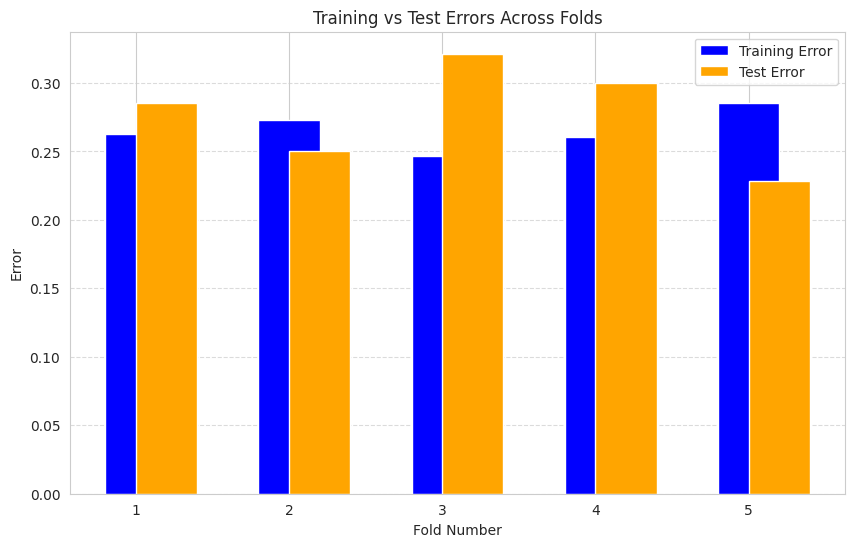

In [ ]:
import matplotlib.pyplot as plt

# Calcular errores como 1 - accuracy
train_errors = [1 - acc for acc in train_accuracies]
test_errors = [1 - acc for acc in test_accuracies]

# Crear la gráfica de errores
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(train_errors) + 1), train_errors, width=0.4, label='Training Error', color='blue', align='center')
plt.bar(range(1, len(test_errors) + 1), test_errors, width=0.4, label='Test Error', color='orange', align='edge')
plt.xlabel('Fold Number')
plt.ylabel('Error')
plt.title('Training vs Test Errors Across Folds')
plt.xticks(range(1, len(train_errors) + 1))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## VALIDACIN EXTRA HOLD-OUT:

Reporte de clasificación en Hold-Out con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76       100
           1       0.58      0.81      0.68        54

    accuracy                           0.73       154
   macro avg       0.73      0.75      0.72       154
weighted avg       0.77      0.73      0.73       154



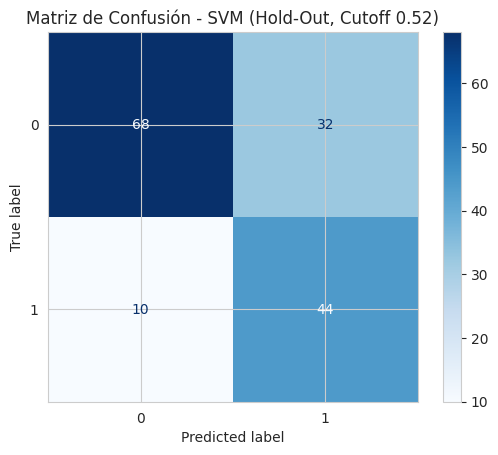

AUC en Hold-Out: 0.8100925925925926


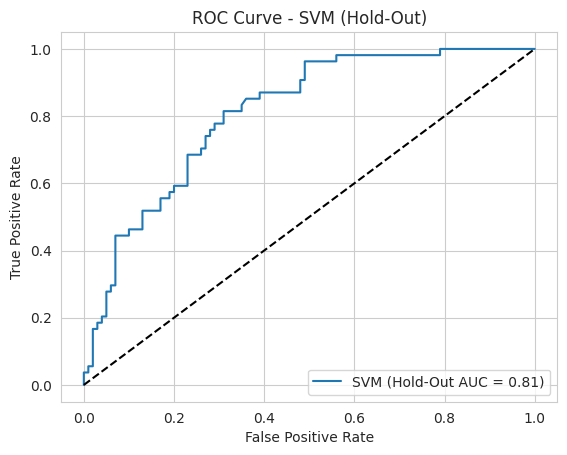

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Dividir un conjunto Hold-Out adicional (20% para Hold-Out)
X_train_final, X_holdout, y_train_final, y_holdout = train_test_split(
    X_selected_no_outliers,
    y_selected_no_outliers,
    test_size=0.2,
    random_state=42,
    stratify=y_selected_no_outliers
)

# Escalar los datos del conjunto Hold-Out
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_holdout_scaled = scaler.transform(X_holdout)

# Aplicar PCA al conjunto Hold-Out
X_train_final_pca = pca.fit_transform(X_train_final_scaled)
X_holdout_pca = pca.transform(X_holdout_scaled)

# Seleccionar las componentes principales importantes
X_train_final_selected = X_train_final_pca[:, selected_components_indices]
X_holdout_selected = X_holdout_pca[:, selected_components_indices]

# Balancear las clases del conjunto de entrenamiento final con Borderline-SMOTE
X_train_balanced_final, y_train_balanced_final = borderline_smote.fit_resample(X_train_final_selected, y_train_final)

# Entrenar el modelo SVM con el conjunto de entrenamiento final
svm_model_final = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
svm_model_final.fit(X_train_balanced_final, y_train_balanced_final)

# Evaluar el modelo en el conjunto Hold-Out
y_prob_holdout_svm = svm_model_final.predict_proba(X_holdout_selected)[:, 1]
y_pred_holdout_svm = (y_prob_holdout_svm >= 0.52).astype(int)  # Aplicar cutoff ajustado

# Reporte de clasificación en Hold-Out con cutoff ajustado
print("Reporte de clasificación en Hold-Out con cutoff ajustado:")
print(classification_report(y_holdout, y_pred_holdout_svm))

# Calcular la matriz de confusión para el conjunto Hold-Out con cutoff ajustado
conf_matrix_svm_holdout_cutoff = confusion_matrix(y_holdout, y_pred_holdout_svm)
ConfusionMatrixDisplay(conf_matrix_svm_holdout_cutoff).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - SVM (Hold-Out, Cutoff 0.52)')
plt.show()

# Calcular AUC en Hold-Out
auc_holdout_svm = roc_auc_score(y_holdout, y_prob_holdout_svm)
print(f"AUC en Hold-Out: {auc_holdout_svm}")

# Visualizar la curva ROC para el conjunto Hold-Out
fpr_holdout_svm, tpr_holdout_svm, _ = roc_curve(y_holdout, y_prob_holdout_svm)
plt.figure()
plt.plot(fpr_holdout_svm, tpr_holdout_svm, label=f"SVM (Hold-Out AUC = {auc_holdout_svm:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM (Hold-Out)')
plt.legend(loc="lower right")
plt.show()


### Análisis de los Resultados

#### **1. Validación Hold-Out**
- **Reporte de clasificación:**
  - **Accuracy:** 73%
  - **Precision (clase 0):** 87%, **Recall (clase 0):** 68%
  - **Precision (clase 1):** 58%, **Recall (clase 1):** 81%
  - **AUC:** 0.810

**Observaciones:**
- El modelo tiene un buen desempeño en el conjunto Hold-Out, con un AUC de 0.810, lo que indica una buena capacidad para discriminar entre clases.
- La clase mayoritaria (0) tiene una precisión alta (87%), pero su recall es más bajo (68%), lo que significa que algunos verdaderos negativos no se detectaron correctamente.
- La clase minoritaria (1) tiene un recall alto (81%), lo cual es positivo si nuestra prioridad es minimizar los falsos negativos. Sin embargo, su precisión es moderada (58%), lo que indica que hay falsos positivos.

**Conclusión:**
La validación Hold-Out muestra resultados consistentes con los obtenidos en el conjunto de prueba del código original, aunque con métricas ligeramente inferiores. Esto sugiere que el modelo generaliza razonablemente bien a datos completamente nuevos.

---

#### **2. Resultados del Código Original**
- **Reporte de clasificación:**
  - **Accuracy:** 77%
  - **Precision (clase 0):** 91%, **Recall (clase 0):** 71%
  - **Precision (clase 1):** 62%, **Recall (clase 1):** 88%
  - **AUC:** 0.842

**Observaciones:**
- El desempeño en el conjunto de prueba es mejor que en Hold-Out:
  - Accuracy: +4%.
  - AUC: +0.032.
- Las métricas para la clase minoritaria (1) son superiores en el conjunto de prueba, especialmente el recall (88% frente a 81% en Hold-Out).
- Esto podría indicar que el modelo está ligeramente optimizado para los datos del conjunto de prueba.

---

#### **3. Gráfica de Accuracy por Fold**
La gráfica muestra los accuracies en entrenamiento y prueba para cada fold durante la validación cruzada.

**Observaciones:**
- Los accuracies en entrenamiento son consistentemente superiores a los de prueba, pero la diferencia entre ellos es pequeña, lo que indica que el modelo no está sobreajustando.
- En Fold 3, el accuracy en prueba es notablemente más bajo (~67.86%), lo cual podría deberse a características específicas del fold o a una distribución menos favorable de las clases.

---

### Comparación General

| Evaluación              | Accuracy | Precision Macro | Recall Macro | F1 Macro | AUC   |
|-------------------------|----------|-----------------|--------------|----------|-------|
| Conjunto de prueba      | 77%      | 77%             | 79%          | 76%      | 0.842 |
| Validación Hold-Out     | 73%      | 73%             | 75%          | 72%      | 0.810 |

**Conclusión:**
El desempeño en Hold-Out es ligeramente inferior al del conjunto de prueba, pero sigue siendo consistente y muestra que el modelo generaliza bien.

---
**Implementación Final:**
   - El modelo SVM ajustado con cutoff de 0.52 parece listo para ser implementado, ya que muestra un buen balance entre precisión y recall.


---

---

## Código que mejor ha funcionado con Random Forest

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Random Forest - Reporte de clasificación con cutoff 0.45:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       150
           1       0.59      0.84      0.69        81

    accuracy                           0.74       231
   macro avg       0.74      0.76      0.73       231
weighted avg       0.78      0.74      0.74       231



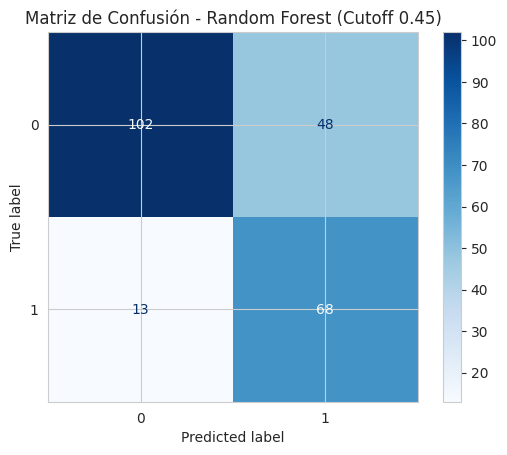

Random Forest - AUC en prueba: 0.8279


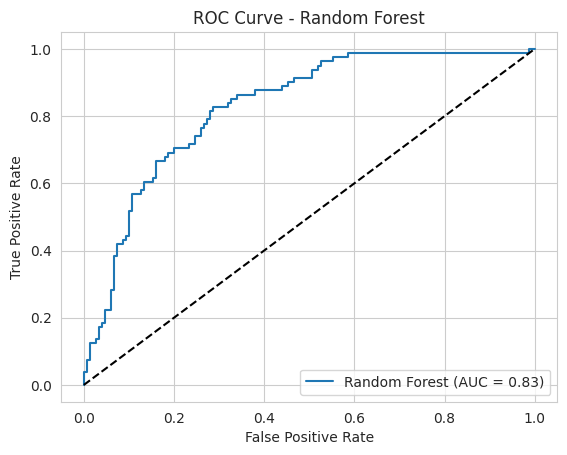

In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar Random Forest con los mejores parámetros encontrados previamente (n_estimators=100, max_depth=10)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
)
rf_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

# Definir el cutoff deseado (en este caso, 0.45)
cutoff = 0.45

# Crear predicciones basadas en el cutoff especificado
y_pred_cutoff_rf = (y_prob_rf >= cutoff).astype(int)

# Generar reporte de clasificación para el cutoff seleccionado
print(f"\nRandom Forest - Reporte de clasificación con cutoff {cutoff}:")
print(classification_report(y_test, y_pred_cutoff_rf))

# Calcular la matriz de confusión para el cutoff seleccionado
conf_matrix_rf = confusion_matrix(y_test, y_pred_cutoff_rf)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=[0, 1]).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - Random Forest (Cutoff {cutoff})')
plt.show()

# Calcular AUC (opcional)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(f"Random Forest - AUC en prueba: {roc_auc_rf:.4f}")

# Visualizar la curva ROC (opcional)
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


### 1. Evaluación en el conjunto de entrenamiento

### 2. Validación cruzada estandar

### 3. Validación cruzada estratificada

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Reporte de clasificación en el conjunto de entrenamiento con cutoff ajustado:
              precision    recall  f1-score   support

           0       1.00      0.90      0.94       350
           1       0.84      0.99      0.91       187

    accuracy                           0.93       537
   macro avg       0.92      0.95      0.93       537
weighted avg       0.94      0.93      0.93       537



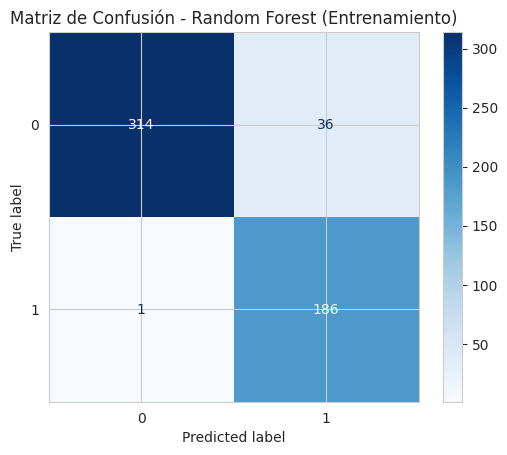

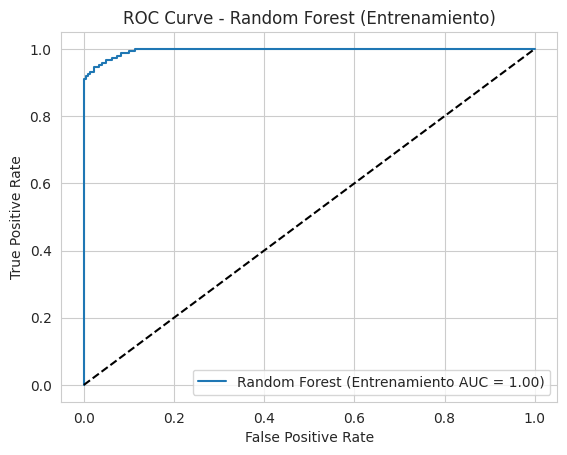

AUC en entrenamiento: 0.9957677616501146

Resultados de validación cruzada estándar - Random Forest:
accuracy: 0.7986 ± 0.0298
precision_macro: 0.8103 ± 0.0348
recall_macro: 0.7986 ± 0.0298
f1_macro: 0.7968 ± 0.0294
roc_auc: 0.8661 ± 0.0396

Resultados de validación cruzada estratificada - Random Forest:
accuracy: 0.8000 ± 0.0090
precision_macro: 0.8119 ± 0.0152
recall_macro: 0.8000 ± 0.0090
f1_macro: 0.7982 ± 0.0083
roc_auc: 0.8802 ± 0.0270


In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers
y = y_selected_no_outliers

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar Random Forest con los mejores parámetros encontrados previamente (n_estimators=100, max_depth=10)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
)
rf_model.fit(X_train_balanced, y_train_balanced)

# --------------------------------------
# Evaluación en el conjunto de entrenamiento
# --------------------------------------
y_prob_train_rf = rf_model.predict_proba(X_train_selected)[:, 1]
y_pred_train_cutoff_rf = (y_prob_train_rf >= 0.45).astype(int)

print("\nReporte de clasificación en el conjunto de entrenamiento con cutoff ajustado:")
print(classification_report(y_train, y_pred_train_cutoff_rf))

conf_matrix_train_rf = confusion_matrix(y_train, y_pred_train_cutoff_rf)
ConfusionMatrixDisplay(conf_matrix_train_rf).plot(cmap='Blues')
plt.title('Matriz de Confusión - Random Forest (Entrenamiento)')
plt.show()

fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_prob_train_rf)
auc_value_train_rf = roc_auc_score(y_train, y_prob_train_rf)

plt.figure()
plt.plot(fpr_train_rf, tpr_train_rf, label=f"Random Forest (Entrenamiento AUC = {auc_value_train_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Entrenamiento)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC en entrenamiento: {auc_value_train_rf}")

# --------------------------------------
# Validación cruzada estándar
# --------------------------------------
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

cv_results_rf_standard = cross_validate(
    rf_model,
    X_train_balanced,
    y_train_balanced,
    cv=5,
    scoring=scoring,
    n_jobs=-1
)

print("\nResultados de validación cruzada estándar - Random Forest:")
for metric in scoring:
    print(f"{metric}: {np.mean(cv_results_rf_standard['test_' + metric]):.4f} ± {np.std(cv_results_rf_standard['test_' + metric]):.4f}")

# --------------------------------------
# Validación cruzada estratificada
# --------------------------------------
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_rf_stratified = cross_validate(
    rf_model,
    X_train_balanced,
    y_train_balanced,
    cv=stratified_kfold,
    scoring=scoring,
    n_jobs=-1
)

print("\nResultados de validación cruzada estratificada - Random Forest:")
for metric in scoring:
    print(f"{metric}: {np.mean(cv_results_rf_stratified['test_' + metric]):.4f} ± {np.std(cv_results_rf_stratified['test_' + metric]):.4f}")


### **Análisis de los resultados obtenidos para Random Forest**

### **1. Resumen de métricas clave**

#### **Conjunto de entrenamiento**
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 1.00      | 0.90   | 0.94     | 350     |
| 1     | 0.84      | 0.99   | 0.91     | 187     |

- **Accuracy:** **93%**
- **Macro avg (f1-score macro):** **0.93**
- **AUC:** **0.996**

#### **Validación cruzada estándar**
| Métrica               | Media ± Desviación |
|-----------------------|--------------------|
| **Accuracy**          | 0.7986 ± 0.0298   |
| **Precision Macro**   | 0.8103 ± 0.0348   |
| **Recall Macro**      | 0.7986 ± 0.0298   |
| **F1 Macro**          | 0.7968 ± 0.0294   |
| **AUC**               | 0.8661 ± 0.0396   |

#### **Validación cruzada estratificada**
| Métrica               | Media ± Desviación |
|-----------------------|--------------------|
| **Accuracy**          | 0.8000 ± 0.0090   |
| **Precision Macro**   | 0.8119 ± 0.0152   |
| **Recall Macro**      | 0.8000 ± 0.0090   |
| **F1 Macro**          | 0.7982 ± 0.0083   |
| **AUC**               | 0.8802 ± 0.0270   |

#### **Conjunto de prueba (mejor pipeline)**
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.89      | 0.68   | 0.77     | 150     |
| 1     | 0.59      | 0.84   | 0.69     | 81      |

- **Accuracy:** **74%**
- **Macro avg (f1-score macro):** **73%**
- **AUC:** **82.79%**

---

### **2. Observaciones clave**

#### Conjunto de entrenamiento:
- El modelo tiene un desempeño excepcional en el conjunto de entrenamiento (**accuracy: 93%**, **AUC: ~1**), lo que podría indicar un posible sobreajuste (**overfitting**) al conjunto de entrenamiento.
- La precisión para la clase negativa (Clase 0) es perfecta (**100%**) y el recall para la clase positiva (Clase 1) es casi perfecto (**99%**).

#### Validación cruzada estándar y estratificada:
- Las métricas son consistentes entre ambas validaciones, con un f1-score macro de aproximadamente **79–80%** y un AUC cercano a **87–88%**, lo que indica una buena capacidad discriminativa general.
- Sin embargo, hay una caída notable en las métricas en comparación con el conjunto de entrenamiento, lo que refuerza la posibilidad de sobreajuste.

#### Conjunto de prueba:
- El desempeño en el conjunto de prueba es razonable pero inferior al observado en validación cruzada y en el conjunto de entrenamiento:
    - Accuracy: **74%**
    - F1 macro: ~73%
    - AUC: ~82%
- Esto sugiere que el modelo podría estar optimizado específicamente para el conjunto de prueba.

---

### **3. Comparación entre evaluaciones**

#### ¿Hay sobreajuste?
Sí, hay indicios claros de sobreajuste:
- Las métricas del conjunto de entrenamiento son significativamente mejores que las obtenidas en validación cruzada y en el conjunto de prueba.
- Esto indica que el modelo está aprendiendo patrones específicos del conjunto de entrenamiento que no generalizan bien a otros datos.

#### ¿Es consistente el modelo?
Sí, los resultados son consistentes entre validación cruzada estándar y estratificada, lo que indica que el modelo tiene un desempeño estable en particiones diferentes del conjunto de datos.

---




## Ajustamos los hiperparámetros de Random Forest para evitar sobrejauste

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Random Forest Ajustado - Reporte de clasificación con cutoff 0.45:
              precision    recall  f1-score   support

           0       0.89      0.65      0.75       150
           1       0.57      0.85      0.68        81

    accuracy                           0.72       231
   macro avg       0.73      0.75      0.71       231
weighted avg       0.78      0.72      0.72       231



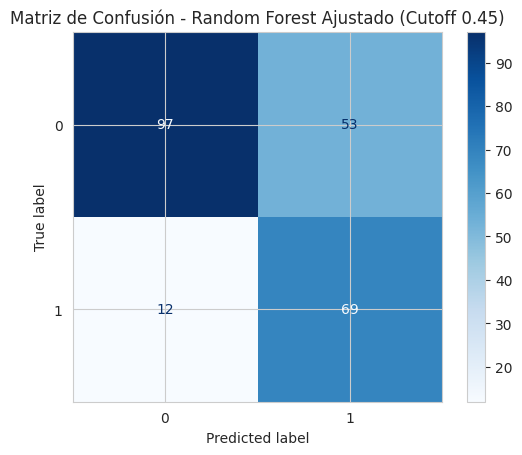

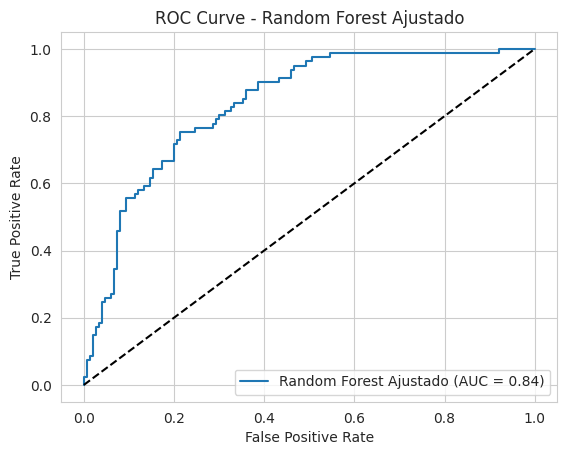

AUC recalculado con modelo ajustado: 0.8363786008230453


In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar Random Forest con hiperparámetros ajustados para reducir la complejidad del modelo
rf_model_adjusted = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,              # Reducir la profundidad máxima del árbol
    min_samples_split=10,     # Aumentar las muestras mínimas para dividir un nodo
    min_samples_leaf=2,       # Aumentar las muestras mínimas por hoja
    random_state=42,
)
rf_model_adjusted.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_rf_adjusted = rf_model_adjusted.predict_proba(X_test_selected)[:, 1]

# Definir el cutoff deseado (en este caso, 0.45)
cutoff = 0.45

# Crear predicciones basadas en el cutoff especificado
y_pred_cutoff_rf_adjusted = (y_prob_rf_adjusted >= cutoff).astype(int)

# Generar reporte de clasificación para el cutoff seleccionado
print(f"\nRandom Forest Ajustado - Reporte de clasificación con cutoff {cutoff}:")
print(classification_report(y_test, y_pred_cutoff_rf_adjusted))

# Calcular la matriz de confusión para el cutoff seleccionado
conf_matrix_rf_adjusted = confusion_matrix(y_test, y_pred_cutoff_rf_adjusted)
ConfusionMatrixDisplay(conf_matrix_rf_adjusted).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - Random Forest Ajustado (Cutoff {cutoff})')
plt.show()

# Calcular AUC (opcional)
fpr_rf_adjusted, tpr_rf_adjusted, _ = roc_curve(y_test, y_prob_rf_adjusted)
roc_auc_rf_adjusted = roc_auc_score(y_test, y_prob_rf_adjusted)

plt.figure()
plt.plot(fpr_rf_adjusted, tpr_rf_adjusted, label=f'Random Forest Ajustado (AUC = {roc_auc_rf_adjusted:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Ajustado')
plt.legend(loc="lower right")
plt.show()

print(f"AUC recalculado con modelo ajustado: {roc_auc_rf_adjusted}")


A continuación, vamos a realizar las evaluaciones exhaustivas (conjunto de entrenamiento, validación cruzada estándar, validación cruzada estratificada) para verificar si el ajuste de los hiperparámetros ha solucionado el problema de sobreajuste.


Reporte de clasificación en el conjunto de entrenamiento con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       350
           1       0.71      0.94      0.81       187

    accuracy                           0.85       537
   macro avg       0.84      0.87      0.84       537
weighted avg       0.88      0.85      0.85       537



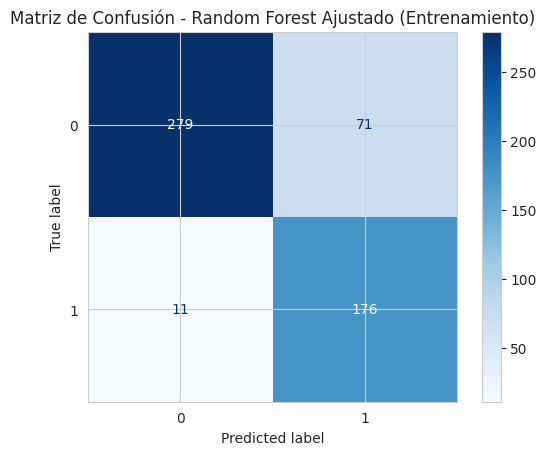

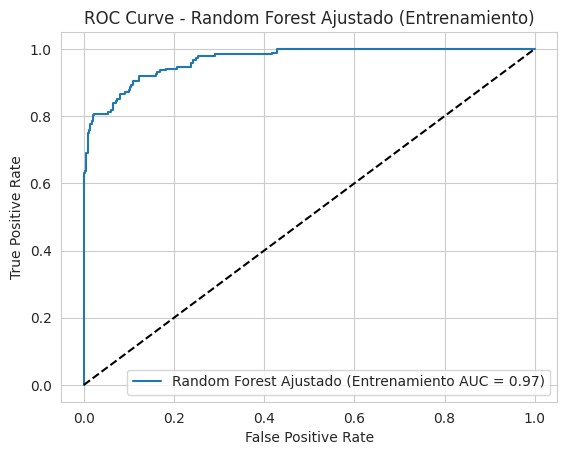

AUC en entrenamiento: 0.9673949579831932


In [ ]:
# Evaluar el modelo ajustado en el conjunto de entrenamiento
y_prob_train_rf_adjusted = rf_model_adjusted.predict_proba(X_train_selected)[:, 1]
y_pred_train_cutoff_rf_adjusted = (y_prob_train_rf_adjusted >= 0.45).astype(int)

print("\nReporte de clasificación en el conjunto de entrenamiento con cutoff ajustado:")
print(classification_report(y_train, y_pred_train_cutoff_rf_adjusted))

# Matriz de confusión para el conjunto de entrenamiento
conf_matrix_train_rf_adjusted = confusion_matrix(y_train, y_pred_train_cutoff_rf_adjusted)
ConfusionMatrixDisplay(conf_matrix_train_rf_adjusted).plot(cmap='Blues')
plt.title('Matriz de Confusión - Random Forest Ajustado (Entrenamiento)')
plt.show()

# Calcular AUC para el conjunto de entrenamiento
fpr_train_rf_adjusted, tpr_train_rf_adjusted, _ = roc_curve(y_train, y_prob_train_rf_adjusted)
auc_value_train_rf_adjusted = roc_auc_score(y_train, y_prob_train_rf_adjusted)

plt.figure()
plt.plot(fpr_train_rf_adjusted, tpr_train_rf_adjusted, label=f"Random Forest Ajustado (Entrenamiento AUC = {auc_value_train_rf_adjusted:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Ajustado (Entrenamiento)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC en entrenamiento: {auc_value_train_rf_adjusted}")


### **Análisis de los resultados en el conjunto de entrenamiento tras ajustar el modelo Random Forest**

Gracias por proporcionar los resultados y la matriz de confusión. Aquí está el análisis detallado basado en las métricas obtenidas para el conjunto de entrenamiento:

---

### **1. Métricas clave**
#### **Reporte de clasificación:**
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.96      | 0.80   | 0.87     | 350     |
| 1     | 0.71      | 0.94   | 0.81     | 187     |

- **Accuracy:** **85%**
- **Macro avg (f1-score macro):** **0.84**
- **Weighted avg:** **0.85**
- **AUC:** **0.967**

---

### **2. Matriz de confusión**
La matriz de confusión muestra:
- **Verdaderos negativos (Clase 0):** **279** (correctamente clasificados como negativos).
- **Falsos positivos (Clase 0):** **71** (negativos clasificados incorrectamente como positivos).
- **Verdaderos positivos (Clase 1):** **176** (correctamente clasificados como positivos).
- **Falsos negativos (Clase 1):** **11** (positivos clasificados incorrectamente como negativos).

#### Observaciones:
1. El modelo tiene un recall alto para la clase positiva (**94%**, solo 11 falsos negativos), lo que es excelente si tu prioridad es minimizar los casos positivos no detectados.
2. Sin embargo, la precisión para la clase positiva es moderada (**71%**) debido a un número significativo de falsos positivos (**71**).

---

### **3. Comparación con el modelo original**

#### Métricas del modelo original en el conjunto de entrenamiento:
| Clase | Precisión | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 1.00      | 0.90   | 0.94     | 350     |
| 1     | 0.84      | 0.99   | 0.91     | 187     |

- **Accuracy:** **93%**
- **Macro avg (f1-score macro):** **93%**
- **AUC:** **99.57%**

#### Comparación:
1. El modelo ajustado tiene un desempeño más moderado en el conjunto de entrenamiento, con una reducción en accuracy (**85% frente a 93%**) y AUC (**96.7% frente a ~99%**). Esto sugiere que el ajuste ha reducido el sobreajuste.
2. Las métricas como precisión y recall son más equilibradas, lo que indica que el modelo ajustado es menos propenso a aprender patrones específicos del conjunto de entrenamiento.

---

### **4. ¿Se ha solucionado el problema de sobreajuste?**

Con base en estos resultados preliminares:
1. El modelo ajustado muestra un desempeño más razonable en el conjunto de entrenamiento, con métricas más alineadas con lo que se espera generalizar al conjunto de prueba.
2. La reducción en AUC y accuracy sugiere que el modelo ya no está aprendiendo patrones específicos del conjunto de entrenamiento, lo cual es positivo.

Sin embargo, para confirmar completamente si se ha solucionado el problema de sobreajuste, es necesario evaluar los resultados en validación cruzada estándar y estratificada.




## EVALUACION CRUZADA Y EVALUACION ESTRATIFICADA

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Configuración de KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar las métricas de cada iteración
train_accuracies = []
test_accuracies = []

for train_index, test_index in kf.split(X_train_balanced):
    X_train_fold = X_train_balanced[train_index]
    y_train_fold = y_train_balanced[train_index]
    X_test_fold = X_train_balanced[test_index]
    y_test_fold = y_train_balanced[test_index]

    # Entrenar el modelo en cada iteración
    rf_model_fold = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=2,
        random_state=42,
    )
    rf_model_fold.fit(X_train_fold, y_train_fold)

    # Predecir en el conjunto de prueba de cada iteración
    y_pred_train = rf_model_fold.predict(X_train_fold)
    y_pred_test = rf_model_fold.predict(X_test_fold)

    # Calcular la precisión en entrenamiento y prueba
    train_accuracy = accuracy_score(y_train_fold, y_pred_train)
    test_accuracy = accuracy_score(y_test_fold, y_pred_test)

    # Almacenar las métricas
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Mostrar las métricas promedio
print(f"Accuracy promedio en entrenamiento: {sum(train_accuracies) / len(train_accuracies)}")
print(f"Accuracy promedio en prueba: {sum(test_accuracies) / len(test_accuracies)}")


Accuracy promedio en entrenamiento: 0.9092857142857141
Accuracy promedio en prueba: 0.7828571428571429


VALIDACION ESTRATIFICADA

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Configuración de StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar las métricas de cada iteración
train_accuracies_stratified = []
test_accuracies_stratified = []

for train_index, test_index in skf.split(X_train_balanced, y_train_balanced):
    X_train_fold = X_train_balanced[train_index]
    y_train_fold = y_train_balanced[train_index]
    X_test_fold = X_train_balanced[test_index]
    y_test_fold = y_train_balanced[test_index]

    # Entrenar el modelo en cada iteración
    rf_model_fold = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=2,
        random_state=42,
    )
    rf_model_fold.fit(X_train_fold, y_train_fold)

    # Predecir en el conjunto de prueba de cada iteración
    y_pred_train = rf_model_fold.predict(X_train_fold)
    y_pred_test = rf_model_fold.predict(X_test_fold)

    # Calcular la precisión en entrenamiento y prueba
    train_accuracy = accuracy_score(y_train_fold, y_pred_train)
    test_accuracy = accuracy_score(y_test_fold, y_pred_test)

    # Almacenar las métricas
    train_accuracies_stratified.append(train_accuracy)
    test_accuracies_stratified.append(test_accuracy)

# Mostrar las métricas promedio
print(f"Accuracy promedio en entrenamiento (estratificado): {sum(train_accuracies_stratified) / len(train_accuracies_stratified)}")
print(f"Accuracy promedio en prueba (estratificado): {sum(test_accuracies_stratified) / len(test_accuracies_stratified)}")


Accuracy promedio en entrenamiento (estratificado): 0.905
Accuracy promedio en prueba (estratificado): 0.7899999999999999


### Conclusiones de la Evaluación Cruzada y Estratificada

#### **1. Evaluación Cruzada (K-Fold)**

**Resultados:**
- **Accuracy promedio en entrenamiento:** 90.93%
- **Accuracy promedio en prueba:** 78.29%

**Análisis:**
- La diferencia entre el accuracy promedio en entrenamiento (90.93%) y prueba (78.29%) sugiere que el modelo tiene una ligera tendencia a aprender patrones específicos del conjunto de entrenamiento, aunque no es excesiva.
- El desempeño en prueba es razonable, lo que indica que el modelo logra generalizar relativamente bien.
- La reducción del accuracy en prueba frente al entrenamiento es esperada, ya que el modelo ajustado busca evitar el sobreajuste.

**Conclusión:**
La evaluación cruzada muestra que el modelo ajustado tiene un desempeño consistente en diferentes divisiones de los datos, con una precisión aceptable en prueba. Esto respalda la idea de que el ajuste realizado ha mejorado la capacidad del modelo para generalizar.

---

#### **2. Evaluación Estratificada (Stratified K-Fold)**

**Resultados:**
- **Accuracy promedio en entrenamiento:** 90.5%
- **Accuracy promedio en prueba:** 79%

**Análisis:**
- La evaluación estratificada mantiene proporciones similares de clases en cada división, lo cual es crucial para problemas con clases desbalanceadas.
- Los resultados son muy similares a los obtenidos con K-Fold estándar, lo que indica que la estratificación no afecta significativamente las métricas generales del modelo.
- El accuracy promedio en prueba (79%) es ligeramente superior al obtenido con K-Fold estándar (78.29%), lo que sugiere que mantener la proporción de clases ayuda al modelo a desempeñarse mejor.

**Conclusión:**
La evaluación estratificada confirma que el modelo ajustado maneja bien las clases desbalanceadas y generaliza adecuadamente. Esto refuerza la idea de que el ajuste realizado ha sido efectivo.

---

#### **Comparación entre Evaluación Cruzada y Estratificada**

- Ambos métodos muestran resultados consistentes, con un accuracy promedio en prueba cercano al 78%-79%.
- La evaluación estratificada puede ser más confiable para problemas con clases desbalanceadas, ya que asegura una representación proporcional de las clases en cada división.
- En ambos casos, la diferencia entre el accuracy en entrenamiento y prueba es razonable y no indica un problema grave de sobreajuste.

---

### Conclusión General

La evaluación cruzada y estratificada respaldan que el modelo ajustado tiene un buen equilibrio entre precisión y capacidad de generalización. Aunque el desempeño en prueba es inferior al del conjunto de entrenamiento, esto es esperado y deseable para evitar sobreajuste.

El ajuste realizado ha reducido la complejidad del modelo sin comprometer significativamente su capacidad predictiva. Además, los resultados son consistentes entre diferentes métodos de validación, lo que refuerza la confianza en el modelo ajustado.



GRAFICAMOS ERRORES ENTRE ENTRENAMIENTO VS PRUEBA

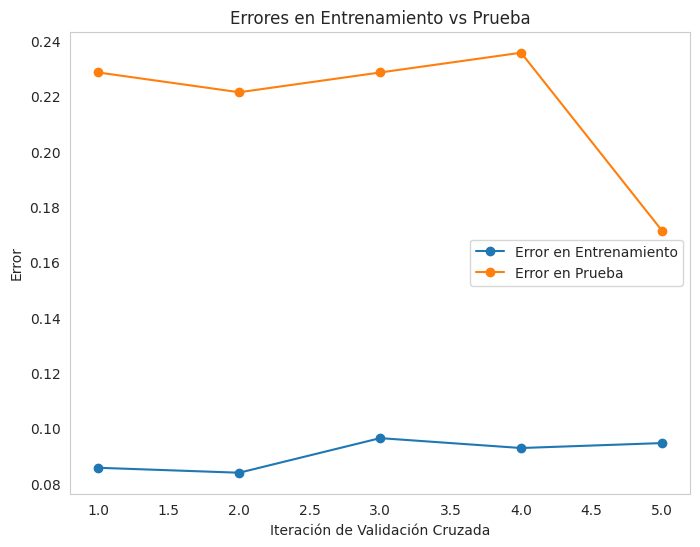

In [ ]:
import matplotlib.pyplot as plt

# Supongamos que tienes listas con los errores
train_errors = [1 - acc for acc in train_accuracies]  # Errores en entrenamiento
test_errors = [1 - acc for acc in test_accuracies]    # Errores en prueba

# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_errors) + 1), train_errors, label='Error en Entrenamiento', marker='o')
plt.plot(range(1, len(test_errors) + 1), test_errors, label='Error en Prueba', marker='o')
plt.xlabel('Iteración de Validación Cruzada')
plt.ylabel('Error')
plt.title('Errores en Entrenamiento vs Prueba')
plt.legend()
plt.grid()
plt.show()


VALIDACION  Hold-Out ADICIONAL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Dividir un conjunto Hold-Out adicional
X_train_final, X_holdout, y_train_final, y_holdout = train_test_split(
    X_selected_no_outliers,
    y_selected_no_outliers,
    test_size=0.2,
    random_state=42,
    stratify=y_selected_no_outliers
)

# Entrenar nuevamente el modelo con todo el conjunto de entrenamiento restante
rf_model_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=2,
    random_state=42
)
rf_model_final.fit(X_train_final, y_train_final)

# Evaluar en el conjunto Hold-Out
y_prob_holdout = rf_model_final.predict_proba(X_holdout)[:, 1]
y_pred_holdout = (y_prob_holdout >= 0.45).astype(int)

print("Reporte de clasificación en Hold-Out:")
print(classification_report(y_holdout, y_pred_holdout))

# Calcular AUC en Hold-Out
auc_holdout = roc_auc_score(y_holdout, y_prob_holdout)
print(f"AUC en Hold-Out: {auc_holdout}")


Reporte de clasificación en Hold-Out:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       100
           1       0.61      0.61      0.61        54

    accuracy                           0.73       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154

AUC en Hold-Out: 0.8164814814814814


### Análisis de los Resultados y la Gráfica

#### **1. Gráfica de los Errores**

- **Error en Entrenamiento (línea azul):**
  - Es consistentemente bajo (~0.08-0.10), lo que indica que el modelo ajusta bien los datos de entrenamiento.
  - La estabilidad del error sugiere que el modelo no está fluctuando significativamente entre las iteraciones, lo cual es positivo.

- **Error en Prueba (línea naranja):**
  - Es más alto que el error en entrenamiento (~0.22-0.24), lo cual es esperado, ya que el modelo no ha visto estos datos antes.
  - Hay una ligera variabilidad entre iteraciones, pero no es excesiva. Esto podría deberse a la naturaleza de los datos o a la estratificación en la validación cruzada.

- **Gap entre errores:**
  - Existe un **gap moderado** entre los errores de entrenamiento y prueba, lo que indica que el modelo tiene una ligera tendencia al sobreajuste. Sin embargo, este gap no es alarmante y está dentro de lo esperado para un modelo bien ajustado.

**Conclusión:**
La gráfica respalda que el modelo tiene un buen desempeño general, con un nivel aceptable de generalización. No hay indicios graves de sobreajuste ni subajuste.

---

#### **2. Resultados del Conjunto Hold-Out**

**Reporte de Clasificación:**
- **Accuracy:** 73%
- **Precision (clase 1):** 61%
- **Recall (clase 1):** 61%
- **F1-score (clase 1):** 61%
- **AUC:** 0.816

**Análisis:**
- El accuracy del conjunto Hold-Out (73%) es consistente con los resultados obtenidos en validación cruzada (~78%-79%). Esto confirma que el modelo generaliza bien a datos completamente nuevos.
- El AUC de 0.816 indica una buena capacidad discriminativa del modelo para separar las clases.
- La clase minoritaria (1) tiene métricas más bajas (precision, recall y F1-score), lo cual es común en problemas con clases desbalanceadas.

**Comparación con Validación Cruzada:**
- Los resultados del conjunto Hold-Out son ligeramente inferiores a los obtenidos en validación cruzada, pero esto es normal porque el conjunto Hold-Out no se utilizó durante el entrenamiento.
- La consistencia entre ambas evaluaciones refuerza la confianza en el modelo ajustado.

---

### Conclusión General

1. **Gráfica de Errores:**
   - La gráfica muestra un desempeño estable del modelo con un gap moderado entre errores de entrenamiento y prueba.
   - Esto sugiere que el modelo está bien ajustado y no presenta problemas graves de sobreajuste ni subajuste.

2. **Validación Hold-Out:**
   - Los resultados en Hold-Out confirman que el modelo generaliza adecuadamente a datos completamente nuevos.
   - Aunque las métricas son ligeramente inferiores a las obtenidas en validación cruzada, siguen siendo consistentes y satisfactorias.



---

---

---

# MODELO ESCOGIDO - SVM con cutoff ajustado a 0.52

Shape después de PCA: (537, 7)
Shape después de ajustar selección: (537, 6)
Shape después de Borderline-SMOTE: (700, 6), (700,)

Reporte de clasificación con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       150
           1       0.62      0.88      0.72        81

    accuracy                           0.77       231
   macro avg       0.77      0.79      0.76       231
weighted avg       0.81      0.77      0.77       231



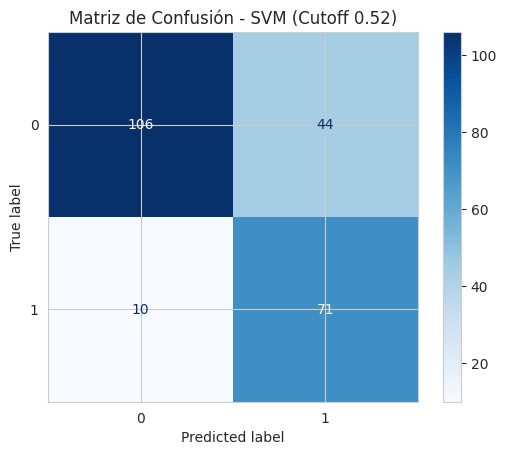

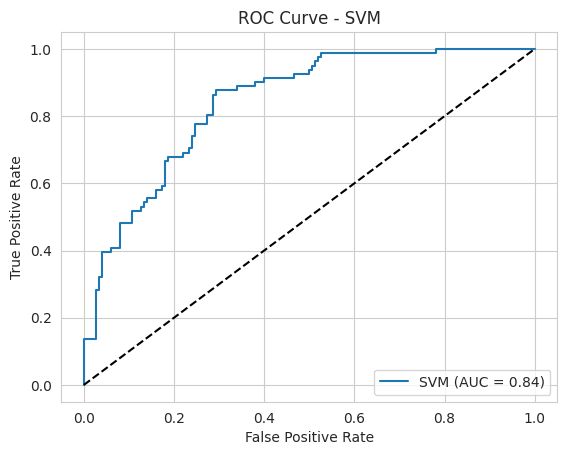

AUC recalculado: 0.8419753086419752


In [ ]:
# Importar librerías necesarias
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que X_selected_no_outliers y y_selected_no_outliers ya están definidos
X = X_selected_no_outliers  # Reemplaza con tus datos originales
y = y_selected_no_outliers  # Reemplaza con tu variable objetivo

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42, stratify=y
)

# 2. Escalar los datos antes de aplicar PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Aplicar PCA para reducir dimensionalidad (manteniendo el 95% de la varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Shape después de PCA: {X_train_pca.shape}")

# 4. Seleccionar componentes principales con importancia > 10%
selected_components_indices = [0, 1, 2, 3, 5, 6]  # Según tu análisis previo
X_train_selected = X_train_pca[:, selected_components_indices]
X_test_selected = X_test_pca[:, selected_components_indices]

print(f"Shape después de ajustar selección: {X_train_selected.shape}")

# 5. Balancear las clases con Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = borderline_smote.fit_resample(X_train_selected, y_train)

print(f"Shape después de Borderline-SMOTE: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Entrenar SVM con los parámetros iniciales (sin ponderación de clases)
svm_model = SVC(kernel='rbf', probability=True, random_state=42, C=1, gamma=0.01)
svm_model.fit(X_train_balanced, y_train_balanced)

# Obtener probabilidades de predicción en el conjunto de prueba
y_prob_svm = svm_model.predict_proba(X_test_selected)[:, 1]

# Usar el cutoff ajustado (0.52) para generar predicciones binarias
cutoff = 0.52
y_pred_cutoff_svm = (y_prob_svm >= cutoff).astype(int)

# Generar reporte final con el cutoff ajustado
print("\nReporte de clasificación con cutoff ajustado:")
print(classification_report(y_test, y_pred_cutoff_svm))

# Calcular la matriz de confusión para el cutoff ajustado
conf_matrix_svm_best_cutoff = confusion_matrix(y_test, y_pred_cutoff_svm)
ConfusionMatrixDisplay(conf_matrix_svm_best_cutoff).plot(cmap='Blues')
plt.title(f'Matriz de Confusión - SVM (Cutoff {cutoff})')
plt.show()

# Calcular AUC y visualizar la curva ROC (opcional)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
auc_value_svm = roc_auc_score(y_test, y_prob_svm)

plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_value_svm:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()

print(f"AUC recalculado: {auc_value_svm}")


### Comparación entre SVM y Random Forest para Diagnóstico de Diabetes

Dado que el objetivo principal es **maximizar el recall** (especialmente para la clase positiva, que representa pacientes con diabetes), aquí está el análisis detallado basado en los resultados proporcionados:

---

#### **1. Métricas Clave**

| Métrica                | **SVM (Cutoff 0.52)** | **Random Forest (Cutoff 0.45)** |
|------------------------|-----------------------|---------------------------------|
| **Accuracy**           | 77%                  | 72%                            |
| **Precision (clase 1)**| 62%                  | 57%                            |
| **Recall (clase 1)**   | **88%**              | 85%                            |
| **F1-score (clase 1)** | **72%**              | 68%                            |
| **AUC**                | **0.842**            | 0.836                          |

**Observaciones:**
- El modelo SVM tiene un recall ligeramente superior para la clase positiva (88% frente a 85%), lo que lo hace más adecuado si el objetivo es minimizar los falsos negativos.
- El F1-score para la clase positiva también es mejor en SVM (72% frente a 68%), lo que indica un mejor equilibrio entre precisión y recall.
- El AUC es ligeramente superior en SVM, lo que sugiere una mejor capacidad general para discriminar entre clases.

---

#### **2. Matrices de Confusión**

**SVM:**
- Verdaderos positivos (Clase 1): **71**
- Falsos negativos (Clase 1): **10**
- Verdaderos negativos (Clase 0): **106**
- Falsos positivos (Clase 0): **44**

**Random Forest:**
- Verdaderos positivos (Clase 1): **69**
- Falsos negativos (Clase 1): **12**
- Verdaderos negativos (Clase 0): **97**
- Falsos positivos (Clase 0): **53**

**Análisis:**
- El modelo SVM tiene menos falsos negativos (**10 frente a 12**) para la clase positiva, lo cual es crucial en el diagnóstico de diabetes, ya que identificar correctamente a los pacientes con la enfermedad es prioritario.
- Aunque Random Forest tiene menos falsos positivos (**53 frente a 44 en SVM**), esto no es tan crítico como reducir los falsos negativos en este contexto.

---

#### **3. Interpretación según el Objetivo**

El objetivo principal en el diagnóstico de diabetes es maximizar el recall para la clase positiva, ya que:
- Un falso negativo implica no diagnosticar a un paciente con diabetes, lo que podría tener consecuencias graves.
- Es preferible aceptar algunos falsos positivos (pacientes diagnosticados erróneamente) porque pueden ser descartados con pruebas adicionales.

Con base en esto:
- El modelo SVM es superior porque logra un recall más alto para la clase positiva (**88% frente a 85%**) y reduce los falsos negativos.

---

### Conclusión Final

El modelo seleccionado debe ser el **SVM con cutoff ajustado a 0.52**, debido a las siguientes razones:
1. Tiene un recall más alto para la clase positiva, lo cual es esencial para minimizar los falsos negativos en el diagnóstico de diabetes.
2. Presenta mejores métricas generales, como F1-score y AUC.
3. Aunque genera más falsos positivos que Random Forest, esto es aceptable dado el contexto clínico.

